In [ ]:
import copy
import math
import os
from collections import namedtuple

import gym
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm
from tqdm import trange
import random
import time
from collections import deque
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 4]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
False


In [ ]:
pip install Box2D

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 25.3 MB/s eta 0:00:00


In [ ]:
env = gym.make('BipedalWalker-v3')
env_button = {'BipedalWalker-v3': env}

# Set seeds
seed = 88
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/

In [ ]:
def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action.  If None, the random
                    policy is used.
    """

    if policy is None:

        def policy(s):
            return env.action_space.sample()

    s = env.reset()
    env.render()

    while True:
        a = policy(s)
        s, _, done, _ = env.step(a)
        env.render()

        if done:
            break

    env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = env_button[button.description]
    render(env)
    env.close()

    for b in buttons:
        b.disabled = False

buttons = []
for env_id in env_button.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print('Click a button to run a random policy:')
widgets.HBox(buttons)

Click a button to run a random policy:


In [ ]:
class Actor(nn.Module):
    def __init__(self, s_size, a_size, a_max):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(s_size, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, a_size)

        self.a_max = a_max

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.a_max * torch.tanh(self.l3(x))

        return x

class Critic(nn.Module):
    def __init__(self, s_size, a_size):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(s_size + a_size, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 1)

        self.l4 = nn.Linear(s_size + a_size, 512)
        self.l5 = nn.Linear(512, 256)
        self.l6 = nn.Linear(256, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)

        x1 = self.l3(F.relu(self.l2(F.relu(self.l1(xu)))))
        x2 = self.l6(F.relu(self.l5(F.relu(self.l4(xu)))))

        return x1, x2

In [ ]:
class Buffer(object):
    def __init__(self, s_size, a_size, max_size=int(1e6)):
        self.max_size = max_size

        self.s = torch.empty((max_size, s_size))
        self.a = torch.empty((max_size, a_size))
        self.n_s = torch.empty((max_size, s_size))
        self.r = torch.empty((max_size, 1))
        self.done = torch.empty((max_size, 1))

        self.idx = 0
        self.size = 0

    def add(self, s, a, n_s,  r, done):

        self.s[self.idx] = torch.as_tensor(s).to(device)
        self.a[self.idx] = torch.as_tensor(a).to(device)
        self.n_s[self.idx] = torch.as_tensor(n_s).to(device)
        self.r[self.idx] = torch.as_tensor(r).to(device)
        self.done[self.idx] = torch.as_tensor(1 - done).to(device)

        self.idx = (self.idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        sample_idx = np.random.randint(0, self.size, size=batch_size)

        s = torch.as_tensor(self.s[sample_idx]).to(device)
        a_cpu = torch.as_tensor(self.a[sample_idx])
        n_s = torch.as_tensor(self.n_s[sample_idx]).to(device)
        r = torch.as_tensor(self.r[sample_idx]).to(device)
        done = torch.as_tensor(self.done[sample_idx]).to(device)

        return (s, a_cpu, n_s, r, done)

In [ ]:
class DDPG(object):
    def __init__(self, s_size, a_size, a_max):
        self.actor = Actor(s_size, a_size, a_max).to(device)
        self.actor_target = Actor(s_size, a_size, a_max).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters())

        self.critic = Critic(s_size, a_size).to(device)
        self.critic_target = Critic(s_size, a_size).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters())

        self.a_max = a_max

    def Action(self, s):
        s= torch.FloatTensor(s.reshape(1, -1)).to(device)
        return self.actor(s).cpu().data.numpy().flatten()

    def train(self, buffer, iterations, batch_size=100, discount=0.99, \
              tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):

        for it in range(iterations):

            # Sample replay buffer
            s, a_cpu, n_s, r, done = buffer.sample(batch_size)
            a = torch.as_tensor(a_cpu).to(device)

            # Select action according to policy and add clipped noise
            noise = torch.FloatTensor(a_cpu).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            n_a = (self.actor_target(n_s) + noise).clamp(-self.a_max, self.a_max)

            # Compute the target Q valuen_a

            target_Q1, target_Q2 = self.critic_target(n_s, n_a)
            target_Q = torch.min(target_Q1, target_Q2)

            target_Q = r + (done * discount * target_Q).detach()

            # Get current Q estimates
            current_Q1, current_Q2 = self.critic(s, a)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Delayed policy updates
            if it % policy_freq == 0:

                # Compute actor loss
                actor_loss = -self.critic.forward(s, self.actor(s))[0].mean()
                # Optimize the actor
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Update the frozen target models
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


In [ ]:
def Train(episodes, save_every=10):

    time_start = time.time()

    T_start = 1e4
    T_total = 0
    steps = 0

    deq_scores = deque(maxlen=100)
    scores = []
    Avg_Scores = []

    a_max = float(env.action_space.high[0])
    a_size = env.action_space.shape[0]
    s_size = env.observation_space.shape[0]

    agent = DDPG(s_size, a_size, a_max)
    buffer = Buffer(s_size, a_size)

    for i in trange(1, episodes + 1):

        timestep = 0
        timestep_max = env._max_episode_steps

        R = 0
        s = env.reset()

        while True:
            if T_total < T_start:
                a = env.action_space.sample()

            else:
                a = agent.Action(np.array(s)) + np.random.normal(0, 0.1, size = a_size)
                a = (a).clip(env.action_space.low, env.action_space.high)

            n_s, r, done, _ = env.step(a)

            timestep += 1
            T_total += 1
            steps += 1

            R += r
            done_ = done

            if timestep == timestep_max:
                done_ = 0

            buffer.add(s, a, n_s, r, done_)
            s = n_s

            if done:
                break

        deq_scores.append(R)
        scores.append(R)

        avg_score = np.mean(deq_scores)
        Avg_Scores.append(avg_score)

        s = (int)(time.time() - time_start)
        print('Ep. {}, Timestep {},  Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02} '\
                .format(i, T_total, timestep, \
                        R, avg_score, s//3600, s%3600//60, s%60))

        agent.train(buffer, timestep)

        if len(deq_scores) == 100 and np.mean(deq_scores) >= 300.5:
            print('Environment solved with Average Score: ',  np.mean(deq_scores) )
            break

    return scores, Avg_Scores

In [ ]:
scores, Avg_Scores = Train(episodes = 2000)

  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Ep. 1, Timestep 95,  Ep.Timesteps 95, Score: -100.68, Avg.Score: -100.68, Time: 00:00:14 


  0%|          | 1/2000 [00:02<1:31:21,  2.74s/it]

Ep. 2, Timestep 186,  Ep.Timesteps 91, Score: -107.40, Avg.Score: -104.04, Time: 00:00:16 


  0%|          | 2/2000 [00:04<1:08:26,  2.06s/it]

Ep. 3, Timestep 287,  Ep.Timesteps 101, Score: -105.70, Avg.Score: -104.60, Time: 00:00:18 


  0%|          | 3/2000 [00:06<1:16:33,  2.30s/it]

Ep. 4, Timestep 349,  Ep.Timesteps 62, Score: -98.54, Avg.Score: -103.08, Time: 00:00:20 


  0%|          | 4/2000 [00:08<1:03:30,  1.91s/it]

Ep. 5, Timestep 428,  Ep.Timesteps 79, Score: -98.94, Avg.Score: -102.25, Time: 00:00:22 


  0%|          | 5/2000 [00:09<56:43,  1.71s/it]  

Ep. 6, Timestep 500,  Ep.Timesteps 72, Score: -98.64, Avg.Score: -101.65, Time: 00:00:23 


  0%|          | 6/2000 [00:10<51:35,  1.55s/it]

Ep. 7, Timestep 2100,  Ep.Timesteps 1600, Score: -80.11, Avg.Score: -98.57, Time: 00:00:25 


  0%|          | 7/2000 [00:42<6:23:32, 11.55s/it]

Ep. 8, Timestep 3700,  Ep.Timesteps 1600, Score: -85.60, Avg.Score: -96.95, Time: 00:00:57 


  0%|          | 8/2000 [01:17<10:25:18, 18.83s/it]

Ep. 9, Timestep 3763,  Ep.Timesteps 63, Score: -108.95, Avg.Score: -98.28, Time: 00:01:31 


  0%|          | 9/2000 [01:18<7:23:28, 13.36s/it] 

Ep. 10, Timestep 4113,  Ep.Timesteps 350, Score: -136.44, Avg.Score: -102.10, Time: 00:01:32 


  0%|          | 10/2000 [01:26<6:24:11, 11.58s/it]

Ep. 11, Timestep 4186,  Ep.Timesteps 73, Score: -117.79, Avg.Score: -103.53, Time: 00:01:40 


  1%|          | 11/2000 [01:28<4:44:53,  8.59s/it]

Ep. 12, Timestep 4255,  Ep.Timesteps 69, Score: -115.35, Avg.Score: -104.51, Time: 00:01:42 


  1%|          | 12/2000 [01:29<3:32:17,  6.41s/it]

Ep. 13, Timestep 4306,  Ep.Timesteps 51, Score: -109.16, Avg.Score: -104.87, Time: 00:01:43 


  1%|          | 13/2000 [01:30<2:38:08,  4.78s/it]

Ep. 14, Timestep 4345,  Ep.Timesteps 39, Score: -108.61, Avg.Score: -105.14, Time: 00:01:44 


  1%|          | 14/2000 [01:31<1:58:15,  3.57s/it]

Ep. 15, Timestep 4484,  Ep.Timesteps 139, Score: -98.56, Avg.Score: -104.70, Time: 00:01:45 


  1%|          | 15/2000 [01:34<1:50:36,  3.34s/it]

Ep. 16, Timestep 4530,  Ep.Timesteps 46, Score: -112.11, Avg.Score: -105.16, Time: 00:01:48 


  1%|          | 16/2000 [01:35<1:26:28,  2.62s/it]

Ep. 17, Timestep 6130,  Ep.Timesteps 1600, Score: -87.56, Avg.Score: -104.13, Time: 00:01:49 


  1%|          | 17/2000 [02:11<6:58:39, 12.67s/it]

Ep. 18, Timestep 7730,  Ep.Timesteps 1600, Score: -78.32, Avg.Score: -102.69, Time: 00:02:25 


  1%|          | 18/2000 [02:46<10:45:16, 19.53s/it]

Ep. 19, Timestep 7797,  Ep.Timesteps 67, Score: -101.70, Avg.Score: -102.64, Time: 00:03:00 


  1%|          | 19/2000 [02:48<7:48:07, 14.18s/it] 

Ep. 20, Timestep 7854,  Ep.Timesteps 57, Score: -116.06, Avg.Score: -103.31, Time: 00:03:02 


  1%|          | 20/2000 [02:49<5:39:04, 10.27s/it]

Ep. 21, Timestep 7947,  Ep.Timesteps 93, Score: -118.41, Avg.Score: -104.03, Time: 00:03:03 


  1%|          | 21/2000 [02:51<4:15:33,  7.75s/it]

Ep. 22, Timestep 9547,  Ep.Timesteps 1600, Score: -89.43, Avg.Score: -103.37, Time: 00:03:06 


  1%|          | 22/2000 [03:26<8:48:56, 16.04s/it]

Ep. 23, Timestep 11147,  Ep.Timesteps 1600, Score: -41.31, Avg.Score: -100.67, Time: 00:03:42 


  1%|          | 23/2000 [04:03<12:12:34, 22.23s/it]

Ep. 24, Timestep 11193,  Ep.Timesteps 46, Score: -118.77, Avg.Score: -101.42, Time: 00:04:17 


  1%|          | 24/2000 [04:04<8:43:45, 15.90s/it] 

Ep. 25, Timestep 11344,  Ep.Timesteps 151, Score: -132.07, Avg.Score: -102.65, Time: 00:04:18 


  1%|▏         | 25/2000 [04:08<6:45:37, 12.32s/it]

Ep. 26, Timestep 12944,  Ep.Timesteps 1600, Score: -40.41, Avg.Score: -100.25, Time: 00:04:23 


  1%|▏         | 26/2000 [04:44<10:35:28, 19.32s/it]

Ep. 27, Timestep 13051,  Ep.Timesteps 107, Score: -102.82, Avg.Score: -100.35, Time: 00:04:58 


  1%|▏         | 27/2000 [04:47<7:56:02, 14.48s/it] 

Ep. 28, Timestep 13121,  Ep.Timesteps 70, Score: -102.49, Avg.Score: -100.43, Time: 00:05:01 


  1%|▏         | 28/2000 [04:48<5:47:29, 10.57s/it]

Ep. 29, Timestep 13208,  Ep.Timesteps 87, Score: -113.79, Avg.Score: -100.89, Time: 00:05:02 


  1%|▏         | 29/2000 [04:50<4:21:25,  7.96s/it]

Ep. 30, Timestep 13365,  Ep.Timesteps 157, Score: -114.80, Avg.Score: -101.35, Time: 00:05:04 


  2%|▏         | 30/2000 [04:54<3:35:50,  6.57s/it]

Ep. 31, Timestep 14965,  Ep.Timesteps 1600, Score: -171.78, Avg.Score: -103.62, Time: 00:05:09 


  2%|▏         | 31/2000 [05:30<8:30:16, 15.55s/it]

Ep. 32, Timestep 16565,  Ep.Timesteps 1600, Score: -170.25, Avg.Score: -105.70, Time: 00:05:45 


  2%|▏         | 32/2000 [06:06<11:55:04, 21.80s/it]

Ep. 33, Timestep 16611,  Ep.Timesteps 46, Score: -127.55, Avg.Score: -106.37, Time: 00:06:20 


  2%|▏         | 33/2000 [06:07<8:30:01, 15.56s/it] 

Ep. 34, Timestep 16657,  Ep.Timesteps 46, Score: -126.87, Avg.Score: -106.97, Time: 00:06:21 


  2%|▏         | 34/2000 [06:08<6:06:45, 11.19s/it]

Ep. 35, Timestep 16749,  Ep.Timesteps 92, Score: -106.98, Avg.Score: -106.97, Time: 00:06:22 


  2%|▏         | 35/2000 [06:10<4:35:45,  8.42s/it]

Ep. 36, Timestep 16819,  Ep.Timesteps 70, Score: -103.67, Avg.Score: -106.88, Time: 00:06:24 


  2%|▏         | 36/2000 [06:12<3:27:40,  6.34s/it]

Ep. 37, Timestep 16875,  Ep.Timesteps 56, Score: -102.19, Avg.Score: -106.75, Time: 00:06:26 


  2%|▏         | 37/2000 [06:13<2:37:39,  4.82s/it]

Ep. 38, Timestep 17025,  Ep.Timesteps 150, Score: -109.68, Avg.Score: -106.83, Time: 00:06:27 


  2%|▏         | 38/2000 [06:16<2:21:08,  4.32s/it]

Ep. 39, Timestep 18625,  Ep.Timesteps 1600, Score: -181.70, Avg.Score: -108.75, Time: 00:06:32 


  2%|▏         | 39/2000 [06:53<7:41:08, 14.11s/it]

Ep. 40, Timestep 18809,  Ep.Timesteps 184, Score: -109.06, Avg.Score: -108.76, Time: 00:07:07 


  2%|▏         | 40/2000 [06:57<6:03:28, 11.13s/it]

Ep. 41, Timestep 20409,  Ep.Timesteps 1600, Score: -173.94, Avg.Score: -110.35, Time: 00:07:13 


  2%|▏         | 41/2000 [07:33<10:04:37, 18.52s/it]

Ep. 42, Timestep 20451,  Ep.Timesteps 42, Score: -123.43, Avg.Score: -110.66, Time: 00:07:47 


  2%|▏         | 42/2000 [07:34<7:12:03, 13.24s/it] 

Ep. 43, Timestep 20493,  Ep.Timesteps 42, Score: -123.99, Avg.Score: -110.97, Time: 00:07:48 


  2%|▏         | 43/2000 [07:35<5:11:12,  9.54s/it]

Ep. 44, Timestep 20534,  Ep.Timesteps 41, Score: -124.04, Avg.Score: -111.26, Time: 00:07:49 


  2%|▏         | 44/2000 [07:36<3:46:18,  6.94s/it]

Ep. 45, Timestep 20576,  Ep.Timesteps 42, Score: -124.56, Avg.Score: -111.56, Time: 00:07:50 


  2%|▏         | 45/2000 [07:37<2:49:19,  5.20s/it]

Ep. 46, Timestep 20618,  Ep.Timesteps 42, Score: -123.61, Avg.Score: -111.82, Time: 00:07:51 


  2%|▏         | 46/2000 [07:38<2:10:34,  4.01s/it]

Ep. 47, Timestep 20660,  Ep.Timesteps 42, Score: -124.64, Avg.Score: -112.09, Time: 00:07:52 


  2%|▏         | 47/2000 [07:40<1:43:55,  3.19s/it]

Ep. 48, Timestep 20702,  Ep.Timesteps 42, Score: -127.42, Avg.Score: -112.41, Time: 00:07:54 


  2%|▏         | 48/2000 [07:40<1:21:22,  2.50s/it]

Ep. 49, Timestep 20852,  Ep.Timesteps 150, Score: -121.79, Avg.Score: -112.61, Time: 00:07:55 


  2%|▏         | 49/2000 [07:44<1:27:49,  2.70s/it]

Ep. 50, Timestep 22452,  Ep.Timesteps 1600, Score: -180.41, Avg.Score: -113.96, Time: 00:07:59 


  2%|▎         | 50/2000 [08:21<7:08:59, 13.20s/it]

Ep. 51, Timestep 22622,  Ep.Timesteps 170, Score: -118.51, Avg.Score: -114.05, Time: 00:08:35 


  3%|▎         | 51/2000 [08:25<5:35:00, 10.31s/it]

Ep. 52, Timestep 24222,  Ep.Timesteps 1600, Score: -177.96, Avg.Score: -115.28, Time: 00:08:40 


  3%|▎         | 52/2000 [09:01<9:50:44, 18.20s/it]

Ep. 53, Timestep 24396,  Ep.Timesteps 174, Score: -136.73, Avg.Score: -115.68, Time: 00:09:16 


  3%|▎         | 53/2000 [09:05<7:30:33, 13.88s/it]

Ep. 54, Timestep 25996,  Ep.Timesteps 1600, Score: -173.40, Avg.Score: -116.75, Time: 00:09:20 


  3%|▎         | 54/2000 [09:42<11:11:09, 20.69s/it]

Ep. 55, Timestep 27596,  Ep.Timesteps 1600, Score: -171.96, Avg.Score: -117.76, Time: 00:09:57 


  3%|▎         | 55/2000 [10:18<13:43:10, 25.39s/it]

Ep. 56, Timestep 29196,  Ep.Timesteps 1600, Score: -173.51, Avg.Score: -118.75, Time: 00:10:34 


  3%|▎         | 56/2000 [10:55<15:29:51, 28.70s/it]

Ep. 57, Timestep 30796,  Ep.Timesteps 1600, Score: -172.51, Avg.Score: -119.70, Time: 00:11:10 


  3%|▎         | 57/2000 [11:31<16:46:57, 31.10s/it]

Ep. 58, Timestep 30843,  Ep.Timesteps 47, Score: -120.24, Avg.Score: -119.70, Time: 00:11:45 


  3%|▎         | 58/2000 [11:32<11:54:20, 22.07s/it]

Ep. 59, Timestep 30935,  Ep.Timesteps 92, Score: -113.18, Avg.Score: -119.59, Time: 00:11:46 


  3%|▎         | 59/2000 [11:34<8:38:11, 16.02s/it] 

Ep. 60, Timestep 31030,  Ep.Timesteps 95, Score: -113.29, Avg.Score: -119.49, Time: 00:11:48 


  3%|▎         | 60/2000 [11:36<6:23:21, 11.86s/it]

Ep. 61, Timestep 31069,  Ep.Timesteps 39, Score: -120.69, Avg.Score: -119.51, Time: 00:11:50 


  3%|▎         | 61/2000 [11:38<4:39:36,  8.65s/it]

Ep. 62, Timestep 31207,  Ep.Timesteps 138, Score: -115.48, Avg.Score: -119.44, Time: 00:11:52 


  3%|▎         | 62/2000 [11:41<3:48:07,  7.06s/it]

Ep. 63, Timestep 31340,  Ep.Timesteps 133, Score: -115.70, Avg.Score: -119.38, Time: 00:11:55 


  3%|▎         | 63/2000 [11:44<3:07:17,  5.80s/it]

Ep. 64, Timestep 31477,  Ep.Timesteps 137, Score: -115.27, Avg.Score: -119.32, Time: 00:11:58 


  3%|▎         | 64/2000 [11:47<2:38:25,  4.91s/it]

Ep. 65, Timestep 31517,  Ep.Timesteps 40, Score: -119.90, Avg.Score: -119.33, Time: 00:12:01 


  3%|▎         | 65/2000 [11:47<1:59:13,  3.70s/it]

Ep. 66, Timestep 31648,  Ep.Timesteps 131, Score: -115.50, Avg.Score: -119.27, Time: 00:12:02 


  3%|▎         | 66/2000 [11:51<1:53:13,  3.51s/it]

Ep. 67, Timestep 31782,  Ep.Timesteps 134, Score: -115.10, Avg.Score: -119.21, Time: 00:12:05 


  3%|▎         | 67/2000 [11:54<1:51:29,  3.46s/it]

Ep. 68, Timestep 31902,  Ep.Timesteps 120, Score: -132.27, Avg.Score: -119.40, Time: 00:12:08 


  3%|▎         | 68/2000 [11:56<1:42:26,  3.18s/it]

Ep. 69, Timestep 32074,  Ep.Timesteps 172, Score: -122.52, Avg.Score: -119.45, Time: 00:12:11 


  3%|▎         | 69/2000 [12:00<1:46:07,  3.30s/it]

Ep. 70, Timestep 32171,  Ep.Timesteps 97, Score: -115.93, Avg.Score: -119.40, Time: 00:12:14 


  4%|▎         | 70/2000 [12:02<1:33:54,  2.92s/it]

Ep. 71, Timestep 32213,  Ep.Timesteps 42, Score: -123.90, Avg.Score: -119.46, Time: 00:12:16 


  4%|▎         | 71/2000 [12:03<1:16:36,  2.38s/it]

Ep. 72, Timestep 32348,  Ep.Timesteps 135, Score: -118.22, Avg.Score: -119.44, Time: 00:12:17 


  4%|▎         | 72/2000 [12:07<1:28:09,  2.74s/it]

Ep. 73, Timestep 32504,  Ep.Timesteps 156, Score: -117.81, Avg.Score: -119.42, Time: 00:12:21 


  4%|▎         | 73/2000 [12:10<1:32:38,  2.88s/it]

Ep. 74, Timestep 32623,  Ep.Timesteps 119, Score: -114.37, Avg.Score: -119.35, Time: 00:12:24 


  4%|▎         | 74/2000 [12:12<1:28:48,  2.77s/it]

Ep. 75, Timestep 32755,  Ep.Timesteps 132, Score: -115.23, Avg.Score: -119.30, Time: 00:12:27 


  4%|▍         | 75/2000 [12:15<1:28:16,  2.75s/it]

Ep. 76, Timestep 32830,  Ep.Timesteps 75, Score: -112.13, Avg.Score: -119.20, Time: 00:12:29 


  4%|▍         | 76/2000 [12:17<1:24:13,  2.63s/it]

Ep. 77, Timestep 32949,  Ep.Timesteps 119, Score: -116.90, Avg.Score: -119.17, Time: 00:12:32 


  4%|▍         | 77/2000 [12:22<1:38:30,  3.07s/it]

Ep. 78, Timestep 32992,  Ep.Timesteps 43, Score: -122.79, Avg.Score: -119.22, Time: 00:12:36 


  4%|▍         | 78/2000 [12:23<1:17:47,  2.43s/it]

Ep. 79, Timestep 33040,  Ep.Timesteps 48, Score: -119.08, Avg.Score: -119.22, Time: 00:12:37 


  4%|▍         | 79/2000 [12:24<1:04:13,  2.01s/it]

Ep. 80, Timestep 33083,  Ep.Timesteps 43, Score: -123.15, Avg.Score: -119.27, Time: 00:12:38 


  4%|▍         | 80/2000 [12:24<53:55,  1.69s/it]  

Ep. 81, Timestep 33134,  Ep.Timesteps 51, Score: -118.03, Avg.Score: -119.25, Time: 00:12:38 


  4%|▍         | 81/2000 [12:26<48:36,  1.52s/it]

Ep. 82, Timestep 33177,  Ep.Timesteps 43, Score: -122.80, Avg.Score: -119.29, Time: 00:12:40 


  4%|▍         | 82/2000 [12:27<43:08,  1.35s/it]

Ep. 83, Timestep 33220,  Ep.Timesteps 43, Score: -122.47, Avg.Score: -119.33, Time: 00:12:41 


  4%|▍         | 83/2000 [12:27<39:03,  1.22s/it]

Ep. 84, Timestep 33259,  Ep.Timesteps 39, Score: -118.03, Avg.Score: -119.32, Time: 00:12:41 


  4%|▍         | 84/2000 [12:28<35:29,  1.11s/it]

Ep. 85, Timestep 33302,  Ep.Timesteps 43, Score: -121.15, Avg.Score: -119.34, Time: 00:12:42 


  4%|▍         | 85/2000 [12:29<33:58,  1.06s/it]

Ep. 86, Timestep 33344,  Ep.Timesteps 42, Score: -122.86, Avg.Score: -119.38, Time: 00:12:43 


  4%|▍         | 86/2000 [12:30<32:32,  1.02s/it]

Ep. 87, Timestep 33389,  Ep.Timesteps 45, Score: -118.52, Avg.Score: -119.37, Time: 00:12:44 


  4%|▍         | 87/2000 [12:31<32:10,  1.01s/it]

Ep. 88, Timestep 33492,  Ep.Timesteps 103, Score: -129.50, Avg.Score: -119.48, Time: 00:12:45 


  4%|▍         | 88/2000 [12:34<52:19,  1.64s/it]

Ep. 89, Timestep 33649,  Ep.Timesteps 157, Score: -120.44, Avg.Score: -119.50, Time: 00:12:48 


  4%|▍         | 89/2000 [12:38<1:09:13,  2.17s/it]

Ep. 90, Timestep 33776,  Ep.Timesteps 127, Score: -117.70, Avg.Score: -119.48, Time: 00:12:52 


  4%|▍         | 90/2000 [12:40<1:13:57,  2.32s/it]

Ep. 91, Timestep 33864,  Ep.Timesteps 88, Score: -112.70, Avg.Score: -119.40, Time: 00:12:54 


  5%|▍         | 91/2000 [12:42<1:10:02,  2.20s/it]

Ep. 92, Timestep 33904,  Ep.Timesteps 40, Score: -120.15, Avg.Score: -119.41, Time: 00:12:56 


  5%|▍         | 92/2000 [12:43<57:14,  1.80s/it]  

Ep. 93, Timestep 33944,  Ep.Timesteps 40, Score: -119.80, Avg.Score: -119.41, Time: 00:12:57 


  5%|▍         | 93/2000 [12:44<48:15,  1.52s/it]

Ep. 94, Timestep 33982,  Ep.Timesteps 38, Score: -117.66, Avg.Score: -119.39, Time: 00:12:58 


  5%|▍         | 94/2000 [12:45<42:53,  1.35s/it]

Ep. 95, Timestep 34062,  Ep.Timesteps 80, Score: -113.30, Avg.Score: -119.33, Time: 00:12:59 


  5%|▍         | 95/2000 [12:47<53:07,  1.67s/it]

Ep. 96, Timestep 34167,  Ep.Timesteps 105, Score: -114.87, Avg.Score: -119.28, Time: 00:13:02 


  5%|▍         | 96/2000 [12:50<59:06,  1.86s/it]

Ep. 97, Timestep 34232,  Ep.Timesteps 65, Score: -114.90, Avg.Score: -119.24, Time: 00:13:04 


  5%|▍         | 97/2000 [12:51<54:58,  1.73s/it]

Ep. 98, Timestep 34275,  Ep.Timesteps 43, Score: -121.30, Avg.Score: -119.26, Time: 00:13:05 


  5%|▍         | 98/2000 [12:52<47:12,  1.49s/it]

Ep. 99, Timestep 34407,  Ep.Timesteps 132, Score: -117.88, Avg.Score: -119.25, Time: 00:13:06 


  5%|▍         | 99/2000 [12:55<59:43,  1.89s/it]

Ep. 100, Timestep 34501,  Ep.Timesteps 94, Score: -113.51, Avg.Score: -119.19, Time: 00:13:09 


  5%|▌         | 100/2000 [12:57<1:00:37,  1.91s/it]

Ep. 101, Timestep 34547,  Ep.Timesteps 46, Score: -119.37, Avg.Score: -119.38, Time: 00:13:11 


  5%|▌         | 101/2000 [12:58<52:43,  1.67s/it]  

Ep. 102, Timestep 34593,  Ep.Timesteps 46, Score: -119.38, Avg.Score: -119.50, Time: 00:13:12 


  5%|▌         | 102/2000 [12:59<50:03,  1.58s/it]

Ep. 103, Timestep 34639,  Ep.Timesteps 46, Score: -119.63, Avg.Score: -119.63, Time: 00:13:13 


  5%|▌         | 103/2000 [13:01<48:02,  1.52s/it]

Ep. 104, Timestep 34685,  Ep.Timesteps 46, Score: -119.60, Avg.Score: -119.85, Time: 00:13:15 


  5%|▌         | 104/2000 [13:02<44:06,  1.40s/it]

Ep. 105, Timestep 34788,  Ep.Timesteps 103, Score: -129.45, Avg.Score: -120.15, Time: 00:13:16 


  5%|▌         | 105/2000 [13:04<51:22,  1.63s/it]

Ep. 106, Timestep 34874,  Ep.Timesteps 86, Score: -114.76, Avg.Score: -120.31, Time: 00:13:18 


  5%|▌         | 106/2000 [13:06<53:32,  1.70s/it]

Ep. 107, Timestep 35005,  Ep.Timesteps 131, Score: -117.56, Avg.Score: -120.69, Time: 00:13:20 


  5%|▌         | 107/2000 [13:09<1:03:32,  2.01s/it]

Ep. 108, Timestep 35053,  Ep.Timesteps 48, Score: -118.82, Avg.Score: -121.02, Time: 00:13:23 


  5%|▌         | 108/2000 [13:10<54:10,  1.72s/it]  

Ep. 109, Timestep 35102,  Ep.Timesteps 49, Score: -118.35, Avg.Score: -121.11, Time: 00:13:24 


  5%|▌         | 109/2000 [13:11<47:52,  1.52s/it]

Ep. 110, Timestep 35257,  Ep.Timesteps 155, Score: -118.82, Avg.Score: -120.94, Time: 00:13:25 


  6%|▌         | 110/2000 [13:15<1:13:41,  2.34s/it]

Ep. 111, Timestep 35419,  Ep.Timesteps 162, Score: -119.13, Avg.Score: -120.95, Time: 00:13:29 


  6%|▌         | 111/2000 [13:18<1:24:11,  2.67s/it]

Ep. 112, Timestep 35854,  Ep.Timesteps 435, Score: -168.49, Avg.Score: -121.48, Time: 00:13:33 


  6%|▌         | 112/2000 [13:29<2:35:51,  4.95s/it]

Ep. 113, Timestep 37454,  Ep.Timesteps 1600, Score: -172.78, Avg.Score: -122.12, Time: 00:13:44 


  6%|▌         | 113/2000 [14:05<7:32:12, 14.38s/it]

Ep. 114, Timestep 37499,  Ep.Timesteps 45, Score: -112.64, Avg.Score: -122.16, Time: 00:14:19 


  6%|▌         | 114/2000 [14:06<5:29:59, 10.50s/it]

Ep. 115, Timestep 37608,  Ep.Timesteps 109, Score: -123.11, Avg.Score: -122.40, Time: 00:14:21 


  6%|▌         | 115/2000 [14:09<4:16:27,  8.16s/it]

Ep. 116, Timestep 37717,  Ep.Timesteps 109, Score: -116.19, Avg.Score: -122.44, Time: 00:14:23 


  6%|▌         | 116/2000 [14:12<3:21:25,  6.41s/it]

Ep. 117, Timestep 37861,  Ep.Timesteps 144, Score: -119.61, Avg.Score: -122.76, Time: 00:14:26 


  6%|▌         | 117/2000 [14:15<2:50:13,  5.42s/it]

Ep. 118, Timestep 37985,  Ep.Timesteps 124, Score: -117.56, Avg.Score: -123.16, Time: 00:14:29 


  6%|▌         | 118/2000 [14:17<2:24:31,  4.61s/it]

Ep. 119, Timestep 38098,  Ep.Timesteps 113, Score: -116.60, Avg.Score: -123.31, Time: 00:14:31 


  6%|▌         | 119/2000 [14:21<2:12:42,  4.23s/it]

Ep. 120, Timestep 38253,  Ep.Timesteps 155, Score: -118.83, Avg.Score: -123.33, Time: 00:14:35 


  6%|▌         | 120/2000 [14:24<2:05:16,  4.00s/it]

Ep. 121, Timestep 38299,  Ep.Timesteps 46, Score: -122.09, Avg.Score: -123.37, Time: 00:14:38 


  6%|▌         | 121/2000 [14:25<1:37:07,  3.10s/it]

Ep. 122, Timestep 38345,  Ep.Timesteps 46, Score: -122.77, Avg.Score: -123.70, Time: 00:14:39 


  6%|▌         | 122/2000 [14:26<1:17:22,  2.47s/it]

Ep. 123, Timestep 38384,  Ep.Timesteps 39, Score: -118.23, Avg.Score: -124.47, Time: 00:14:40 


  6%|▌         | 123/2000 [14:27<1:02:07,  1.99s/it]

Ep. 124, Timestep 38425,  Ep.Timesteps 41, Score: -106.32, Avg.Score: -124.35, Time: 00:14:41 


  6%|▌         | 124/2000 [14:28<52:01,  1.66s/it]  

Ep. 125, Timestep 38477,  Ep.Timesteps 52, Score: -103.62, Avg.Score: -124.06, Time: 00:14:42 


  6%|▋         | 125/2000 [14:29<47:27,  1.52s/it]

Ep. 126, Timestep 38536,  Ep.Timesteps 59, Score: -103.61, Avg.Score: -124.70, Time: 00:14:43 


  6%|▋         | 126/2000 [14:30<45:39,  1.46s/it]

Ep. 127, Timestep 38611,  Ep.Timesteps 75, Score: -117.36, Avg.Score: -124.84, Time: 00:14:44 


  6%|▋         | 127/2000 [14:33<51:33,  1.65s/it]

Ep. 128, Timestep 38841,  Ep.Timesteps 230, Score: -144.78, Avg.Score: -125.26, Time: 00:14:47 


  6%|▋         | 128/2000 [14:38<1:26:41,  2.78s/it]

Ep. 129, Timestep 39139,  Ep.Timesteps 298, Score: -152.35, Avg.Score: -125.65, Time: 00:14:52 


  6%|▋         | 129/2000 [14:44<2:01:14,  3.89s/it]

Ep. 130, Timestep 40739,  Ep.Timesteps 1600, Score: -175.51, Avg.Score: -126.26, Time: 00:15:00 


  6%|▋         | 130/2000 [15:21<7:10:48, 13.82s/it]

Ep. 131, Timestep 42339,  Ep.Timesteps 1600, Score: -171.93, Avg.Score: -126.26, Time: 00:15:37 


  7%|▋         | 131/2000 [15:59<10:52:46, 20.96s/it]

Ep. 132, Timestep 43939,  Ep.Timesteps 1600, Score: -174.11, Avg.Score: -126.30, Time: 00:16:14 


  7%|▋         | 132/2000 [16:37<13:29:04, 25.99s/it]

Ep. 133, Timestep 44038,  Ep.Timesteps 99, Score: -114.18, Avg.Score: -126.16, Time: 00:16:51 


  7%|▋         | 133/2000 [16:39<9:46:26, 18.85s/it] 

Ep. 134, Timestep 44216,  Ep.Timesteps 178, Score: -119.06, Avg.Score: -126.08, Time: 00:16:53 


  7%|▋         | 134/2000 [16:44<7:34:20, 14.61s/it]

Ep. 135, Timestep 44300,  Ep.Timesteps 84, Score: -112.38, Avg.Score: -126.14, Time: 00:16:58 


  7%|▋         | 135/2000 [16:46<5:44:17, 11.08s/it]

Ep. 136, Timestep 44436,  Ep.Timesteps 136, Score: -115.16, Avg.Score: -126.25, Time: 00:17:01 


  7%|▋         | 136/2000 [16:50<4:32:01,  8.76s/it]

Ep. 137, Timestep 44520,  Ep.Timesteps 84, Score: -112.47, Avg.Score: -126.36, Time: 00:17:04 


  7%|▋         | 137/2000 [16:52<3:28:08,  6.70s/it]

Ep. 138, Timestep 44645,  Ep.Timesteps 125, Score: -114.81, Avg.Score: -126.41, Time: 00:17:06 


  7%|▋         | 138/2000 [16:55<2:52:10,  5.55s/it]

Ep. 139, Timestep 44777,  Ep.Timesteps 132, Score: -115.62, Avg.Score: -125.75, Time: 00:17:09 


  7%|▋         | 139/2000 [16:58<2:27:49,  4.77s/it]

Ep. 140, Timestep 44899,  Ep.Timesteps 122, Score: -114.53, Avg.Score: -125.80, Time: 00:17:12 


  7%|▋         | 140/2000 [17:01<2:16:48,  4.41s/it]

Ep. 141, Timestep 44985,  Ep.Timesteps 86, Score: -113.00, Avg.Score: -125.19, Time: 00:17:15 


  7%|▋         | 141/2000 [17:03<1:53:35,  3.67s/it]

Ep. 142, Timestep 45117,  Ep.Timesteps 132, Score: -115.37, Avg.Score: -125.11, Time: 00:17:17 


  7%|▋         | 142/2000 [17:06<1:47:24,  3.47s/it]

Ep. 143, Timestep 45231,  Ep.Timesteps 114, Score: -115.13, Avg.Score: -125.02, Time: 00:17:20 


  7%|▋         | 143/2000 [17:09<1:39:30,  3.21s/it]

Ep. 144, Timestep 45269,  Ep.Timesteps 38, Score: -119.01, Avg.Score: -124.97, Time: 00:17:23 


  7%|▋         | 144/2000 [17:10<1:17:46,  2.51s/it]

Ep. 145, Timestep 45348,  Ep.Timesteps 79, Score: -112.41, Avg.Score: -124.85, Time: 00:17:24 


  7%|▋         | 145/2000 [17:12<1:13:08,  2.37s/it]

Ep. 146, Timestep 45389,  Ep.Timesteps 41, Score: -118.57, Avg.Score: -124.80, Time: 00:17:26 


  7%|▋         | 146/2000 [17:13<1:03:30,  2.06s/it]

Ep. 147, Timestep 45534,  Ep.Timesteps 145, Score: -119.08, Avg.Score: -124.75, Time: 00:17:27 


  7%|▋         | 147/2000 [17:17<1:18:16,  2.53s/it]

Ep. 148, Timestep 45628,  Ep.Timesteps 94, Score: -115.48, Avg.Score: -124.63, Time: 00:17:31 


  7%|▋         | 148/2000 [17:19<1:15:08,  2.43s/it]

Ep. 149, Timestep 45773,  Ep.Timesteps 145, Score: -119.04, Avg.Score: -124.60, Time: 00:17:33 


  7%|▋         | 149/2000 [17:22<1:22:53,  2.69s/it]

Ep. 150, Timestep 45880,  Ep.Timesteps 107, Score: -129.36, Avg.Score: -124.09, Time: 00:17:36 


  8%|▊         | 150/2000 [17:25<1:20:56,  2.63s/it]

Ep. 151, Timestep 45923,  Ep.Timesteps 43, Score: -123.08, Avg.Score: -124.13, Time: 00:17:39 


  8%|▊         | 151/2000 [17:26<1:09:16,  2.25s/it]

Ep. 152, Timestep 45966,  Ep.Timesteps 43, Score: -121.51, Avg.Score: -123.57, Time: 00:17:40 


  8%|▊         | 152/2000 [17:27<1:01:10,  1.99s/it]

Ep. 153, Timestep 46106,  Ep.Timesteps 140, Score: -119.22, Avg.Score: -123.39, Time: 00:17:41 


  8%|▊         | 153/2000 [17:31<1:12:53,  2.37s/it]

Ep. 154, Timestep 46209,  Ep.Timesteps 103, Score: -116.00, Avg.Score: -122.82, Time: 00:17:45 


  8%|▊         | 154/2000 [17:33<1:12:09,  2.35s/it]

Ep. 155, Timestep 46361,  Ep.Timesteps 152, Score: -120.05, Avg.Score: -122.30, Time: 00:17:47 


  8%|▊         | 155/2000 [17:36<1:21:30,  2.65s/it]

Ep. 156, Timestep 46403,  Ep.Timesteps 42, Score: -123.01, Avg.Score: -121.80, Time: 00:17:50 


  8%|▊         | 156/2000 [17:37<1:05:50,  2.14s/it]

Ep. 157, Timestep 46497,  Ep.Timesteps 94, Score: -127.53, Avg.Score: -121.35, Time: 00:17:51 


  8%|▊         | 157/2000 [17:40<1:11:35,  2.33s/it]

Ep. 158, Timestep 46539,  Ep.Timesteps 42, Score: -122.84, Avg.Score: -121.37, Time: 00:17:54 


  8%|▊         | 158/2000 [17:41<1:01:34,  2.01s/it]

Ep. 159, Timestep 46585,  Ep.Timesteps 46, Score: -119.38, Avg.Score: -121.43, Time: 00:17:55 


  8%|▊         | 159/2000 [17:42<52:50,  1.72s/it]  

Ep. 160, Timestep 46687,  Ep.Timesteps 102, Score: -129.21, Avg.Score: -121.59, Time: 00:17:56 


  8%|▊         | 160/2000 [17:45<58:16,  1.90s/it]

Ep. 161, Timestep 46729,  Ep.Timesteps 42, Score: -124.56, Avg.Score: -121.63, Time: 00:17:59 


  8%|▊         | 161/2000 [17:45<49:29,  1.61s/it]

Ep. 162, Timestep 46771,  Ep.Timesteps 42, Score: -124.60, Avg.Score: -121.72, Time: 00:17:59 


  8%|▊         | 162/2000 [17:46<43:26,  1.42s/it]

Ep. 163, Timestep 46814,  Ep.Timesteps 43, Score: -122.08, Avg.Score: -121.79, Time: 00:18:00 


  8%|▊         | 163/2000 [17:47<39:18,  1.28s/it]

Ep. 164, Timestep 46857,  Ep.Timesteps 43, Score: -122.15, Avg.Score: -121.86, Time: 00:18:01 


  8%|▊         | 164/2000 [17:48<36:22,  1.19s/it]

Ep. 165, Timestep 46899,  Ep.Timesteps 42, Score: -122.38, Avg.Score: -121.88, Time: 00:18:02 


  8%|▊         | 165/2000 [17:49<34:02,  1.11s/it]

Ep. 166, Timestep 46942,  Ep.Timesteps 43, Score: -122.10, Avg.Score: -121.95, Time: 00:18:03 


  8%|▊         | 166/2000 [17:50<32:41,  1.07s/it]

Ep. 167, Timestep 46984,  Ep.Timesteps 42, Score: -121.28, Avg.Score: -122.01, Time: 00:18:04 


  8%|▊         | 167/2000 [17:51<33:05,  1.08s/it]

Ep. 168, Timestep 47092,  Ep.Timesteps 108, Score: -116.43, Avg.Score: -121.85, Time: 00:18:05 


  8%|▊         | 168/2000 [17:55<52:26,  1.72s/it]

Ep. 169, Timestep 47139,  Ep.Timesteps 47, Score: -120.69, Avg.Score: -121.83, Time: 00:18:09 


  8%|▊         | 169/2000 [17:56<46:33,  1.53s/it]

Ep. 170, Timestep 47320,  Ep.Timesteps 181, Score: -122.79, Avg.Score: -121.90, Time: 00:18:10 


  8%|▊         | 170/2000 [18:00<1:09:19,  2.27s/it]

Ep. 171, Timestep 47402,  Ep.Timesteps 82, Score: -124.66, Avg.Score: -121.91, Time: 00:18:14 


  9%|▊         | 171/2000 [18:01<1:05:04,  2.13s/it]

Ep. 172, Timestep 47526,  Ep.Timesteps 124, Score: -117.58, Avg.Score: -121.90, Time: 00:18:16 


  9%|▊         | 172/2000 [18:04<1:11:01,  2.33s/it]

Ep. 173, Timestep 47643,  Ep.Timesteps 117, Score: -132.23, Avg.Score: -122.05, Time: 00:18:18 


  9%|▊         | 173/2000 [18:08<1:22:06,  2.70s/it]

Ep. 174, Timestep 47755,  Ep.Timesteps 112, Score: -116.71, Avg.Score: -122.07, Time: 00:18:22 


  9%|▊         | 174/2000 [18:10<1:20:15,  2.64s/it]

Ep. 175, Timestep 47796,  Ep.Timesteps 41, Score: -123.51, Avg.Score: -122.15, Time: 00:18:24 


  9%|▉         | 175/2000 [18:11<1:04:46,  2.13s/it]

Ep. 176, Timestep 47896,  Ep.Timesteps 100, Score: -128.94, Avg.Score: -122.32, Time: 00:18:25 


  9%|▉         | 176/2000 [18:14<1:05:53,  2.17s/it]

Ep. 177, Timestep 47942,  Ep.Timesteps 46, Score: -119.37, Avg.Score: -122.34, Time: 00:18:28 


  9%|▉         | 177/2000 [18:15<55:26,  1.82s/it]  

Ep. 178, Timestep 48055,  Ep.Timesteps 113, Score: -131.42, Avg.Score: -122.43, Time: 00:18:29 


  9%|▉         | 178/2000 [18:17<1:01:58,  2.04s/it]

Ep. 179, Timestep 48098,  Ep.Timesteps 43, Score: -122.00, Avg.Score: -122.46, Time: 00:18:31 


  9%|▉         | 179/2000 [18:18<54:49,  1.81s/it]  

Ep. 180, Timestep 48201,  Ep.Timesteps 103, Score: -129.82, Avg.Score: -122.53, Time: 00:18:32 


  9%|▉         | 180/2000 [18:21<1:05:43,  2.17s/it]

Ep. 181, Timestep 48379,  Ep.Timesteps 178, Score: -139.90, Avg.Score: -122.75, Time: 00:18:35 


  9%|▉         | 181/2000 [18:25<1:22:01,  2.71s/it]

Ep. 182, Timestep 48425,  Ep.Timesteps 46, Score: -118.68, Avg.Score: -122.70, Time: 00:18:39 


  9%|▉         | 182/2000 [18:26<1:07:06,  2.21s/it]

Ep. 183, Timestep 48531,  Ep.Timesteps 106, Score: -130.04, Avg.Score: -122.78, Time: 00:18:40 


  9%|▉         | 183/2000 [18:29<1:08:50,  2.27s/it]

Ep. 184, Timestep 48571,  Ep.Timesteps 40, Score: -118.67, Avg.Score: -122.79, Time: 00:18:43 


  9%|▉         | 184/2000 [18:30<56:24,  1.86s/it]  

Ep. 185, Timestep 48752,  Ep.Timesteps 181, Score: -123.30, Avg.Score: -122.81, Time: 00:18:44 


  9%|▉         | 185/2000 [18:35<1:25:32,  2.83s/it]

Ep. 186, Timestep 48890,  Ep.Timesteps 138, Score: -119.54, Avg.Score: -122.77, Time: 00:18:49 


  9%|▉         | 186/2000 [18:38<1:28:04,  2.91s/it]

Ep. 187, Timestep 48991,  Ep.Timesteps 101, Score: -129.37, Avg.Score: -122.88, Time: 00:18:52 


  9%|▉         | 187/2000 [18:40<1:22:17,  2.72s/it]

Ep. 188, Timestep 49039,  Ep.Timesteps 48, Score: -121.23, Avg.Score: -122.80, Time: 00:18:54 


  9%|▉         | 188/2000 [18:41<1:07:29,  2.23s/it]

Ep. 189, Timestep 49140,  Ep.Timesteps 101, Score: -129.30, Avg.Score: -122.89, Time: 00:18:55 


  9%|▉         | 189/2000 [18:44<1:07:55,  2.25s/it]

Ep. 190, Timestep 49330,  Ep.Timesteps 190, Score: -141.54, Avg.Score: -123.13, Time: 00:18:58 


 10%|▉         | 190/2000 [18:49<1:34:20,  3.13s/it]

Ep. 191, Timestep 49430,  Ep.Timesteps 100, Score: -128.57, Avg.Score: -123.29, Time: 00:19:03 


 10%|▉         | 191/2000 [18:51<1:26:19,  2.86s/it]

Ep. 192, Timestep 49537,  Ep.Timesteps 107, Score: -130.13, Avg.Score: -123.39, Time: 00:19:05 


 10%|▉         | 192/2000 [18:53<1:22:31,  2.74s/it]

Ep. 193, Timestep 49652,  Ep.Timesteps 115, Score: -116.99, Avg.Score: -123.36, Time: 00:19:08 


 10%|▉         | 193/2000 [18:56<1:20:59,  2.69s/it]

Ep. 194, Timestep 49783,  Ep.Timesteps 131, Score: -117.89, Avg.Score: -123.36, Time: 00:19:10 


 10%|▉         | 194/2000 [19:00<1:29:17,  2.97s/it]

Ep. 195, Timestep 49823,  Ep.Timesteps 40, Score: -118.80, Avg.Score: -123.42, Time: 00:19:14 


 10%|▉         | 195/2000 [19:01<1:13:04,  2.43s/it]

Ep. 196, Timestep 49912,  Ep.Timesteps 89, Score: -113.64, Avg.Score: -123.40, Time: 00:19:15 


 10%|▉         | 196/2000 [19:03<1:09:19,  2.31s/it]

Ep. 197, Timestep 50051,  Ep.Timesteps 139, Score: -117.57, Avg.Score: -123.43, Time: 00:19:17 


 10%|▉         | 197/2000 [19:06<1:16:37,  2.55s/it]

Ep. 198, Timestep 50191,  Ep.Timesteps 140, Score: -118.31, Avg.Score: -123.40, Time: 00:19:20 


 10%|▉         | 198/2000 [19:09<1:22:00,  2.73s/it]

Ep. 199, Timestep 50238,  Ep.Timesteps 47, Score: -119.05, Avg.Score: -123.41, Time: 00:19:23 


 10%|▉         | 199/2000 [19:10<1:07:20,  2.24s/it]

Ep. 200, Timestep 50278,  Ep.Timesteps 40, Score: -118.50, Avg.Score: -123.46, Time: 00:19:24 


 10%|█         | 200/2000 [19:11<57:34,  1.92s/it]  

Ep. 201, Timestep 50351,  Ep.Timesteps 73, Score: -115.15, Avg.Score: -123.42, Time: 00:19:25 


 10%|█         | 201/2000 [19:14<1:00:58,  2.03s/it]

Ep. 202, Timestep 50399,  Ep.Timesteps 48, Score: -118.95, Avg.Score: -123.41, Time: 00:19:28 


 10%|█         | 202/2000 [19:15<52:52,  1.76s/it]  

Ep. 203, Timestep 50439,  Ep.Timesteps 40, Score: -117.86, Avg.Score: -123.40, Time: 00:19:29 


 10%|█         | 203/2000 [19:16<45:12,  1.51s/it]

Ep. 204, Timestep 50480,  Ep.Timesteps 41, Score: -120.78, Avg.Score: -123.41, Time: 00:19:30 


 10%|█         | 204/2000 [19:17<40:21,  1.35s/it]

Ep. 205, Timestep 50523,  Ep.Timesteps 43, Score: -121.50, Avg.Score: -123.33, Time: 00:19:31 


 10%|█         | 205/2000 [19:18<37:05,  1.24s/it]

Ep. 206, Timestep 50565,  Ep.Timesteps 42, Score: -122.34, Avg.Score: -123.41, Time: 00:19:32 


 10%|█         | 206/2000 [19:19<34:31,  1.15s/it]

Ep. 207, Timestep 50608,  Ep.Timesteps 43, Score: -121.23, Avg.Score: -123.44, Time: 00:19:33 


 10%|█         | 207/2000 [19:20<33:01,  1.11s/it]

Ep. 208, Timestep 50649,  Ep.Timesteps 41, Score: -118.27, Avg.Score: -123.44, Time: 00:19:34 


 10%|█         | 208/2000 [19:21<31:34,  1.06s/it]

Ep. 209, Timestep 50698,  Ep.Timesteps 49, Score: -119.32, Avg.Score: -123.45, Time: 00:19:35 


 10%|█         | 209/2000 [19:22<32:22,  1.08s/it]

Ep. 210, Timestep 50802,  Ep.Timesteps 104, Score: -116.12, Avg.Score: -123.42, Time: 00:19:36 


 10%|█         | 210/2000 [19:24<44:54,  1.51s/it]

Ep. 211, Timestep 50904,  Ep.Timesteps 102, Score: -116.17, Avg.Score: -123.39, Time: 00:19:38 


 11%|█         | 211/2000 [19:27<59:34,  2.00s/it]

Ep. 212, Timestep 51069,  Ep.Timesteps 165, Score: -121.27, Avg.Score: -122.92, Time: 00:19:41 


 11%|█         | 212/2000 [19:31<1:15:03,  2.52s/it]

Ep. 213, Timestep 51165,  Ep.Timesteps 96, Score: -115.72, Avg.Score: -122.35, Time: 00:19:45 


 11%|█         | 213/2000 [19:33<1:11:55,  2.41s/it]

Ep. 214, Timestep 51212,  Ep.Timesteps 47, Score: -119.63, Avg.Score: -122.42, Time: 00:19:47 


 11%|█         | 214/2000 [19:34<59:54,  2.01s/it]  

Ep. 215, Timestep 51255,  Ep.Timesteps 43, Score: -122.39, Avg.Score: -122.41, Time: 00:19:48 


 11%|█         | 215/2000 [19:35<50:50,  1.71s/it]

Ep. 216, Timestep 51391,  Ep.Timesteps 136, Score: -118.27, Avg.Score: -122.43, Time: 00:19:49 


 11%|█         | 216/2000 [19:39<1:07:27,  2.27s/it]

Ep. 217, Timestep 51430,  Ep.Timesteps 39, Score: -117.95, Avg.Score: -122.41, Time: 00:19:53 


 11%|█         | 217/2000 [19:40<58:25,  1.97s/it]  

Ep. 218, Timestep 51476,  Ep.Timesteps 46, Score: -118.41, Avg.Score: -122.42, Time: 00:19:54 


 11%|█         | 218/2000 [19:41<51:06,  1.72s/it]

Ep. 219, Timestep 51518,  Ep.Timesteps 42, Score: -122.68, Avg.Score: -122.48, Time: 00:19:55 


 11%|█         | 219/2000 [19:42<44:10,  1.49s/it]

Ep. 220, Timestep 51561,  Ep.Timesteps 43, Score: -123.28, Avg.Score: -122.53, Time: 00:19:56 


 11%|█         | 220/2000 [19:43<39:58,  1.35s/it]

Ep. 221, Timestep 51717,  Ep.Timesteps 156, Score: -120.11, Avg.Score: -122.51, Time: 00:19:57 


 11%|█         | 221/2000 [19:47<59:15,  2.00s/it]

Ep. 222, Timestep 51885,  Ep.Timesteps 168, Score: -121.80, Avg.Score: -122.50, Time: 00:20:01 


 11%|█         | 222/2000 [19:51<1:16:11,  2.57s/it]

Ep. 223, Timestep 51932,  Ep.Timesteps 47, Score: -119.54, Avg.Score: -122.51, Time: 00:20:05 


 11%|█         | 223/2000 [19:52<1:06:41,  2.25s/it]

Ep. 224, Timestep 52100,  Ep.Timesteps 168, Score: -139.00, Avg.Score: -122.84, Time: 00:20:06 


 11%|█         | 224/2000 [19:56<1:24:08,  2.84s/it]

Ep. 225, Timestep 52143,  Ep.Timesteps 43, Score: -121.61, Avg.Score: -123.02, Time: 00:20:10 


 11%|█▏        | 225/2000 [19:57<1:07:34,  2.28s/it]

Ep. 226, Timestep 52326,  Ep.Timesteps 183, Score: -123.31, Avg.Score: -123.22, Time: 00:20:12 


 11%|█▏        | 226/2000 [20:01<1:23:28,  2.82s/it]

Ep. 227, Timestep 52499,  Ep.Timesteps 173, Score: -122.20, Avg.Score: -123.26, Time: 00:20:16 


 11%|█▏        | 227/2000 [20:06<1:38:52,  3.35s/it]

Ep. 228, Timestep 52729,  Ep.Timesteps 230, Score: -128.37, Avg.Score: -123.10, Time: 00:20:20 


 11%|█▏        | 228/2000 [20:12<1:57:39,  3.98s/it]

Ep. 229, Timestep 52835,  Ep.Timesteps 106, Score: -116.20, Avg.Score: -122.74, Time: 00:20:26 


 11%|█▏        | 229/2000 [20:14<1:43:34,  3.51s/it]

Ep. 230, Timestep 52972,  Ep.Timesteps 137, Score: -119.37, Avg.Score: -122.18, Time: 00:20:28 


 12%|█▏        | 230/2000 [20:17<1:40:17,  3.40s/it]

Ep. 231, Timestep 53098,  Ep.Timesteps 126, Score: -132.37, Avg.Score: -121.78, Time: 00:20:31 


 12%|█▏        | 231/2000 [20:21<1:43:45,  3.52s/it]

Ep. 232, Timestep 53285,  Ep.Timesteps 187, Score: -123.31, Avg.Score: -121.27, Time: 00:20:35 


 12%|█▏        | 232/2000 [20:25<1:50:41,  3.76s/it]

Ep. 233, Timestep 53458,  Ep.Timesteps 173, Score: -139.47, Avg.Score: -121.53, Time: 00:20:39 


 12%|█▏        | 233/2000 [20:29<1:52:55,  3.83s/it]

Ep. 234, Timestep 53501,  Ep.Timesteps 43, Score: -121.95, Avg.Score: -121.55, Time: 00:20:43 


 12%|█▏        | 234/2000 [20:30<1:27:54,  2.99s/it]

Ep. 235, Timestep 53703,  Ep.Timesteps 202, Score: -142.52, Avg.Score: -121.86, Time: 00:20:44 


 12%|█▏        | 235/2000 [20:36<1:49:45,  3.73s/it]

Ep. 236, Timestep 53749,  Ep.Timesteps 46, Score: -119.73, Avg.Score: -121.90, Time: 00:20:50 


 12%|█▏        | 236/2000 [20:37<1:26:14,  2.93s/it]

Ep. 237, Timestep 53795,  Ep.Timesteps 46, Score: -119.30, Avg.Score: -121.97, Time: 00:20:51 


 12%|█▏        | 237/2000 [20:38<1:09:49,  2.38s/it]

Ep. 238, Timestep 53838,  Ep.Timesteps 43, Score: -121.81, Avg.Score: -122.04, Time: 00:20:52 


 12%|█▏        | 238/2000 [20:39<57:27,  1.96s/it]  

Ep. 239, Timestep 53960,  Ep.Timesteps 122, Score: -117.84, Avg.Score: -122.06, Time: 00:20:53 


 12%|█▏        | 239/2000 [20:42<1:04:12,  2.19s/it]

Ep. 240, Timestep 54007,  Ep.Timesteps 47, Score: -120.22, Avg.Score: -122.12, Time: 00:20:56 


 12%|█▏        | 240/2000 [20:43<54:33,  1.86s/it]  

Ep. 241, Timestep 54139,  Ep.Timesteps 132, Score: -116.27, Avg.Score: -122.15, Time: 00:20:57 


 12%|█▏        | 241/2000 [20:46<1:11:25,  2.44s/it]

Ep. 242, Timestep 54243,  Ep.Timesteps 104, Score: -129.01, Avg.Score: -122.29, Time: 00:21:01 


 12%|█▏        | 242/2000 [20:49<1:11:55,  2.45s/it]

Ep. 243, Timestep 54284,  Ep.Timesteps 41, Score: -119.47, Avg.Score: -122.33, Time: 00:21:03 


 12%|█▏        | 243/2000 [20:50<58:37,  2.00s/it]  

Ep. 244, Timestep 54327,  Ep.Timesteps 43, Score: -121.29, Avg.Score: -122.35, Time: 00:21:04 


 12%|█▏        | 244/2000 [20:51<49:52,  1.70s/it]

Ep. 245, Timestep 54370,  Ep.Timesteps 43, Score: -120.54, Avg.Score: -122.44, Time: 00:21:05 


 12%|█▏        | 245/2000 [20:52<43:54,  1.50s/it]

Ep. 246, Timestep 54412,  Ep.Timesteps 42, Score: -122.60, Avg.Score: -122.48, Time: 00:21:06 


 12%|█▏        | 246/2000 [20:53<39:17,  1.34s/it]

Ep. 247, Timestep 54455,  Ep.Timesteps 43, Score: -121.31, Avg.Score: -122.50, Time: 00:21:07 


 12%|█▏        | 247/2000 [20:54<36:12,  1.24s/it]

Ep. 248, Timestep 54497,  Ep.Timesteps 42, Score: -124.11, Avg.Score: -122.58, Time: 00:21:08 


 12%|█▏        | 248/2000 [20:55<33:56,  1.16s/it]

Ep. 249, Timestep 54540,  Ep.Timesteps 43, Score: -121.75, Avg.Score: -122.61, Time: 00:21:09 


 12%|█▏        | 249/2000 [20:56<32:34,  1.12s/it]

Ep. 250, Timestep 54700,  Ep.Timesteps 160, Score: -122.46, Avg.Score: -122.54, Time: 00:21:10 


 12%|█▎        | 250/2000 [21:00<1:02:40,  2.15s/it]

Ep. 251, Timestep 54742,  Ep.Timesteps 42, Score: -122.55, Avg.Score: -122.54, Time: 00:21:14 


 13%|█▎        | 251/2000 [21:01<52:17,  1.79s/it]  

Ep. 252, Timestep 54844,  Ep.Timesteps 102, Score: -129.06, Avg.Score: -122.61, Time: 00:21:15 


 13%|█▎        | 252/2000 [21:04<56:56,  1.95s/it]

Ep. 253, Timestep 54883,  Ep.Timesteps 39, Score: -118.12, Avg.Score: -122.60, Time: 00:21:18 


 13%|█▎        | 253/2000 [21:05<47:54,  1.65s/it]

Ep. 254, Timestep 54995,  Ep.Timesteps 112, Score: -129.69, Avg.Score: -122.74, Time: 00:21:19 


 13%|█▎        | 254/2000 [21:07<57:03,  1.96s/it]

Ep. 255, Timestep 55040,  Ep.Timesteps 45, Score: -118.46, Avg.Score: -122.72, Time: 00:21:21 


 13%|█▎        | 255/2000 [21:09<52:32,  1.81s/it]

Ep. 256, Timestep 55151,  Ep.Timesteps 111, Score: -117.69, Avg.Score: -122.67, Time: 00:21:23 


 13%|█▎        | 256/2000 [21:12<1:09:13,  2.38s/it]

Ep. 257, Timestep 55281,  Ep.Timesteps 130, Score: -118.22, Avg.Score: -122.58, Time: 00:21:27 


 13%|█▎        | 257/2000 [21:16<1:17:22,  2.66s/it]

Ep. 258, Timestep 55366,  Ep.Timesteps 85, Score: -115.39, Avg.Score: -122.50, Time: 00:21:30 


 13%|█▎        | 258/2000 [21:18<1:11:24,  2.46s/it]

Ep. 259, Timestep 55408,  Ep.Timesteps 42, Score: -123.09, Avg.Score: -122.54, Time: 00:21:32 


 13%|█▎        | 259/2000 [21:19<58:31,  2.02s/it]  

Ep. 260, Timestep 55616,  Ep.Timesteps 208, Score: -127.19, Avg.Score: -122.52, Time: 00:21:33 


 13%|█▎        | 260/2000 [21:24<1:23:07,  2.87s/it]

Ep. 261, Timestep 55658,  Ep.Timesteps 42, Score: -124.52, Avg.Score: -122.52, Time: 00:21:38 


 13%|█▎        | 261/2000 [21:25<1:09:44,  2.41s/it]

Ep. 262, Timestep 55756,  Ep.Timesteps 98, Score: -128.49, Avg.Score: -122.56, Time: 00:21:39 


 13%|█▎        | 262/2000 [21:28<1:13:32,  2.54s/it]

Ep. 263, Timestep 55933,  Ep.Timesteps 177, Score: -122.60, Avg.Score: -122.56, Time: 00:21:42 


 13%|█▎        | 263/2000 [21:32<1:26:59,  3.01s/it]

Ep. 264, Timestep 56119,  Ep.Timesteps 186, Score: -123.79, Avg.Score: -122.58, Time: 00:21:46 


 13%|█▎        | 264/2000 [21:36<1:37:54,  3.38s/it]

Ep. 265, Timestep 56333,  Ep.Timesteps 214, Score: -144.25, Avg.Score: -122.80, Time: 00:21:50 


 13%|█▎        | 265/2000 [21:42<1:59:36,  4.14s/it]

Ep. 266, Timestep 56433,  Ep.Timesteps 100, Score: -129.13, Avg.Score: -122.87, Time: 00:21:56 


 13%|█▎        | 266/2000 [21:44<1:44:13,  3.61s/it]

Ep. 267, Timestep 56479,  Ep.Timesteps 46, Score: -119.61, Avg.Score: -122.85, Time: 00:21:58 


 13%|█▎        | 267/2000 [21:46<1:22:13,  2.85s/it]

Ep. 268, Timestep 56661,  Ep.Timesteps 182, Score: -122.60, Avg.Score: -122.91, Time: 00:22:00 


 13%|█▎        | 268/2000 [21:50<1:34:28,  3.27s/it]

Ep. 269, Timestep 56763,  Ep.Timesteps 102, Score: -129.55, Avg.Score: -123.00, Time: 00:22:04 


 13%|█▎        | 269/2000 [21:53<1:33:19,  3.23s/it]

Ep. 270, Timestep 56871,  Ep.Timesteps 108, Score: -129.95, Avg.Score: -123.07, Time: 00:22:07 


 14%|█▎        | 270/2000 [21:56<1:29:08,  3.09s/it]

Ep. 271, Timestep 56912,  Ep.Timesteps 41, Score: -123.62, Avg.Score: -123.06, Time: 00:22:10 


 14%|█▎        | 271/2000 [21:57<1:11:03,  2.47s/it]

Ep. 272, Timestep 56954,  Ep.Timesteps 42, Score: -123.79, Avg.Score: -123.12, Time: 00:22:11 


 14%|█▎        | 272/2000 [21:58<58:25,  2.03s/it]  

Ep. 273, Timestep 57001,  Ep.Timesteps 47, Score: -120.40, Avg.Score: -123.01, Time: 00:22:12 


 14%|█▎        | 273/2000 [21:59<50:38,  1.76s/it]

Ep. 274, Timestep 57042,  Ep.Timesteps 41, Score: -123.24, Avg.Score: -123.07, Time: 00:22:13 


 14%|█▎        | 274/2000 [22:00<44:08,  1.53s/it]

Ep. 275, Timestep 57228,  Ep.Timesteps 186, Score: -123.45, Avg.Score: -123.07, Time: 00:22:14 


 14%|█▍        | 275/2000 [22:04<1:10:22,  2.45s/it]

Ep. 276, Timestep 57356,  Ep.Timesteps 128, Score: -118.30, Avg.Score: -122.96, Time: 00:22:19 


 14%|█▍        | 276/2000 [22:08<1:21:26,  2.83s/it]

Ep. 277, Timestep 57481,  Ep.Timesteps 125, Score: -117.70, Avg.Score: -122.95, Time: 00:22:22 


 14%|█▍        | 277/2000 [22:11<1:22:22,  2.87s/it]

Ep. 278, Timestep 57586,  Ep.Timesteps 105, Score: -129.82, Avg.Score: -122.93, Time: 00:22:25 


 14%|█▍        | 278/2000 [22:14<1:19:17,  2.76s/it]

Ep. 279, Timestep 57738,  Ep.Timesteps 152, Score: -137.36, Avg.Score: -123.09, Time: 00:22:28 


 14%|█▍        | 279/2000 [22:17<1:28:01,  3.07s/it]

Ep. 280, Timestep 57779,  Ep.Timesteps 41, Score: -123.67, Avg.Score: -123.02, Time: 00:22:31 


 14%|█▍        | 280/2000 [22:19<1:13:36,  2.57s/it]

Ep. 281, Timestep 57825,  Ep.Timesteps 46, Score: -119.07, Avg.Score: -122.82, Time: 00:22:33 


 14%|█▍        | 281/2000 [22:20<1:03:47,  2.23s/it]

Ep. 282, Timestep 58003,  Ep.Timesteps 178, Score: -139.87, Avg.Score: -123.03, Time: 00:22:34 


 14%|█▍        | 282/2000 [22:24<1:20:46,  2.82s/it]

Ep. 283, Timestep 58099,  Ep.Timesteps 96, Score: -113.42, Avg.Score: -122.86, Time: 00:22:38 


 14%|█▍        | 283/2000 [22:27<1:16:06,  2.66s/it]

Ep. 284, Timestep 58142,  Ep.Timesteps 43, Score: -121.76, Avg.Score: -122.89, Time: 00:22:41 


 14%|█▍        | 284/2000 [22:28<1:02:03,  2.17s/it]

Ep. 285, Timestep 58184,  Ep.Timesteps 42, Score: -123.08, Avg.Score: -122.89, Time: 00:22:42 


 14%|█▍        | 285/2000 [22:29<52:16,  1.83s/it]  

Ep. 286, Timestep 58227,  Ep.Timesteps 43, Score: -121.75, Avg.Score: -122.91, Time: 00:22:43 


 14%|█▍        | 286/2000 [22:30<45:41,  1.60s/it]

Ep. 287, Timestep 58314,  Ep.Timesteps 87, Score: -112.88, Avg.Score: -122.75, Time: 00:22:44 


 14%|█▍        | 287/2000 [22:33<56:35,  1.98s/it]

Ep. 288, Timestep 58457,  Ep.Timesteps 143, Score: -135.15, Avg.Score: -122.89, Time: 00:22:47 


 14%|█▍        | 288/2000 [22:36<1:09:59,  2.45s/it]

Ep. 289, Timestep 58500,  Ep.Timesteps 43, Score: -122.32, Avg.Score: -122.82, Time: 00:22:50 


 14%|█▍        | 289/2000 [22:37<57:45,  2.03s/it]  

Ep. 290, Timestep 58543,  Ep.Timesteps 43, Score: -121.99, Avg.Score: -122.62, Time: 00:22:51 


 14%|█▍        | 290/2000 [22:38<49:08,  1.72s/it]

Ep. 291, Timestep 58584,  Ep.Timesteps 41, Score: -123.78, Avg.Score: -122.57, Time: 00:22:52 


 15%|█▍        | 291/2000 [22:39<42:58,  1.51s/it]

Ep. 292, Timestep 58698,  Ep.Timesteps 114, Score: -116.61, Avg.Score: -122.44, Time: 00:22:53 


 15%|█▍        | 292/2000 [22:42<53:08,  1.87s/it]

Ep. 293, Timestep 58804,  Ep.Timesteps 106, Score: -130.10, Avg.Score: -122.57, Time: 00:22:56 


 15%|█▍        | 293/2000 [22:45<1:03:24,  2.23s/it]

Ep. 294, Timestep 58983,  Ep.Timesteps 179, Score: -122.62, Avg.Score: -122.62, Time: 00:22:59 


 15%|█▍        | 294/2000 [22:50<1:23:32,  2.94s/it]

Ep. 295, Timestep 59181,  Ep.Timesteps 198, Score: -142.01, Avg.Score: -122.85, Time: 00:23:04 


 15%|█▍        | 295/2000 [22:54<1:38:27,  3.47s/it]

Ep. 296, Timestep 59305,  Ep.Timesteps 124, Score: -133.04, Avg.Score: -123.04, Time: 00:23:08 


 15%|█▍        | 296/2000 [22:58<1:36:45,  3.41s/it]

Ep. 297, Timestep 59508,  Ep.Timesteps 203, Score: -142.92, Avg.Score: -123.30, Time: 00:23:12 


 15%|█▍        | 297/2000 [23:03<1:53:36,  4.00s/it]

Ep. 298, Timestep 59704,  Ep.Timesteps 196, Score: -123.90, Avg.Score: -123.35, Time: 00:23:17 


 15%|█▍        | 298/2000 [23:08<1:59:07,  4.20s/it]

Ep. 299, Timestep 59790,  Ep.Timesteps 86, Score: -115.03, Avg.Score: -123.31, Time: 00:23:22 


 15%|█▍        | 299/2000 [23:10<1:40:52,  3.56s/it]

Ep. 300, Timestep 59833,  Ep.Timesteps 43, Score: -122.05, Avg.Score: -123.35, Time: 00:23:24 


 15%|█▌        | 300/2000 [23:11<1:22:37,  2.92s/it]

Ep. 301, Timestep 60024,  Ep.Timesteps 191, Score: -124.39, Avg.Score: -123.44, Time: 00:23:25 


 15%|█▌        | 301/2000 [23:16<1:40:27,  3.55s/it]

Ep. 302, Timestep 60070,  Ep.Timesteps 46, Score: -119.20, Avg.Score: -123.44, Time: 00:23:30 


 15%|█▌        | 302/2000 [23:17<1:20:02,  2.83s/it]

Ep. 303, Timestep 60298,  Ep.Timesteps 228, Score: -128.35, Avg.Score: -123.55, Time: 00:23:32 


 15%|█▌        | 303/2000 [23:23<1:41:39,  3.59s/it]

Ep. 304, Timestep 60340,  Ep.Timesteps 42, Score: -123.54, Avg.Score: -123.57, Time: 00:23:37 


 15%|█▌        | 304/2000 [23:24<1:22:25,  2.92s/it]

Ep. 305, Timestep 60498,  Ep.Timesteps 158, Score: -137.47, Avg.Score: -123.73, Time: 00:23:38 


 15%|█▌        | 305/2000 [23:28<1:35:09,  3.37s/it]

Ep. 306, Timestep 60545,  Ep.Timesteps 47, Score: -120.17, Avg.Score: -123.71, Time: 00:23:43 


 15%|█▌        | 306/2000 [23:30<1:16:20,  2.70s/it]

Ep. 307, Timestep 60630,  Ep.Timesteps 85, Score: -125.46, Avg.Score: -123.76, Time: 00:23:44 


 15%|█▌        | 307/2000 [23:32<1:10:41,  2.51s/it]

Ep. 308, Timestep 60735,  Ep.Timesteps 105, Score: -130.03, Avg.Score: -123.87, Time: 00:23:46 


 15%|█▌        | 308/2000 [23:34<1:11:08,  2.52s/it]

Ep. 309, Timestep 60778,  Ep.Timesteps 43, Score: -122.52, Avg.Score: -123.90, Time: 00:23:48 


 15%|█▌        | 309/2000 [23:35<58:39,  2.08s/it]  

Ep. 310, Timestep 60865,  Ep.Timesteps 87, Score: -114.99, Avg.Score: -123.89, Time: 00:23:49 


 16%|█▌        | 310/2000 [23:38<1:02:31,  2.22s/it]

Ep. 311, Timestep 61051,  Ep.Timesteps 186, Score: -141.21, Avg.Score: -124.14, Time: 00:23:52 


 16%|█▌        | 311/2000 [23:43<1:25:38,  3.04s/it]

Ep. 312, Timestep 61223,  Ep.Timesteps 172, Score: -121.69, Avg.Score: -124.15, Time: 00:23:57 


 16%|█▌        | 312/2000 [23:47<1:34:21,  3.35s/it]

Ep. 313, Timestep 61269,  Ep.Timesteps 46, Score: -119.54, Avg.Score: -124.19, Time: 00:24:01 


 16%|█▌        | 313/2000 [23:48<1:15:23,  2.68s/it]

Ep. 314, Timestep 61470,  Ep.Timesteps 201, Score: -125.42, Avg.Score: -124.24, Time: 00:24:02 


 16%|█▌        | 314/2000 [23:54<1:41:31,  3.61s/it]

Ep. 315, Timestep 61585,  Ep.Timesteps 115, Score: -132.05, Avg.Score: -124.34, Time: 00:24:08 


 16%|█▌        | 315/2000 [23:57<1:34:21,  3.36s/it]

Ep. 316, Timestep 61691,  Ep.Timesteps 106, Score: -130.37, Avg.Score: -124.46, Time: 00:24:11 


 16%|█▌        | 316/2000 [23:59<1:27:28,  3.12s/it]

Ep. 317, Timestep 61881,  Ep.Timesteps 190, Score: -123.87, Avg.Score: -124.52, Time: 00:24:13 


 16%|█▌        | 317/2000 [24:04<1:41:52,  3.63s/it]

Ep. 318, Timestep 62067,  Ep.Timesteps 186, Score: -123.56, Avg.Score: -124.57, Time: 00:24:18 


 16%|█▌        | 318/2000 [24:09<1:54:04,  4.07s/it]

Ep. 319, Timestep 62108,  Ep.Timesteps 41, Score: -124.06, Avg.Score: -124.59, Time: 00:24:23 


 16%|█▌        | 319/2000 [24:10<1:28:16,  3.15s/it]

Ep. 320, Timestep 62239,  Ep.Timesteps 131, Score: -134.37, Avg.Score: -124.70, Time: 00:24:24 


 16%|█▌        | 320/2000 [24:13<1:28:22,  3.16s/it]

Ep. 321, Timestep 62406,  Ep.Timesteps 167, Score: -119.88, Avg.Score: -124.69, Time: 00:24:27 


 16%|█▌        | 321/2000 [24:18<1:38:29,  3.52s/it]

Ep. 322, Timestep 62671,  Ep.Timesteps 265, Score: -132.28, Avg.Score: -124.80, Time: 00:24:32 


 16%|█▌        | 322/2000 [24:25<2:07:02,  4.54s/it]

Ep. 323, Timestep 62712,  Ep.Timesteps 41, Score: -119.78, Avg.Score: -124.80, Time: 00:24:39 


 16%|█▌        | 323/2000 [24:26<1:37:25,  3.49s/it]

Ep. 324, Timestep 62755,  Ep.Timesteps 43, Score: -122.06, Avg.Score: -124.63, Time: 00:24:40 


 16%|█▌        | 324/2000 [24:27<1:17:13,  2.76s/it]

Ep. 325, Timestep 62798,  Ep.Timesteps 43, Score: -121.94, Avg.Score: -124.64, Time: 00:24:41 


 16%|█▋        | 325/2000 [24:28<1:03:05,  2.26s/it]

Ep. 326, Timestep 62841,  Ep.Timesteps 43, Score: -122.77, Avg.Score: -124.63, Time: 00:24:42 


 16%|█▋        | 326/2000 [24:29<53:14,  1.91s/it]  

Ep. 327, Timestep 62883,  Ep.Timesteps 42, Score: -122.22, Avg.Score: -124.63, Time: 00:24:43 


 16%|█▋        | 327/2000 [24:30<47:05,  1.69s/it]

Ep. 328, Timestep 62925,  Ep.Timesteps 42, Score: -122.67, Avg.Score: -124.57, Time: 00:24:44 


 16%|█▋        | 328/2000 [24:31<44:54,  1.61s/it]

Ep. 329, Timestep 62968,  Ep.Timesteps 43, Score: -122.18, Avg.Score: -124.63, Time: 00:24:45 


 16%|█▋        | 329/2000 [24:33<43:55,  1.58s/it]

Ep. 330, Timestep 63010,  Ep.Timesteps 42, Score: -123.49, Avg.Score: -124.67, Time: 00:24:47 


 16%|█▋        | 330/2000 [24:34<39:15,  1.41s/it]

Ep. 331, Timestep 63053,  Ep.Timesteps 43, Score: -122.13, Avg.Score: -124.57, Time: 00:24:48 


 17%|█▋        | 331/2000 [24:35<36:24,  1.31s/it]

Ep. 332, Timestep 63225,  Ep.Timesteps 172, Score: -121.67, Avg.Score: -124.56, Time: 00:24:49 


 17%|█▋        | 332/2000 [24:39<1:00:11,  2.17s/it]

Ep. 333, Timestep 63268,  Ep.Timesteps 43, Score: -122.12, Avg.Score: -124.38, Time: 00:24:53 


 17%|█▋        | 333/2000 [24:40<51:01,  1.84s/it]  

Ep. 334, Timestep 63310,  Ep.Timesteps 42, Score: -124.46, Avg.Score: -124.41, Time: 00:24:54 


 17%|█▋        | 334/2000 [24:41<44:33,  1.61s/it]

Ep. 335, Timestep 63357,  Ep.Timesteps 47, Score: -120.12, Avg.Score: -124.18, Time: 00:24:55 


 17%|█▋        | 335/2000 [24:42<41:02,  1.48s/it]

Ep. 336, Timestep 63398,  Ep.Timesteps 41, Score: -123.52, Avg.Score: -124.22, Time: 00:24:56 


 17%|█▋        | 336/2000 [24:44<39:22,  1.42s/it]

Ep. 337, Timestep 63527,  Ep.Timesteps 129, Score: -118.07, Avg.Score: -124.21, Time: 00:24:58 


 17%|█▋        | 337/2000 [24:47<58:38,  2.12s/it]

Ep. 338, Timestep 63635,  Ep.Timesteps 108, Score: -116.13, Avg.Score: -124.15, Time: 00:25:02 


 17%|█▋        | 338/2000 [24:50<1:02:35,  2.26s/it]

Ep. 339, Timestep 63737,  Ep.Timesteps 102, Score: -129.61, Avg.Score: -124.27, Time: 00:25:04 


 17%|█▋        | 339/2000 [24:53<1:04:32,  2.33s/it]

Ep. 340, Timestep 63783,  Ep.Timesteps 46, Score: -119.24, Avg.Score: -124.26, Time: 00:25:07 


 17%|█▋        | 340/2000 [24:54<54:38,  1.97s/it]  

Ep. 341, Timestep 63971,  Ep.Timesteps 188, Score: -123.23, Avg.Score: -124.33, Time: 00:25:08 


 17%|█▋        | 341/2000 [24:59<1:22:48,  2.99s/it]

Ep. 342, Timestep 64078,  Ep.Timesteps 107, Score: -130.15, Avg.Score: -124.34, Time: 00:25:13 


 17%|█▋        | 342/2000 [25:02<1:19:57,  2.89s/it]

Ep. 343, Timestep 64120,  Ep.Timesteps 42, Score: -124.11, Avg.Score: -124.39, Time: 00:25:16 


 17%|█▋        | 343/2000 [25:03<1:04:42,  2.34s/it]

Ep. 344, Timestep 64229,  Ep.Timesteps 109, Score: -116.47, Avg.Score: -124.34, Time: 00:25:17 


 17%|█▋        | 344/2000 [25:05<1:07:08,  2.43s/it]

Ep. 345, Timestep 64276,  Ep.Timesteps 47, Score: -120.11, Avg.Score: -124.34, Time: 00:25:19 


 17%|█▋        | 345/2000 [25:07<56:30,  2.05s/it]  

Ep. 346, Timestep 64458,  Ep.Timesteps 182, Score: -140.48, Avg.Score: -124.51, Time: 00:25:21 


 17%|█▋        | 346/2000 [25:12<1:21:13,  2.95s/it]

Ep. 347, Timestep 64561,  Ep.Timesteps 103, Score: -129.50, Avg.Score: -124.60, Time: 00:25:26 


 17%|█▋        | 347/2000 [25:14<1:19:28,  2.88s/it]

Ep. 348, Timestep 64608,  Ep.Timesteps 47, Score: -120.40, Avg.Score: -124.56, Time: 00:25:28 


 17%|█▋        | 348/2000 [25:16<1:05:12,  2.37s/it]

Ep. 349, Timestep 64785,  Ep.Timesteps 177, Score: -122.43, Avg.Score: -124.57, Time: 00:25:30 


 17%|█▋        | 349/2000 [25:20<1:21:36,  2.97s/it]

Ep. 350, Timestep 64887,  Ep.Timesteps 102, Score: -129.48, Avg.Score: -124.64, Time: 00:25:34 


 18%|█▊        | 350/2000 [25:22<1:17:50,  2.83s/it]

Ep. 351, Timestep 64934,  Ep.Timesteps 47, Score: -119.91, Avg.Score: -124.61, Time: 00:25:36 


 18%|█▊        | 351/2000 [25:24<1:08:06,  2.48s/it]

Ep. 352, Timestep 65108,  Ep.Timesteps 174, Score: -122.69, Avg.Score: -124.55, Time: 00:25:38 


 18%|█▊        | 352/2000 [25:29<1:27:07,  3.17s/it]

Ep. 353, Timestep 65150,  Ep.Timesteps 42, Score: -123.67, Avg.Score: -124.60, Time: 00:25:43 


 18%|█▊        | 353/2000 [25:30<1:09:42,  2.54s/it]

Ep. 354, Timestep 65198,  Ep.Timesteps 48, Score: -121.00, Avg.Score: -124.51, Time: 00:25:44 


 18%|█▊        | 354/2000 [25:31<58:44,  2.14s/it]  

Ep. 355, Timestep 65307,  Ep.Timesteps 109, Score: -116.59, Avg.Score: -124.50, Time: 00:25:45 


 18%|█▊        | 355/2000 [25:34<1:03:12,  2.31s/it]

Ep. 356, Timestep 65354,  Ep.Timesteps 47, Score: -120.37, Avg.Score: -124.52, Time: 00:25:48 


 18%|█▊        | 356/2000 [25:35<54:01,  1.97s/it]  

Ep. 357, Timestep 65454,  Ep.Timesteps 100, Score: -129.00, Avg.Score: -124.63, Time: 00:25:49 


 18%|█▊        | 357/2000 [25:38<1:05:04,  2.38s/it]

Ep. 358, Timestep 65621,  Ep.Timesteps 167, Score: -138.73, Avg.Score: -124.86, Time: 00:25:53 


 18%|█▊        | 358/2000 [25:44<1:29:53,  3.28s/it]

Ep. 359, Timestep 65662,  Ep.Timesteps 41, Score: -122.97, Avg.Score: -124.86, Time: 00:25:58 


 18%|█▊        | 359/2000 [25:45<1:11:27,  2.61s/it]

Ep. 360, Timestep 65705,  Ep.Timesteps 43, Score: -121.90, Avg.Score: -124.81, Time: 00:25:59 


 18%|█▊        | 360/2000 [25:46<58:50,  2.15s/it]  

Ep. 361, Timestep 65747,  Ep.Timesteps 42, Score: -123.71, Avg.Score: -124.80, Time: 00:26:00 


 18%|█▊        | 361/2000 [25:47<49:47,  1.82s/it]

Ep. 362, Timestep 65789,  Ep.Timesteps 42, Score: -119.30, Avg.Score: -124.71, Time: 00:26:01 


 18%|█▊        | 362/2000 [25:48<43:28,  1.59s/it]

Ep. 363, Timestep 65831,  Ep.Timesteps 42, Score: -120.35, Avg.Score: -124.69, Time: 00:26:02 


 18%|█▊        | 363/2000 [25:49<38:57,  1.43s/it]

Ep. 364, Timestep 65874,  Ep.Timesteps 43, Score: -123.54, Avg.Score: -124.68, Time: 00:26:03 


 18%|█▊        | 364/2000 [25:50<36:10,  1.33s/it]

Ep. 365, Timestep 65917,  Ep.Timesteps 43, Score: -122.00, Avg.Score: -124.46, Time: 00:26:04 


 18%|█▊        | 365/2000 [25:51<36:15,  1.33s/it]

Ep. 366, Timestep 65960,  Ep.Timesteps 43, Score: -120.48, Avg.Score: -124.38, Time: 00:26:05 


 18%|█▊        | 366/2000 [25:53<37:59,  1.40s/it]

Ep. 367, Timestep 66003,  Ep.Timesteps 43, Score: -122.54, Avg.Score: -124.41, Time: 00:26:07 


 18%|█▊        | 367/2000 [25:54<37:30,  1.38s/it]

Ep. 368, Timestep 66046,  Ep.Timesteps 43, Score: -122.35, Avg.Score: -124.40, Time: 00:26:08 


 18%|█▊        | 368/2000 [25:55<35:12,  1.29s/it]

Ep. 369, Timestep 66089,  Ep.Timesteps 43, Score: -122.21, Avg.Score: -124.33, Time: 00:26:09 


 18%|█▊        | 369/2000 [25:57<33:38,  1.24s/it]

Ep. 370, Timestep 66132,  Ep.Timesteps 43, Score: -121.27, Avg.Score: -124.24, Time: 00:26:11 


 18%|█▊        | 370/2000 [25:58<32:29,  1.20s/it]

Ep. 371, Timestep 66173,  Ep.Timesteps 41, Score: -123.39, Avg.Score: -124.24, Time: 00:26:12 


 19%|█▊        | 371/2000 [25:59<31:17,  1.15s/it]

Ep. 372, Timestep 66216,  Ep.Timesteps 43, Score: -121.40, Avg.Score: -124.22, Time: 00:26:13 


 19%|█▊        | 372/2000 [26:00<30:50,  1.14s/it]

Ep. 373, Timestep 66378,  Ep.Timesteps 162, Score: -138.20, Avg.Score: -124.39, Time: 00:26:14 


 19%|█▊        | 373/2000 [26:04<54:10,  2.00s/it]

Ep. 374, Timestep 66479,  Ep.Timesteps 101, Score: -129.42, Avg.Score: -124.46, Time: 00:26:18 


 19%|█▊        | 374/2000 [26:07<1:06:11,  2.44s/it]

Ep. 375, Timestep 66660,  Ep.Timesteps 181, Score: -122.82, Avg.Score: -124.45, Time: 00:26:21 


 19%|█▉        | 375/2000 [26:12<1:22:51,  3.06s/it]

Ep. 376, Timestep 66702,  Ep.Timesteps 42, Score: -121.64, Avg.Score: -124.48, Time: 00:26:26 


 19%|█▉        | 376/2000 [26:13<1:06:39,  2.46s/it]

Ep. 377, Timestep 66804,  Ep.Timesteps 102, Score: -129.32, Avg.Score: -124.60, Time: 00:26:27 


 19%|█▉        | 377/2000 [26:15<1:07:07,  2.48s/it]

Ep. 378, Timestep 66853,  Ep.Timesteps 49, Score: -122.48, Avg.Score: -124.53, Time: 00:26:29 


 19%|█▉        | 378/2000 [26:17<57:06,  2.11s/it]  

Ep. 379, Timestep 66955,  Ep.Timesteps 102, Score: -129.61, Avg.Score: -124.45, Time: 00:26:31 


 19%|█▉        | 379/2000 [26:20<1:07:21,  2.49s/it]

Ep. 380, Timestep 66996,  Ep.Timesteps 41, Score: -123.62, Avg.Score: -124.45, Time: 00:26:34 


 19%|█▉        | 380/2000 [26:21<56:27,  2.09s/it]  

Ep. 381, Timestep 67042,  Ep.Timesteps 46, Score: -119.28, Avg.Score: -124.45, Time: 00:26:35 


 19%|█▉        | 381/2000 [26:22<48:53,  1.81s/it]

Ep. 382, Timestep 67124,  Ep.Timesteps 82, Score: -124.75, Avg.Score: -124.30, Time: 00:26:36 


 19%|█▉        | 382/2000 [26:24<51:04,  1.89s/it]

Ep. 383, Timestep 67170,  Ep.Timesteps 46, Score: -119.78, Avg.Score: -124.36, Time: 00:26:38 


 19%|█▉        | 383/2000 [26:26<45:09,  1.68s/it]

Ep. 384, Timestep 67271,  Ep.Timesteps 101, Score: -129.07, Avg.Score: -124.44, Time: 00:26:40 


 19%|█▉        | 384/2000 [26:28<52:12,  1.94s/it]

Ep. 385, Timestep 67312,  Ep.Timesteps 41, Score: -121.64, Avg.Score: -124.42, Time: 00:26:42 


 19%|█▉        | 385/2000 [26:29<45:02,  1.67s/it]

Ep. 386, Timestep 67418,  Ep.Timesteps 106, Score: -116.22, Avg.Score: -124.37, Time: 00:26:43 


 19%|█▉        | 386/2000 [26:32<57:03,  2.12s/it]

Ep. 387, Timestep 67464,  Ep.Timesteps 46, Score: -119.32, Avg.Score: -124.43, Time: 00:26:46 


 19%|█▉        | 387/2000 [26:34<52:34,  1.96s/it]

Ep. 388, Timestep 67507,  Ep.Timesteps 43, Score: -121.82, Avg.Score: -124.30, Time: 00:26:48 


 19%|█▉        | 388/2000 [26:35<45:34,  1.70s/it]

Ep. 389, Timestep 67554,  Ep.Timesteps 47, Score: -119.82, Avg.Score: -124.27, Time: 00:26:49 


 19%|█▉        | 389/2000 [26:36<41:32,  1.55s/it]

Ep. 390, Timestep 67706,  Ep.Timesteps 152, Score: -136.91, Avg.Score: -124.42, Time: 00:26:50 


 20%|█▉        | 390/2000 [26:40<59:50,  2.23s/it]

Ep. 391, Timestep 67895,  Ep.Timesteps 189, Score: -123.28, Avg.Score: -124.42, Time: 00:26:54 


 20%|█▉        | 391/2000 [26:45<1:24:06,  3.14s/it]

Ep. 392, Timestep 67941,  Ep.Timesteps 46, Score: -119.38, Avg.Score: -124.44, Time: 00:26:59 


 20%|█▉        | 392/2000 [26:47<1:11:40,  2.67s/it]

Ep. 393, Timestep 67983,  Ep.Timesteps 42, Score: -123.32, Avg.Score: -124.38, Time: 00:27:01 


 20%|█▉        | 393/2000 [26:48<58:48,  2.20s/it]  

Ep. 394, Timestep 68031,  Ep.Timesteps 48, Score: -121.71, Avg.Score: -124.37, Time: 00:27:02 


 20%|█▉        | 394/2000 [26:49<50:50,  1.90s/it]

Ep. 395, Timestep 68232,  Ep.Timesteps 201, Score: -142.49, Avg.Score: -124.37, Time: 00:27:03 


 20%|█▉        | 395/2000 [26:54<1:16:14,  2.85s/it]

Ep. 396, Timestep 68352,  Ep.Timesteps 120, Score: -117.34, Avg.Score: -124.22, Time: 00:27:08 


 20%|█▉        | 396/2000 [26:57<1:18:36,  2.94s/it]

Ep. 397, Timestep 68629,  Ep.Timesteps 277, Score: -133.68, Avg.Score: -124.12, Time: 00:27:12 


 20%|█▉        | 397/2000 [27:05<1:55:39,  4.33s/it]

Ep. 398, Timestep 68672,  Ep.Timesteps 43, Score: -121.74, Avg.Score: -124.10, Time: 00:27:19 


 20%|█▉        | 398/2000 [27:06<1:29:44,  3.36s/it]

Ep. 399, Timestep 68718,  Ep.Timesteps 46, Score: -119.61, Avg.Score: -124.15, Time: 00:27:20 


 20%|█▉        | 399/2000 [27:07<1:12:10,  2.70s/it]

Ep. 400, Timestep 68874,  Ep.Timesteps 156, Score: -137.60, Avg.Score: -124.30, Time: 00:27:21 


 20%|██        | 400/2000 [27:12<1:25:48,  3.22s/it]

Ep. 401, Timestep 68915,  Ep.Timesteps 41, Score: -119.43, Avg.Score: -124.25, Time: 00:27:26 


 20%|██        | 401/2000 [27:13<1:11:58,  2.70s/it]

Ep. 402, Timestep 69092,  Ep.Timesteps 177, Score: -122.31, Avg.Score: -124.28, Time: 00:27:27 


 20%|██        | 402/2000 [27:18<1:25:41,  3.22s/it]

Ep. 403, Timestep 69133,  Ep.Timesteps 41, Score: -121.61, Avg.Score: -124.22, Time: 00:27:32 


 20%|██        | 403/2000 [27:19<1:08:17,  2.57s/it]

Ep. 404, Timestep 69176,  Ep.Timesteps 43, Score: -121.80, Avg.Score: -124.20, Time: 00:27:33 


 20%|██        | 404/2000 [27:20<56:32,  2.13s/it]  

Ep. 405, Timestep 69219,  Ep.Timesteps 43, Score: -122.02, Avg.Score: -124.04, Time: 00:27:34 


 20%|██        | 405/2000 [27:21<48:24,  1.82s/it]

Ep. 406, Timestep 69262,  Ep.Timesteps 43, Score: -122.51, Avg.Score: -124.07, Time: 00:27:35 


 20%|██        | 406/2000 [27:22<42:39,  1.61s/it]

Ep. 407, Timestep 69303,  Ep.Timesteps 41, Score: -123.87, Avg.Score: -124.05, Time: 00:27:36 


 20%|██        | 407/2000 [27:23<38:35,  1.45s/it]

Ep. 408, Timestep 69343,  Ep.Timesteps 40, Score: -119.08, Avg.Score: -123.94, Time: 00:27:37 


 20%|██        | 408/2000 [27:24<38:13,  1.44s/it]

Ep. 409, Timestep 69386,  Ep.Timesteps 43, Score: -121.92, Avg.Score: -123.94, Time: 00:27:38 


 20%|██        | 409/2000 [27:26<39:07,  1.48s/it]

Ep. 410, Timestep 69426,  Ep.Timesteps 40, Score: -118.87, Avg.Score: -123.98, Time: 00:27:40 


 20%|██        | 410/2000 [27:27<36:50,  1.39s/it]

Ep. 411, Timestep 69468,  Ep.Timesteps 42, Score: -122.28, Avg.Score: -123.79, Time: 00:27:41 


 21%|██        | 411/2000 [27:28<34:28,  1.30s/it]

Ep. 412, Timestep 69511,  Ep.Timesteps 43, Score: -122.02, Avg.Score: -123.79, Time: 00:27:42 


 21%|██        | 412/2000 [27:29<33:08,  1.25s/it]

Ep. 413, Timestep 69553,  Ep.Timesteps 42, Score: -119.22, Avg.Score: -123.79, Time: 00:27:43 


 21%|██        | 413/2000 [27:31<31:51,  1.20s/it]

Ep. 414, Timestep 69654,  Ep.Timesteps 101, Score: -129.22, Avg.Score: -123.82, Time: 00:27:45 


 21%|██        | 414/2000 [27:33<42:31,  1.61s/it]

Ep. 415, Timestep 69702,  Ep.Timesteps 48, Score: -121.51, Avg.Score: -123.72, Time: 00:27:47 


 21%|██        | 415/2000 [27:34<39:25,  1.49s/it]

Ep. 416, Timestep 69745,  Ep.Timesteps 43, Score: -121.07, Avg.Score: -123.63, Time: 00:27:48 


 21%|██        | 416/2000 [27:35<36:18,  1.38s/it]

Ep. 417, Timestep 69928,  Ep.Timesteps 183, Score: -123.18, Avg.Score: -123.62, Time: 00:27:50 


 21%|██        | 417/2000 [27:41<1:09:21,  2.63s/it]

Ep. 418, Timestep 69974,  Ep.Timesteps 46, Score: -119.38, Avg.Score: -123.58, Time: 00:27:55 


 21%|██        | 418/2000 [27:42<58:04,  2.20s/it]  

Ep. 419, Timestep 70149,  Ep.Timesteps 175, Score: -122.18, Avg.Score: -123.56, Time: 00:27:56 


 21%|██        | 419/2000 [27:47<1:15:53,  2.88s/it]

Ep. 420, Timestep 70320,  Ep.Timesteps 171, Score: -138.84, Avg.Score: -123.60, Time: 00:28:01 


 21%|██        | 420/2000 [27:51<1:30:53,  3.45s/it]

Ep. 421, Timestep 70420,  Ep.Timesteps 100, Score: -128.99, Avg.Score: -123.69, Time: 00:28:06 


 21%|██        | 421/2000 [27:54<1:27:39,  3.33s/it]

Ep. 422, Timestep 70467,  Ep.Timesteps 47, Score: -120.00, Avg.Score: -123.57, Time: 00:28:08 


 21%|██        | 422/2000 [27:56<1:10:57,  2.70s/it]

Ep. 423, Timestep 70646,  Ep.Timesteps 179, Score: -123.31, Avg.Score: -123.61, Time: 00:28:10 


 21%|██        | 423/2000 [28:00<1:25:11,  3.24s/it]

Ep. 424, Timestep 70688,  Ep.Timesteps 42, Score: -123.08, Avg.Score: -123.62, Time: 00:28:14 


 21%|██        | 424/2000 [28:01<1:08:03,  2.59s/it]

Ep. 425, Timestep 70896,  Ep.Timesteps 208, Score: -125.60, Avg.Score: -123.65, Time: 00:28:15 


 21%|██▏       | 425/2000 [28:07<1:36:06,  3.66s/it]

Ep. 426, Timestep 71058,  Ep.Timesteps 162, Score: -138.11, Avg.Score: -123.81, Time: 00:28:22 


 21%|██▏       | 426/2000 [28:11<1:39:16,  3.78s/it]

Ep. 427, Timestep 71251,  Ep.Timesteps 193, Score: -124.30, Avg.Score: -123.83, Time: 00:28:26 


 21%|██▏       | 427/2000 [28:16<1:48:12,  4.13s/it]

Ep. 428, Timestep 71355,  Ep.Timesteps 104, Score: -129.86, Avg.Score: -123.90, Time: 00:28:31 


 21%|██▏       | 428/2000 [28:20<1:43:48,  3.96s/it]

Ep. 429, Timestep 71563,  Ep.Timesteps 208, Score: -126.19, Avg.Score: -123.94, Time: 00:28:34 


 21%|██▏       | 429/2000 [28:25<1:53:49,  4.35s/it]

Ep. 430, Timestep 71757,  Ep.Timesteps 194, Score: -124.31, Avg.Score: -123.95, Time: 00:28:39 


 22%|██▏       | 430/2000 [28:30<2:00:15,  4.60s/it]

Ep. 431, Timestep 71939,  Ep.Timesteps 182, Score: -122.98, Avg.Score: -123.96, Time: 00:28:45 


 22%|██▏       | 431/2000 [28:36<2:05:33,  4.80s/it]

Ep. 432, Timestep 72077,  Ep.Timesteps 138, Score: -118.82, Avg.Score: -123.93, Time: 00:28:50 


 22%|██▏       | 432/2000 [28:39<1:55:20,  4.41s/it]

Ep. 433, Timestep 72271,  Ep.Timesteps 194, Score: -124.67, Avg.Score: -123.95, Time: 00:28:53 


 22%|██▏       | 433/2000 [28:45<2:03:27,  4.73s/it]

Ep. 434, Timestep 72467,  Ep.Timesteps 196, Score: -124.07, Avg.Score: -123.95, Time: 00:28:59 


 22%|██▏       | 434/2000 [28:50<2:08:39,  4.93s/it]

Ep. 435, Timestep 72610,  Ep.Timesteps 143, Score: -119.40, Avg.Score: -123.94, Time: 00:29:04 


 22%|██▏       | 435/2000 [28:54<1:58:36,  4.55s/it]

Ep. 436, Timestep 72653,  Ep.Timesteps 43, Score: -121.95, Avg.Score: -123.93, Time: 00:29:08 


 22%|██▏       | 436/2000 [28:55<1:31:51,  3.52s/it]

Ep. 437, Timestep 72695,  Ep.Timesteps 42, Score: -123.75, Avg.Score: -123.98, Time: 00:29:09 


 22%|██▏       | 437/2000 [28:56<1:12:50,  2.80s/it]

Ep. 438, Timestep 72803,  Ep.Timesteps 108, Score: -130.58, Avg.Score: -124.13, Time: 00:29:10 


 22%|██▏       | 438/2000 [29:00<1:19:49,  3.07s/it]

Ep. 439, Timestep 73005,  Ep.Timesteps 202, Score: -125.23, Avg.Score: -124.08, Time: 00:29:14 


 22%|██▏       | 439/2000 [29:05<1:35:55,  3.69s/it]

Ep. 440, Timestep 73208,  Ep.Timesteps 203, Score: -125.24, Avg.Score: -124.14, Time: 00:29:19 


 22%|██▏       | 440/2000 [29:10<1:48:59,  4.19s/it]

Ep. 441, Timestep 73387,  Ep.Timesteps 179, Score: -123.11, Avg.Score: -124.14, Time: 00:29:24 


 22%|██▏       | 441/2000 [29:15<1:57:32,  4.52s/it]

Ep. 442, Timestep 73646,  Ep.Timesteps 259, Score: -130.84, Avg.Score: -124.15, Time: 00:29:30 


 22%|██▏       | 442/2000 [29:22<2:12:57,  5.12s/it]

Ep. 443, Timestep 73689,  Ep.Timesteps 43, Score: -122.09, Avg.Score: -124.13, Time: 00:29:36 


 22%|██▏       | 443/2000 [29:23<1:42:53,  3.97s/it]

Ep. 444, Timestep 73731,  Ep.Timesteps 42, Score: -121.79, Avg.Score: -124.18, Time: 00:29:37 


 22%|██▏       | 444/2000 [29:25<1:23:28,  3.22s/it]

Ep. 445, Timestep 73772,  Ep.Timesteps 41, Score: -122.91, Avg.Score: -124.21, Time: 00:29:39 


 22%|██▏       | 445/2000 [29:26<1:09:04,  2.67s/it]

Ep. 446, Timestep 73815,  Ep.Timesteps 43, Score: -121.97, Avg.Score: -124.03, Time: 00:29:40 


 22%|██▏       | 446/2000 [29:27<57:06,  2.20s/it]  

Ep. 447, Timestep 73858,  Ep.Timesteps 43, Score: -121.46, Avg.Score: -123.94, Time: 00:29:41 


 22%|██▏       | 447/2000 [29:28<48:26,  1.87s/it]

Ep. 448, Timestep 73901,  Ep.Timesteps 43, Score: -122.10, Avg.Score: -123.96, Time: 00:29:42 


 22%|██▏       | 448/2000 [29:29<42:33,  1.65s/it]

Ep. 449, Timestep 73944,  Ep.Timesteps 43, Score: -122.15, Avg.Score: -123.96, Time: 00:29:43 


 22%|██▏       | 449/2000 [29:31<38:32,  1.49s/it]

Ep. 450, Timestep 73985,  Ep.Timesteps 41, Score: -124.05, Avg.Score: -123.90, Time: 00:29:45 


 22%|██▎       | 450/2000 [29:32<35:05,  1.36s/it]

Ep. 451, Timestep 74028,  Ep.Timesteps 43, Score: -122.22, Avg.Score: -123.93, Time: 00:29:46 


 23%|██▎       | 451/2000 [29:33<33:03,  1.28s/it]

Ep. 452, Timestep 74106,  Ep.Timesteps 78, Score: -112.51, Avg.Score: -123.83, Time: 00:29:47 


 23%|██▎       | 452/2000 [29:35<38:29,  1.49s/it]

Ep. 453, Timestep 74149,  Ep.Timesteps 43, Score: -122.43, Avg.Score: -123.81, Time: 00:29:49 


 23%|██▎       | 453/2000 [29:36<35:26,  1.37s/it]

Ep. 454, Timestep 74190,  Ep.Timesteps 41, Score: -123.45, Avg.Score: -123.84, Time: 00:29:50 


 23%|██▎       | 454/2000 [29:37<36:12,  1.40s/it]

Ep. 455, Timestep 74236,  Ep.Timesteps 46, Score: -119.39, Avg.Score: -123.87, Time: 00:29:51 


 23%|██▎       | 455/2000 [29:39<37:52,  1.47s/it]

Ep. 456, Timestep 74424,  Ep.Timesteps 188, Score: -123.94, Avg.Score: -123.90, Time: 00:29:53 


 23%|██▎       | 456/2000 [29:44<1:03:19,  2.46s/it]

Ep. 457, Timestep 74516,  Ep.Timesteps 92, Score: -127.15, Avg.Score: -123.88, Time: 00:29:58 


 23%|██▎       | 457/2000 [29:46<1:02:07,  2.42s/it]

Ep. 458, Timestep 74558,  Ep.Timesteps 42, Score: -123.66, Avg.Score: -123.73, Time: 00:30:00 


 23%|██▎       | 458/2000 [29:47<51:44,  2.01s/it]  

Ep. 459, Timestep 74653,  Ep.Timesteps 95, Score: -115.69, Avg.Score: -123.66, Time: 00:30:01 


 23%|██▎       | 459/2000 [29:50<55:47,  2.17s/it]

Ep. 460, Timestep 74843,  Ep.Timesteps 190, Score: -124.19, Avg.Score: -123.68, Time: 00:30:04 


 23%|██▎       | 460/2000 [29:55<1:22:31,  3.22s/it]

Ep. 461, Timestep 75031,  Ep.Timesteps 188, Score: -124.03, Avg.Score: -123.69, Time: 00:30:09 


 23%|██▎       | 461/2000 [30:00<1:34:09,  3.67s/it]

Ep. 462, Timestep 75191,  Ep.Timesteps 160, Score: -121.26, Avg.Score: -123.71, Time: 00:30:14 


 23%|██▎       | 462/2000 [30:05<1:41:40,  3.97s/it]

Ep. 463, Timestep 75293,  Ep.Timesteps 102, Score: -129.38, Avg.Score: -123.80, Time: 00:30:19 


 23%|██▎       | 463/2000 [30:08<1:33:31,  3.65s/it]

Ep. 464, Timestep 75400,  Ep.Timesteps 107, Score: -130.45, Avg.Score: -123.86, Time: 00:30:22 


 23%|██▎       | 464/2000 [30:11<1:28:33,  3.46s/it]

Ep. 465, Timestep 75502,  Ep.Timesteps 102, Score: -129.34, Avg.Score: -123.94, Time: 00:30:25 


 23%|██▎       | 465/2000 [30:14<1:27:05,  3.40s/it]

Ep. 466, Timestep 75703,  Ep.Timesteps 201, Score: -124.81, Avg.Score: -123.98, Time: 00:30:28 


 23%|██▎       | 466/2000 [30:20<1:47:10,  4.19s/it]

Ep. 467, Timestep 75744,  Ep.Timesteps 41, Score: -124.14, Avg.Score: -124.00, Time: 00:30:34 


 23%|██▎       | 467/2000 [30:21<1:23:11,  3.26s/it]

Ep. 468, Timestep 75849,  Ep.Timesteps 105, Score: -130.19, Avg.Score: -124.08, Time: 00:30:35 


 23%|██▎       | 468/2000 [30:24<1:18:58,  3.09s/it]

Ep. 469, Timestep 76074,  Ep.Timesteps 225, Score: -127.55, Avg.Score: -124.13, Time: 00:30:38 


 23%|██▎       | 469/2000 [30:29<1:40:07,  3.92s/it]

Ep. 470, Timestep 76247,  Ep.Timesteps 173, Score: -122.09, Avg.Score: -124.14, Time: 00:30:44 


 24%|██▎       | 470/2000 [30:35<1:49:32,  4.30s/it]

Ep. 471, Timestep 76290,  Ep.Timesteps 43, Score: -120.85, Avg.Score: -124.11, Time: 00:30:49 


 24%|██▎       | 471/2000 [30:36<1:25:10,  3.34s/it]

Ep. 472, Timestep 76420,  Ep.Timesteps 130, Score: -118.25, Avg.Score: -124.08, Time: 00:30:50 


 24%|██▎       | 472/2000 [30:39<1:24:49,  3.33s/it]

Ep. 473, Timestep 76612,  Ep.Timesteps 192, Score: -123.97, Avg.Score: -123.94, Time: 00:30:53 


 24%|██▎       | 473/2000 [30:45<1:42:00,  4.01s/it]

Ep. 474, Timestep 76653,  Ep.Timesteps 41, Score: -123.51, Avg.Score: -123.88, Time: 00:30:59 


 24%|██▎       | 474/2000 [30:46<1:21:10,  3.19s/it]

Ep. 475, Timestep 76755,  Ep.Timesteps 102, Score: -129.43, Avg.Score: -123.95, Time: 00:31:00 


 24%|██▍       | 475/2000 [30:49<1:16:32,  3.01s/it]

Ep. 476, Timestep 76939,  Ep.Timesteps 184, Score: -123.28, Avg.Score: -123.96, Time: 00:31:03 


 24%|██▍       | 476/2000 [30:53<1:28:52,  3.50s/it]

Ep. 477, Timestep 77128,  Ep.Timesteps 189, Score: -124.06, Avg.Score: -123.91, Time: 00:31:07 


 24%|██▍       | 477/2000 [30:59<1:45:55,  4.17s/it]

Ep. 478, Timestep 77230,  Ep.Timesteps 102, Score: -129.54, Avg.Score: -123.98, Time: 00:31:13 


 24%|██▍       | 478/2000 [31:01<1:33:35,  3.69s/it]

Ep. 479, Timestep 77272,  Ep.Timesteps 42, Score: -123.42, Avg.Score: -123.92, Time: 00:31:16 


 24%|██▍       | 479/2000 [31:03<1:13:42,  2.91s/it]

Ep. 480, Timestep 77374,  Ep.Timesteps 102, Score: -129.55, Avg.Score: -123.98, Time: 00:31:17 


 24%|██▍       | 480/2000 [31:05<1:11:40,  2.83s/it]

Ep. 481, Timestep 77493,  Ep.Timesteps 119, Score: -131.48, Avg.Score: -124.10, Time: 00:31:19 


 24%|██▍       | 481/2000 [31:08<1:13:22,  2.90s/it]

Ep. 482, Timestep 77676,  Ep.Timesteps 183, Score: -123.20, Avg.Score: -124.08, Time: 00:31:22 


 24%|██▍       | 482/2000 [31:14<1:33:39,  3.70s/it]

Ep. 483, Timestep 77719,  Ep.Timesteps 43, Score: -122.24, Avg.Score: -124.11, Time: 00:31:28 


 24%|██▍       | 483/2000 [31:15<1:14:13,  2.94s/it]

Ep. 484, Timestep 77795,  Ep.Timesteps 76, Score: -112.39, Avg.Score: -123.94, Time: 00:31:29 


 24%|██▍       | 484/2000 [31:17<1:06:38,  2.64s/it]

Ep. 485, Timestep 77838,  Ep.Timesteps 43, Score: -121.00, Avg.Score: -123.93, Time: 00:31:31 


 24%|██▍       | 485/2000 [31:18<55:14,  2.19s/it]  

Ep. 486, Timestep 77880,  Ep.Timesteps 42, Score: -123.19, Avg.Score: -124.00, Time: 00:31:32 


 24%|██▍       | 486/2000 [31:19<47:05,  1.87s/it]

Ep. 487, Timestep 77923,  Ep.Timesteps 43, Score: -120.78, Avg.Score: -124.02, Time: 00:31:33 


 24%|██▍       | 487/2000 [31:20<41:26,  1.64s/it]

Ep. 488, Timestep 77966,  Ep.Timesteps 43, Score: -122.35, Avg.Score: -124.02, Time: 00:31:34 


 24%|██▍       | 488/2000 [31:21<37:26,  1.49s/it]

Ep. 489, Timestep 78009,  Ep.Timesteps 43, Score: -122.09, Avg.Score: -124.05, Time: 00:31:35 


 24%|██▍       | 489/2000 [31:23<36:31,  1.45s/it]

Ep. 490, Timestep 78052,  Ep.Timesteps 43, Score: -122.30, Avg.Score: -123.90, Time: 00:31:37 


 24%|██▍       | 490/2000 [31:24<37:26,  1.49s/it]

Ep. 491, Timestep 78093,  Ep.Timesteps 41, Score: -119.53, Avg.Score: -123.86, Time: 00:31:38 


 25%|██▍       | 491/2000 [31:26<36:33,  1.45s/it]

Ep. 492, Timestep 78136,  Ep.Timesteps 43, Score: -122.38, Avg.Score: -123.89, Time: 00:31:40 


 25%|██▍       | 492/2000 [31:27<34:09,  1.36s/it]

Ep. 493, Timestep 78177,  Ep.Timesteps 41, Score: -123.57, Avg.Score: -123.90, Time: 00:31:41 


 25%|██▍       | 493/2000 [31:28<32:01,  1.27s/it]

Ep. 494, Timestep 78220,  Ep.Timesteps 43, Score: -122.78, Avg.Score: -123.91, Time: 00:31:42 


 25%|██▍       | 494/2000 [31:29<30:54,  1.23s/it]

Ep. 495, Timestep 78263,  Ep.Timesteps 43, Score: -122.06, Avg.Score: -123.70, Time: 00:31:43 


 25%|██▍       | 495/2000 [31:30<30:13,  1.20s/it]

Ep. 496, Timestep 78440,  Ep.Timesteps 177, Score: -122.22, Avg.Score: -123.75, Time: 00:31:44 


 25%|██▍       | 496/2000 [31:35<55:06,  2.20s/it]

Ep. 497, Timestep 78482,  Ep.Timesteps 42, Score: -122.32, Avg.Score: -123.64, Time: 00:31:49 


 25%|██▍       | 497/2000 [31:36<48:15,  1.93s/it]

Ep. 498, Timestep 78525,  Ep.Timesteps 43, Score: -121.29, Avg.Score: -123.63, Time: 00:31:50 


 25%|██▍       | 498/2000 [31:38<45:28,  1.82s/it]

Ep. 499, Timestep 78567,  Ep.Timesteps 42, Score: -123.72, Avg.Score: -123.67, Time: 00:31:52 


 25%|██▍       | 499/2000 [31:39<42:29,  1.70s/it]

Ep. 500, Timestep 78609,  Ep.Timesteps 42, Score: -119.55, Avg.Score: -123.49, Time: 00:31:53 


 25%|██▌       | 500/2000 [31:40<37:58,  1.52s/it]

Ep. 501, Timestep 78690,  Ep.Timesteps 81, Score: -124.36, Avg.Score: -123.54, Time: 00:31:54 


 25%|██▌       | 501/2000 [31:42<42:29,  1.70s/it]

Ep. 502, Timestep 78794,  Ep.Timesteps 104, Score: -129.92, Avg.Score: -123.62, Time: 00:31:56 


 25%|██▌       | 502/2000 [31:45<49:56,  2.00s/it]

Ep. 503, Timestep 78952,  Ep.Timesteps 158, Score: -120.89, Avg.Score: -123.61, Time: 00:31:59 


 25%|██▌       | 503/2000 [31:49<1:05:48,  2.64s/it]

Ep. 504, Timestep 79048,  Ep.Timesteps 96, Score: -127.97, Avg.Score: -123.67, Time: 00:32:03 


 25%|██▌       | 504/2000 [31:52<1:10:43,  2.84s/it]

Ep. 505, Timestep 79154,  Ep.Timesteps 106, Score: -130.14, Avg.Score: -123.75, Time: 00:32:06 


 25%|██▌       | 505/2000 [31:55<1:10:19,  2.82s/it]

Ep. 506, Timestep 79290,  Ep.Timesteps 136, Score: -134.76, Avg.Score: -123.88, Time: 00:32:09 


 25%|██▌       | 506/2000 [31:59<1:15:18,  3.02s/it]

Ep. 507, Timestep 79402,  Ep.Timesteps 112, Score: -131.41, Avg.Score: -123.95, Time: 00:32:13 


 25%|██▌       | 507/2000 [32:02<1:14:13,  2.98s/it]

Ep. 508, Timestep 79557,  Ep.Timesteps 155, Score: -137.42, Avg.Score: -124.14, Time: 00:32:16 


 25%|██▌       | 508/2000 [32:07<1:29:21,  3.59s/it]

Ep. 509, Timestep 79599,  Ep.Timesteps 42, Score: -123.76, Avg.Score: -124.15, Time: 00:32:21 


 25%|██▌       | 509/2000 [32:08<1:10:36,  2.84s/it]

Ep. 510, Timestep 79802,  Ep.Timesteps 203, Score: -125.34, Avg.Score: -124.22, Time: 00:32:22 


 26%|██▌       | 510/2000 [32:13<1:28:04,  3.55s/it]

Ep. 511, Timestep 79919,  Ep.Timesteps 117, Score: -117.07, Avg.Score: -124.17, Time: 00:32:27 


 26%|██▌       | 511/2000 [32:16<1:25:52,  3.46s/it]

Ep. 512, Timestep 80002,  Ep.Timesteps 83, Score: -124.99, Avg.Score: -124.20, Time: 00:32:30 


 26%|██▌       | 512/2000 [32:19<1:21:39,  3.29s/it]

Ep. 513, Timestep 80044,  Ep.Timesteps 42, Score: -123.44, Avg.Score: -124.24, Time: 00:32:33 


 26%|██▌       | 513/2000 [32:20<1:05:24,  2.64s/it]

Ep. 514, Timestep 80147,  Ep.Timesteps 103, Score: -129.57, Avg.Score: -124.24, Time: 00:32:34 


 26%|██▌       | 514/2000 [32:23<1:05:49,  2.66s/it]

Ep. 515, Timestep 80237,  Ep.Timesteps 90, Score: -127.02, Avg.Score: -124.30, Time: 00:32:37 


 26%|██▌       | 515/2000 [32:25<1:03:57,  2.58s/it]

Ep. 516, Timestep 80283,  Ep.Timesteps 46, Score: -119.64, Avg.Score: -124.28, Time: 00:32:39 


 26%|██▌       | 516/2000 [32:26<53:49,  2.18s/it]  

Ep. 517, Timestep 80420,  Ep.Timesteps 137, Score: -118.82, Avg.Score: -124.24, Time: 00:32:41 


 26%|██▌       | 517/2000 [32:31<1:09:01,  2.79s/it]

Ep. 518, Timestep 80461,  Ep.Timesteps 41, Score: -123.52, Avg.Score: -124.28, Time: 00:32:45 


 26%|██▌       | 518/2000 [32:32<58:53,  2.38s/it]  

Ep. 519, Timestep 80565,  Ep.Timesteps 104, Score: -115.95, Avg.Score: -124.22, Time: 00:32:46 


 26%|██▌       | 519/2000 [32:35<1:01:08,  2.48s/it]

Ep. 520, Timestep 80611,  Ep.Timesteps 46, Score: -119.24, Avg.Score: -124.02, Time: 00:32:49 


 26%|██▌       | 520/2000 [32:36<51:45,  2.10s/it]  

Ep. 521, Timestep 80800,  Ep.Timesteps 189, Score: -123.73, Avg.Score: -123.97, Time: 00:32:50 


 26%|██▌       | 521/2000 [32:41<1:12:50,  2.95s/it]

Ep. 522, Timestep 80842,  Ep.Timesteps 42, Score: -123.48, Avg.Score: -124.01, Time: 00:32:55 


 26%|██▌       | 522/2000 [32:42<1:00:00,  2.44s/it]

Ep. 523, Timestep 80885,  Ep.Timesteps 43, Score: -122.47, Avg.Score: -124.00, Time: 00:32:56 


 26%|██▌       | 523/2000 [32:44<53:39,  2.18s/it]  

Ep. 524, Timestep 80927,  Ep.Timesteps 42, Score: -122.78, Avg.Score: -123.99, Time: 00:32:58 


 26%|██▌       | 524/2000 [32:45<49:01,  1.99s/it]

Ep. 525, Timestep 80970,  Ep.Timesteps 43, Score: -121.17, Avg.Score: -123.95, Time: 00:32:59 


 26%|██▋       | 525/2000 [32:46<42:38,  1.73s/it]

Ep. 526, Timestep 81009,  Ep.Timesteps 39, Score: -118.46, Avg.Score: -123.75, Time: 00:33:01 


 26%|██▋       | 526/2000 [32:48<37:36,  1.53s/it]

Ep. 527, Timestep 81052,  Ep.Timesteps 43, Score: -121.81, Avg.Score: -123.73, Time: 00:33:02 


 26%|██▋       | 527/2000 [32:49<34:41,  1.41s/it]

Ep. 528, Timestep 81095,  Ep.Timesteps 43, Score: -121.57, Avg.Score: -123.65, Time: 00:33:03 


 26%|██▋       | 528/2000 [32:50<32:50,  1.34s/it]

Ep. 529, Timestep 81137,  Ep.Timesteps 42, Score: -118.99, Avg.Score: -123.57, Time: 00:33:04 


 26%|██▋       | 529/2000 [32:51<31:16,  1.28s/it]

Ep. 530, Timestep 81180,  Ep.Timesteps 43, Score: -121.58, Avg.Score: -123.55, Time: 00:33:05 


 26%|██▋       | 530/2000 [32:52<30:16,  1.24s/it]

Ep. 531, Timestep 81223,  Ep.Timesteps 43, Score: -122.29, Avg.Score: -123.54, Time: 00:33:06 


 27%|██▋       | 531/2000 [32:53<29:53,  1.22s/it]

Ep. 532, Timestep 81266,  Ep.Timesteps 43, Score: -122.17, Avg.Score: -123.57, Time: 00:33:07 


 27%|██▋       | 532/2000 [32:54<29:35,  1.21s/it]

Ep. 533, Timestep 81309,  Ep.Timesteps 43, Score: -121.92, Avg.Score: -123.54, Time: 00:33:09 


 27%|██▋       | 533/2000 [32:56<30:15,  1.24s/it]

Ep. 534, Timestep 81352,  Ep.Timesteps 43, Score: -122.11, Avg.Score: -123.53, Time: 00:33:10 


 27%|██▋       | 534/2000 [32:57<32:48,  1.34s/it]

Ep. 535, Timestep 81395,  Ep.Timesteps 43, Score: -121.61, Avg.Score: -123.55, Time: 00:33:11 


 27%|██▋       | 535/2000 [32:59<34:02,  1.39s/it]

Ep. 536, Timestep 81482,  Ep.Timesteps 87, Score: -112.99, Avg.Score: -123.46, Time: 00:33:13 


 27%|██▋       | 536/2000 [33:01<40:31,  1.66s/it]

Ep. 537, Timestep 81614,  Ep.Timesteps 132, Score: -118.43, Avg.Score: -123.40, Time: 00:33:15 


 27%|██▋       | 537/2000 [33:05<53:27,  2.19s/it]

Ep. 538, Timestep 81660,  Ep.Timesteps 46, Score: -119.51, Avg.Score: -123.29, Time: 00:33:19 


 27%|██▋       | 538/2000 [33:06<46:20,  1.90s/it]

Ep. 539, Timestep 81830,  Ep.Timesteps 170, Score: -121.30, Avg.Score: -123.25, Time: 00:33:20 


 27%|██▋       | 539/2000 [33:11<1:09:26,  2.85s/it]

Ep. 540, Timestep 81936,  Ep.Timesteps 106, Score: -129.99, Avg.Score: -123.30, Time: 00:33:25 


 27%|██▋       | 540/2000 [33:14<1:11:00,  2.92s/it]

Ep. 541, Timestep 81977,  Ep.Timesteps 41, Score: -118.70, Avg.Score: -123.26, Time: 00:33:28 


 27%|██▋       | 541/2000 [33:15<57:40,  2.37s/it]  

Ep. 542, Timestep 82038,  Ep.Timesteps 61, Score: -112.40, Avg.Score: -123.07, Time: 00:33:29 


 27%|██▋       | 542/2000 [33:17<52:14,  2.15s/it]

Ep. 543, Timestep 82147,  Ep.Timesteps 109, Score: -130.72, Avg.Score: -123.16, Time: 00:33:31 


 27%|██▋       | 543/2000 [33:20<57:32,  2.37s/it]

Ep. 544, Timestep 82248,  Ep.Timesteps 101, Score: -129.21, Avg.Score: -123.23, Time: 00:33:34 


 27%|██▋       | 544/2000 [33:22<1:00:47,  2.51s/it]

Ep. 545, Timestep 82453,  Ep.Timesteps 205, Score: -125.12, Avg.Score: -123.26, Time: 00:33:37 


 27%|██▋       | 545/2000 [33:29<1:27:26,  3.61s/it]

Ep. 546, Timestep 82558,  Ep.Timesteps 105, Score: -130.21, Avg.Score: -123.34, Time: 00:33:43 


 27%|██▋       | 546/2000 [33:31<1:21:28,  3.36s/it]

Ep. 547, Timestep 82601,  Ep.Timesteps 43, Score: -121.54, Avg.Score: -123.34, Time: 00:33:45 


 27%|██▋       | 547/2000 [33:33<1:05:26,  2.70s/it]

Ep. 548, Timestep 82647,  Ep.Timesteps 46, Score: -119.15, Avg.Score: -123.31, Time: 00:33:47 


 27%|██▋       | 548/2000 [33:34<54:36,  2.26s/it]  

Ep. 549, Timestep 82872,  Ep.Timesteps 225, Score: -127.52, Avg.Score: -123.36, Time: 00:33:48 


 27%|██▋       | 549/2000 [33:41<1:27:41,  3.63s/it]

Ep. 550, Timestep 83060,  Ep.Timesteps 188, Score: -123.84, Avg.Score: -123.36, Time: 00:33:55 


 28%|██▊       | 550/2000 [33:45<1:36:46,  4.00s/it]

Ep. 551, Timestep 83245,  Ep.Timesteps 185, Score: -123.54, Avg.Score: -123.38, Time: 00:34:00 


 28%|██▊       | 551/2000 [33:51<1:47:39,  4.46s/it]

Ep. 552, Timestep 83348,  Ep.Timesteps 103, Score: -129.64, Avg.Score: -123.55, Time: 00:34:05 


 28%|██▊       | 552/2000 [33:54<1:36:04,  3.98s/it]

Ep. 553, Timestep 83451,  Ep.Timesteps 103, Score: -129.49, Avg.Score: -123.62, Time: 00:34:08 


 28%|██▊       | 553/2000 [33:56<1:26:21,  3.58s/it]

Ep. 554, Timestep 83497,  Ep.Timesteps 46, Score: -119.68, Avg.Score: -123.58, Time: 00:34:11 


 28%|██▊       | 554/2000 [33:58<1:09:05,  2.87s/it]

Ep. 555, Timestep 83697,  Ep.Timesteps 200, Score: -124.36, Avg.Score: -123.63, Time: 00:34:12 


 28%|██▊       | 555/2000 [34:03<1:28:51,  3.69s/it]

Ep. 556, Timestep 83842,  Ep.Timesteps 145, Score: -136.05, Avg.Score: -123.75, Time: 00:34:17 


 28%|██▊       | 556/2000 [34:08<1:32:39,  3.85s/it]

Ep. 557, Timestep 83888,  Ep.Timesteps 46, Score: -119.33, Avg.Score: -123.67, Time: 00:34:22 


 28%|██▊       | 557/2000 [34:09<1:13:26,  3.05s/it]

Ep. 558, Timestep 84069,  Ep.Timesteps 181, Score: -122.54, Avg.Score: -123.66, Time: 00:34:23 


 28%|██▊       | 558/2000 [34:13<1:25:26,  3.56s/it]

Ep. 559, Timestep 84111,  Ep.Timesteps 42, Score: -123.92, Avg.Score: -123.74, Time: 00:34:27 


 28%|██▊       | 559/2000 [34:15<1:07:44,  2.82s/it]

Ep. 560, Timestep 84161,  Ep.Timesteps 50, Score: -123.70, Avg.Score: -123.74, Time: 00:34:29 


 28%|██▊       | 560/2000 [34:16<59:26,  2.48s/it]  

Ep. 561, Timestep 84271,  Ep.Timesteps 110, Score: -116.43, Avg.Score: -123.66, Time: 00:34:30 


 28%|██▊       | 561/2000 [34:20<1:06:24,  2.77s/it]

Ep. 562, Timestep 84382,  Ep.Timesteps 111, Score: -116.33, Avg.Score: -123.61, Time: 00:34:34 


 28%|██▊       | 562/2000 [34:23<1:07:34,  2.82s/it]

Ep. 563, Timestep 84425,  Ep.Timesteps 43, Score: -122.55, Avg.Score: -123.54, Time: 00:34:37 


 28%|██▊       | 563/2000 [34:24<55:42,  2.33s/it]  

Ep. 564, Timestep 84468,  Ep.Timesteps 43, Score: -121.56, Avg.Score: -123.46, Time: 00:34:38 


 28%|██▊       | 564/2000 [34:25<47:25,  1.98s/it]

Ep. 565, Timestep 84508,  Ep.Timesteps 40, Score: -118.73, Avg.Score: -123.35, Time: 00:34:39 


 28%|██▊       | 565/2000 [34:26<40:51,  1.71s/it]

Ep. 566, Timestep 84550,  Ep.Timesteps 42, Score: -123.91, Avg.Score: -123.34, Time: 00:34:40 


 28%|██▊       | 566/2000 [34:27<36:44,  1.54s/it]

Ep. 567, Timestep 84593,  Ep.Timesteps 43, Score: -122.72, Avg.Score: -123.33, Time: 00:34:41 


 28%|██▊       | 567/2000 [34:28<34:18,  1.44s/it]

Ep. 568, Timestep 84665,  Ep.Timesteps 72, Score: -112.28, Avg.Score: -123.15, Time: 00:34:42 


 28%|██▊       | 568/2000 [34:31<43:10,  1.81s/it]

Ep. 569, Timestep 84708,  Ep.Timesteps 43, Score: -122.40, Avg.Score: -123.10, Time: 00:34:45 


 28%|██▊       | 569/2000 [34:32<39:55,  1.67s/it]

Ep. 570, Timestep 84749,  Ep.Timesteps 41, Score: -121.81, Avg.Score: -123.09, Time: 00:34:46 


 28%|██▊       | 570/2000 [34:34<35:57,  1.51s/it]

Ep. 571, Timestep 84792,  Ep.Timesteps 43, Score: -121.55, Avg.Score: -123.10, Time: 00:34:48 


 29%|██▊       | 571/2000 [34:35<33:31,  1.41s/it]

Ep. 572, Timestep 84835,  Ep.Timesteps 43, Score: -121.30, Avg.Score: -123.13, Time: 00:34:49 


 29%|██▊       | 572/2000 [34:36<31:54,  1.34s/it]

Ep. 573, Timestep 84876,  Ep.Timesteps 41, Score: -123.07, Avg.Score: -123.12, Time: 00:34:50 


 29%|██▊       | 573/2000 [34:37<30:09,  1.27s/it]

Ep. 574, Timestep 84919,  Ep.Timesteps 43, Score: -121.44, Avg.Score: -123.10, Time: 00:34:51 


 29%|██▊       | 574/2000 [34:38<29:21,  1.24s/it]

Ep. 575, Timestep 84962,  Ep.Timesteps 43, Score: -121.63, Avg.Score: -123.02, Time: 00:34:52 


 29%|██▉       | 575/2000 [34:39<28:50,  1.21s/it]

Ep. 576, Timestep 85005,  Ep.Timesteps 43, Score: -121.76, Avg.Score: -123.01, Time: 00:34:53 


 29%|██▉       | 576/2000 [34:41<28:33,  1.20s/it]

Ep. 577, Timestep 85048,  Ep.Timesteps 43, Score: -121.47, Avg.Score: -122.98, Time: 00:34:55 


 29%|██▉       | 577/2000 [34:42<28:23,  1.20s/it]

Ep. 578, Timestep 85249,  Ep.Timesteps 201, Score: -124.92, Avg.Score: -122.94, Time: 00:34:56 


 29%|██▉       | 578/2000 [34:49<1:12:22,  3.05s/it]

Ep. 579, Timestep 85348,  Ep.Timesteps 99, Score: -129.08, Avg.Score: -122.99, Time: 00:35:03 


 29%|██▉       | 579/2000 [34:52<1:09:06,  2.92s/it]

Ep. 580, Timestep 85530,  Ep.Timesteps 182, Score: -122.99, Avg.Score: -122.93, Time: 00:35:06 


 29%|██▉       | 580/2000 [34:57<1:23:51,  3.54s/it]

Ep. 581, Timestep 85647,  Ep.Timesteps 117, Score: -116.98, Avg.Score: -122.78, Time: 00:35:11 


 29%|██▉       | 581/2000 [35:01<1:25:49,  3.63s/it]

Ep. 582, Timestep 85753,  Ep.Timesteps 106, Score: -116.11, Avg.Score: -122.71, Time: 00:35:15 


 29%|██▉       | 582/2000 [35:03<1:19:34,  3.37s/it]

Ep. 583, Timestep 85946,  Ep.Timesteps 193, Score: -141.94, Avg.Score: -122.91, Time: 00:35:17 


 29%|██▉       | 583/2000 [35:08<1:31:45,  3.89s/it]

Ep. 584, Timestep 86101,  Ep.Timesteps 155, Score: -118.91, Avg.Score: -122.97, Time: 00:35:22 


 29%|██▉       | 584/2000 [35:13<1:40:00,  4.24s/it]

Ep. 585, Timestep 86302,  Ep.Timesteps 201, Score: -124.86, Avg.Score: -123.01, Time: 00:35:28 


 29%|██▉       | 585/2000 [35:19<1:47:06,  4.54s/it]

Ep. 586, Timestep 86343,  Ep.Timesteps 41, Score: -123.37, Avg.Score: -123.01, Time: 00:35:33 


 29%|██▉       | 586/2000 [35:20<1:22:41,  3.51s/it]

Ep. 587, Timestep 86539,  Ep.Timesteps 196, Score: -124.97, Avg.Score: -123.05, Time: 00:35:34 


 29%|██▉       | 587/2000 [35:26<1:41:19,  4.30s/it]

Ep. 588, Timestep 86586,  Ep.Timesteps 47, Score: -120.45, Avg.Score: -123.04, Time: 00:35:40 


 29%|██▉       | 588/2000 [35:27<1:19:49,  3.39s/it]

Ep. 589, Timestep 86680,  Ep.Timesteps 94, Score: -115.25, Avg.Score: -122.97, Time: 00:35:41 


 29%|██▉       | 589/2000 [35:30<1:13:18,  3.12s/it]

Ep. 590, Timestep 86856,  Ep.Timesteps 176, Score: -122.27, Avg.Score: -122.97, Time: 00:35:44 


 30%|██▉       | 590/2000 [35:34<1:24:04,  3.58s/it]

Ep. 591, Timestep 86898,  Ep.Timesteps 42, Score: -124.12, Avg.Score: -123.01, Time: 00:35:48 


 30%|██▉       | 591/2000 [35:35<1:06:41,  2.84s/it]

Ep. 592, Timestep 87081,  Ep.Timesteps 183, Score: -123.27, Avg.Score: -123.02, Time: 00:35:50 


 30%|██▉       | 592/2000 [35:41<1:27:11,  3.72s/it]

Ep. 593, Timestep 87127,  Ep.Timesteps 46, Score: -120.27, Avg.Score: -122.99, Time: 00:35:55 


 30%|██▉       | 593/2000 [35:42<1:09:34,  2.97s/it]

Ep. 594, Timestep 87173,  Ep.Timesteps 46, Score: -119.24, Avg.Score: -122.95, Time: 00:35:56 


 30%|██▉       | 594/2000 [35:44<57:13,  2.44s/it]  

Ep. 595, Timestep 87278,  Ep.Timesteps 105, Score: -129.78, Avg.Score: -123.03, Time: 00:35:58 


 30%|██▉       | 595/2000 [35:46<59:41,  2.55s/it]

Ep. 596, Timestep 87536,  Ep.Timesteps 258, Score: -148.93, Avg.Score: -123.30, Time: 00:36:01 


 30%|██▉       | 596/2000 [35:54<1:35:19,  4.07s/it]

Ep. 597, Timestep 87577,  Ep.Timesteps 41, Score: -119.70, Avg.Score: -123.27, Time: 00:36:08 


 30%|██▉       | 597/2000 [35:55<1:14:33,  3.19s/it]

Ep. 598, Timestep 87711,  Ep.Timesteps 134, Score: -134.85, Avg.Score: -123.41, Time: 00:36:09 


 30%|██▉       | 598/2000 [35:59<1:17:12,  3.30s/it]

Ep. 599, Timestep 87848,  Ep.Timesteps 137, Score: -135.31, Avg.Score: -123.52, Time: 00:36:13 


 30%|██▉       | 599/2000 [36:02<1:19:40,  3.41s/it]

Ep. 600, Timestep 87987,  Ep.Timesteps 139, Score: -135.22, Avg.Score: -123.68, Time: 00:36:17 


 30%|███       | 600/2000 [36:07<1:27:18,  3.74s/it]

Ep. 601, Timestep 88033,  Ep.Timesteps 46, Score: -119.45, Avg.Score: -123.63, Time: 00:36:21 


 30%|███       | 601/2000 [36:08<1:09:43,  2.99s/it]

Ep. 602, Timestep 88132,  Ep.Timesteps 99, Score: -128.93, Avg.Score: -123.62, Time: 00:36:22 


 30%|███       | 602/2000 [36:11<1:06:59,  2.88s/it]

Ep. 603, Timestep 88229,  Ep.Timesteps 97, Score: -113.65, Avg.Score: -123.55, Time: 00:36:25 


 30%|███       | 603/2000 [36:13<1:04:49,  2.78s/it]

Ep. 604, Timestep 88272,  Ep.Timesteps 43, Score: -121.96, Avg.Score: -123.49, Time: 00:36:27 


 30%|███       | 604/2000 [36:15<53:24,  2.30s/it]  

Ep. 605, Timestep 88315,  Ep.Timesteps 43, Score: -122.18, Avg.Score: -123.41, Time: 00:36:29 


 30%|███       | 605/2000 [36:16<45:56,  1.98s/it]

Ep. 606, Timestep 88394,  Ep.Timesteps 79, Score: -112.45, Avg.Score: -123.19, Time: 00:36:30 


 30%|███       | 606/2000 [36:19<53:03,  2.28s/it]

Ep. 607, Timestep 88437,  Ep.Timesteps 43, Score: -122.34, Avg.Score: -123.09, Time: 00:36:33 


 30%|███       | 607/2000 [36:20<45:16,  1.95s/it]

Ep. 608, Timestep 88478,  Ep.Timesteps 41, Score: -119.72, Avg.Score: -122.92, Time: 00:36:34 


 30%|███       | 608/2000 [36:21<39:25,  1.70s/it]

Ep. 609, Timestep 88520,  Ep.Timesteps 42, Score: -123.75, Avg.Score: -122.92, Time: 00:36:35 


 30%|███       | 609/2000 [36:22<35:26,  1.53s/it]

Ep. 610, Timestep 88563,  Ep.Timesteps 43, Score: -122.02, Avg.Score: -122.88, Time: 00:36:36 


 30%|███       | 610/2000 [36:23<32:51,  1.42s/it]

Ep. 611, Timestep 88605,  Ep.Timesteps 42, Score: -123.84, Avg.Score: -122.95, Time: 00:36:37 


 31%|███       | 611/2000 [36:24<30:47,  1.33s/it]

Ep. 612, Timestep 88648,  Ep.Timesteps 43, Score: -122.58, Avg.Score: -122.93, Time: 00:36:38 


 31%|███       | 612/2000 [36:26<29:50,  1.29s/it]

Ep. 613, Timestep 88690,  Ep.Timesteps 42, Score: -122.37, Avg.Score: -122.92, Time: 00:36:40 


 31%|███       | 613/2000 [36:27<28:38,  1.24s/it]

Ep. 614, Timestep 88763,  Ep.Timesteps 73, Score: -112.41, Avg.Score: -122.75, Time: 00:36:41 


 31%|███       | 614/2000 [36:29<33:36,  1.45s/it]

Ep. 615, Timestep 88806,  Ep.Timesteps 43, Score: -121.47, Avg.Score: -122.69, Time: 00:36:43 


 31%|███       | 615/2000 [36:30<34:44,  1.51s/it]

Ep. 616, Timestep 88849,  Ep.Timesteps 43, Score: -120.83, Avg.Score: -122.70, Time: 00:36:44 


 31%|███       | 616/2000 [36:32<35:41,  1.55s/it]

Ep. 617, Timestep 88892,  Ep.Timesteps 43, Score: -122.26, Avg.Score: -122.74, Time: 00:36:46 


 31%|███       | 617/2000 [36:33<33:06,  1.44s/it]

Ep. 618, Timestep 88931,  Ep.Timesteps 39, Score: -118.15, Avg.Score: -122.68, Time: 00:36:47 


 31%|███       | 618/2000 [36:34<30:20,  1.32s/it]

Ep. 619, Timestep 89114,  Ep.Timesteps 183, Score: -123.14, Avg.Score: -122.75, Time: 00:36:48 


 31%|███       | 619/2000 [36:39<54:23,  2.36s/it]

Ep. 620, Timestep 89156,  Ep.Timesteps 42, Score: -124.11, Avg.Score: -122.80, Time: 00:36:53 


 31%|███       | 620/2000 [36:40<45:56,  2.00s/it]

Ep. 621, Timestep 89198,  Ep.Timesteps 42, Score: -124.31, Avg.Score: -122.81, Time: 00:36:54 


 31%|███       | 621/2000 [36:41<39:54,  1.74s/it]

Ep. 622, Timestep 89240,  Ep.Timesteps 42, Score: -123.91, Avg.Score: -122.81, Time: 00:36:55 


 31%|███       | 622/2000 [36:43<36:39,  1.60s/it]

Ep. 623, Timestep 89372,  Ep.Timesteps 132, Score: -118.34, Avg.Score: -122.77, Time: 00:36:57 


 31%|███       | 623/2000 [36:47<55:16,  2.41s/it]

Ep. 624, Timestep 89547,  Ep.Timesteps 175, Score: -122.23, Avg.Score: -122.77, Time: 00:37:01 


 31%|███       | 624/2000 [36:51<1:09:58,  3.05s/it]

Ep. 625, Timestep 89588,  Ep.Timesteps 41, Score: -123.35, Avg.Score: -122.79, Time: 00:37:05 


 31%|███▏      | 625/2000 [36:52<56:32,  2.47s/it]  

Ep. 626, Timestep 89694,  Ep.Timesteps 106, Score: -130.39, Avg.Score: -122.91, Time: 00:37:07 


 31%|███▏      | 626/2000 [36:55<58:55,  2.57s/it]

Ep. 627, Timestep 89866,  Ep.Timesteps 172, Score: -121.58, Avg.Score: -122.91, Time: 00:37:09 


 31%|███▏      | 627/2000 [37:01<1:18:26,  3.43s/it]

Ep. 628, Timestep 90041,  Ep.Timesteps 175, Score: -122.17, Avg.Score: -122.91, Time: 00:37:15 


 31%|███▏      | 628/2000 [37:05<1:26:18,  3.77s/it]

Ep. 629, Timestep 90229,  Ep.Timesteps 188, Score: -123.53, Avg.Score: -122.96, Time: 00:37:19 


 31%|███▏      | 629/2000 [37:11<1:38:58,  4.33s/it]

Ep. 630, Timestep 90271,  Ep.Timesteps 42, Score: -123.42, Avg.Score: -122.98, Time: 00:37:25 


 32%|███▏      | 630/2000 [37:12<1:18:51,  3.45s/it]

Ep. 631, Timestep 90446,  Ep.Timesteps 175, Score: -121.95, Avg.Score: -122.97, Time: 00:37:26 


 32%|███▏      | 631/2000 [37:17<1:27:00,  3.81s/it]

Ep. 632, Timestep 90633,  Ep.Timesteps 187, Score: -123.59, Avg.Score: -122.99, Time: 00:37:31 


 32%|███▏      | 632/2000 [37:22<1:34:33,  4.15s/it]

Ep. 633, Timestep 90833,  Ep.Timesteps 200, Score: -125.00, Avg.Score: -123.02, Time: 00:37:36 


 32%|███▏      | 633/2000 [37:28<1:49:10,  4.79s/it]

Ep. 634, Timestep 90956,  Ep.Timesteps 123, Score: -132.87, Avg.Score: -123.13, Time: 00:37:42 


 32%|███▏      | 634/2000 [37:32<1:38:46,  4.34s/it]

Ep. 635, Timestep 91002,  Ep.Timesteps 46, Score: -119.30, Avg.Score: -123.10, Time: 00:37:46 


 32%|███▏      | 635/2000 [37:33<1:17:26,  3.40s/it]

Ep. 636, Timestep 91097,  Ep.Timesteps 95, Score: -127.87, Avg.Score: -123.25, Time: 00:37:47 


 32%|███▏      | 636/2000 [37:35<1:11:45,  3.16s/it]

Ep. 637, Timestep 91203,  Ep.Timesteps 106, Score: -130.18, Avg.Score: -123.37, Time: 00:37:49 


 32%|███▏      | 637/2000 [37:39<1:15:36,  3.33s/it]

Ep. 638, Timestep 91393,  Ep.Timesteps 190, Score: -123.68, Avg.Score: -123.41, Time: 00:37:53 


 32%|███▏      | 638/2000 [37:44<1:27:23,  3.85s/it]

Ep. 639, Timestep 91477,  Ep.Timesteps 84, Score: -125.17, Avg.Score: -123.45, Time: 00:37:58 


 32%|███▏      | 639/2000 [37:46<1:16:16,  3.36s/it]

Ep. 640, Timestep 91617,  Ep.Timesteps 140, Score: -119.24, Avg.Score: -123.34, Time: 00:38:00 


 32%|███▏      | 640/2000 [37:51<1:23:17,  3.67s/it]

Ep. 641, Timestep 91793,  Ep.Timesteps 176, Score: -122.12, Avg.Score: -123.38, Time: 00:38:05 


 32%|███▏      | 641/2000 [37:56<1:32:47,  4.10s/it]

Ep. 642, Timestep 91895,  Ep.Timesteps 102, Score: -129.54, Avg.Score: -123.55, Time: 00:38:10 


 32%|███▏      | 642/2000 [37:59<1:23:23,  3.68s/it]

Ep. 643, Timestep 91938,  Ep.Timesteps 43, Score: -120.55, Avg.Score: -123.44, Time: 00:38:13 


 32%|███▏      | 643/2000 [38:00<1:06:14,  2.93s/it]

Ep. 644, Timestep 92046,  Ep.Timesteps 108, Score: -114.08, Avg.Score: -123.29, Time: 00:38:14 


 32%|███▏      | 644/2000 [38:03<1:07:45,  3.00s/it]

Ep. 645, Timestep 92089,  Ep.Timesteps 43, Score: -122.20, Avg.Score: -123.26, Time: 00:38:17 


 32%|███▏      | 645/2000 [38:05<58:39,  2.60s/it]  

Ep. 646, Timestep 92133,  Ep.Timesteps 44, Score: -122.54, Avg.Score: -123.19, Time: 00:38:19 


 32%|███▏      | 646/2000 [38:06<50:25,  2.23s/it]

Ep. 647, Timestep 92176,  Ep.Timesteps 43, Score: -122.17, Avg.Score: -123.19, Time: 00:38:20 


 32%|███▏      | 647/2000 [38:07<43:19,  1.92s/it]

Ep. 648, Timestep 92255,  Ep.Timesteps 79, Score: -112.50, Avg.Score: -123.13, Time: 00:38:21 


 32%|███▏      | 648/2000 [38:09<44:36,  1.98s/it]

Ep. 649, Timestep 92297,  Ep.Timesteps 42, Score: -123.35, Avg.Score: -123.09, Time: 00:38:23 


 32%|███▏      | 649/2000 [38:10<38:56,  1.73s/it]

Ep. 650, Timestep 92341,  Ep.Timesteps 44, Score: -122.64, Avg.Score: -123.07, Time: 00:38:24 


 32%|███▎      | 650/2000 [38:12<35:17,  1.57s/it]

Ep. 651, Timestep 92381,  Ep.Timesteps 40, Score: -118.90, Avg.Score: -123.03, Time: 00:38:26 


 33%|███▎      | 651/2000 [38:13<32:01,  1.42s/it]

Ep. 652, Timestep 92424,  Ep.Timesteps 43, Score: -121.92, Avg.Score: -122.95, Time: 00:38:27 


 33%|███▎      | 652/2000 [38:14<30:25,  1.35s/it]

Ep. 653, Timestep 94024,  Ep.Timesteps 1600, Score: -177.86, Avg.Score: -123.43, Time: 00:38:29 


 33%|███▎      | 653/2000 [39:00<5:32:10, 14.80s/it]

Ep. 654, Timestep 94110,  Ep.Timesteps 86, Score: -112.88, Avg.Score: -123.37, Time: 00:39:14 


 33%|███▎      | 654/2000 [39:02<4:07:48, 11.05s/it]

Ep. 655, Timestep 94154,  Ep.Timesteps 44, Score: -122.29, Avg.Score: -123.35, Time: 00:39:16 


 33%|███▎      | 655/2000 [39:03<3:01:16,  8.09s/it]

Ep. 656, Timestep 94196,  Ep.Timesteps 42, Score: -119.75, Avg.Score: -123.18, Time: 00:39:18 


 33%|███▎      | 656/2000 [39:05<2:14:27,  6.00s/it]

Ep. 657, Timestep 94239,  Ep.Timesteps 43, Score: -121.04, Avg.Score: -123.20, Time: 00:39:19 


 33%|███▎      | 657/2000 [39:06<1:42:05,  4.56s/it]

Ep. 658, Timestep 94283,  Ep.Timesteps 44, Score: -122.27, Avg.Score: -123.20, Time: 00:39:20 


 33%|███▎      | 658/2000 [39:07<1:19:21,  3.55s/it]

Ep. 659, Timestep 94326,  Ep.Timesteps 43, Score: -122.00, Avg.Score: -123.18, Time: 00:39:21 


 33%|███▎      | 659/2000 [39:08<1:03:18,  2.83s/it]

Ep. 660, Timestep 94372,  Ep.Timesteps 46, Score: -119.47, Avg.Score: -123.14, Time: 00:39:22 


 33%|███▎      | 660/2000 [39:10<55:54,  2.50s/it]  

Ep. 661, Timestep 94583,  Ep.Timesteps 211, Score: -126.25, Avg.Score: -123.23, Time: 00:39:24 


 33%|███▎      | 661/2000 [39:16<1:20:19,  3.60s/it]

Ep. 662, Timestep 94674,  Ep.Timesteps 91, Score: -126.97, Avg.Score: -123.34, Time: 00:39:30 


 33%|███▎      | 662/2000 [39:19<1:12:38,  3.26s/it]

Ep. 663, Timestep 94862,  Ep.Timesteps 188, Score: -123.88, Avg.Score: -123.35, Time: 00:39:33 


 33%|███▎      | 663/2000 [39:26<1:37:48,  4.39s/it]

Ep. 664, Timestep 94991,  Ep.Timesteps 129, Score: -118.09, Avg.Score: -123.32, Time: 00:39:40 


 33%|███▎      | 664/2000 [39:29<1:31:36,  4.11s/it]

Ep. 665, Timestep 95194,  Ep.Timesteps 203, Score: -124.84, Avg.Score: -123.38, Time: 00:39:43 


 33%|███▎      | 665/2000 [39:34<1:40:02,  4.50s/it]

Ep. 666, Timestep 95236,  Ep.Timesteps 42, Score: -123.27, Avg.Score: -123.37, Time: 00:39:48 


 33%|███▎      | 666/2000 [39:36<1:19:08,  3.56s/it]

Ep. 667, Timestep 95368,  Ep.Timesteps 132, Score: -118.50, Avg.Score: -123.33, Time: 00:39:50 


 33%|███▎      | 667/2000 [39:40<1:24:03,  3.78s/it]

Ep. 668, Timestep 95531,  Ep.Timesteps 163, Score: -138.30, Avg.Score: -123.59, Time: 00:39:54 


 33%|███▎      | 668/2000 [39:44<1:27:49,  3.96s/it]

Ep. 669, Timestep 95711,  Ep.Timesteps 180, Score: -122.50, Avg.Score: -123.59, Time: 00:39:59 


 33%|███▎      | 669/2000 [39:50<1:35:19,  4.30s/it]

Ep. 670, Timestep 95886,  Ep.Timesteps 175, Score: -122.19, Avg.Score: -123.60, Time: 00:40:04 


 34%|███▎      | 670/2000 [39:55<1:41:58,  4.60s/it]

Ep. 671, Timestep 95929,  Ep.Timesteps 43, Score: -119.93, Avg.Score: -123.58, Time: 00:40:09 


 34%|███▎      | 671/2000 [39:56<1:19:12,  3.58s/it]

Ep. 672, Timestep 96031,  Ep.Timesteps 102, Score: -129.31, Avg.Score: -123.66, Time: 00:40:10 


 34%|███▎      | 672/2000 [39:59<1:13:32,  3.32s/it]

Ep. 673, Timestep 96211,  Ep.Timesteps 180, Score: -122.56, Avg.Score: -123.65, Time: 00:40:13 


 34%|███▎      | 673/2000 [40:04<1:28:50,  4.02s/it]

Ep. 674, Timestep 96317,  Ep.Timesteps 106, Score: -116.04, Avg.Score: -123.60, Time: 00:40:19 


 34%|███▎      | 674/2000 [40:07<1:22:10,  3.72s/it]

Ep. 675, Timestep 96499,  Ep.Timesteps 182, Score: -122.78, Avg.Score: -123.61, Time: 00:40:22 


 34%|███▍      | 675/2000 [40:12<1:29:33,  4.06s/it]

Ep. 676, Timestep 96600,  Ep.Timesteps 101, Score: -129.39, Avg.Score: -123.69, Time: 00:40:26 


 34%|███▍      | 676/2000 [40:15<1:20:37,  3.65s/it]

Ep. 677, Timestep 96703,  Ep.Timesteps 103, Score: -129.44, Avg.Score: -123.77, Time: 00:40:29 


 34%|███▍      | 677/2000 [40:19<1:21:09,  3.68s/it]

Ep. 678, Timestep 96857,  Ep.Timesteps 154, Score: -120.59, Avg.Score: -123.72, Time: 00:40:33 


 34%|███▍      | 678/2000 [40:23<1:24:01,  3.81s/it]

Ep. 679, Timestep 96949,  Ep.Timesteps 92, Score: -115.17, Avg.Score: -123.59, Time: 00:40:37 


 34%|███▍      | 679/2000 [40:25<1:15:19,  3.42s/it]

Ep. 680, Timestep 96991,  Ep.Timesteps 42, Score: -124.30, Avg.Score: -123.60, Time: 00:40:39 


 34%|███▍      | 680/2000 [40:27<1:00:15,  2.74s/it]

Ep. 681, Timestep 97037,  Ep.Timesteps 46, Score: -119.31, Avg.Score: -123.62, Time: 00:40:41 


 34%|███▍      | 681/2000 [40:28<50:22,  2.29s/it]  

Ep. 682, Timestep 97215,  Ep.Timesteps 178, Score: -122.58, Avg.Score: -123.69, Time: 00:40:42 


 34%|███▍      | 682/2000 [40:33<1:12:44,  3.31s/it]

Ep. 683, Timestep 97257,  Ep.Timesteps 42, Score: -123.17, Avg.Score: -123.50, Time: 00:40:47 


 34%|███▍      | 683/2000 [40:35<58:23,  2.66s/it]  

Ep. 684, Timestep 97300,  Ep.Timesteps 43, Score: -121.32, Avg.Score: -123.52, Time: 00:40:49 


 34%|███▍      | 684/2000 [40:36<48:35,  2.22s/it]

Ep. 685, Timestep 97343,  Ep.Timesteps 43, Score: -122.05, Avg.Score: -123.50, Time: 00:40:50 


 34%|███▍      | 685/2000 [40:37<41:46,  1.91s/it]

Ep. 686, Timestep 97386,  Ep.Timesteps 43, Score: -121.07, Avg.Score: -123.47, Time: 00:40:51 


 34%|███▍      | 686/2000 [40:38<36:57,  1.69s/it]

Ep. 687, Timestep 97429,  Ep.Timesteps 43, Score: -122.36, Avg.Score: -123.45, Time: 00:40:52 


 34%|███▍      | 687/2000 [40:39<33:31,  1.53s/it]

Ep. 688, Timestep 97471,  Ep.Timesteps 42, Score: -121.27, Avg.Score: -123.45, Time: 00:40:53 


 34%|███▍      | 688/2000 [40:40<30:52,  1.41s/it]

Ep. 689, Timestep 97614,  Ep.Timesteps 143, Score: -134.34, Avg.Score: -123.65, Time: 00:40:55 


 34%|███▍      | 689/2000 [40:45<53:15,  2.44s/it]

Ep. 690, Timestep 97658,  Ep.Timesteps 44, Score: -122.29, Avg.Score: -123.65, Time: 00:40:59 


 34%|███▍      | 690/2000 [40:46<45:01,  2.06s/it]

Ep. 691, Timestep 97701,  Ep.Timesteps 43, Score: -121.17, Avg.Score: -123.62, Time: 00:41:00 


 35%|███▍      | 691/2000 [40:48<39:08,  1.79s/it]

Ep. 692, Timestep 97742,  Ep.Timesteps 41, Score: -121.42, Avg.Score: -123.60, Time: 00:41:02 


 35%|███▍      | 692/2000 [40:49<34:41,  1.59s/it]

Ep. 693, Timestep 97783,  Ep.Timesteps 41, Score: -118.14, Avg.Score: -123.58, Time: 00:41:03 


 35%|███▍      | 693/2000 [40:50<31:30,  1.45s/it]

Ep. 694, Timestep 97826,  Ep.Timesteps 43, Score: -122.15, Avg.Score: -123.60, Time: 00:41:04 


 35%|███▍      | 694/2000 [40:51<29:50,  1.37s/it]

Ep. 695, Timestep 97869,  Ep.Timesteps 43, Score: -122.67, Avg.Score: -123.53, Time: 00:41:05 


 35%|███▍      | 695/2000 [40:52<28:39,  1.32s/it]

Ep. 696, Timestep 97912,  Ep.Timesteps 43, Score: -122.55, Avg.Score: -123.27, Time: 00:41:06 


 35%|███▍      | 696/2000 [40:53<27:36,  1.27s/it]

Ep. 697, Timestep 97956,  Ep.Timesteps 44, Score: -122.74, Avg.Score: -123.30, Time: 00:41:07 


 35%|███▍      | 697/2000 [40:55<27:11,  1.25s/it]

Ep. 698, Timestep 97999,  Ep.Timesteps 43, Score: -122.37, Avg.Score: -123.18, Time: 00:41:09 


 35%|███▍      | 698/2000 [40:56<29:47,  1.37s/it]

Ep. 699, Timestep 98042,  Ep.Timesteps 43, Score: -122.39, Avg.Score: -123.05, Time: 00:41:10 


 35%|███▍      | 699/2000 [40:58<31:36,  1.46s/it]

Ep. 700, Timestep 98114,  Ep.Timesteps 72, Score: -112.44, Avg.Score: -122.82, Time: 00:41:12 


 35%|███▌      | 700/2000 [41:00<34:50,  1.61s/it]

Ep. 701, Timestep 98209,  Ep.Timesteps 95, Score: -127.90, Avg.Score: -122.90, Time: 00:41:14 


 35%|███▌      | 701/2000 [41:02<40:57,  1.89s/it]

Ep. 702, Timestep 98382,  Ep.Timesteps 173, Score: -121.86, Avg.Score: -122.83, Time: 00:41:17 


 35%|███▌      | 702/2000 [41:07<58:32,  2.71s/it]

Ep. 703, Timestep 98424,  Ep.Timesteps 42, Score: -120.89, Avg.Score: -122.90, Time: 00:41:21 


 35%|███▌      | 703/2000 [41:08<48:59,  2.27s/it]

Ep. 704, Timestep 98465,  Ep.Timesteps 41, Score: -123.10, Avg.Score: -122.92, Time: 00:41:22 


 35%|███▌      | 704/2000 [41:10<44:30,  2.06s/it]

Ep. 705, Timestep 98512,  Ep.Timesteps 47, Score: -120.22, Avg.Score: -122.90, Time: 00:41:24 


 35%|███▌      | 705/2000 [41:12<42:23,  1.96s/it]

Ep. 706, Timestep 98707,  Ep.Timesteps 195, Score: -124.02, Avg.Score: -123.01, Time: 00:41:26 


 35%|███▌      | 706/2000 [41:17<1:03:17,  2.93s/it]

Ep. 707, Timestep 98947,  Ep.Timesteps 240, Score: -129.63, Avg.Score: -123.08, Time: 00:41:31 


 35%|███▌      | 707/2000 [41:24<1:30:23,  4.19s/it]

Ep. 708, Timestep 98993,  Ep.Timesteps 46, Score: -119.49, Avg.Score: -123.08, Time: 00:41:38 


 35%|███▌      | 708/2000 [41:25<1:12:51,  3.38s/it]

Ep. 709, Timestep 99099,  Ep.Timesteps 106, Score: -116.16, Avg.Score: -123.01, Time: 00:41:40 


 35%|███▌      | 709/2000 [41:28<1:09:23,  3.22s/it]

Ep. 710, Timestep 99212,  Ep.Timesteps 113, Score: -130.43, Avg.Score: -123.09, Time: 00:41:42 


 36%|███▌      | 710/2000 [41:31<1:08:14,  3.17s/it]

Ep. 711, Timestep 99254,  Ep.Timesteps 42, Score: -122.55, Avg.Score: -123.08, Time: 00:41:45 


 36%|███▌      | 711/2000 [41:32<55:10,  2.57s/it]  

Ep. 712, Timestep 99297,  Ep.Timesteps 43, Score: -123.85, Avg.Score: -123.09, Time: 00:41:46 


 36%|███▌      | 712/2000 [41:34<46:07,  2.15s/it]

Ep. 713, Timestep 99343,  Ep.Timesteps 46, Score: -119.24, Avg.Score: -123.06, Time: 00:41:48 


 36%|███▌      | 713/2000 [41:35<40:55,  1.91s/it]

Ep. 714, Timestep 99389,  Ep.Timesteps 46, Score: -119.05, Avg.Score: -123.13, Time: 00:41:49 


 36%|███▌      | 714/2000 [41:37<39:56,  1.86s/it]

Ep. 715, Timestep 99435,  Ep.Timesteps 46, Score: -119.35, Avg.Score: -123.10, Time: 00:41:51 


 36%|███▌      | 715/2000 [41:38<38:27,  1.80s/it]

Ep. 716, Timestep 99518,  Ep.Timesteps 83, Score: -124.77, Avg.Score: -123.14, Time: 00:41:52 


 36%|███▌      | 716/2000 [41:41<41:09,  1.92s/it]

Ep. 717, Timestep 99740,  Ep.Timesteps 222, Score: -127.46, Avg.Score: -123.20, Time: 00:41:55 


 36%|███▌      | 717/2000 [41:47<1:06:49,  3.12s/it]

Ep. 718, Timestep 99833,  Ep.Timesteps 93, Score: -113.31, Avg.Score: -123.15, Time: 00:42:01 


 36%|███▌      | 718/2000 [41:49<1:05:08,  3.05s/it]

Ep. 719, Timestep 99933,  Ep.Timesteps 100, Score: -128.78, Avg.Score: -123.20, Time: 00:42:04 


 36%|███▌      | 719/2000 [41:53<1:06:22,  3.11s/it]

Ep. 720, Timestep 100128,  Ep.Timesteps 195, Score: -124.42, Avg.Score: -123.21, Time: 00:42:07 


 36%|███▌      | 720/2000 [41:58<1:19:53,  3.75s/it]

Ep. 721, Timestep 100300,  Ep.Timesteps 172, Score: -121.64, Avg.Score: -123.18, Time: 00:42:12 


 36%|███▌      | 721/2000 [42:03<1:28:18,  4.14s/it]

Ep. 722, Timestep 100342,  Ep.Timesteps 42, Score: -123.39, Avg.Score: -123.18, Time: 00:42:17 


 36%|███▌      | 722/2000 [42:05<1:12:02,  3.38s/it]

Ep. 723, Timestep 100382,  Ep.Timesteps 40, Score: -118.59, Avg.Score: -123.18, Time: 00:42:19 


 36%|███▌      | 723/2000 [42:06<57:30,  2.70s/it]  

Ep. 724, Timestep 100424,  Ep.Timesteps 42, Score: -124.23, Avg.Score: -123.20, Time: 00:42:20 


 36%|███▌      | 724/2000 [42:07<47:35,  2.24s/it]

Ep. 725, Timestep 100467,  Ep.Timesteps 43, Score: -122.55, Avg.Score: -123.19, Time: 00:42:21 


 36%|███▋      | 725/2000 [42:08<40:42,  1.92s/it]

Ep. 726, Timestep 100506,  Ep.Timesteps 39, Score: -118.13, Avg.Score: -123.07, Time: 00:42:22 


 36%|███▋      | 726/2000 [42:09<35:14,  1.66s/it]

Ep. 727, Timestep 100546,  Ep.Timesteps 40, Score: -119.07, Avg.Score: -123.04, Time: 00:42:23 


 36%|███▋      | 727/2000 [42:10<31:41,  1.49s/it]

Ep. 728, Timestep 100589,  Ep.Timesteps 43, Score: -122.09, Avg.Score: -123.04, Time: 00:42:24 


 36%|███▋      | 728/2000 [42:11<29:40,  1.40s/it]

Ep. 729, Timestep 100631,  Ep.Timesteps 42, Score: -123.68, Avg.Score: -123.04, Time: 00:42:25 


 36%|███▋      | 729/2000 [42:12<27:57,  1.32s/it]

Ep. 730, Timestep 100674,  Ep.Timesteps 43, Score: -122.05, Avg.Score: -123.03, Time: 00:42:27 


 36%|███▋      | 730/2000 [42:14<27:00,  1.28s/it]

Ep. 731, Timestep 100717,  Ep.Timesteps 43, Score: -122.38, Avg.Score: -123.03, Time: 00:42:28 


 37%|███▋      | 731/2000 [42:15<27:00,  1.28s/it]

Ep. 732, Timestep 100760,  Ep.Timesteps 43, Score: -121.74, Avg.Score: -123.01, Time: 00:42:29 


 37%|███▋      | 732/2000 [42:17<29:22,  1.39s/it]

Ep. 733, Timestep 100803,  Ep.Timesteps 43, Score: -122.57, Avg.Score: -122.99, Time: 00:42:31 


 37%|███▋      | 733/2000 [42:18<30:29,  1.44s/it]

Ep. 734, Timestep 100846,  Ep.Timesteps 43, Score: -122.07, Avg.Score: -122.88, Time: 00:42:32 


 37%|███▋      | 734/2000 [42:19<28:41,  1.36s/it]

Ep. 735, Timestep 100888,  Ep.Timesteps 42, Score: -123.17, Avg.Score: -122.92, Time: 00:42:33 


 37%|███▋      | 735/2000 [42:20<27:13,  1.29s/it]

Ep. 736, Timestep 100931,  Ep.Timesteps 43, Score: -121.80, Avg.Score: -122.86, Time: 00:42:34 


 37%|███▋      | 736/2000 [42:22<26:34,  1.26s/it]

Ep. 737, Timestep 100975,  Ep.Timesteps 44, Score: -122.08, Avg.Score: -122.78, Time: 00:42:36 


 37%|███▋      | 737/2000 [42:23<26:18,  1.25s/it]

Ep. 738, Timestep 101018,  Ep.Timesteps 43, Score: -122.28, Avg.Score: -122.77, Time: 00:42:37 


 37%|███▋      | 738/2000 [42:24<25:55,  1.23s/it]

Ep. 739, Timestep 101060,  Ep.Timesteps 42, Score: -123.63, Avg.Score: -122.75, Time: 00:42:38 


 37%|███▋      | 739/2000 [42:25<25:29,  1.21s/it]

Ep. 740, Timestep 101103,  Ep.Timesteps 43, Score: -122.50, Avg.Score: -122.78, Time: 00:42:39 


 37%|███▋      | 740/2000 [42:26<25:24,  1.21s/it]

Ep. 741, Timestep 101147,  Ep.Timesteps 44, Score: -122.14, Avg.Score: -122.78, Time: 00:42:40 


 37%|███▋      | 741/2000 [42:28<25:29,  1.22s/it]

Ep. 742, Timestep 101282,  Ep.Timesteps 135, Score: -118.64, Avg.Score: -122.67, Time: 00:42:42 


 37%|███▋      | 742/2000 [42:32<46:39,  2.23s/it]

Ep. 743, Timestep 101383,  Ep.Timesteps 101, Score: -129.04, Avg.Score: -122.76, Time: 00:42:46 


 37%|███▋      | 743/2000 [42:35<49:42,  2.37s/it]

Ep. 744, Timestep 101425,  Ep.Timesteps 42, Score: -124.02, Avg.Score: -122.86, Time: 00:42:49 


 37%|███▋      | 744/2000 [42:36<42:03,  2.01s/it]

Ep. 745, Timestep 101562,  Ep.Timesteps 137, Score: -118.93, Avg.Score: -122.83, Time: 00:42:50 


 37%|███▋      | 745/2000 [42:40<52:26,  2.51s/it]

Ep. 746, Timestep 101604,  Ep.Timesteps 42, Score: -124.00, Avg.Score: -122.84, Time: 00:42:54 


 37%|███▋      | 746/2000 [42:41<43:54,  2.10s/it]

Ep. 747, Timestep 101790,  Ep.Timesteps 186, Score: -140.85, Avg.Score: -123.03, Time: 00:42:55 


 37%|███▋      | 747/2000 [42:47<1:08:01,  3.26s/it]

Ep. 748, Timestep 101873,  Ep.Timesteps 83, Score: -124.74, Avg.Score: -123.15, Time: 00:43:01 


 37%|███▋      | 748/2000 [42:49<1:01:34,  2.95s/it]

Ep. 749, Timestep 101916,  Ep.Timesteps 43, Score: -122.02, Avg.Score: -123.14, Time: 00:43:03 


 37%|███▋      | 749/2000 [42:50<50:20,  2.41s/it]  

Ep. 750, Timestep 102000,  Ep.Timesteps 84, Score: -125.30, Avg.Score: -123.16, Time: 00:43:04 


 38%|███▊      | 750/2000 [42:53<49:16,  2.37s/it]

Ep. 751, Timestep 102158,  Ep.Timesteps 158, Score: -136.26, Avg.Score: -123.34, Time: 00:43:07 


 38%|███▊      | 751/2000 [42:58<1:06:57,  3.22s/it]

Ep. 752, Timestep 102201,  Ep.Timesteps 43, Score: -121.63, Avg.Score: -123.33, Time: 00:43:12 


 38%|███▊      | 752/2000 [42:59<54:16,  2.61s/it]  

Ep. 753, Timestep 102306,  Ep.Timesteps 105, Score: -116.01, Avg.Score: -122.71, Time: 00:43:13 


 38%|███▊      | 753/2000 [43:02<55:41,  2.68s/it]

Ep. 754, Timestep 102499,  Ep.Timesteps 193, Score: -141.73, Avg.Score: -123.00, Time: 00:43:16 


 38%|███▊      | 754/2000 [43:07<1:11:31,  3.44s/it]

Ep. 755, Timestep 102545,  Ep.Timesteps 46, Score: -119.66, Avg.Score: -122.98, Time: 00:43:21 


 38%|███▊      | 755/2000 [43:08<59:11,  2.85s/it]  

Ep. 756, Timestep 102723,  Ep.Timesteps 178, Score: -122.51, Avg.Score: -123.00, Time: 00:43:23 


 38%|███▊      | 756/2000 [43:14<1:15:51,  3.66s/it]

Ep. 757, Timestep 102893,  Ep.Timesteps 170, Score: -121.60, Avg.Score: -123.01, Time: 00:43:28 


 38%|███▊      | 757/2000 [43:19<1:21:30,  3.93s/it]

Ep. 758, Timestep 103066,  Ep.Timesteps 173, Score: -122.05, Avg.Score: -123.01, Time: 00:43:33 


 38%|███▊      | 758/2000 [43:24<1:32:04,  4.45s/it]

Ep. 759, Timestep 103192,  Ep.Timesteps 126, Score: -133.54, Avg.Score: -123.12, Time: 00:43:38 


 38%|███▊      | 759/2000 [43:28<1:25:53,  4.15s/it]

Ep. 760, Timestep 103382,  Ep.Timesteps 190, Score: -123.89, Avg.Score: -123.17, Time: 00:43:42 


 38%|███▊      | 760/2000 [43:33<1:31:44,  4.44s/it]

Ep. 761, Timestep 103486,  Ep.Timesteps 104, Score: -129.75, Avg.Score: -123.20, Time: 00:43:47 


 38%|███▊      | 761/2000 [43:36<1:25:27,  4.14s/it]

Ep. 762, Timestep 103533,  Ep.Timesteps 47, Score: -120.26, Avg.Score: -123.14, Time: 00:43:50 


 38%|███▊      | 762/2000 [43:38<1:09:56,  3.39s/it]

Ep. 763, Timestep 103575,  Ep.Timesteps 42, Score: -124.21, Avg.Score: -123.14, Time: 00:43:52 


 38%|███▊      | 763/2000 [43:39<56:04,  2.72s/it]  

Ep. 764, Timestep 103617,  Ep.Timesteps 42, Score: -122.12, Avg.Score: -123.18, Time: 00:43:53 


 38%|███▊      | 764/2000 [43:40<46:18,  2.25s/it]

Ep. 765, Timestep 103660,  Ep.Timesteps 43, Score: -122.19, Avg.Score: -123.15, Time: 00:43:54 


 38%|███▊      | 765/2000 [43:41<39:38,  1.93s/it]

Ep. 766, Timestep 103703,  Ep.Timesteps 43, Score: -122.65, Avg.Score: -123.15, Time: 00:43:55 


 38%|███▊      | 766/2000 [43:43<35:02,  1.70s/it]

Ep. 767, Timestep 103744,  Ep.Timesteps 41, Score: -119.70, Avg.Score: -123.16, Time: 00:43:57 


 38%|███▊      | 767/2000 [43:44<31:27,  1.53s/it]

Ep. 768, Timestep 103788,  Ep.Timesteps 44, Score: -122.09, Avg.Score: -123.00, Time: 00:43:58 


 38%|███▊      | 768/2000 [43:45<29:31,  1.44s/it]

Ep. 769, Timestep 103831,  Ep.Timesteps 43, Score: -121.55, Avg.Score: -122.99, Time: 00:43:59 


 38%|███▊      | 769/2000 [43:46<28:00,  1.37s/it]

Ep. 770, Timestep 103874,  Ep.Timesteps 43, Score: -122.42, Avg.Score: -122.99, Time: 00:44:00 


 38%|███▊      | 770/2000 [43:47<26:53,  1.31s/it]

Ep. 771, Timestep 103917,  Ep.Timesteps 43, Score: -121.53, Avg.Score: -123.00, Time: 00:44:01 


 39%|███▊      | 771/2000 [43:49<28:55,  1.41s/it]

Ep. 772, Timestep 103958,  Ep.Timesteps 41, Score: -124.08, Avg.Score: -122.95, Time: 00:44:03 


 39%|███▊      | 772/2000 [43:51<30:11,  1.47s/it]

Ep. 773, Timestep 104001,  Ep.Timesteps 43, Score: -122.49, Avg.Score: -122.95, Time: 00:44:05 


 39%|███▊      | 773/2000 [43:52<28:45,  1.41s/it]

Ep. 774, Timestep 104044,  Ep.Timesteps 43, Score: -120.64, Avg.Score: -123.00, Time: 00:44:06 


 39%|███▊      | 774/2000 [43:53<27:23,  1.34s/it]

Ep. 775, Timestep 105644,  Ep.Timesteps 1600, Score: -177.82, Avg.Score: -123.55, Time: 00:44:08 


 39%|███▉      | 775/2000 [44:40<5:04:33, 14.92s/it]

Ep. 776, Timestep 105687,  Ep.Timesteps 43, Score: -122.68, Avg.Score: -123.48, Time: 00:44:54 


 39%|███▉      | 776/2000 [44:41<3:41:46, 10.87s/it]

Ep. 777, Timestep 105730,  Ep.Timesteps 43, Score: -122.24, Avg.Score: -123.41, Time: 00:44:55 


 39%|███▉      | 777/2000 [44:43<2:45:34,  8.12s/it]

Ep. 778, Timestep 105773,  Ep.Timesteps 43, Score: -121.16, Avg.Score: -123.41, Time: 00:44:57 


 39%|███▉      | 778/2000 [44:44<2:04:44,  6.12s/it]

Ep. 779, Timestep 105816,  Ep.Timesteps 43, Score: -122.20, Avg.Score: -123.48, Time: 00:44:58 


 39%|███▉      | 779/2000 [44:45<1:34:41,  4.65s/it]

Ep. 780, Timestep 105859,  Ep.Timesteps 43, Score: -122.70, Avg.Score: -123.47, Time: 00:44:59 


 39%|███▉      | 780/2000 [44:47<1:13:37,  3.62s/it]

Ep. 781, Timestep 105902,  Ep.Timesteps 43, Score: -121.85, Avg.Score: -123.49, Time: 00:45:01 


 39%|███▉      | 781/2000 [44:48<58:50,  2.90s/it]  

Ep. 782, Timestep 105945,  Ep.Timesteps 43, Score: -122.49, Avg.Score: -123.49, Time: 00:45:02 


 39%|███▉      | 782/2000 [44:49<48:25,  2.39s/it]

Ep. 783, Timestep 106135,  Ep.Timesteps 190, Score: -124.39, Avg.Score: -123.51, Time: 00:45:03 


 39%|███▉      | 783/2000 [44:54<1:06:33,  3.28s/it]

Ep. 784, Timestep 106237,  Ep.Timesteps 102, Score: -129.30, Avg.Score: -123.59, Time: 00:45:08 


 39%|███▉      | 784/2000 [44:58<1:08:11,  3.36s/it]

Ep. 785, Timestep 106279,  Ep.Timesteps 42, Score: -119.53, Avg.Score: -123.56, Time: 00:45:12 


 39%|███▉      | 785/2000 [44:59<54:52,  2.71s/it]  

Ep. 786, Timestep 106450,  Ep.Timesteps 171, Score: -139.48, Avg.Score: -123.74, Time: 00:45:13 


 39%|███▉      | 786/2000 [45:04<1:06:41,  3.30s/it]

Ep. 787, Timestep 106626,  Ep.Timesteps 176, Score: -123.00, Avg.Score: -123.75, Time: 00:45:18 


 39%|███▉      | 787/2000 [45:09<1:19:37,  3.94s/it]

Ep. 788, Timestep 106802,  Ep.Timesteps 176, Score: -122.23, Avg.Score: -123.76, Time: 00:45:23 


 39%|███▉      | 788/2000 [45:14<1:26:24,  4.28s/it]

Ep. 789, Timestep 107015,  Ep.Timesteps 213, Score: -126.73, Avg.Score: -123.68, Time: 00:45:28 


 39%|███▉      | 789/2000 [45:20<1:35:29,  4.73s/it]

Ep. 790, Timestep 107098,  Ep.Timesteps 83, Score: -124.77, Avg.Score: -123.71, Time: 00:45:34 


 40%|███▉      | 790/2000 [45:23<1:26:31,  4.29s/it]

Ep. 791, Timestep 107140,  Ep.Timesteps 42, Score: -123.23, Avg.Score: -123.73, Time: 00:45:37 


 40%|███▉      | 791/2000 [45:25<1:08:02,  3.38s/it]

Ep. 792, Timestep 107335,  Ep.Timesteps 195, Score: -124.76, Avg.Score: -123.76, Time: 00:45:39 


 40%|███▉      | 792/2000 [45:30<1:20:04,  3.98s/it]

Ep. 793, Timestep 107515,  Ep.Timesteps 180, Score: -122.75, Avg.Score: -123.81, Time: 00:45:44 


 40%|███▉      | 793/2000 [45:36<1:29:43,  4.46s/it]

Ep. 794, Timestep 107561,  Ep.Timesteps 46, Score: -119.43, Avg.Score: -123.78, Time: 00:45:50 


 40%|███▉      | 794/2000 [45:37<1:12:38,  3.61s/it]

Ep. 795, Timestep 107752,  Ep.Timesteps 191, Score: -123.38, Avg.Score: -123.79, Time: 00:45:51 


 40%|███▉      | 795/2000 [45:42<1:22:16,  4.10s/it]

Ep. 796, Timestep 107850,  Ep.Timesteps 98, Score: -128.59, Avg.Score: -123.85, Time: 00:45:57 


 40%|███▉      | 796/2000 [45:45<1:13:49,  3.68s/it]

Ep. 797, Timestep 108029,  Ep.Timesteps 179, Score: -139.49, Avg.Score: -124.02, Time: 00:45:59 


 40%|███▉      | 797/2000 [45:51<1:26:31,  4.32s/it]

Ep. 798, Timestep 108208,  Ep.Timesteps 179, Score: -122.60, Avg.Score: -124.02, Time: 00:46:05 


 40%|███▉      | 798/2000 [45:56<1:29:43,  4.48s/it]

Ep. 799, Timestep 108248,  Ep.Timesteps 40, Score: -119.13, Avg.Score: -123.99, Time: 00:46:10 


 40%|███▉      | 799/2000 [45:57<1:09:41,  3.48s/it]

Ep. 800, Timestep 108290,  Ep.Timesteps 42, Score: -124.67, Avg.Score: -124.11, Time: 00:46:11 


 40%|████      | 800/2000 [45:58<55:52,  2.79s/it]  

Ep. 801, Timestep 108393,  Ep.Timesteps 103, Score: -129.41, Avg.Score: -124.12, Time: 00:46:12 


 40%|████      | 801/2000 [46:01<58:17,  2.92s/it]

Ep. 802, Timestep 108440,  Ep.Timesteps 47, Score: -120.54, Avg.Score: -124.11, Time: 00:46:15 


 40%|████      | 802/2000 [46:03<52:00,  2.60s/it]

Ep. 803, Timestep 108482,  Ep.Timesteps 42, Score: -122.01, Avg.Score: -124.12, Time: 00:46:17 


 40%|████      | 803/2000 [46:04<43:31,  2.18s/it]

Ep. 804, Timestep 108525,  Ep.Timesteps 43, Score: -122.17, Avg.Score: -124.11, Time: 00:46:18 


 40%|████      | 804/2000 [46:06<37:46,  1.89s/it]

Ep. 805, Timestep 108566,  Ep.Timesteps 41, Score: -119.62, Avg.Score: -124.11, Time: 00:46:20 


 40%|████      | 805/2000 [46:07<33:18,  1.67s/it]

Ep. 806, Timestep 108610,  Ep.Timesteps 44, Score: -122.53, Avg.Score: -124.09, Time: 00:46:21 


 40%|████      | 806/2000 [46:08<30:39,  1.54s/it]

Ep. 807, Timestep 108653,  Ep.Timesteps 43, Score: -121.65, Avg.Score: -124.01, Time: 00:46:22 


 40%|████      | 807/2000 [46:09<28:35,  1.44s/it]

Ep. 808, Timestep 108745,  Ep.Timesteps 92, Score: -113.21, Avg.Score: -123.95, Time: 00:46:23 


 40%|████      | 808/2000 [46:12<35:13,  1.77s/it]

Ep. 809, Timestep 108788,  Ep.Timesteps 43, Score: -121.76, Avg.Score: -124.01, Time: 00:46:26 


 40%|████      | 809/2000 [46:13<31:52,  1.61s/it]

Ep. 810, Timestep 108871,  Ep.Timesteps 83, Score: -112.85, Avg.Score: -123.83, Time: 00:46:27 


 40%|████      | 810/2000 [46:16<40:51,  2.06s/it]

Ep. 811, Timestep 108913,  Ep.Timesteps 42, Score: -123.89, Avg.Score: -123.84, Time: 00:46:30 


 41%|████      | 811/2000 [46:17<36:18,  1.83s/it]

Ep. 812, Timestep 108955,  Ep.Timesteps 42, Score: -123.47, Avg.Score: -123.84, Time: 00:46:31 


 41%|████      | 812/2000 [46:19<32:18,  1.63s/it]

Ep. 813, Timestep 109065,  Ep.Timesteps 110, Score: -114.90, Avg.Score: -123.80, Time: 00:46:33 


 41%|████      | 813/2000 [46:22<40:31,  2.05s/it]

Ep. 814, Timestep 109108,  Ep.Timesteps 43, Score: -122.18, Avg.Score: -123.83, Time: 00:46:36 


 41%|████      | 814/2000 [46:23<35:29,  1.80s/it]

Ep. 815, Timestep 109150,  Ep.Timesteps 42, Score: -123.50, Avg.Score: -123.87, Time: 00:46:37 


 41%|████      | 815/2000 [46:24<31:50,  1.61s/it]

Ep. 816, Timestep 109191,  Ep.Timesteps 41, Score: -119.48, Avg.Score: -123.82, Time: 00:46:38 


 41%|████      | 816/2000 [46:25<29:05,  1.47s/it]

Ep. 817, Timestep 109233,  Ep.Timesteps 42, Score: -122.79, Avg.Score: -123.77, Time: 00:46:39 


 41%|████      | 817/2000 [46:26<27:19,  1.39s/it]

Ep. 818, Timestep 109275,  Ep.Timesteps 42, Score: -119.26, Avg.Score: -123.83, Time: 00:46:40 


 41%|████      | 818/2000 [46:28<28:32,  1.45s/it]

Ep. 819, Timestep 109317,  Ep.Timesteps 42, Score: -122.89, Avg.Score: -123.77, Time: 00:46:42 


 41%|████      | 819/2000 [46:30<29:46,  1.51s/it]

Ep. 820, Timestep 109360,  Ep.Timesteps 43, Score: -122.20, Avg.Score: -123.75, Time: 00:46:44 


 41%|████      | 820/2000 [46:31<28:34,  1.45s/it]

Ep. 821, Timestep 109403,  Ep.Timesteps 43, Score: -122.26, Avg.Score: -123.75, Time: 00:46:45 


 41%|████      | 821/2000 [46:32<27:04,  1.38s/it]

Ep. 822, Timestep 109446,  Ep.Timesteps 43, Score: -120.55, Avg.Score: -123.73, Time: 00:46:46 


 41%|████      | 822/2000 [46:33<26:07,  1.33s/it]

Ep. 823, Timestep 109488,  Ep.Timesteps 42, Score: -123.06, Avg.Score: -123.77, Time: 00:46:47 


 41%|████      | 823/2000 [46:34<25:05,  1.28s/it]

Ep. 824, Timestep 109719,  Ep.Timesteps 231, Score: -145.72, Avg.Score: -123.98, Time: 00:46:49 


 41%|████      | 824/2000 [46:41<56:34,  2.89s/it]

Ep. 825, Timestep 109765,  Ep.Timesteps 46, Score: -119.30, Avg.Score: -123.95, Time: 00:46:55 


 41%|████▏     | 825/2000 [46:43<50:10,  2.56s/it]

Ep. 826, Timestep 109872,  Ep.Timesteps 107, Score: -130.56, Avg.Score: -124.08, Time: 00:46:57 


 41%|████▏     | 826/2000 [46:46<52:52,  2.70s/it]

Ep. 827, Timestep 109964,  Ep.Timesteps 92, Score: -115.21, Avg.Score: -124.04, Time: 00:47:00 


 41%|████▏     | 827/2000 [46:48<51:36,  2.64s/it]

Ep. 828, Timestep 110010,  Ep.Timesteps 46, Score: -119.16, Avg.Score: -124.01, Time: 00:47:02 


 41%|████▏     | 828/2000 [46:50<43:34,  2.23s/it]

Ep. 829, Timestep 110203,  Ep.Timesteps 193, Score: -124.14, Avg.Score: -124.01, Time: 00:47:04 


 41%|████▏     | 829/2000 [46:56<1:04:56,  3.33s/it]

Ep. 830, Timestep 110336,  Ep.Timesteps 133, Score: -134.57, Avg.Score: -124.14, Time: 00:47:10 


 42%|████▏     | 830/2000 [46:59<1:07:37,  3.47s/it]

Ep. 831, Timestep 110437,  Ep.Timesteps 101, Score: -129.16, Avg.Score: -124.21, Time: 00:47:13 


 42%|████▏     | 831/2000 [47:02<1:03:17,  3.25s/it]

Ep. 832, Timestep 110519,  Ep.Timesteps 82, Score: -124.47, Avg.Score: -124.23, Time: 00:47:16 


 42%|████▏     | 832/2000 [47:04<57:16,  2.94s/it]  

Ep. 833, Timestep 110734,  Ep.Timesteps 215, Score: -126.92, Avg.Score: -124.28, Time: 00:47:19 


 42%|████▏     | 833/2000 [47:11<1:18:51,  4.05s/it]

Ep. 834, Timestep 110923,  Ep.Timesteps 189, Score: -123.43, Avg.Score: -124.29, Time: 00:47:25 


 42%|████▏     | 834/2000 [47:16<1:25:31,  4.40s/it]

Ep. 835, Timestep 111058,  Ep.Timesteps 135, Score: -118.56, Avg.Score: -124.24, Time: 00:47:30 


 42%|████▏     | 835/2000 [47:20<1:23:08,  4.28s/it]

Ep. 836, Timestep 111101,  Ep.Timesteps 43, Score: -121.09, Avg.Score: -124.24, Time: 00:47:34 


 42%|████▏     | 836/2000 [47:22<1:08:04,  3.51s/it]

Ep. 837, Timestep 111142,  Ep.Timesteps 41, Score: -118.77, Avg.Score: -124.20, Time: 00:47:36 


 42%|████▏     | 837/2000 [47:23<55:25,  2.86s/it]  

Ep. 838, Timestep 111184,  Ep.Timesteps 42, Score: -122.18, Avg.Score: -124.20, Time: 00:47:37 


 42%|████▏     | 838/2000 [47:24<45:29,  2.35s/it]

Ep. 839, Timestep 111232,  Ep.Timesteps 48, Score: -121.35, Avg.Score: -124.18, Time: 00:47:38 


 42%|████▏     | 839/2000 [47:26<39:32,  2.04s/it]

Ep. 840, Timestep 111278,  Ep.Timesteps 46, Score: -119.13, Avg.Score: -124.15, Time: 00:47:40 


 42%|████▏     | 840/2000 [47:27<35:29,  1.84s/it]

Ep. 841, Timestep 111375,  Ep.Timesteps 97, Score: -115.56, Avg.Score: -124.08, Time: 00:47:41 


 42%|████▏     | 841/2000 [47:30<40:30,  2.10s/it]

Ep. 842, Timestep 111421,  Ep.Timesteps 46, Score: -119.50, Avg.Score: -124.09, Time: 00:47:44 


 42%|████▏     | 842/2000 [47:31<35:53,  1.86s/it]

Ep. 843, Timestep 111464,  Ep.Timesteps 43, Score: -121.83, Avg.Score: -124.02, Time: 00:47:45 


 42%|████▏     | 843/2000 [47:32<32:16,  1.67s/it]

Ep. 844, Timestep 111506,  Ep.Timesteps 42, Score: -121.66, Avg.Score: -123.99, Time: 00:47:46 


 42%|████▏     | 844/2000 [47:34<31:31,  1.64s/it]

Ep. 845, Timestep 111549,  Ep.Timesteps 43, Score: -122.33, Avg.Score: -124.03, Time: 00:47:48 


 42%|████▏     | 845/2000 [47:36<32:01,  1.66s/it]

Ep. 846, Timestep 111592,  Ep.Timesteps 43, Score: -121.33, Avg.Score: -124.00, Time: 00:47:50 


 42%|████▏     | 846/2000 [47:37<30:01,  1.56s/it]

Ep. 847, Timestep 111635,  Ep.Timesteps 43, Score: -122.66, Avg.Score: -123.82, Time: 00:47:51 


 42%|████▏     | 847/2000 [47:38<27:54,  1.45s/it]

Ep. 848, Timestep 111678,  Ep.Timesteps 43, Score: -122.36, Avg.Score: -123.80, Time: 00:47:52 


 42%|████▏     | 848/2000 [47:39<26:43,  1.39s/it]

Ep. 849, Timestep 111720,  Ep.Timesteps 42, Score: -124.44, Avg.Score: -123.82, Time: 00:47:53 


 42%|████▏     | 849/2000 [47:41<25:21,  1.32s/it]

Ep. 850, Timestep 111762,  Ep.Timesteps 42, Score: -123.38, Avg.Score: -123.80, Time: 00:47:55 


 42%|████▎     | 850/2000 [47:42<24:33,  1.28s/it]

Ep. 851, Timestep 111803,  Ep.Timesteps 41, Score: -123.32, Avg.Score: -123.67, Time: 00:47:56 


 43%|████▎     | 851/2000 [47:43<23:52,  1.25s/it]

Ep. 852, Timestep 111846,  Ep.Timesteps 43, Score: -122.28, Avg.Score: -123.68, Time: 00:47:57 


 43%|████▎     | 852/2000 [47:44<23:37,  1.24s/it]

Ep. 853, Timestep 111889,  Ep.Timesteps 43, Score: -122.42, Avg.Score: -123.74, Time: 00:47:58 


 43%|████▎     | 853/2000 [47:45<23:27,  1.23s/it]

Ep. 854, Timestep 111932,  Ep.Timesteps 43, Score: -121.49, Avg.Score: -123.54, Time: 00:47:59 


 43%|████▎     | 854/2000 [47:47<24:47,  1.30s/it]

Ep. 855, Timestep 111974,  Ep.Timesteps 42, Score: -122.90, Avg.Score: -123.57, Time: 00:48:01 


 43%|████▎     | 855/2000 [47:48<26:36,  1.39s/it]

Ep. 856, Timestep 112016,  Ep.Timesteps 42, Score: -123.09, Avg.Score: -123.58, Time: 00:48:02 


 43%|████▎     | 856/2000 [47:50<26:30,  1.39s/it]

Ep. 857, Timestep 112057,  Ep.Timesteps 41, Score: -118.78, Avg.Score: -123.55, Time: 00:48:04 


 43%|████▎     | 857/2000 [47:51<25:12,  1.32s/it]

Ep. 858, Timestep 112135,  Ep.Timesteps 78, Score: -113.51, Avg.Score: -123.46, Time: 00:48:05 


 43%|████▎     | 858/2000 [47:53<29:53,  1.57s/it]

Ep. 859, Timestep 112176,  Ep.Timesteps 41, Score: -123.40, Avg.Score: -123.36, Time: 00:48:07 


 43%|████▎     | 859/2000 [47:54<27:27,  1.44s/it]

Ep. 860, Timestep 112219,  Ep.Timesteps 43, Score: -122.43, Avg.Score: -123.35, Time: 00:48:08 


 43%|████▎     | 860/2000 [47:55<26:02,  1.37s/it]

Ep. 861, Timestep 112262,  Ep.Timesteps 43, Score: -120.59, Avg.Score: -123.26, Time: 00:48:09 


 43%|████▎     | 861/2000 [47:57<25:03,  1.32s/it]

Ep. 862, Timestep 112305,  Ep.Timesteps 43, Score: -120.02, Avg.Score: -123.25, Time: 00:48:11 


 43%|████▎     | 862/2000 [47:58<24:28,  1.29s/it]

Ep. 863, Timestep 112347,  Ep.Timesteps 42, Score: -122.48, Avg.Score: -123.24, Time: 00:48:12 


 43%|████▎     | 863/2000 [47:59<23:44,  1.25s/it]

Ep. 864, Timestep 112390,  Ep.Timesteps 43, Score: -121.81, Avg.Score: -123.23, Time: 00:48:13 


 43%|████▎     | 864/2000 [48:01<25:54,  1.37s/it]

Ep. 865, Timestep 112530,  Ep.Timesteps 140, Score: -117.25, Avg.Score: -123.18, Time: 00:48:15 


 43%|████▎     | 865/2000 [48:05<42:43,  2.26s/it]

Ep. 866, Timestep 112736,  Ep.Timesteps 206, Score: -142.98, Avg.Score: -123.39, Time: 00:48:19 


 43%|████▎     | 866/2000 [48:11<1:01:42,  3.27s/it]

Ep. 867, Timestep 112851,  Ep.Timesteps 115, Score: -131.00, Avg.Score: -123.50, Time: 00:48:25 


 43%|████▎     | 867/2000 [48:14<1:04:52,  3.44s/it]

Ep. 868, Timestep 112893,  Ep.Timesteps 42, Score: -123.92, Avg.Score: -123.52, Time: 00:48:29 


 43%|████▎     | 868/2000 [48:16<53:48,  2.85s/it]  

Ep. 869, Timestep 113069,  Ep.Timesteps 176, Score: -122.25, Avg.Score: -123.53, Time: 00:48:30 


 43%|████▎     | 869/2000 [48:21<1:04:53,  3.44s/it]

Ep. 870, Timestep 113239,  Ep.Timesteps 170, Score: -121.51, Avg.Score: -123.52, Time: 00:48:35 


 44%|████▎     | 870/2000 [48:25<1:11:52,  3.82s/it]

Ep. 871, Timestep 113469,  Ep.Timesteps 230, Score: -146.17, Avg.Score: -123.76, Time: 00:48:40 


 44%|████▎     | 871/2000 [48:33<1:31:16,  4.85s/it]

Ep. 872, Timestep 113515,  Ep.Timesteps 46, Score: -119.40, Avg.Score: -123.72, Time: 00:48:47 


 44%|████▎     | 872/2000 [48:34<1:11:06,  3.78s/it]

Ep. 873, Timestep 113557,  Ep.Timesteps 42, Score: -123.45, Avg.Score: -123.73, Time: 00:48:48 


 44%|████▎     | 873/2000 [48:35<56:25,  3.00s/it]  

Ep. 874, Timestep 113731,  Ep.Timesteps 174, Score: -122.11, Avg.Score: -123.74, Time: 00:48:49 


 44%|████▎     | 874/2000 [48:42<1:16:23,  4.07s/it]

Ep. 875, Timestep 113903,  Ep.Timesteps 172, Score: -121.77, Avg.Score: -123.18, Time: 00:48:56 


 44%|████▍     | 875/2000 [48:47<1:20:23,  4.29s/it]

Ep. 876, Timestep 114076,  Ep.Timesteps 173, Score: -121.90, Avg.Score: -123.17, Time: 00:49:01 


 44%|████▍     | 876/2000 [48:51<1:22:36,  4.41s/it]

Ep. 877, Timestep 114181,  Ep.Timesteps 105, Score: -130.07, Avg.Score: -123.25, Time: 00:49:05 


 44%|████▍     | 877/2000 [48:55<1:19:00,  4.22s/it]

Ep. 878, Timestep 114365,  Ep.Timesteps 184, Score: -141.11, Avg.Score: -123.45, Time: 00:49:09 


 44%|████▍     | 878/2000 [49:00<1:24:04,  4.50s/it]

Ep. 879, Timestep 114470,  Ep.Timesteps 105, Score: -129.86, Avg.Score: -123.53, Time: 00:49:14 


 44%|████▍     | 879/2000 [49:03<1:15:07,  4.02s/it]

Ep. 880, Timestep 114642,  Ep.Timesteps 172, Score: -121.63, Avg.Score: -123.52, Time: 00:49:17 


 44%|████▍     | 880/2000 [49:09<1:24:18,  4.52s/it]

Ep. 881, Timestep 114814,  Ep.Timesteps 172, Score: -121.71, Avg.Score: -123.52, Time: 00:49:23 


 44%|████▍     | 881/2000 [49:14<1:25:26,  4.58s/it]

Ep. 882, Timestep 114992,  Ep.Timesteps 178, Score: -122.57, Avg.Score: -123.52, Time: 00:49:28 


 44%|████▍     | 882/2000 [49:18<1:26:51,  4.66s/it]

Ep. 883, Timestep 115034,  Ep.Timesteps 42, Score: -122.43, Avg.Score: -123.50, Time: 00:49:32 


 44%|████▍     | 883/2000 [49:20<1:09:44,  3.75s/it]

Ep. 884, Timestep 115077,  Ep.Timesteps 43, Score: -121.74, Avg.Score: -123.42, Time: 00:49:34 


 44%|████▍     | 884/2000 [49:22<58:18,  3.13s/it]  

Ep. 885, Timestep 115120,  Ep.Timesteps 43, Score: -121.54, Avg.Score: -123.44, Time: 00:49:36 


 44%|████▍     | 885/2000 [49:23<48:05,  2.59s/it]

Ep. 886, Timestep 115249,  Ep.Timesteps 129, Score: -116.34, Avg.Score: -123.21, Time: 00:49:37 


 44%|████▍     | 886/2000 [49:27<53:14,  2.87s/it]

Ep. 887, Timestep 115290,  Ep.Timesteps 41, Score: -119.52, Avg.Score: -123.17, Time: 00:49:41 


 44%|████▍     | 887/2000 [49:28<43:51,  2.36s/it]

Ep. 888, Timestep 115333,  Ep.Timesteps 43, Score: -122.35, Avg.Score: -123.18, Time: 00:49:42 


 44%|████▍     | 888/2000 [49:29<37:27,  2.02s/it]

Ep. 889, Timestep 115376,  Ep.Timesteps 43, Score: -122.08, Avg.Score: -123.13, Time: 00:49:43 


 44%|████▍     | 889/2000 [49:30<32:53,  1.78s/it]

Ep. 890, Timestep 115419,  Ep.Timesteps 43, Score: -122.17, Avg.Score: -123.10, Time: 00:49:44 


 44%|████▍     | 890/2000 [49:31<29:37,  1.60s/it]

Ep. 891, Timestep 115462,  Ep.Timesteps 43, Score: -122.03, Avg.Score: -123.09, Time: 00:49:45 


 45%|████▍     | 891/2000 [49:33<28:47,  1.56s/it]

Ep. 892, Timestep 115503,  Ep.Timesteps 41, Score: -119.69, Avg.Score: -123.04, Time: 00:49:47 


 45%|████▍     | 892/2000 [49:34<29:08,  1.58s/it]

Ep. 893, Timestep 115546,  Ep.Timesteps 43, Score: -120.86, Avg.Score: -123.02, Time: 00:49:48 


 45%|████▍     | 893/2000 [49:36<28:22,  1.54s/it]

Ep. 894, Timestep 115588,  Ep.Timesteps 42, Score: -123.50, Avg.Score: -123.06, Time: 00:49:50 


 45%|████▍     | 894/2000 [49:37<26:19,  1.43s/it]

Ep. 895, Timestep 115630,  Ep.Timesteps 42, Score: -122.95, Avg.Score: -123.06, Time: 00:49:51 


 45%|████▍     | 895/2000 [49:38<24:53,  1.35s/it]

Ep. 896, Timestep 115673,  Ep.Timesteps 43, Score: -121.72, Avg.Score: -122.99, Time: 00:49:52 


 45%|████▍     | 896/2000 [49:39<24:00,  1.30s/it]

Ep. 897, Timestep 115716,  Ep.Timesteps 43, Score: -122.10, Avg.Score: -122.82, Time: 00:49:53 


 45%|████▍     | 897/2000 [49:41<23:26,  1.27s/it]

Ep. 898, Timestep 115756,  Ep.Timesteps 40, Score: -122.93, Avg.Score: -122.82, Time: 00:49:55 


 45%|████▍     | 898/2000 [49:42<22:36,  1.23s/it]

Ep. 899, Timestep 115799,  Ep.Timesteps 43, Score: -123.01, Avg.Score: -122.86, Time: 00:49:56 


 45%|████▍     | 899/2000 [49:43<22:26,  1.22s/it]

Ep. 900, Timestep 115842,  Ep.Timesteps 43, Score: -122.30, Avg.Score: -122.83, Time: 00:49:57 


 45%|████▌     | 900/2000 [49:44<22:19,  1.22s/it]

Ep. 901, Timestep 115884,  Ep.Timesteps 42, Score: -124.06, Avg.Score: -122.78, Time: 00:49:58 


 45%|████▌     | 901/2000 [49:45<22:15,  1.22s/it]

Ep. 902, Timestep 115927,  Ep.Timesteps 43, Score: -121.96, Avg.Score: -122.79, Time: 00:49:59 


 45%|████▌     | 902/2000 [49:47<24:50,  1.36s/it]

Ep. 903, Timestep 116017,  Ep.Timesteps 90, Score: -113.15, Avg.Score: -122.71, Time: 00:50:01 


 45%|████▌     | 903/2000 [49:50<33:10,  1.81s/it]

Ep. 904, Timestep 116060,  Ep.Timesteps 43, Score: -121.47, Avg.Score: -122.70, Time: 00:50:04 


 45%|████▌     | 904/2000 [49:51<29:46,  1.63s/it]

Ep. 905, Timestep 116103,  Ep.Timesteps 43, Score: -122.27, Avg.Score: -122.73, Time: 00:50:05 


 45%|████▌     | 905/2000 [49:52<27:21,  1.50s/it]

Ep. 906, Timestep 116321,  Ep.Timesteps 218, Score: -126.93, Avg.Score: -122.77, Time: 00:50:06 


 45%|████▌     | 906/2000 [49:58<51:44,  2.84s/it]

Ep. 907, Timestep 116361,  Ep.Timesteps 40, Score: -118.92, Avg.Score: -122.74, Time: 00:50:12 


 45%|████▌     | 907/2000 [50:00<44:14,  2.43s/it]

Ep. 908, Timestep 116404,  Ep.Timesteps 43, Score: -121.86, Avg.Score: -122.83, Time: 00:50:14 


 45%|████▌     | 908/2000 [50:01<40:16,  2.21s/it]

Ep. 909, Timestep 116445,  Ep.Timesteps 41, Score: -123.71, Avg.Score: -122.85, Time: 00:50:15 


 45%|████▌     | 909/2000 [50:03<34:38,  1.91s/it]

Ep. 910, Timestep 116485,  Ep.Timesteps 40, Score: -118.63, Avg.Score: -122.91, Time: 00:50:17 


 46%|████▌     | 910/2000 [50:04<30:18,  1.67s/it]

Ep. 911, Timestep 116655,  Ep.Timesteps 170, Score: -139.24, Avg.Score: -123.06, Time: 00:50:18 


 46%|████▌     | 911/2000 [50:08<46:21,  2.55s/it]

Ep. 912, Timestep 116833,  Ep.Timesteps 178, Score: -122.50, Avg.Score: -123.05, Time: 00:50:23 


 46%|████▌     | 912/2000 [50:14<1:02:39,  3.46s/it]

Ep. 913, Timestep 117033,  Ep.Timesteps 200, Score: -125.42, Avg.Score: -123.16, Time: 00:50:28 


 46%|████▌     | 913/2000 [50:20<1:14:59,  4.14s/it]

Ep. 914, Timestep 117204,  Ep.Timesteps 171, Score: -121.54, Avg.Score: -123.15, Time: 00:50:34 


 46%|████▌     | 914/2000 [50:24<1:17:57,  4.31s/it]

Ep. 915, Timestep 117393,  Ep.Timesteps 189, Score: -124.05, Avg.Score: -123.15, Time: 00:50:38 


 46%|████▌     | 915/2000 [50:31<1:28:04,  4.87s/it]

Ep. 916, Timestep 117439,  Ep.Timesteps 46, Score: -119.07, Avg.Score: -123.15, Time: 00:50:45 


 46%|████▌     | 916/2000 [50:32<1:08:28,  3.79s/it]

Ep. 917, Timestep 117486,  Ep.Timesteps 47, Score: -120.48, Avg.Score: -123.13, Time: 00:50:46 


 46%|████▌     | 917/2000 [50:33<55:13,  3.06s/it]  

Ep. 918, Timestep 117678,  Ep.Timesteps 192, Score: -124.38, Avg.Score: -123.18, Time: 00:50:47 


 46%|████▌     | 918/2000 [50:38<1:07:17,  3.73s/it]

Ep. 919, Timestep 117804,  Ep.Timesteps 126, Score: -117.85, Avg.Score: -123.13, Time: 00:50:53 


 46%|████▌     | 919/2000 [50:43<1:10:31,  3.91s/it]

Ep. 920, Timestep 117909,  Ep.Timesteps 105, Score: -129.78, Avg.Score: -123.20, Time: 00:50:57 


 46%|████▌     | 920/2000 [50:46<1:05:02,  3.61s/it]

Ep. 921, Timestep 118008,  Ep.Timesteps 99, Score: -115.54, Avg.Score: -123.14, Time: 00:51:00 


 46%|████▌     | 921/2000 [50:48<1:00:06,  3.34s/it]

Ep. 922, Timestep 118091,  Ep.Timesteps 83, Score: -124.83, Avg.Score: -123.18, Time: 00:51:02 


 46%|████▌     | 922/2000 [50:51<54:25,  3.03s/it]  

Ep. 923, Timestep 118134,  Ep.Timesteps 43, Score: -121.82, Avg.Score: -123.17, Time: 00:51:05 


 46%|████▌     | 923/2000 [50:52<45:57,  2.56s/it]

Ep. 924, Timestep 118214,  Ep.Timesteps 80, Score: -112.62, Avg.Score: -122.84, Time: 00:51:06 


 46%|████▌     | 924/2000 [50:55<47:51,  2.67s/it]

Ep. 925, Timestep 118257,  Ep.Timesteps 43, Score: -122.30, Avg.Score: -122.87, Time: 00:51:09 


 46%|████▋     | 925/2000 [50:56<39:57,  2.23s/it]

Ep. 926, Timestep 118299,  Ep.Timesteps 42, Score: -124.10, Avg.Score: -122.80, Time: 00:51:10 


 46%|████▋     | 926/2000 [50:58<34:23,  1.92s/it]

Ep. 927, Timestep 118342,  Ep.Timesteps 43, Score: -122.49, Avg.Score: -122.87, Time: 00:51:12 


 46%|████▋     | 927/2000 [50:59<30:29,  1.70s/it]

Ep. 928, Timestep 118382,  Ep.Timesteps 40, Score: -118.47, Avg.Score: -122.87, Time: 00:51:13 


 46%|████▋     | 928/2000 [51:00<27:20,  1.53s/it]

Ep. 929, Timestep 118425,  Ep.Timesteps 43, Score: -121.12, Avg.Score: -122.84, Time: 00:51:14 


 46%|████▋     | 929/2000 [51:01<25:32,  1.43s/it]

Ep. 930, Timestep 118468,  Ep.Timesteps 43, Score: -121.67, Avg.Score: -122.71, Time: 00:51:15 


 46%|████▋     | 930/2000 [51:02<24:23,  1.37s/it]

Ep. 931, Timestep 118511,  Ep.Timesteps 43, Score: -121.83, Avg.Score: -122.63, Time: 00:51:16 


 47%|████▋     | 931/2000 [51:03<23:38,  1.33s/it]

Ep. 932, Timestep 118554,  Ep.Timesteps 43, Score: -122.39, Avg.Score: -122.61, Time: 00:51:18 


 47%|████▋     | 932/2000 [51:05<23:14,  1.31s/it]

Ep. 933, Timestep 118594,  Ep.Timesteps 40, Score: -118.72, Avg.Score: -122.53, Time: 00:51:19 


 47%|████▋     | 933/2000 [51:06<24:37,  1.38s/it]

Ep. 934, Timestep 118637,  Ep.Timesteps 43, Score: -122.65, Avg.Score: -122.52, Time: 00:51:20 


 47%|████▋     | 934/2000 [51:08<26:25,  1.49s/it]

Ep. 935, Timestep 118680,  Ep.Timesteps 43, Score: -122.20, Avg.Score: -122.56, Time: 00:51:22 


 47%|████▋     | 935/2000 [51:09<24:58,  1.41s/it]

Ep. 936, Timestep 118723,  Ep.Timesteps 43, Score: -122.06, Avg.Score: -122.57, Time: 00:51:23 


 47%|████▋     | 936/2000 [51:10<23:52,  1.35s/it]

Ep. 937, Timestep 118766,  Ep.Timesteps 43, Score: -122.36, Avg.Score: -122.61, Time: 00:51:24 


 47%|████▋     | 937/2000 [51:12<23:06,  1.30s/it]

Ep. 938, Timestep 118809,  Ep.Timesteps 43, Score: -120.18, Avg.Score: -122.59, Time: 00:51:26 


 47%|████▋     | 938/2000 [51:13<22:31,  1.27s/it]

Ep. 939, Timestep 118851,  Ep.Timesteps 42, Score: -123.47, Avg.Score: -122.61, Time: 00:51:27 


 47%|████▋     | 939/2000 [51:14<21:56,  1.24s/it]

Ep. 940, Timestep 118890,  Ep.Timesteps 39, Score: -118.19, Avg.Score: -122.60, Time: 00:51:28 


 47%|████▋     | 940/2000 [51:15<21:05,  1.19s/it]

Ep. 941, Timestep 118931,  Ep.Timesteps 41, Score: -123.30, Avg.Score: -122.68, Time: 00:51:29 


 47%|████▋     | 941/2000 [51:16<20:45,  1.18s/it]

Ep. 942, Timestep 118972,  Ep.Timesteps 41, Score: -123.35, Avg.Score: -122.71, Time: 00:51:30 


 47%|████▋     | 942/2000 [51:17<20:33,  1.17s/it]

Ep. 943, Timestep 119014,  Ep.Timesteps 42, Score: -119.12, Avg.Score: -122.69, Time: 00:51:31 


 47%|████▋     | 943/2000 [51:19<21:31,  1.22s/it]

Ep. 944, Timestep 119057,  Ep.Timesteps 43, Score: -122.02, Avg.Score: -122.69, Time: 00:51:33 


 47%|████▋     | 944/2000 [51:20<24:00,  1.36s/it]

Ep. 945, Timestep 119100,  Ep.Timesteps 43, Score: -120.86, Avg.Score: -122.68, Time: 00:51:34 


 47%|████▋     | 945/2000 [51:22<24:30,  1.39s/it]

Ep. 946, Timestep 119143,  Ep.Timesteps 43, Score: -122.51, Avg.Score: -122.69, Time: 00:51:36 


 47%|████▋     | 946/2000 [51:23<23:32,  1.34s/it]

Ep. 947, Timestep 119250,  Ep.Timesteps 107, Score: -130.29, Avg.Score: -122.76, Time: 00:51:37 


 47%|████▋     | 947/2000 [51:26<31:45,  1.81s/it]

Ep. 948, Timestep 119355,  Ep.Timesteps 105, Score: -129.79, Avg.Score: -122.84, Time: 00:51:40 


 47%|████▋     | 948/2000 [51:29<37:33,  2.14s/it]

Ep. 949, Timestep 119396,  Ep.Timesteps 41, Score: -123.37, Avg.Score: -122.83, Time: 00:51:43 


 47%|████▋     | 949/2000 [51:30<32:15,  1.84s/it]

Ep. 950, Timestep 119437,  Ep.Timesteps 41, Score: -119.09, Avg.Score: -122.78, Time: 00:51:44 


 48%|████▊     | 950/2000 [51:31<28:33,  1.63s/it]

Ep. 951, Timestep 119541,  Ep.Timesteps 104, Score: -129.65, Avg.Score: -122.85, Time: 00:51:45 


 48%|████▊     | 951/2000 [51:35<39:57,  2.29s/it]

Ep. 952, Timestep 119646,  Ep.Timesteps 105, Score: -130.04, Avg.Score: -122.93, Time: 00:51:49 


 48%|████▊     | 952/2000 [51:38<43:01,  2.46s/it]

Ep. 953, Timestep 119688,  Ep.Timesteps 42, Score: -123.37, Avg.Score: -122.94, Time: 00:51:52 


 48%|████▊     | 953/2000 [51:39<36:09,  2.07s/it]

Ep. 954, Timestep 119873,  Ep.Timesteps 185, Score: -123.49, Avg.Score: -122.95, Time: 00:51:53 


 48%|████▊     | 954/2000 [51:44<51:56,  2.98s/it]

Ep. 955, Timestep 119977,  Ep.Timesteps 104, Score: -129.87, Avg.Score: -123.02, Time: 00:51:58 


 48%|████▊     | 955/2000 [51:48<56:14,  3.23s/it]

Ep. 956, Timestep 120042,  Ep.Timesteps 65, Score: -112.66, Avg.Score: -122.92, Time: 00:52:02 


 48%|████▊     | 956/2000 [51:50<48:45,  2.80s/it]

Ep. 957, Timestep 120153,  Ep.Timesteps 111, Score: -114.29, Avg.Score: -122.88, Time: 00:52:04 


 48%|████▊     | 957/2000 [51:53<50:01,  2.88s/it]

Ep. 958, Timestep 120344,  Ep.Timesteps 191, Score: -142.10, Avg.Score: -123.16, Time: 00:52:07 


 48%|████▊     | 958/2000 [51:58<1:03:03,  3.63s/it]

Ep. 959, Timestep 120385,  Ep.Timesteps 41, Score: -123.47, Avg.Score: -123.16, Time: 00:52:12 


 48%|████▊     | 959/2000 [52:00<52:35,  3.03s/it]  

Ep. 960, Timestep 120433,  Ep.Timesteps 48, Score: -121.75, Avg.Score: -123.16, Time: 00:52:14 


 48%|████▊     | 960/2000 [52:02<45:38,  2.63s/it]

Ep. 961, Timestep 120476,  Ep.Timesteps 43, Score: -122.66, Avg.Score: -123.18, Time: 00:52:16 


 48%|████▊     | 961/2000 [52:03<38:07,  2.20s/it]

Ep. 962, Timestep 120522,  Ep.Timesteps 46, Score: -119.52, Avg.Score: -123.17, Time: 00:52:17 


 48%|████▊     | 962/2000 [52:04<33:17,  1.92s/it]

Ep. 963, Timestep 120565,  Ep.Timesteps 43, Score: -121.35, Avg.Score: -123.16, Time: 00:52:18 


 48%|████▊     | 963/2000 [52:05<29:30,  1.71s/it]

Ep. 964, Timestep 120608,  Ep.Timesteps 43, Score: -122.59, Avg.Score: -123.17, Time: 00:52:19 


 48%|████▊     | 964/2000 [52:06<26:49,  1.55s/it]

Ep. 965, Timestep 120651,  Ep.Timesteps 43, Score: -122.57, Avg.Score: -123.22, Time: 00:52:20 


 48%|████▊     | 965/2000 [52:08<25:06,  1.46s/it]

Ep. 966, Timestep 120694,  Ep.Timesteps 43, Score: -122.31, Avg.Score: -123.01, Time: 00:52:22 


 48%|████▊     | 966/2000 [52:09<23:45,  1.38s/it]

Ep. 967, Timestep 120737,  Ep.Timesteps 43, Score: -122.48, Avg.Score: -122.93, Time: 00:52:23 


 48%|████▊     | 967/2000 [52:10<22:52,  1.33s/it]

Ep. 968, Timestep 120853,  Ep.Timesteps 116, Score: -115.10, Avg.Score: -122.84, Time: 00:52:24 


 48%|████▊     | 968/2000 [52:14<37:04,  2.16s/it]

Ep. 969, Timestep 120894,  Ep.Timesteps 41, Score: -118.24, Avg.Score: -122.80, Time: 00:52:28 


 48%|████▊     | 969/2000 [52:15<31:58,  1.86s/it]

Ep. 970, Timestep 120968,  Ep.Timesteps 74, Score: -112.41, Avg.Score: -122.71, Time: 00:52:29 


 48%|████▊     | 970/2000 [52:17<32:54,  1.92s/it]

Ep. 971, Timestep 121010,  Ep.Timesteps 42, Score: -119.36, Avg.Score: -122.44, Time: 00:52:31 


 49%|████▊     | 971/2000 [52:19<29:09,  1.70s/it]

Ep. 972, Timestep 121053,  Ep.Timesteps 43, Score: -121.26, Avg.Score: -122.46, Time: 00:52:33 


 49%|████▊     | 972/2000 [52:20<26:36,  1.55s/it]

Ep. 973, Timestep 121092,  Ep.Timesteps 39, Score: -118.08, Avg.Score: -122.41, Time: 00:52:34 


 49%|████▊     | 973/2000 [52:21<24:18,  1.42s/it]

Ep. 974, Timestep 121135,  Ep.Timesteps 43, Score: -121.93, Avg.Score: -122.40, Time: 00:52:35 


 49%|████▊     | 974/2000 [52:22<23:11,  1.36s/it]

Ep. 975, Timestep 121178,  Ep.Timesteps 43, Score: -122.17, Avg.Score: -122.41, Time: 00:52:36 


 49%|████▉     | 975/2000 [52:23<22:22,  1.31s/it]

Ep. 976, Timestep 121218,  Ep.Timesteps 40, Score: -119.06, Avg.Score: -122.38, Time: 00:52:37 


 49%|████▉     | 976/2000 [52:25<21:43,  1.27s/it]

Ep. 977, Timestep 121261,  Ep.Timesteps 43, Score: -121.39, Avg.Score: -122.29, Time: 00:52:39 


 49%|████▉     | 977/2000 [52:26<23:52,  1.40s/it]

Ep. 978, Timestep 121349,  Ep.Timesteps 88, Score: -113.41, Avg.Score: -122.02, Time: 00:52:40 


 49%|████▉     | 978/2000 [52:29<31:23,  1.84s/it]

Ep. 979, Timestep 121392,  Ep.Timesteps 43, Score: -121.25, Avg.Score: -121.93, Time: 00:52:43 


 49%|████▉     | 979/2000 [52:30<28:07,  1.65s/it]

Ep. 980, Timestep 121435,  Ep.Timesteps 43, Score: -122.16, Avg.Score: -121.94, Time: 00:52:44 


 49%|████▉     | 980/2000 [52:32<25:55,  1.53s/it]

Ep. 981, Timestep 121478,  Ep.Timesteps 43, Score: -120.42, Avg.Score: -121.92, Time: 00:52:46 


 49%|████▉     | 981/2000 [52:33<24:28,  1.44s/it]

Ep. 982, Timestep 121521,  Ep.Timesteps 43, Score: -122.45, Avg.Score: -121.92, Time: 00:52:47 


 49%|████▉     | 982/2000 [52:34<23:12,  1.37s/it]

Ep. 983, Timestep 121564,  Ep.Timesteps 43, Score: -120.34, Avg.Score: -121.90, Time: 00:52:48 


 49%|████▉     | 983/2000 [52:35<22:23,  1.32s/it]

Ep. 984, Timestep 121605,  Ep.Timesteps 41, Score: -119.46, Avg.Score: -121.88, Time: 00:52:49 


 49%|████▉     | 984/2000 [52:36<21:31,  1.27s/it]

Ep. 985, Timestep 121645,  Ep.Timesteps 40, Score: -119.03, Avg.Score: -121.85, Time: 00:52:50 


 49%|████▉     | 985/2000 [52:37<20:44,  1.23s/it]

Ep. 986, Timestep 121688,  Ep.Timesteps 43, Score: -122.11, Avg.Score: -121.91, Time: 00:52:51 


 49%|████▉     | 986/2000 [52:39<22:37,  1.34s/it]

Ep. 987, Timestep 123288,  Ep.Timesteps 1600, Score: -177.75, Avg.Score: -122.49, Time: 00:52:55 


 49%|████▉     | 987/2000 [53:27<4:19:32, 15.37s/it]

Ep. 988, Timestep 123521,  Ep.Timesteps 233, Score: -129.07, Avg.Score: -122.56, Time: 00:53:41 


 49%|████▉     | 988/2000 [53:35<3:38:46, 12.97s/it]

Ep. 989, Timestep 123609,  Ep.Timesteps 88, Score: -114.97, Avg.Score: -122.49, Time: 00:53:49 


 49%|████▉     | 989/2000 [53:37<2:45:27,  9.82s/it]

Ep. 990, Timestep 123714,  Ep.Timesteps 105, Score: -130.06, Avg.Score: -122.57, Time: 00:53:51 


 50%|████▉     | 990/2000 [53:40<2:10:18,  7.74s/it]

Ep. 991, Timestep 123898,  Ep.Timesteps 184, Score: -123.27, Avg.Score: -122.58, Time: 00:53:54 


 50%|████▉     | 991/2000 [53:45<1:57:27,  6.98s/it]

Ep. 992, Timestep 124014,  Ep.Timesteps 116, Score: -117.11, Avg.Score: -122.55, Time: 00:53:59 


 50%|████▉     | 992/2000 [53:49<1:42:23,  6.09s/it]

Ep. 993, Timestep 124234,  Ep.Timesteps 220, Score: -127.44, Avg.Score: -122.62, Time: 00:54:03 


 50%|████▉     | 993/2000 [53:55<1:41:50,  6.07s/it]

Ep. 994, Timestep 124276,  Ep.Timesteps 42, Score: -123.66, Avg.Score: -122.62, Time: 00:54:09 


 50%|████▉     | 994/2000 [53:56<1:17:11,  4.60s/it]

Ep. 995, Timestep 124318,  Ep.Timesteps 42, Score: -123.69, Avg.Score: -122.63, Time: 00:54:10 


 50%|████▉     | 995/2000 [53:58<59:59,  3.58s/it]  

Ep. 996, Timestep 124516,  Ep.Timesteps 198, Score: -124.79, Avg.Score: -122.66, Time: 00:54:12 


 50%|████▉     | 996/2000 [54:04<1:14:07,  4.43s/it]

Ep. 997, Timestep 124616,  Ep.Timesteps 100, Score: -128.93, Avg.Score: -122.73, Time: 00:54:18 


 50%|████▉     | 997/2000 [54:07<1:05:42,  3.93s/it]

Ep. 998, Timestep 124718,  Ep.Timesteps 102, Score: -128.62, Avg.Score: -122.79, Time: 00:54:21 


 50%|████▉     | 998/2000 [54:10<1:00:10,  3.60s/it]

Ep. 999, Timestep 124760,  Ep.Timesteps 42, Score: -123.07, Avg.Score: -122.79, Time: 00:54:24 


 50%|████▉     | 999/2000 [54:11<47:57,  2.87s/it]  

Ep. 1000, Timestep 124803,  Ep.Timesteps 43, Score: -120.64, Avg.Score: -122.77, Time: 00:54:25 


 50%|█████     | 1000/2000 [54:12<41:15,  2.48s/it]

Ep. 1001, Timestep 124845,  Ep.Timesteps 42, Score: -123.22, Avg.Score: -122.76, Time: 00:54:26 


 50%|█████     | 1001/2000 [54:14<37:07,  2.23s/it]

Ep. 1002, Timestep 124891,  Ep.Timesteps 46, Score: -119.23, Avg.Score: -122.73, Time: 00:54:28 


 50%|█████     | 1002/2000 [54:15<33:14,  2.00s/it]

Ep. 1003, Timestep 124933,  Ep.Timesteps 42, Score: -122.14, Avg.Score: -122.82, Time: 00:54:29 


 50%|█████     | 1003/2000 [54:17<29:06,  1.75s/it]

Ep. 1004, Timestep 124975,  Ep.Timesteps 42, Score: -118.84, Avg.Score: -122.80, Time: 00:54:31 


 50%|█████     | 1004/2000 [54:18<26:14,  1.58s/it]

Ep. 1005, Timestep 125016,  Ep.Timesteps 41, Score: -119.47, Avg.Score: -122.77, Time: 00:54:32 


 50%|█████     | 1005/2000 [54:19<24:05,  1.45s/it]

Ep. 1006, Timestep 125059,  Ep.Timesteps 43, Score: -122.39, Avg.Score: -122.72, Time: 00:54:33 


 50%|█████     | 1006/2000 [54:20<22:51,  1.38s/it]

Ep. 1007, Timestep 125102,  Ep.Timesteps 43, Score: -120.93, Avg.Score: -122.74, Time: 00:54:34 


 50%|█████     | 1007/2000 [54:21<22:00,  1.33s/it]

Ep. 1008, Timestep 125145,  Ep.Timesteps 43, Score: -122.54, Avg.Score: -122.75, Time: 00:54:35 


 50%|█████     | 1008/2000 [54:23<21:28,  1.30s/it]

Ep. 1009, Timestep 125259,  Ep.Timesteps 114, Score: -115.05, Avg.Score: -122.66, Time: 00:54:37 


 50%|█████     | 1009/2000 [54:26<33:04,  2.00s/it]

Ep. 1010, Timestep 125301,  Ep.Timesteps 42, Score: -124.55, Avg.Score: -122.72, Time: 00:54:40 


 50%|█████     | 1010/2000 [54:28<31:35,  1.91s/it]

Ep. 1011, Timestep 125344,  Ep.Timesteps 43, Score: -122.05, Avg.Score: -122.55, Time: 00:54:42 


 51%|█████     | 1011/2000 [54:29<28:15,  1.71s/it]

Ep. 1012, Timestep 125387,  Ep.Timesteps 43, Score: -120.36, Avg.Score: -122.53, Time: 00:54:43 


 51%|█████     | 1012/2000 [54:30<25:44,  1.56s/it]

Ep. 1013, Timestep 125430,  Ep.Timesteps 43, Score: -121.25, Avg.Score: -122.49, Time: 00:54:44 


 51%|█████     | 1013/2000 [54:32<23:56,  1.46s/it]

Ep. 1014, Timestep 125473,  Ep.Timesteps 43, Score: -121.88, Avg.Score: -122.49, Time: 00:54:46 


 51%|█████     | 1014/2000 [54:33<22:52,  1.39s/it]

Ep. 1015, Timestep 125568,  Ep.Timesteps 95, Score: -113.51, Avg.Score: -122.39, Time: 00:54:47 


 51%|█████     | 1015/2000 [54:35<29:01,  1.77s/it]

Ep. 1016, Timestep 125611,  Ep.Timesteps 43, Score: -121.65, Avg.Score: -122.41, Time: 00:54:49 


 51%|█████     | 1016/2000 [54:37<26:21,  1.61s/it]

Ep. 1017, Timestep 125651,  Ep.Timesteps 40, Score: -118.78, Avg.Score: -122.39, Time: 00:54:51 


 51%|█████     | 1017/2000 [54:38<23:59,  1.46s/it]

Ep. 1018, Timestep 125693,  Ep.Timesteps 42, Score: -122.19, Avg.Score: -122.37, Time: 00:54:52 


 51%|█████     | 1018/2000 [54:39<25:02,  1.53s/it]

Ep. 1019, Timestep 125736,  Ep.Timesteps 43, Score: -122.38, Avg.Score: -122.42, Time: 00:54:54 


 51%|█████     | 1019/2000 [54:41<25:47,  1.58s/it]

Ep. 1020, Timestep 125777,  Ep.Timesteps 41, Score: -119.57, Avg.Score: -122.32, Time: 00:54:55 


 51%|█████     | 1020/2000 [54:42<23:45,  1.45s/it]

Ep. 1021, Timestep 125820,  Ep.Timesteps 43, Score: -121.44, Avg.Score: -122.37, Time: 00:54:56 


 51%|█████     | 1021/2000 [54:44<22:39,  1.39s/it]

Ep. 1022, Timestep 125863,  Ep.Timesteps 43, Score: -120.47, Avg.Score: -122.33, Time: 00:54:58 


 51%|█████     | 1022/2000 [54:45<21:45,  1.34s/it]

Ep. 1023, Timestep 125905,  Ep.Timesteps 42, Score: -124.03, Avg.Score: -122.35, Time: 00:54:59 


 51%|█████     | 1023/2000 [54:46<21:03,  1.29s/it]

Ep. 1024, Timestep 125948,  Ep.Timesteps 43, Score: -122.18, Avg.Score: -122.45, Time: 00:55:00 


 51%|█████     | 1024/2000 [54:47<20:40,  1.27s/it]

Ep. 1025, Timestep 125991,  Ep.Timesteps 43, Score: -121.79, Avg.Score: -122.44, Time: 00:55:01 


 51%|█████▏    | 1025/2000 [54:48<20:20,  1.25s/it]

Ep. 1026, Timestep 126032,  Ep.Timesteps 41, Score: -120.50, Avg.Score: -122.41, Time: 00:55:02 


 51%|█████▏    | 1026/2000 [54:50<19:53,  1.22s/it]

Ep. 1027, Timestep 126075,  Ep.Timesteps 43, Score: -122.46, Avg.Score: -122.41, Time: 00:55:04 


 51%|█████▏    | 1027/2000 [54:51<20:04,  1.24s/it]

Ep. 1028, Timestep 126118,  Ep.Timesteps 43, Score: -122.23, Avg.Score: -122.45, Time: 00:55:05 


 51%|█████▏    | 1028/2000 [54:52<21:52,  1.35s/it]

Ep. 1029, Timestep 126203,  Ep.Timesteps 85, Score: -125.42, Avg.Score: -122.49, Time: 00:55:07 


 51%|█████▏    | 1029/2000 [54:55<29:31,  1.82s/it]

Ep. 1030, Timestep 126249,  Ep.Timesteps 46, Score: -119.27, Avg.Score: -122.46, Time: 00:55:09 


 52%|█████▏    | 1030/2000 [54:57<26:51,  1.66s/it]

Ep. 1031, Timestep 126424,  Ep.Timesteps 175, Score: -122.06, Avg.Score: -122.47, Time: 00:55:11 


 52%|█████▏    | 1031/2000 [55:02<42:20,  2.62s/it]

Ep. 1032, Timestep 126527,  Ep.Timesteps 103, Score: -129.74, Avg.Score: -122.54, Time: 00:55:16 


 52%|█████▏    | 1032/2000 [55:04<43:43,  2.71s/it]

Ep. 1033, Timestep 126678,  Ep.Timesteps 151, Score: -118.26, Avg.Score: -122.54, Time: 00:55:19 


 52%|█████▏    | 1033/2000 [55:10<55:19,  3.43s/it]

Ep. 1034, Timestep 126881,  Ep.Timesteps 203, Score: -125.71, Avg.Score: -122.57, Time: 00:55:24 


 52%|█████▏    | 1034/2000 [55:15<1:05:39,  4.08s/it]

Ep. 1035, Timestep 126923,  Ep.Timesteps 42, Score: -123.52, Avg.Score: -122.58, Time: 00:55:29 


 52%|█████▏    | 1035/2000 [55:16<51:37,  3.21s/it]  

Ep. 1036, Timestep 127020,  Ep.Timesteps 97, Score: -128.26, Avg.Score: -122.64, Time: 00:55:30 


 52%|█████▏    | 1036/2000 [55:20<51:51,  3.23s/it]

Ep. 1037, Timestep 127122,  Ep.Timesteps 102, Score: -129.21, Avg.Score: -122.71, Time: 00:55:34 


 52%|█████▏    | 1037/2000 [55:23<51:43,  3.22s/it]

Ep. 1038, Timestep 127225,  Ep.Timesteps 103, Score: -129.89, Avg.Score: -122.81, Time: 00:55:37 


 52%|█████▏    | 1038/2000 [55:26<50:06,  3.12s/it]

Ep. 1039, Timestep 127271,  Ep.Timesteps 46, Score: -120.22, Avg.Score: -122.77, Time: 00:55:40 


 52%|█████▏    | 1039/2000 [55:27<41:32,  2.59s/it]

Ep. 1040, Timestep 127317,  Ep.Timesteps 46, Score: -119.54, Avg.Score: -122.79, Time: 00:55:41 


 52%|█████▏    | 1040/2000 [55:28<35:33,  2.22s/it]

Ep. 1041, Timestep 127450,  Ep.Timesteps 133, Score: -118.30, Avg.Score: -122.74, Time: 00:55:42 


 52%|█████▏    | 1041/2000 [55:33<45:04,  2.82s/it]

Ep. 1042, Timestep 127607,  Ep.Timesteps 157, Score: -137.40, Avg.Score: -122.88, Time: 00:55:47 


 52%|█████▏    | 1042/2000 [55:37<54:26,  3.41s/it]

Ep. 1043, Timestep 127650,  Ep.Timesteps 43, Score: -122.39, Avg.Score: -122.91, Time: 00:55:51 


 52%|█████▏    | 1043/2000 [55:39<44:05,  2.76s/it]

Ep. 1044, Timestep 127693,  Ep.Timesteps 43, Score: -122.22, Avg.Score: -122.91, Time: 00:55:53 


 52%|█████▏    | 1044/2000 [55:40<36:39,  2.30s/it]

Ep. 1045, Timestep 127736,  Ep.Timesteps 43, Score: -121.82, Avg.Score: -122.92, Time: 00:55:54 


 52%|█████▏    | 1045/2000 [55:41<31:23,  1.97s/it]

Ep. 1046, Timestep 127779,  Ep.Timesteps 43, Score: -121.39, Avg.Score: -122.91, Time: 00:55:55 


 52%|█████▏    | 1046/2000 [55:42<27:37,  1.74s/it]

Ep. 1047, Timestep 127822,  Ep.Timesteps 43, Score: -121.67, Avg.Score: -122.83, Time: 00:55:56 


 52%|█████▏    | 1047/2000 [55:43<24:57,  1.57s/it]

Ep. 1048, Timestep 127865,  Ep.Timesteps 43, Score: -122.27, Avg.Score: -122.75, Time: 00:55:57 


 52%|█████▏    | 1048/2000 [55:45<24:09,  1.52s/it]

Ep. 1049, Timestep 127908,  Ep.Timesteps 43, Score: -121.84, Avg.Score: -122.73, Time: 00:55:59 


 52%|█████▏    | 1049/2000 [55:47<24:55,  1.57s/it]

Ep. 1050, Timestep 127951,  Ep.Timesteps 43, Score: -121.23, Avg.Score: -122.76, Time: 00:56:01 


 52%|█████▎    | 1050/2000 [55:48<24:18,  1.54s/it]

Ep. 1051, Timestep 127994,  Ep.Timesteps 43, Score: -122.60, Avg.Score: -122.69, Time: 00:56:02 


 53%|█████▎    | 1051/2000 [55:49<22:38,  1.43s/it]

Ep. 1052, Timestep 128037,  Ep.Timesteps 43, Score: -121.90, Avg.Score: -122.60, Time: 00:56:03 


 53%|█████▎    | 1052/2000 [55:50<21:31,  1.36s/it]

Ep. 1053, Timestep 128080,  Ep.Timesteps 43, Score: -122.37, Avg.Score: -122.59, Time: 00:56:04 


 53%|█████▎    | 1053/2000 [55:52<20:38,  1.31s/it]

Ep. 1054, Timestep 128123,  Ep.Timesteps 43, Score: -120.81, Avg.Score: -122.57, Time: 00:56:06 


 53%|█████▎    | 1054/2000 [55:53<20:04,  1.27s/it]

Ep. 1055, Timestep 128166,  Ep.Timesteps 43, Score: -121.13, Avg.Score: -122.48, Time: 00:56:07 


 53%|█████▎    | 1055/2000 [55:54<19:38,  1.25s/it]

Ep. 1056, Timestep 128209,  Ep.Timesteps 43, Score: -122.49, Avg.Score: -122.58, Time: 00:56:08 


 53%|█████▎    | 1056/2000 [55:55<19:21,  1.23s/it]

Ep. 1057, Timestep 128252,  Ep.Timesteps 43, Score: -121.85, Avg.Score: -122.65, Time: 00:56:09 


 53%|█████▎    | 1057/2000 [55:56<19:09,  1.22s/it]

Ep. 1058, Timestep 128348,  Ep.Timesteps 96, Score: -113.33, Avg.Score: -122.37, Time: 00:56:10 


 53%|█████▎    | 1058/2000 [56:00<28:39,  1.83s/it]

Ep. 1059, Timestep 128391,  Ep.Timesteps 43, Score: -122.69, Avg.Score: -122.36, Time: 00:56:14 


 53%|█████▎    | 1059/2000 [56:01<27:18,  1.74s/it]

Ep. 1060, Timestep 128435,  Ep.Timesteps 44, Score: -122.09, Avg.Score: -122.36, Time: 00:56:15 


 53%|█████▎    | 1060/2000 [56:02<24:46,  1.58s/it]

Ep. 1061, Timestep 128478,  Ep.Timesteps 43, Score: -122.25, Avg.Score: -122.36, Time: 00:56:16 


 53%|█████▎    | 1061/2000 [56:04<22:56,  1.47s/it]

Ep. 1062, Timestep 128521,  Ep.Timesteps 43, Score: -122.16, Avg.Score: -122.38, Time: 00:56:18 


 53%|█████▎    | 1062/2000 [56:05<21:36,  1.38s/it]

Ep. 1063, Timestep 128562,  Ep.Timesteps 41, Score: -121.40, Avg.Score: -122.38, Time: 00:56:19 


 53%|█████▎    | 1063/2000 [56:06<20:25,  1.31s/it]

Ep. 1064, Timestep 128605,  Ep.Timesteps 43, Score: -122.19, Avg.Score: -122.38, Time: 00:56:20 


 53%|█████▎    | 1064/2000 [56:07<19:54,  1.28s/it]

Ep. 1065, Timestep 128648,  Ep.Timesteps 43, Score: -122.09, Avg.Score: -122.38, Time: 00:56:21 


 53%|█████▎    | 1065/2000 [56:08<19:30,  1.25s/it]

Ep. 1066, Timestep 128688,  Ep.Timesteps 40, Score: -118.86, Avg.Score: -122.34, Time: 00:56:22 


 53%|█████▎    | 1066/2000 [56:09<18:47,  1.21s/it]

Ep. 1067, Timestep 128731,  Ep.Timesteps 43, Score: -122.27, Avg.Score: -122.34, Time: 00:56:23 


 53%|█████▎    | 1067/2000 [56:11<18:40,  1.20s/it]

Ep. 1068, Timestep 128774,  Ep.Timesteps 43, Score: -122.32, Avg.Score: -122.41, Time: 00:56:25 


 53%|█████▎    | 1068/2000 [56:12<20:36,  1.33s/it]

Ep. 1069, Timestep 128816,  Ep.Timesteps 42, Score: -123.10, Avg.Score: -122.46, Time: 00:56:26 


 53%|█████▎    | 1069/2000 [56:14<22:05,  1.42s/it]

Ep. 1070, Timestep 128862,  Ep.Timesteps 46, Score: -119.51, Avg.Score: -122.53, Time: 00:56:28 


 54%|█████▎    | 1070/2000 [56:15<21:41,  1.40s/it]

Ep. 1071, Timestep 128905,  Ep.Timesteps 43, Score: -121.85, Avg.Score: -122.56, Time: 00:56:29 


 54%|█████▎    | 1071/2000 [56:16<20:46,  1.34s/it]

Ep. 1072, Timestep 129008,  Ep.Timesteps 103, Score: -115.95, Avg.Score: -122.50, Time: 00:56:30 


 54%|█████▎    | 1072/2000 [56:19<27:39,  1.79s/it]

Ep. 1073, Timestep 129054,  Ep.Timesteps 46, Score: -119.42, Avg.Score: -122.52, Time: 00:56:33 


 54%|█████▎    | 1073/2000 [56:20<25:10,  1.63s/it]

Ep. 1074, Timestep 129292,  Ep.Timesteps 238, Score: -128.82, Avg.Score: -122.58, Time: 00:56:35 


 54%|█████▎    | 1074/2000 [56:28<51:24,  3.33s/it]

Ep. 1075, Timestep 129417,  Ep.Timesteps 125, Score: -117.87, Avg.Score: -122.54, Time: 00:56:42 


 54%|█████▍    | 1075/2000 [56:31<51:57,  3.37s/it]

Ep. 1076, Timestep 129598,  Ep.Timesteps 181, Score: -122.95, Avg.Score: -122.58, Time: 00:56:45 


 54%|█████▍    | 1076/2000 [56:36<59:20,  3.85s/it]

Ep. 1077, Timestep 129640,  Ep.Timesteps 42, Score: -123.69, Avg.Score: -122.60, Time: 00:56:50 


 54%|█████▍    | 1077/2000 [56:38<47:44,  3.10s/it]

Ep. 1078, Timestep 129887,  Ep.Timesteps 247, Score: -129.98, Avg.Score: -122.77, Time: 00:56:52 


 54%|█████▍    | 1078/2000 [56:45<1:08:24,  4.45s/it]

Ep. 1079, Timestep 130016,  Ep.Timesteps 129, Score: -118.02, Avg.Score: -122.74, Time: 00:56:59 


 54%|█████▍    | 1079/2000 [56:49<1:04:14,  4.19s/it]

Ep. 1080, Timestep 130117,  Ep.Timesteps 101, Score: -129.42, Avg.Score: -122.81, Time: 00:57:03 


 54%|█████▍    | 1080/2000 [56:52<1:00:03,  3.92s/it]

Ep. 1081, Timestep 130160,  Ep.Timesteps 43, Score: -123.41, Avg.Score: -122.84, Time: 00:57:06 


 54%|█████▍    | 1081/2000 [56:54<49:33,  3.24s/it]  

Ep. 1082, Timestep 130262,  Ep.Timesteps 102, Score: -129.38, Avg.Score: -122.91, Time: 00:57:08 


 54%|█████▍    | 1082/2000 [56:56<47:31,  3.11s/it]

Ep. 1083, Timestep 130302,  Ep.Timesteps 40, Score: -118.72, Avg.Score: -122.89, Time: 00:57:10 


 54%|█████▍    | 1083/2000 [56:58<38:24,  2.51s/it]

Ep. 1084, Timestep 130345,  Ep.Timesteps 43, Score: -121.53, Avg.Score: -122.91, Time: 00:57:12 


 54%|█████▍    | 1084/2000 [56:59<32:35,  2.13s/it]

Ep. 1085, Timestep 130387,  Ep.Timesteps 42, Score: -123.53, Avg.Score: -122.96, Time: 00:57:13 


 54%|█████▍    | 1085/2000 [57:00<28:14,  1.85s/it]

Ep. 1086, Timestep 130430,  Ep.Timesteps 43, Score: -121.50, Avg.Score: -122.95, Time: 00:57:14 


 54%|█████▍    | 1086/2000 [57:01<25:17,  1.66s/it]

Ep. 1087, Timestep 130469,  Ep.Timesteps 39, Score: -118.46, Avg.Score: -122.36, Time: 00:57:15 


 54%|█████▍    | 1087/2000 [57:02<22:45,  1.50s/it]

Ep. 1088, Timestep 130512,  Ep.Timesteps 43, Score: -121.14, Avg.Score: -122.28, Time: 00:57:16 


 54%|█████▍    | 1088/2000 [57:04<21:50,  1.44s/it]

Ep. 1089, Timestep 130553,  Ep.Timesteps 41, Score: -121.41, Avg.Score: -122.34, Time: 00:57:18 


 54%|█████▍    | 1089/2000 [57:05<22:44,  1.50s/it]

Ep. 1090, Timestep 130595,  Ep.Timesteps 42, Score: -123.81, Avg.Score: -122.28, Time: 00:57:19 


 55%|█████▍    | 1090/2000 [57:07<23:07,  1.53s/it]

Ep. 1091, Timestep 130637,  Ep.Timesteps 42, Score: -121.56, Avg.Score: -122.26, Time: 00:57:21 


 55%|█████▍    | 1091/2000 [57:08<21:33,  1.42s/it]

Ep. 1092, Timestep 130679,  Ep.Timesteps 42, Score: -124.44, Avg.Score: -122.34, Time: 00:57:22 


 55%|█████▍    | 1092/2000 [57:09<20:26,  1.35s/it]

Ep. 1093, Timestep 130722,  Ep.Timesteps 43, Score: -122.28, Avg.Score: -122.29, Time: 00:57:23 


 55%|█████▍    | 1093/2000 [57:10<19:48,  1.31s/it]

Ep. 1094, Timestep 130765,  Ep.Timesteps 43, Score: -122.46, Avg.Score: -122.27, Time: 00:57:24 


 55%|█████▍    | 1094/2000 [57:12<19:24,  1.29s/it]

Ep. 1095, Timestep 130808,  Ep.Timesteps 43, Score: -122.56, Avg.Score: -122.26, Time: 00:57:26 


 55%|█████▍    | 1095/2000 [57:13<19:04,  1.26s/it]

Ep. 1096, Timestep 130849,  Ep.Timesteps 41, Score: -119.63, Avg.Score: -122.21, Time: 00:57:27 


 55%|█████▍    | 1096/2000 [57:14<18:36,  1.23s/it]

Ep. 1097, Timestep 130892,  Ep.Timesteps 43, Score: -122.29, Avg.Score: -122.15, Time: 00:57:28 


 55%|█████▍    | 1097/2000 [57:15<18:33,  1.23s/it]

Ep. 1098, Timestep 130936,  Ep.Timesteps 44, Score: -122.57, Avg.Score: -122.08, Time: 00:57:29 


 55%|█████▍    | 1098/2000 [57:17<18:31,  1.23s/it]

Ep. 1099, Timestep 130979,  Ep.Timesteps 43, Score: -122.10, Avg.Score: -122.07, Time: 00:57:31 


 55%|█████▍    | 1099/2000 [57:18<20:29,  1.37s/it]

Ep. 1100, Timestep 131021,  Ep.Timesteps 42, Score: -121.54, Avg.Score: -122.08, Time: 00:57:32 


 55%|█████▌    | 1100/2000 [57:20<21:53,  1.46s/it]

Ep. 1101, Timestep 131064,  Ep.Timesteps 43, Score: -122.24, Avg.Score: -122.07, Time: 00:57:34 


 55%|█████▌    | 1101/2000 [57:21<20:49,  1.39s/it]

Ep. 1102, Timestep 131195,  Ep.Timesteps 131, Score: -116.51, Avg.Score: -122.05, Time: 00:57:35 


 55%|█████▌    | 1102/2000 [57:25<30:54,  2.07s/it]

Ep. 1103, Timestep 131237,  Ep.Timesteps 42, Score: -122.34, Avg.Score: -122.05, Time: 00:57:39 


 55%|█████▌    | 1103/2000 [57:26<26:57,  1.80s/it]

Ep. 1104, Timestep 131280,  Ep.Timesteps 43, Score: -122.35, Avg.Score: -122.08, Time: 00:57:40 


 55%|█████▌    | 1104/2000 [57:27<24:19,  1.63s/it]

Ep. 1105, Timestep 131322,  Ep.Timesteps 42, Score: -122.69, Avg.Score: -122.12, Time: 00:57:41 


 55%|█████▌    | 1105/2000 [57:28<22:18,  1.50s/it]

Ep. 1106, Timestep 131365,  Ep.Timesteps 43, Score: -122.61, Avg.Score: -122.12, Time: 00:57:42 


 55%|█████▌    | 1106/2000 [57:30<21:06,  1.42s/it]

Ep. 1107, Timestep 131408,  Ep.Timesteps 43, Score: -121.84, Avg.Score: -122.13, Time: 00:57:44 


 55%|█████▌    | 1107/2000 [57:31<21:52,  1.47s/it]

Ep. 1108, Timestep 131451,  Ep.Timesteps 43, Score: -122.38, Avg.Score: -122.13, Time: 00:57:45 


 55%|█████▌    | 1108/2000 [57:33<22:54,  1.54s/it]

Ep. 1109, Timestep 131493,  Ep.Timesteps 42, Score: -122.20, Avg.Score: -122.20, Time: 00:57:47 


 55%|█████▌    | 1109/2000 [57:34<21:48,  1.47s/it]

Ep. 1110, Timestep 131536,  Ep.Timesteps 43, Score: -120.74, Avg.Score: -122.16, Time: 00:57:48 


 56%|█████▌    | 1110/2000 [57:35<20:40,  1.39s/it]

Ep. 1111, Timestep 131672,  Ep.Timesteps 136, Score: -134.98, Avg.Score: -122.29, Time: 00:57:49 


 56%|█████▌    | 1111/2000 [57:39<31:16,  2.11s/it]

Ep. 1112, Timestep 131858,  Ep.Timesteps 186, Score: -123.44, Avg.Score: -122.32, Time: 00:57:53 


 56%|█████▌    | 1112/2000 [57:45<46:31,  3.14s/it]

Ep. 1113, Timestep 132089,  Ep.Timesteps 231, Score: -128.62, Avg.Score: -122.39, Time: 00:57:59 


 56%|█████▌    | 1113/2000 [57:52<1:02:59,  4.26s/it]

Ep. 1114, Timestep 132176,  Ep.Timesteps 87, Score: -126.18, Avg.Score: -122.44, Time: 00:58:06 


 56%|█████▌    | 1114/2000 [57:54<54:52,  3.72s/it]  

Ep. 1115, Timestep 132281,  Ep.Timesteps 105, Score: -129.90, Avg.Score: -122.60, Time: 00:58:08 


 56%|█████▌    | 1115/2000 [57:58<53:47,  3.65s/it]

Ep. 1116, Timestep 132406,  Ep.Timesteps 125, Score: -117.52, Avg.Score: -122.56, Time: 00:58:12 


 56%|█████▌    | 1116/2000 [58:03<1:00:05,  4.08s/it]

Ep. 1117, Timestep 132491,  Ep.Timesteps 85, Score: -125.26, Avg.Score: -122.62, Time: 00:58:17 


 56%|█████▌    | 1117/2000 [58:05<52:33,  3.57s/it]  

Ep. 1118, Timestep 132684,  Ep.Timesteps 193, Score: -141.65, Avg.Score: -122.82, Time: 00:58:19 


 56%|█████▌    | 1118/2000 [58:10<1:00:15,  4.10s/it]

Ep. 1119, Timestep 132785,  Ep.Timesteps 101, Score: -129.32, Avg.Score: -122.89, Time: 00:58:24 


 56%|█████▌    | 1119/2000 [58:14<56:52,  3.87s/it]  

Ep. 1120, Timestep 132827,  Ep.Timesteps 42, Score: -124.11, Avg.Score: -122.93, Time: 00:58:28 


 56%|█████▌    | 1120/2000 [58:15<47:05,  3.21s/it]

Ep. 1121, Timestep 132869,  Ep.Timesteps 42, Score: -119.51, Avg.Score: -122.91, Time: 00:58:29 


 56%|█████▌    | 1121/2000 [58:17<38:08,  2.60s/it]

Ep. 1122, Timestep 133025,  Ep.Timesteps 156, Score: -120.82, Avg.Score: -122.92, Time: 00:58:31 


 56%|█████▌    | 1122/2000 [58:21<45:35,  3.12s/it]

Ep. 1123, Timestep 133068,  Ep.Timesteps 43, Score: -122.62, Avg.Score: -122.90, Time: 00:58:35 


 56%|█████▌    | 1123/2000 [58:22<37:20,  2.56s/it]

Ep. 1124, Timestep 133112,  Ep.Timesteps 44, Score: -122.46, Avg.Score: -122.91, Time: 00:58:36 


 56%|█████▌    | 1124/2000 [58:23<31:38,  2.17s/it]

Ep. 1125, Timestep 133155,  Ep.Timesteps 43, Score: -120.92, Avg.Score: -122.90, Time: 00:58:37 


 56%|█████▋    | 1125/2000 [58:25<27:31,  1.89s/it]

Ep. 1126, Timestep 133198,  Ep.Timesteps 43, Score: -121.57, Avg.Score: -122.91, Time: 00:58:39 


 56%|█████▋    | 1126/2000 [58:26<25:40,  1.76s/it]

Ep. 1127, Timestep 133241,  Ep.Timesteps 43, Score: -121.96, Avg.Score: -122.90, Time: 00:58:40 


 56%|█████▋    | 1127/2000 [58:28<25:29,  1.75s/it]

Ep. 1128, Timestep 133284,  Ep.Timesteps 43, Score: -122.52, Avg.Score: -122.91, Time: 00:58:42 


 56%|█████▋    | 1128/2000 [58:29<24:12,  1.67s/it]

Ep. 1129, Timestep 133327,  Ep.Timesteps 43, Score: -121.21, Avg.Score: -122.86, Time: 00:58:43 


 56%|█████▋    | 1129/2000 [58:30<22:19,  1.54s/it]

Ep. 1130, Timestep 133370,  Ep.Timesteps 43, Score: -122.09, Avg.Score: -122.89, Time: 00:58:45 


 56%|█████▋    | 1130/2000 [58:32<20:57,  1.45s/it]

Ep. 1131, Timestep 133412,  Ep.Timesteps 42, Score: -122.37, Avg.Score: -122.90, Time: 00:58:46 


 57%|█████▋    | 1131/2000 [58:33<19:53,  1.37s/it]

Ep. 1132, Timestep 133455,  Ep.Timesteps 43, Score: -122.29, Avg.Score: -122.82, Time: 00:58:47 


 57%|█████▋    | 1132/2000 [58:34<19:17,  1.33s/it]

Ep. 1133, Timestep 133495,  Ep.Timesteps 40, Score: -118.97, Avg.Score: -122.83, Time: 00:58:48 


 57%|█████▋    | 1133/2000 [58:35<18:29,  1.28s/it]

Ep. 1134, Timestep 133538,  Ep.Timesteps 43, Score: -120.36, Avg.Score: -122.77, Time: 00:58:49 


 57%|█████▋    | 1134/2000 [58:37<18:24,  1.28s/it]

Ep. 1135, Timestep 133581,  Ep.Timesteps 43, Score: -121.94, Avg.Score: -122.76, Time: 00:58:51 


 57%|█████▋    | 1135/2000 [58:38<18:13,  1.26s/it]

Ep. 1136, Timestep 133624,  Ep.Timesteps 43, Score: -122.28, Avg.Score: -122.70, Time: 00:58:52 


 57%|█████▋    | 1136/2000 [58:39<19:04,  1.32s/it]

Ep. 1137, Timestep 133667,  Ep.Timesteps 43, Score: -122.30, Avg.Score: -122.63, Time: 00:58:53 


 57%|█████▋    | 1137/2000 [58:41<20:48,  1.45s/it]

Ep. 1138, Timestep 133706,  Ep.Timesteps 39, Score: -118.08, Avg.Score: -122.51, Time: 00:58:55 


 57%|█████▋    | 1138/2000 [58:42<20:22,  1.42s/it]

Ep. 1139, Timestep 133749,  Ep.Timesteps 43, Score: -120.76, Avg.Score: -122.52, Time: 00:58:56 


 57%|█████▋    | 1139/2000 [58:44<19:37,  1.37s/it]

Ep. 1140, Timestep 133792,  Ep.Timesteps 43, Score: -120.82, Avg.Score: -122.53, Time: 00:58:58 


 57%|█████▋    | 1140/2000 [58:45<19:01,  1.33s/it]

Ep. 1141, Timestep 133835,  Ep.Timesteps 43, Score: -120.81, Avg.Score: -122.55, Time: 00:58:59 


 57%|█████▋    | 1141/2000 [58:46<18:39,  1.30s/it]

Ep. 1142, Timestep 133877,  Ep.Timesteps 42, Score: -124.03, Avg.Score: -122.42, Time: 00:59:00 


 57%|█████▋    | 1142/2000 [58:47<18:12,  1.27s/it]

Ep. 1143, Timestep 133918,  Ep.Timesteps 41, Score: -124.23, Avg.Score: -122.44, Time: 00:59:01 


 57%|█████▋    | 1143/2000 [58:48<17:44,  1.24s/it]

Ep. 1144, Timestep 133961,  Ep.Timesteps 43, Score: -122.15, Avg.Score: -122.44, Time: 00:59:02 


 57%|█████▋    | 1144/2000 [58:50<17:38,  1.24s/it]

Ep. 1145, Timestep 134003,  Ep.Timesteps 42, Score: -121.86, Avg.Score: -122.44, Time: 00:59:04 


 57%|█████▋    | 1145/2000 [58:51<17:25,  1.22s/it]

Ep. 1146, Timestep 134045,  Ep.Timesteps 42, Score: -124.13, Avg.Score: -122.47, Time: 00:59:05 


 57%|█████▋    | 1146/2000 [58:52<17:47,  1.25s/it]

Ep. 1147, Timestep 134088,  Ep.Timesteps 43, Score: -121.32, Avg.Score: -122.46, Time: 00:59:06 


 57%|█████▋    | 1147/2000 [58:54<19:44,  1.39s/it]

Ep. 1148, Timestep 134128,  Ep.Timesteps 40, Score: -119.03, Avg.Score: -122.43, Time: 00:59:08 


 57%|█████▋    | 1148/2000 [58:55<20:17,  1.43s/it]

Ep. 1149, Timestep 134169,  Ep.Timesteps 41, Score: -119.37, Avg.Score: -122.41, Time: 00:59:09 


 57%|█████▋    | 1149/2000 [58:57<19:14,  1.36s/it]

Ep. 1150, Timestep 134211,  Ep.Timesteps 42, Score: -122.27, Avg.Score: -122.42, Time: 00:59:11 


 57%|█████▊    | 1150/2000 [58:58<18:36,  1.31s/it]

Ep. 1151, Timestep 134254,  Ep.Timesteps 43, Score: -121.28, Avg.Score: -122.40, Time: 00:59:12 


 58%|█████▊    | 1151/2000 [58:59<18:22,  1.30s/it]

Ep. 1152, Timestep 134358,  Ep.Timesteps 104, Score: -129.80, Avg.Score: -122.48, Time: 00:59:13 


 58%|█████▊    | 1152/2000 [59:02<25:13,  1.78s/it]

Ep. 1153, Timestep 134529,  Ep.Timesteps 171, Score: -121.74, Avg.Score: -122.48, Time: 00:59:16 


 58%|█████▊    | 1153/2000 [59:07<40:42,  2.88s/it]

Ep. 1154, Timestep 134635,  Ep.Timesteps 106, Score: -116.03, Avg.Score: -122.43, Time: 00:59:22 


 58%|█████▊    | 1154/2000 [59:11<42:10,  2.99s/it]

Ep. 1155, Timestep 134806,  Ep.Timesteps 171, Score: -139.45, Avg.Score: -122.61, Time: 00:59:25 


 58%|█████▊    | 1155/2000 [59:15<49:37,  3.52s/it]

Ep. 1156, Timestep 134969,  Ep.Timesteps 163, Score: -121.64, Avg.Score: -122.60, Time: 00:59:30 


 58%|█████▊    | 1156/2000 [59:21<56:43,  4.03s/it]

Ep. 1157, Timestep 135010,  Ep.Timesteps 41, Score: -118.56, Avg.Score: -122.57, Time: 00:59:35 


 58%|█████▊    | 1157/2000 [59:22<45:50,  3.26s/it]

Ep. 1158, Timestep 135114,  Ep.Timesteps 104, Score: -129.89, Avg.Score: -122.74, Time: 00:59:36 


 58%|█████▊    | 1158/2000 [59:25<44:25,  3.17s/it]

Ep. 1159, Timestep 135161,  Ep.Timesteps 47, Score: -120.25, Avg.Score: -122.71, Time: 00:59:39 


 58%|█████▊    | 1159/2000 [59:26<36:45,  2.62s/it]

Ep. 1160, Timestep 135260,  Ep.Timesteps 99, Score: -128.97, Avg.Score: -122.78, Time: 00:59:41 


 58%|█████▊    | 1160/2000 [59:29<37:45,  2.70s/it]

Ep. 1161, Timestep 135306,  Ep.Timesteps 46, Score: -119.61, Avg.Score: -122.75, Time: 00:59:43 


 58%|█████▊    | 1161/2000 [59:31<31:55,  2.28s/it]

Ep. 1162, Timestep 135462,  Ep.Timesteps 156, Score: -137.72, Avg.Score: -122.91, Time: 00:59:45 


 58%|█████▊    | 1162/2000 [59:36<44:38,  3.20s/it]

Ep. 1163, Timestep 135505,  Ep.Timesteps 43, Score: -122.21, Avg.Score: -122.92, Time: 00:59:50 


 58%|█████▊    | 1163/2000 [59:37<36:27,  2.61s/it]

Ep. 1164, Timestep 135548,  Ep.Timesteps 43, Score: -122.06, Avg.Score: -122.92, Time: 00:59:51 


 58%|█████▊    | 1164/2000 [59:38<30:35,  2.20s/it]

Ep. 1165, Timestep 135589,  Ep.Timesteps 41, Score: -120.49, Avg.Score: -122.90, Time: 00:59:52 


 58%|█████▊    | 1165/2000 [59:40<26:20,  1.89s/it]

Ep. 1166, Timestep 135630,  Ep.Timesteps 41, Score: -118.83, Avg.Score: -122.90, Time: 00:59:54 


 58%|█████▊    | 1166/2000 [59:41<23:21,  1.68s/it]

Ep. 1167, Timestep 135673,  Ep.Timesteps 43, Score: -122.18, Avg.Score: -122.90, Time: 00:59:55 


 58%|█████▊    | 1167/2000 [59:42<21:31,  1.55s/it]

Ep. 1168, Timestep 135716,  Ep.Timesteps 43, Score: -121.79, Avg.Score: -122.89, Time: 00:59:56 


 58%|█████▊    | 1168/2000 [59:43<20:14,  1.46s/it]

Ep. 1169, Timestep 135759,  Ep.Timesteps 43, Score: -121.39, Avg.Score: -122.88, Time: 00:59:57 


 58%|█████▊    | 1169/2000 [59:45<19:16,  1.39s/it]

Ep. 1170, Timestep 135830,  Ep.Timesteps 71, Score: -112.49, Avg.Score: -122.81, Time: 00:59:59 


 58%|█████▊    | 1170/2000 [59:47<25:02,  1.81s/it]

Ep. 1171, Timestep 135873,  Ep.Timesteps 43, Score: -121.21, Avg.Score: -122.80, Time: 01:00:01 


 59%|█████▊    | 1171/2000 [59:49<23:30,  1.70s/it]

Ep. 1172, Timestep 135916,  Ep.Timesteps 43, Score: -121.41, Avg.Score: -122.85, Time: 01:00:03 


 59%|█████▊    | 1172/2000 [59:50<21:34,  1.56s/it]

Ep. 1173, Timestep 135960,  Ep.Timesteps 44, Score: -122.51, Avg.Score: -122.89, Time: 01:00:04 


 59%|█████▊    | 1173/2000 [59:51<20:18,  1.47s/it]

Ep. 1174, Timestep 136001,  Ep.Timesteps 41, Score: -123.55, Avg.Score: -122.83, Time: 01:00:05 


 59%|█████▊    | 1174/2000 [59:52<19:07,  1.39s/it]

Ep. 1175, Timestep 136044,  Ep.Timesteps 43, Score: -121.99, Avg.Score: -122.87, Time: 01:00:06 


 59%|█████▉    | 1175/2000 [59:54<18:28,  1.34s/it]

Ep. 1176, Timestep 136087,  Ep.Timesteps 43, Score: -121.55, Avg.Score: -122.86, Time: 01:00:08 


 59%|█████▉    | 1176/2000 [59:55<18:02,  1.31s/it]

Ep. 1177, Timestep 136130,  Ep.Timesteps 43, Score: -122.56, Avg.Score: -122.85, Time: 01:00:09 


 59%|█████▉    | 1177/2000 [59:56<17:41,  1.29s/it]

Ep. 1178, Timestep 136173,  Ep.Timesteps 43, Score: -122.03, Avg.Score: -122.77, Time: 01:00:10 


 59%|█████▉    | 1178/2000 [59:57<17:28,  1.28s/it]

Ep. 1179, Timestep 136252,  Ep.Timesteps 79, Score: -112.53, Avg.Score: -122.71, Time: 01:00:11 


 59%|█████▉    | 1179/2000 [1:00:00<24:32,  1.79s/it]

Ep. 1180, Timestep 136295,  Ep.Timesteps 43, Score: -121.25, Avg.Score: -122.63, Time: 01:00:14 


 59%|█████▉    | 1180/2000 [1:00:02<23:24,  1.71s/it]

Ep. 1181, Timestep 136338,  Ep.Timesteps 43, Score: -122.55, Avg.Score: -122.62, Time: 01:00:16 


 59%|█████▉    | 1181/2000 [1:00:03<21:32,  1.58s/it]

Ep. 1182, Timestep 136379,  Ep.Timesteps 41, Score: -119.72, Avg.Score: -122.53, Time: 01:00:17 


 59%|█████▉    | 1182/2000 [1:00:04<19:57,  1.46s/it]

Ep. 1183, Timestep 136420,  Ep.Timesteps 41, Score: -124.20, Avg.Score: -122.58, Time: 01:00:18 


 59%|█████▉    | 1183/2000 [1:00:06<18:48,  1.38s/it]

Ep. 1184, Timestep 136463,  Ep.Timesteps 43, Score: -121.38, Avg.Score: -122.58, Time: 01:00:20 


 59%|█████▉    | 1184/2000 [1:00:07<18:16,  1.34s/it]

Ep. 1185, Timestep 136506,  Ep.Timesteps 43, Score: -121.68, Avg.Score: -122.56, Time: 01:00:21 


 59%|█████▉    | 1185/2000 [1:00:08<17:54,  1.32s/it]

Ep. 1186, Timestep 136548,  Ep.Timesteps 42, Score: -122.23, Avg.Score: -122.57, Time: 01:00:22 


 59%|█████▉    | 1186/2000 [1:00:09<17:32,  1.29s/it]

Ep. 1187, Timestep 136589,  Ep.Timesteps 41, Score: -119.64, Avg.Score: -122.58, Time: 01:00:23 


 59%|█████▉    | 1187/2000 [1:00:11<17:11,  1.27s/it]

Ep. 1188, Timestep 136632,  Ep.Timesteps 43, Score: -121.17, Avg.Score: -122.58, Time: 01:00:25 


 59%|█████▉    | 1188/2000 [1:00:12<17:52,  1.32s/it]

Ep. 1189, Timestep 136675,  Ep.Timesteps 43, Score: -122.46, Avg.Score: -122.59, Time: 01:00:26 


 59%|█████▉    | 1189/2000 [1:00:14<19:32,  1.45s/it]

Ep. 1190, Timestep 136845,  Ep.Timesteps 170, Score: -121.06, Avg.Score: -122.56, Time: 01:00:28 


 60%|█████▉    | 1190/2000 [1:00:19<34:11,  2.53s/it]

Ep. 1191, Timestep 136888,  Ep.Timesteps 43, Score: -122.62, Avg.Score: -122.57, Time: 01:00:33 


 60%|█████▉    | 1191/2000 [1:00:20<28:56,  2.15s/it]

Ep. 1192, Timestep 136931,  Ep.Timesteps 43, Score: -122.14, Avg.Score: -122.55, Time: 01:00:34 


 60%|█████▉    | 1192/2000 [1:00:21<25:17,  1.88s/it]

Ep. 1193, Timestep 137125,  Ep.Timesteps 194, Score: -124.25, Avg.Score: -122.57, Time: 01:00:35 


 60%|█████▉    | 1193/2000 [1:00:28<43:17,  3.22s/it]

Ep. 1194, Timestep 137263,  Ep.Timesteps 138, Score: -119.00, Avg.Score: -122.54, Time: 01:00:42 


 60%|█████▉    | 1194/2000 [1:00:32<46:26,  3.46s/it]

Ep. 1195, Timestep 137384,  Ep.Timesteps 121, Score: -117.27, Avg.Score: -122.48, Time: 01:00:46 


 60%|█████▉    | 1195/2000 [1:00:35<46:13,  3.45s/it]

Ep. 1196, Timestep 137559,  Ep.Timesteps 175, Score: -122.29, Avg.Score: -122.51, Time: 01:00:49 


 60%|█████▉    | 1196/2000 [1:00:41<55:36,  4.15s/it]

Ep. 1197, Timestep 137730,  Ep.Timesteps 171, Score: -121.59, Avg.Score: -122.50, Time: 01:00:55 


 60%|█████▉    | 1197/2000 [1:00:46<58:24,  4.36s/it]

Ep. 1198, Timestep 137778,  Ep.Timesteps 48, Score: -121.05, Avg.Score: -122.49, Time: 01:01:00 


 60%|█████▉    | 1198/2000 [1:00:47<46:11,  3.46s/it]

Ep. 1199, Timestep 137882,  Ep.Timesteps 104, Score: -129.97, Avg.Score: -122.57, Time: 01:01:01 


 60%|█████▉    | 1199/2000 [1:00:50<43:46,  3.28s/it]

Ep. 1200, Timestep 138065,  Ep.Timesteps 183, Score: -123.06, Avg.Score: -122.58, Time: 01:01:04 


 60%|██████    | 1200/2000 [1:00:56<54:22,  4.08s/it]

Ep. 1201, Timestep 138148,  Ep.Timesteps 83, Score: -124.83, Avg.Score: -122.61, Time: 01:01:10 


 60%|██████    | 1201/2000 [1:00:58<47:14,  3.55s/it]

Ep. 1202, Timestep 138196,  Ep.Timesteps 48, Score: -121.22, Avg.Score: -122.66, Time: 01:01:12 


 60%|██████    | 1202/2000 [1:01:00<38:26,  2.89s/it]

Ep. 1203, Timestep 138239,  Ep.Timesteps 43, Score: -122.18, Avg.Score: -122.65, Time: 01:01:14 


 60%|██████    | 1203/2000 [1:01:01<31:43,  2.39s/it]

Ep. 1204, Timestep 138282,  Ep.Timesteps 43, Score: -120.63, Avg.Score: -122.64, Time: 01:01:15 


 60%|██████    | 1204/2000 [1:01:02<26:59,  2.03s/it]

Ep. 1205, Timestep 138354,  Ep.Timesteps 72, Score: -112.40, Avg.Score: -122.53, Time: 01:01:16 


 60%|██████    | 1205/2000 [1:01:04<26:55,  2.03s/it]

Ep. 1206, Timestep 138397,  Ep.Timesteps 43, Score: -121.60, Avg.Score: -122.52, Time: 01:01:18 


 60%|██████    | 1206/2000 [1:01:06<25:16,  1.91s/it]

Ep. 1207, Timestep 138489,  Ep.Timesteps 92, Score: -113.29, Avg.Score: -122.44, Time: 01:01:20 


 60%|██████    | 1207/2000 [1:01:09<30:22,  2.30s/it]

Ep. 1208, Timestep 138531,  Ep.Timesteps 42, Score: -123.43, Avg.Score: -122.45, Time: 01:01:23 


 60%|██████    | 1208/2000 [1:01:10<25:59,  1.97s/it]

Ep. 1209, Timestep 138610,  Ep.Timesteps 79, Score: -112.59, Avg.Score: -122.35, Time: 01:01:24 


 60%|██████    | 1209/2000 [1:01:12<26:59,  2.05s/it]

Ep. 1210, Timestep 138653,  Ep.Timesteps 43, Score: -122.18, Avg.Score: -122.37, Time: 01:01:26 


 60%|██████    | 1210/2000 [1:01:14<23:44,  1.80s/it]

Ep. 1211, Timestep 138695,  Ep.Timesteps 42, Score: -119.02, Avg.Score: -122.21, Time: 01:01:28 


 61%|██████    | 1211/2000 [1:01:15<21:23,  1.63s/it]

Ep. 1212, Timestep 138737,  Ep.Timesteps 42, Score: -123.63, Avg.Score: -122.21, Time: 01:01:29 


 61%|██████    | 1212/2000 [1:01:16<19:46,  1.51s/it]

Ep. 1213, Timestep 138779,  Ep.Timesteps 42, Score: -121.57, Avg.Score: -122.14, Time: 01:01:30 


 61%|██████    | 1213/2000 [1:01:17<18:34,  1.42s/it]

Ep. 1214, Timestep 138820,  Ep.Timesteps 41, Score: -119.48, Avg.Score: -122.07, Time: 01:01:31 


 61%|██████    | 1214/2000 [1:01:19<18:44,  1.43s/it]

Ep. 1215, Timestep 138863,  Ep.Timesteps 43, Score: -122.56, Avg.Score: -122.00, Time: 01:01:33 


 61%|██████    | 1215/2000 [1:01:20<19:57,  1.53s/it]

Ep. 1216, Timestep 138907,  Ep.Timesteps 44, Score: -121.78, Avg.Score: -122.04, Time: 01:01:34 


 61%|██████    | 1216/2000 [1:01:22<19:35,  1.50s/it]

Ep. 1217, Timestep 138950,  Ep.Timesteps 43, Score: -121.76, Avg.Score: -122.01, Time: 01:01:36 


 61%|██████    | 1217/2000 [1:01:23<18:38,  1.43s/it]

Ep. 1218, Timestep 138993,  Ep.Timesteps 43, Score: -122.49, Avg.Score: -121.81, Time: 01:01:37 


 61%|██████    | 1218/2000 [1:01:24<17:57,  1.38s/it]

Ep. 1219, Timestep 139036,  Ep.Timesteps 43, Score: -120.83, Avg.Score: -121.73, Time: 01:01:38 


 61%|██████    | 1219/2000 [1:01:26<17:25,  1.34s/it]

Ep. 1220, Timestep 139079,  Ep.Timesteps 43, Score: -122.32, Avg.Score: -121.71, Time: 01:01:40 


 61%|██████    | 1220/2000 [1:01:27<17:01,  1.31s/it]

Ep. 1221, Timestep 139122,  Ep.Timesteps 43, Score: -121.44, Avg.Score: -121.73, Time: 01:01:41 


 61%|██████    | 1221/2000 [1:01:28<16:46,  1.29s/it]

Ep. 1222, Timestep 139164,  Ep.Timesteps 42, Score: -122.06, Avg.Score: -121.74, Time: 01:01:42 


 61%|██████    | 1222/2000 [1:01:29<16:26,  1.27s/it]

Ep. 1223, Timestep 139206,  Ep.Timesteps 42, Score: -123.93, Avg.Score: -121.76, Time: 01:01:43 


 61%|██████    | 1223/2000 [1:01:31<16:16,  1.26s/it]

Ep. 1224, Timestep 139249,  Ep.Timesteps 43, Score: -122.60, Avg.Score: -121.76, Time: 01:01:45 


 61%|██████    | 1224/2000 [1:01:32<17:24,  1.35s/it]

Ep. 1225, Timestep 139292,  Ep.Timesteps 43, Score: -121.10, Avg.Score: -121.76, Time: 01:01:46 


 61%|██████▏   | 1225/2000 [1:01:34<19:06,  1.48s/it]

Ep. 1226, Timestep 139333,  Ep.Timesteps 41, Score: -123.44, Avg.Score: -121.78, Time: 01:01:48 


 61%|██████▏   | 1226/2000 [1:01:35<18:21,  1.42s/it]

Ep. 1227, Timestep 139376,  Ep.Timesteps 43, Score: -122.24, Avg.Score: -121.78, Time: 01:01:49 


 61%|██████▏   | 1227/2000 [1:01:36<17:37,  1.37s/it]

Ep. 1228, Timestep 139416,  Ep.Timesteps 40, Score: -118.58, Avg.Score: -121.74, Time: 01:01:50 


 61%|██████▏   | 1228/2000 [1:01:38<16:49,  1.31s/it]

Ep. 1229, Timestep 139459,  Ep.Timesteps 43, Score: -121.64, Avg.Score: -121.75, Time: 01:01:52 


 61%|██████▏   | 1229/2000 [1:01:39<16:34,  1.29s/it]

Ep. 1230, Timestep 139500,  Ep.Timesteps 41, Score: -119.55, Avg.Score: -121.72, Time: 01:01:53 


 62%|██████▏   | 1230/2000 [1:01:40<16:10,  1.26s/it]

Ep. 1231, Timestep 139614,  Ep.Timesteps 114, Score: -115.09, Avg.Score: -121.65, Time: 01:01:54 


 62%|██████▏   | 1231/2000 [1:01:43<23:42,  1.85s/it]

Ep. 1232, Timestep 139658,  Ep.Timesteps 44, Score: -121.72, Avg.Score: -121.64, Time: 01:01:57 


 62%|██████▏   | 1232/2000 [1:01:45<21:41,  1.69s/it]

Ep. 1233, Timestep 139700,  Ep.Timesteps 42, Score: -122.19, Avg.Score: -121.67, Time: 01:01:59 


 62%|██████▏   | 1233/2000 [1:01:46<21:40,  1.70s/it]

Ep. 1234, Timestep 139887,  Ep.Timesteps 187, Score: -123.92, Avg.Score: -121.71, Time: 01:02:00 


 62%|██████▏   | 1234/2000 [1:01:52<36:31,  2.86s/it]

Ep. 1235, Timestep 140032,  Ep.Timesteps 145, Score: -117.77, Avg.Score: -121.67, Time: 01:02:06 


 62%|██████▏   | 1235/2000 [1:01:56<41:12,  3.23s/it]

Ep. 1236, Timestep 140074,  Ep.Timesteps 42, Score: -124.17, Avg.Score: -121.69, Time: 01:02:10 


 62%|██████▏   | 1236/2000 [1:01:57<33:23,  2.62s/it]

Ep. 1237, Timestep 140282,  Ep.Timesteps 208, Score: -126.39, Avg.Score: -121.73, Time: 01:02:11 


 62%|██████▏   | 1237/2000 [1:02:04<49:23,  3.88s/it]

Ep. 1238, Timestep 140459,  Ep.Timesteps 177, Score: -122.44, Avg.Score: -121.77, Time: 01:02:18 


 62%|██████▏   | 1238/2000 [1:02:09<53:29,  4.21s/it]

Ep. 1239, Timestep 140570,  Ep.Timesteps 111, Score: -116.30, Avg.Score: -121.73, Time: 01:02:23 


 62%|██████▏   | 1239/2000 [1:02:13<51:23,  4.05s/it]

Ep. 1240, Timestep 140747,  Ep.Timesteps 177, Score: -137.54, Avg.Score: -121.89, Time: 01:02:27 


 62%|██████▏   | 1240/2000 [1:02:18<56:22,  4.45s/it]

Ep. 1241, Timestep 140852,  Ep.Timesteps 105, Score: -129.89, Avg.Score: -121.98, Time: 01:02:32 


 62%|██████▏   | 1241/2000 [1:02:21<50:39,  4.01s/it]

Ep. 1242, Timestep 141030,  Ep.Timesteps 178, Score: -122.50, Avg.Score: -121.97, Time: 01:02:35 


 62%|██████▏   | 1242/2000 [1:02:27<57:34,  4.56s/it]

Ep. 1243, Timestep 141073,  Ep.Timesteps 43, Score: -120.41, Avg.Score: -121.93, Time: 01:02:41 


 62%|██████▏   | 1243/2000 [1:02:28<45:31,  3.61s/it]

Ep. 1244, Timestep 141116,  Ep.Timesteps 43, Score: -121.34, Avg.Score: -121.92, Time: 01:02:42 


 62%|██████▏   | 1244/2000 [1:02:29<36:31,  2.90s/it]

Ep. 1245, Timestep 141183,  Ep.Timesteps 67, Score: -112.35, Avg.Score: -121.83, Time: 01:02:43 


 62%|██████▏   | 1245/2000 [1:02:31<32:52,  2.61s/it]

Ep. 1246, Timestep 141225,  Ep.Timesteps 42, Score: -119.26, Avg.Score: -121.78, Time: 01:02:45 


 62%|██████▏   | 1246/2000 [1:02:33<27:32,  2.19s/it]

Ep. 1247, Timestep 141268,  Ep.Timesteps 43, Score: -122.62, Avg.Score: -121.79, Time: 01:02:47 


 62%|██████▏   | 1247/2000 [1:02:34<23:58,  1.91s/it]

Ep. 1248, Timestep 141311,  Ep.Timesteps 43, Score: -122.22, Avg.Score: -121.82, Time: 01:02:48 


 62%|██████▏   | 1248/2000 [1:02:35<21:28,  1.71s/it]

Ep. 1249, Timestep 141352,  Ep.Timesteps 41, Score: -119.73, Avg.Score: -121.83, Time: 01:02:49 


 62%|██████▏   | 1249/2000 [1:02:37<20:42,  1.65s/it]

Ep. 1250, Timestep 141395,  Ep.Timesteps 43, Score: -121.80, Avg.Score: -121.82, Time: 01:02:51 


 62%|██████▎   | 1250/2000 [1:02:39<21:33,  1.72s/it]

Ep. 1251, Timestep 141437,  Ep.Timesteps 42, Score: -123.45, Avg.Score: -121.84, Time: 01:02:53 


 63%|██████▎   | 1251/2000 [1:02:40<22:07,  1.77s/it]

Ep. 1252, Timestep 141479,  Ep.Timesteps 42, Score: -124.16, Avg.Score: -121.79, Time: 01:02:54 


 63%|██████▎   | 1252/2000 [1:02:42<21:36,  1.73s/it]

Ep. 1253, Timestep 141521,  Ep.Timesteps 42, Score: -119.45, Avg.Score: -121.77, Time: 01:02:56 


 63%|██████▎   | 1253/2000 [1:02:43<19:37,  1.58s/it]

Ep. 1254, Timestep 141564,  Ep.Timesteps 43, Score: -122.25, Avg.Score: -121.83, Time: 01:02:57 


 63%|██████▎   | 1254/2000 [1:02:44<18:24,  1.48s/it]

Ep. 1255, Timestep 141607,  Ep.Timesteps 43, Score: -122.39, Avg.Score: -121.66, Time: 01:02:59 


 63%|██████▎   | 1255/2000 [1:02:46<17:32,  1.41s/it]

Ep. 1256, Timestep 141650,  Ep.Timesteps 43, Score: -122.32, Avg.Score: -121.66, Time: 01:03:00 


 63%|██████▎   | 1256/2000 [1:02:47<16:52,  1.36s/it]

Ep. 1257, Timestep 141693,  Ep.Timesteps 43, Score: -122.39, Avg.Score: -121.70, Time: 01:03:01 


 63%|██████▎   | 1257/2000 [1:02:48<16:22,  1.32s/it]

Ep. 1258, Timestep 141736,  Ep.Timesteps 43, Score: -121.40, Avg.Score: -121.62, Time: 01:03:02 


 63%|██████▎   | 1258/2000 [1:02:49<16:05,  1.30s/it]

Ep. 1259, Timestep 141777,  Ep.Timesteps 41, Score: -119.66, Avg.Score: -121.61, Time: 01:03:04 


 63%|██████▎   | 1259/2000 [1:02:51<15:43,  1.27s/it]

Ep. 1260, Timestep 141820,  Ep.Timesteps 43, Score: -122.34, Avg.Score: -121.55, Time: 01:03:05 


 63%|██████▎   | 1260/2000 [1:02:52<15:45,  1.28s/it]

Ep. 1261, Timestep 141862,  Ep.Timesteps 42, Score: -123.80, Avg.Score: -121.59, Time: 01:03:06 


 63%|██████▎   | 1261/2000 [1:02:54<17:13,  1.40s/it]

Ep. 1262, Timestep 141905,  Ep.Timesteps 43, Score: -122.40, Avg.Score: -121.43, Time: 01:03:08 


 63%|██████▎   | 1262/2000 [1:02:55<18:17,  1.49s/it]

Ep. 1263, Timestep 141945,  Ep.Timesteps 40, Score: -118.81, Avg.Score: -121.40, Time: 01:03:09 


 63%|██████▎   | 1263/2000 [1:02:56<17:01,  1.39s/it]

Ep. 1264, Timestep 141986,  Ep.Timesteps 41, Score: -119.33, Avg.Score: -121.37, Time: 01:03:11 


 63%|██████▎   | 1264/2000 [1:02:58<16:15,  1.33s/it]

Ep. 1265, Timestep 142029,  Ep.Timesteps 43, Score: -120.41, Avg.Score: -121.37, Time: 01:03:12 


 63%|██████▎   | 1265/2000 [1:02:59<15:59,  1.30s/it]

Ep. 1266, Timestep 142072,  Ep.Timesteps 43, Score: -121.88, Avg.Score: -121.40, Time: 01:03:13 


 63%|██████▎   | 1266/2000 [1:03:00<15:49,  1.29s/it]

Ep. 1267, Timestep 142115,  Ep.Timesteps 43, Score: -122.13, Avg.Score: -121.40, Time: 01:03:14 


 63%|██████▎   | 1267/2000 [1:03:01<15:34,  1.27s/it]

Ep. 1268, Timestep 142158,  Ep.Timesteps 43, Score: -122.50, Avg.Score: -121.41, Time: 01:03:15 


 63%|██████▎   | 1268/2000 [1:03:03<15:24,  1.26s/it]

Ep. 1269, Timestep 142201,  Ep.Timesteps 43, Score: -120.28, Avg.Score: -121.40, Time: 01:03:17 


 63%|██████▎   | 1269/2000 [1:03:04<15:19,  1.26s/it]

Ep. 1270, Timestep 142243,  Ep.Timesteps 42, Score: -122.11, Avg.Score: -121.49, Time: 01:03:18 


 64%|██████▎   | 1270/2000 [1:03:05<15:08,  1.24s/it]

Ep. 1271, Timestep 142286,  Ep.Timesteps 43, Score: -122.18, Avg.Score: -121.50, Time: 01:03:19 


 64%|██████▎   | 1271/2000 [1:03:07<16:57,  1.40s/it]

Ep. 1272, Timestep 142330,  Ep.Timesteps 44, Score: -122.21, Avg.Score: -121.51, Time: 01:03:21 


 64%|██████▎   | 1272/2000 [1:03:09<18:08,  1.50s/it]

Ep. 1273, Timestep 142372,  Ep.Timesteps 42, Score: -123.07, Avg.Score: -121.52, Time: 01:03:23 


 64%|██████▎   | 1273/2000 [1:03:10<17:05,  1.41s/it]

Ep. 1274, Timestep 142415,  Ep.Timesteps 43, Score: -121.80, Avg.Score: -121.50, Time: 01:03:24 


 64%|██████▎   | 1274/2000 [1:03:11<16:28,  1.36s/it]

Ep. 1275, Timestep 142663,  Ep.Timesteps 248, Score: -129.76, Avg.Score: -121.58, Time: 01:03:25 


 64%|██████▍   | 1275/2000 [1:03:18<36:49,  3.05s/it]

Ep. 1276, Timestep 142711,  Ep.Timesteps 48, Score: -118.63, Avg.Score: -121.55, Time: 01:03:32 


 64%|██████▍   | 1276/2000 [1:03:20<32:13,  2.67s/it]

Ep. 1277, Timestep 142753,  Ep.Timesteps 42, Score: -123.69, Avg.Score: -121.56, Time: 01:03:34 


 64%|██████▍   | 1277/2000 [1:03:22<28:41,  2.38s/it]

Ep. 1278, Timestep 142951,  Ep.Timesteps 198, Score: -124.81, Avg.Score: -121.59, Time: 01:03:36 


 64%|██████▍   | 1278/2000 [1:03:27<40:37,  3.38s/it]

Ep. 1279, Timestep 143060,  Ep.Timesteps 109, Score: -130.88, Avg.Score: -121.77, Time: 01:03:41 


 64%|██████▍   | 1279/2000 [1:03:30<39:40,  3.30s/it]

Ep. 1280, Timestep 143106,  Ep.Timesteps 46, Score: -119.18, Avg.Score: -121.75, Time: 01:03:44 


 64%|██████▍   | 1280/2000 [1:03:32<32:29,  2.71s/it]

Ep. 1281, Timestep 143263,  Ep.Timesteps 157, Score: -137.41, Avg.Score: -121.90, Time: 01:03:46 


 64%|██████▍   | 1281/2000 [1:03:37<42:10,  3.52s/it]

Ep. 1282, Timestep 143367,  Ep.Timesteps 104, Score: -129.61, Avg.Score: -122.00, Time: 01:03:51 


 64%|██████▍   | 1282/2000 [1:03:40<40:05,  3.35s/it]

Ep. 1283, Timestep 143410,  Ep.Timesteps 43, Score: -119.77, Avg.Score: -121.95, Time: 01:03:54 


 64%|██████▍   | 1283/2000 [1:03:41<32:37,  2.73s/it]

Ep. 1284, Timestep 143501,  Ep.Timesteps 91, Score: -113.10, Avg.Score: -121.87, Time: 01:03:55 


 64%|██████▍   | 1284/2000 [1:03:44<32:14,  2.70s/it]

Ep. 1285, Timestep 143544,  Ep.Timesteps 43, Score: -122.11, Avg.Score: -121.88, Time: 01:03:58 


 64%|██████▍   | 1285/2000 [1:03:45<27:19,  2.29s/it]

Ep. 1286, Timestep 143616,  Ep.Timesteps 72, Score: -112.51, Avg.Score: -121.78, Time: 01:03:59 


 64%|██████▍   | 1286/2000 [1:03:48<29:36,  2.49s/it]

Ep. 1287, Timestep 143657,  Ep.Timesteps 41, Score: -119.73, Avg.Score: -121.78, Time: 01:04:02 


 64%|██████▍   | 1287/2000 [1:03:49<25:06,  2.11s/it]

Ep. 1288, Timestep 143700,  Ep.Timesteps 43, Score: -122.55, Avg.Score: -121.79, Time: 01:04:04 


 64%|██████▍   | 1288/2000 [1:03:51<22:02,  1.86s/it]

Ep. 1289, Timestep 143743,  Ep.Timesteps 43, Score: -121.20, Avg.Score: -121.78, Time: 01:04:05 


 64%|██████▍   | 1289/2000 [1:03:52<19:55,  1.68s/it]

Ep. 1290, Timestep 143786,  Ep.Timesteps 43, Score: -121.49, Avg.Score: -121.78, Time: 01:04:06 


 64%|██████▍   | 1290/2000 [1:03:53<18:21,  1.55s/it]

Ep. 1291, Timestep 143829,  Ep.Timesteps 43, Score: -121.15, Avg.Score: -121.77, Time: 01:04:07 


 65%|██████▍   | 1291/2000 [1:03:55<17:17,  1.46s/it]

Ep. 1292, Timestep 143872,  Ep.Timesteps 43, Score: -121.82, Avg.Score: -121.77, Time: 01:04:09 


 65%|██████▍   | 1292/2000 [1:03:56<16:31,  1.40s/it]

Ep. 1293, Timestep 143915,  Ep.Timesteps 43, Score: -120.83, Avg.Score: -121.73, Time: 01:04:10 


 65%|██████▍   | 1293/2000 [1:03:57<16:01,  1.36s/it]

Ep. 1294, Timestep 143958,  Ep.Timesteps 43, Score: -122.38, Avg.Score: -121.77, Time: 01:04:11 


 65%|██████▍   | 1294/2000 [1:03:58<15:36,  1.33s/it]

Ep. 1295, Timestep 144001,  Ep.Timesteps 43, Score: -122.28, Avg.Score: -121.82, Time: 01:04:12 


 65%|██████▍   | 1295/2000 [1:04:00<16:58,  1.45s/it]

Ep. 1296, Timestep 144043,  Ep.Timesteps 42, Score: -123.52, Avg.Score: -121.83, Time: 01:04:14 


 65%|██████▍   | 1296/2000 [1:04:02<17:56,  1.53s/it]

Ep. 1297, Timestep 144086,  Ep.Timesteps 43, Score: -121.44, Avg.Score: -121.83, Time: 01:04:16 


 65%|██████▍   | 1297/2000 [1:04:03<16:55,  1.44s/it]

Ep. 1298, Timestep 144129,  Ep.Timesteps 43, Score: -122.42, Avg.Score: -121.84, Time: 01:04:17 


 65%|██████▍   | 1298/2000 [1:04:04<16:13,  1.39s/it]

Ep. 1299, Timestep 144171,  Ep.Timesteps 42, Score: -123.75, Avg.Score: -121.78, Time: 01:04:18 


 65%|██████▍   | 1299/2000 [1:04:05<15:34,  1.33s/it]

Ep. 1300, Timestep 144214,  Ep.Timesteps 43, Score: -122.38, Avg.Score: -121.77, Time: 01:04:19 


 65%|██████▌   | 1300/2000 [1:04:07<15:19,  1.31s/it]

Ep. 1301, Timestep 144257,  Ep.Timesteps 43, Score: -121.06, Avg.Score: -121.73, Time: 01:04:21 


 65%|██████▌   | 1301/2000 [1:04:08<15:05,  1.29s/it]

Ep. 1302, Timestep 144299,  Ep.Timesteps 42, Score: -123.75, Avg.Score: -121.76, Time: 01:04:22 


 65%|██████▌   | 1302/2000 [1:04:09<14:49,  1.27s/it]

Ep. 1303, Timestep 144342,  Ep.Timesteps 43, Score: -122.34, Avg.Score: -121.76, Time: 01:04:23 


 65%|██████▌   | 1303/2000 [1:04:10<14:43,  1.27s/it]

Ep. 1304, Timestep 144385,  Ep.Timesteps 43, Score: -122.22, Avg.Score: -121.78, Time: 01:04:24 


 65%|██████▌   | 1304/2000 [1:04:12<14:44,  1.27s/it]

Ep. 1305, Timestep 144496,  Ep.Timesteps 111, Score: -114.76, Avg.Score: -121.80, Time: 01:04:26 


 65%|██████▌   | 1305/2000 [1:04:16<24:38,  2.13s/it]

Ep. 1306, Timestep 144539,  Ep.Timesteps 43, Score: -122.32, Avg.Score: -121.81, Time: 01:04:30 


 65%|██████▌   | 1306/2000 [1:04:17<21:36,  1.87s/it]

Ep. 1307, Timestep 144582,  Ep.Timesteps 43, Score: -122.32, Avg.Score: -121.90, Time: 01:04:31 


 65%|██████▌   | 1307/2000 [1:04:18<19:25,  1.68s/it]

Ep. 1308, Timestep 144625,  Ep.Timesteps 43, Score: -122.31, Avg.Score: -121.89, Time: 01:04:32 


 65%|██████▌   | 1308/2000 [1:04:20<17:53,  1.55s/it]

Ep. 1309, Timestep 144668,  Ep.Timesteps 43, Score: -122.22, Avg.Score: -121.98, Time: 01:04:34 


 65%|██████▌   | 1309/2000 [1:04:21<16:48,  1.46s/it]

Ep. 1310, Timestep 144711,  Ep.Timesteps 43, Score: -122.31, Avg.Score: -121.98, Time: 01:04:35 


 66%|██████▌   | 1310/2000 [1:04:22<16:07,  1.40s/it]

Ep. 1311, Timestep 144754,  Ep.Timesteps 43, Score: -121.10, Avg.Score: -122.01, Time: 01:04:36 


 66%|██████▌   | 1311/2000 [1:04:23<15:38,  1.36s/it]

Ep. 1312, Timestep 144796,  Ep.Timesteps 42, Score: -123.63, Avg.Score: -122.01, Time: 01:04:37 


 66%|██████▌   | 1312/2000 [1:04:25<15:08,  1.32s/it]

Ep. 1313, Timestep 144837,  Ep.Timesteps 41, Score: -123.30, Avg.Score: -122.02, Time: 01:04:39 


 66%|██████▌   | 1313/2000 [1:04:26<15:55,  1.39s/it]

Ep. 1314, Timestep 144880,  Ep.Timesteps 43, Score: -120.08, Avg.Score: -122.03, Time: 01:04:40 


 66%|██████▌   | 1314/2000 [1:04:28<17:07,  1.50s/it]

Ep. 1315, Timestep 144923,  Ep.Timesteps 43, Score: -121.66, Avg.Score: -122.02, Time: 01:04:42 


 66%|██████▌   | 1315/2000 [1:04:29<16:45,  1.47s/it]

Ep. 1316, Timestep 145094,  Ep.Timesteps 171, Score: -121.72, Avg.Score: -122.02, Time: 01:04:43 


 66%|██████▌   | 1316/2000 [1:04:34<28:23,  2.49s/it]

Ep. 1317, Timestep 145179,  Ep.Timesteps 85, Score: -125.33, Avg.Score: -122.05, Time: 01:04:48 


 66%|██████▌   | 1317/2000 [1:04:37<28:10,  2.48s/it]

Ep. 1318, Timestep 145366,  Ep.Timesteps 187, Score: -123.66, Avg.Score: -122.07, Time: 01:04:51 


 66%|██████▌   | 1318/2000 [1:04:43<41:09,  3.62s/it]

Ep. 1319, Timestep 145576,  Ep.Timesteps 210, Score: -143.83, Avg.Score: -122.30, Time: 01:04:57 


 66%|██████▌   | 1319/2000 [1:04:49<48:59,  4.32s/it]

Ep. 1320, Timestep 145675,  Ep.Timesteps 99, Score: -128.64, Avg.Score: -122.36, Time: 01:05:03 


 66%|██████▌   | 1320/2000 [1:04:52<43:56,  3.88s/it]

Ep. 1321, Timestep 145849,  Ep.Timesteps 174, Score: -122.06, Avg.Score: -122.37, Time: 01:05:06 


 66%|██████▌   | 1321/2000 [1:04:58<50:36,  4.47s/it]

Ep. 1322, Timestep 145933,  Ep.Timesteps 84, Score: -125.05, Avg.Score: -122.40, Time: 01:05:12 


 66%|██████▌   | 1322/2000 [1:05:00<43:26,  3.84s/it]

Ep. 1323, Timestep 145976,  Ep.Timesteps 43, Score: -121.85, Avg.Score: -122.37, Time: 01:05:14 


 66%|██████▌   | 1323/2000 [1:05:01<34:41,  3.07s/it]

Ep. 1324, Timestep 146019,  Ep.Timesteps 43, Score: -122.40, Avg.Score: -122.37, Time: 01:05:15 


 66%|██████▌   | 1324/2000 [1:05:03<28:32,  2.53s/it]

Ep. 1325, Timestep 146102,  Ep.Timesteps 83, Score: -112.73, Avg.Score: -122.29, Time: 01:05:17 


 66%|██████▋   | 1325/2000 [1:05:05<27:52,  2.48s/it]

Ep. 1326, Timestep 146145,  Ep.Timesteps 43, Score: -122.06, Avg.Score: -122.28, Time: 01:05:19 


 66%|██████▋   | 1326/2000 [1:05:07<25:14,  2.25s/it]

Ep. 1327, Timestep 146187,  Ep.Timesteps 42, Score: -121.48, Avg.Score: -122.27, Time: 01:05:21 


 66%|██████▋   | 1327/2000 [1:05:08<23:15,  2.07s/it]

Ep. 1328, Timestep 146230,  Ep.Timesteps 43, Score: -122.74, Avg.Score: -122.31, Time: 01:05:22 


 66%|██████▋   | 1328/2000 [1:05:09<20:25,  1.82s/it]

Ep. 1329, Timestep 146273,  Ep.Timesteps 43, Score: -123.49, Avg.Score: -122.33, Time: 01:05:23 


 66%|██████▋   | 1329/2000 [1:05:11<18:23,  1.64s/it]

Ep. 1330, Timestep 146315,  Ep.Timesteps 42, Score: -123.15, Avg.Score: -122.36, Time: 01:05:25 


 66%|██████▋   | 1330/2000 [1:05:12<16:56,  1.52s/it]

Ep. 1331, Timestep 146357,  Ep.Timesteps 42, Score: -121.21, Avg.Score: -122.42, Time: 01:05:26 


 67%|██████▋   | 1331/2000 [1:05:13<15:52,  1.42s/it]

Ep. 1332, Timestep 146401,  Ep.Timesteps 44, Score: -122.26, Avg.Score: -122.43, Time: 01:05:27 


 67%|██████▋   | 1332/2000 [1:05:14<15:16,  1.37s/it]

Ep. 1333, Timestep 146443,  Ep.Timesteps 42, Score: -123.26, Avg.Score: -122.44, Time: 01:05:28 


 67%|██████▋   | 1333/2000 [1:05:16<14:41,  1.32s/it]

Ep. 1334, Timestep 146484,  Ep.Timesteps 41, Score: -123.29, Avg.Score: -122.43, Time: 01:05:30 


 67%|██████▋   | 1334/2000 [1:05:17<14:10,  1.28s/it]

Ep. 1335, Timestep 146527,  Ep.Timesteps 43, Score: -122.34, Avg.Score: -122.48, Time: 01:05:31 


 67%|██████▋   | 1335/2000 [1:05:18<14:00,  1.26s/it]

Ep. 1336, Timestep 146603,  Ep.Timesteps 76, Score: -112.48, Avg.Score: -122.36, Time: 01:05:32 


 67%|██████▋   | 1336/2000 [1:05:21<19:36,  1.77s/it]

Ep. 1337, Timestep 146645,  Ep.Timesteps 42, Score: -122.28, Avg.Score: -122.32, Time: 01:05:35 


 67%|██████▋   | 1337/2000 [1:05:22<18:10,  1.64s/it]

Ep. 1338, Timestep 146687,  Ep.Timesteps 42, Score: -122.83, Avg.Score: -122.33, Time: 01:05:36 


 67%|██████▋   | 1338/2000 [1:05:24<16:41,  1.51s/it]

Ep. 1339, Timestep 146730,  Ep.Timesteps 43, Score: -120.88, Avg.Score: -122.37, Time: 01:05:38 


 67%|██████▋   | 1339/2000 [1:05:25<15:46,  1.43s/it]

Ep. 1340, Timestep 146773,  Ep.Timesteps 43, Score: -121.24, Avg.Score: -122.21, Time: 01:05:39 


 67%|██████▋   | 1340/2000 [1:05:26<15:07,  1.38s/it]

Ep. 1341, Timestep 146812,  Ep.Timesteps 39, Score: -118.25, Avg.Score: -122.09, Time: 01:05:40 


 67%|██████▋   | 1341/2000 [1:05:27<14:19,  1.30s/it]

Ep. 1342, Timestep 146855,  Ep.Timesteps 43, Score: -122.38, Avg.Score: -122.09, Time: 01:05:41 


 67%|██████▋   | 1342/2000 [1:05:28<14:07,  1.29s/it]

Ep. 1343, Timestep 146898,  Ep.Timesteps 43, Score: -121.66, Avg.Score: -122.10, Time: 01:05:42 


 67%|██████▋   | 1343/2000 [1:05:30<13:56,  1.27s/it]

Ep. 1344, Timestep 146941,  Ep.Timesteps 43, Score: -122.46, Avg.Score: -122.12, Time: 01:05:44 


 67%|██████▋   | 1344/2000 [1:05:31<13:53,  1.27s/it]

Ep. 1345, Timestep 146985,  Ep.Timesteps 44, Score: -122.39, Avg.Score: -122.22, Time: 01:05:45 


 67%|██████▋   | 1345/2000 [1:05:32<14:50,  1.36s/it]

Ep. 1346, Timestep 147028,  Ep.Timesteps 43, Score: -122.58, Avg.Score: -122.25, Time: 01:05:46 


 67%|██████▋   | 1346/2000 [1:05:34<16:17,  1.49s/it]

Ep. 1347, Timestep 147107,  Ep.Timesteps 79, Score: -112.69, Avg.Score: -122.15, Time: 01:05:48 


 67%|██████▋   | 1347/2000 [1:05:37<19:09,  1.76s/it]

Ep. 1348, Timestep 147150,  Ep.Timesteps 43, Score: -119.97, Avg.Score: -122.13, Time: 01:05:51 


 67%|██████▋   | 1348/2000 [1:05:38<17:29,  1.61s/it]

Ep. 1349, Timestep 147193,  Ep.Timesteps 43, Score: -121.98, Avg.Score: -122.15, Time: 01:05:52 


 67%|██████▋   | 1349/2000 [1:05:39<16:22,  1.51s/it]

Ep. 1350, Timestep 147236,  Ep.Timesteps 43, Score: -122.11, Avg.Score: -122.15, Time: 01:05:53 


 68%|██████▊   | 1350/2000 [1:05:40<15:33,  1.44s/it]

Ep. 1351, Timestep 147276,  Ep.Timesteps 40, Score: -119.08, Avg.Score: -122.11, Time: 01:05:54 


 68%|██████▊   | 1351/2000 [1:05:42<14:44,  1.36s/it]

Ep. 1352, Timestep 147319,  Ep.Timesteps 43, Score: -121.78, Avg.Score: -122.08, Time: 01:05:56 


 68%|██████▊   | 1352/2000 [1:05:43<14:24,  1.33s/it]

Ep. 1353, Timestep 147359,  Ep.Timesteps 40, Score: -119.06, Avg.Score: -122.08, Time: 01:05:57 


 68%|██████▊   | 1353/2000 [1:05:44<13:51,  1.28s/it]

Ep. 1354, Timestep 147402,  Ep.Timesteps 43, Score: -122.10, Avg.Score: -122.08, Time: 01:05:58 


 68%|██████▊   | 1354/2000 [1:05:46<14:42,  1.37s/it]

Ep. 1355, Timestep 147442,  Ep.Timesteps 40, Score: -118.82, Avg.Score: -122.04, Time: 01:06:00 


 68%|██████▊   | 1355/2000 [1:05:47<15:42,  1.46s/it]

Ep. 1356, Timestep 147485,  Ep.Timesteps 43, Score: -122.68, Avg.Score: -122.05, Time: 01:06:01 


 68%|██████▊   | 1356/2000 [1:05:49<15:32,  1.45s/it]

Ep. 1357, Timestep 147583,  Ep.Timesteps 98, Score: -128.60, Avg.Score: -122.11, Time: 01:06:03 


 68%|██████▊   | 1357/2000 [1:05:52<19:56,  1.86s/it]

Ep. 1358, Timestep 147630,  Ep.Timesteps 47, Score: -120.17, Avg.Score: -122.10, Time: 01:06:06 


 68%|██████▊   | 1358/2000 [1:05:53<18:22,  1.72s/it]

Ep. 1359, Timestep 147728,  Ep.Timesteps 98, Score: -128.49, Avg.Score: -122.19, Time: 01:06:07 


 68%|██████▊   | 1359/2000 [1:05:56<21:49,  2.04s/it]

Ep. 1360, Timestep 147874,  Ep.Timesteps 146, Score: -135.99, Avg.Score: -122.32, Time: 01:06:10 


 68%|██████▊   | 1360/2000 [1:06:01<31:21,  2.94s/it]

Ep. 1361, Timestep 147916,  Ep.Timesteps 42, Score: -123.74, Avg.Score: -122.32, Time: 01:06:15 


 68%|██████▊   | 1361/2000 [1:06:02<26:08,  2.45s/it]

Ep. 1362, Timestep 147958,  Ep.Timesteps 42, Score: -123.75, Avg.Score: -122.34, Time: 01:06:16 


 68%|██████▊   | 1362/2000 [1:06:03<22:12,  2.09s/it]

Ep. 1363, Timestep 147999,  Ep.Timesteps 41, Score: -117.75, Avg.Score: -122.32, Time: 01:06:17 


 68%|██████▊   | 1363/2000 [1:06:05<19:21,  1.82s/it]

Ep. 1364, Timestep 148043,  Ep.Timesteps 44, Score: -122.32, Avg.Score: -122.35, Time: 01:06:19 


 68%|██████▊   | 1364/2000 [1:06:06<17:34,  1.66s/it]

Ep. 1365, Timestep 148083,  Ep.Timesteps 40, Score: -119.01, Avg.Score: -122.34, Time: 01:06:20 


 68%|██████▊   | 1365/2000 [1:06:07<16:01,  1.51s/it]

Ep. 1366, Timestep 148126,  Ep.Timesteps 43, Score: -120.57, Avg.Score: -122.33, Time: 01:06:21 


 68%|██████▊   | 1366/2000 [1:06:08<15:12,  1.44s/it]

Ep. 1367, Timestep 148169,  Ep.Timesteps 43, Score: -120.57, Avg.Score: -122.31, Time: 01:06:22 


 68%|██████▊   | 1367/2000 [1:06:09<14:36,  1.38s/it]

Ep. 1368, Timestep 148212,  Ep.Timesteps 43, Score: -122.19, Avg.Score: -122.31, Time: 01:06:24 


 68%|██████▊   | 1368/2000 [1:06:11<14:08,  1.34s/it]

Ep. 1369, Timestep 148255,  Ep.Timesteps 43, Score: -121.38, Avg.Score: -122.32, Time: 01:06:25 


 68%|██████▊   | 1369/2000 [1:06:12<14:58,  1.42s/it]

Ep. 1370, Timestep 148297,  Ep.Timesteps 42, Score: -121.68, Avg.Score: -122.32, Time: 01:06:26 


 68%|██████▊   | 1370/2000 [1:06:14<15:49,  1.51s/it]

Ep. 1371, Timestep 148341,  Ep.Timesteps 44, Score: -122.54, Avg.Score: -122.32, Time: 01:06:28 


 69%|██████▊   | 1371/2000 [1:06:15<15:36,  1.49s/it]

Ep. 1372, Timestep 148383,  Ep.Timesteps 42, Score: -123.17, Avg.Score: -122.33, Time: 01:06:30 


 69%|██████▊   | 1372/2000 [1:06:17<14:53,  1.42s/it]

Ep. 1373, Timestep 148427,  Ep.Timesteps 44, Score: -122.78, Avg.Score: -122.33, Time: 01:06:31 


 69%|██████▊   | 1373/2000 [1:06:18<14:30,  1.39s/it]

Ep. 1374, Timestep 148468,  Ep.Timesteps 41, Score: -119.80, Avg.Score: -122.31, Time: 01:06:32 


 69%|██████▊   | 1374/2000 [1:06:19<13:54,  1.33s/it]

Ep. 1375, Timestep 148510,  Ep.Timesteps 42, Score: -123.70, Avg.Score: -122.24, Time: 01:06:33 


 69%|██████▉   | 1375/2000 [1:06:20<13:31,  1.30s/it]

Ep. 1376, Timestep 148552,  Ep.Timesteps 42, Score: -118.93, Avg.Score: -122.25, Time: 01:06:35 


 69%|██████▉   | 1376/2000 [1:06:22<13:16,  1.28s/it]

Ep. 1377, Timestep 148592,  Ep.Timesteps 40, Score: -117.82, Avg.Score: -122.19, Time: 01:06:36 


 69%|██████▉   | 1377/2000 [1:06:23<12:53,  1.24s/it]

Ep. 1378, Timestep 148635,  Ep.Timesteps 43, Score: -122.40, Avg.Score: -122.17, Time: 01:06:37 


 69%|██████▉   | 1378/2000 [1:06:24<12:56,  1.25s/it]

Ep. 1379, Timestep 148678,  Ep.Timesteps 43, Score: -122.29, Avg.Score: -122.08, Time: 01:06:38 


 69%|██████▉   | 1379/2000 [1:06:26<14:05,  1.36s/it]

Ep. 1380, Timestep 148721,  Ep.Timesteps 43, Score: -120.85, Avg.Score: -122.10, Time: 01:06:40 


 69%|██████▉   | 1380/2000 [1:06:28<15:27,  1.50s/it]

Ep. 1381, Timestep 148764,  Ep.Timesteps 43, Score: -122.28, Avg.Score: -121.94, Time: 01:06:42 


 69%|██████▉   | 1381/2000 [1:06:29<14:54,  1.44s/it]

Ep. 1382, Timestep 148807,  Ep.Timesteps 43, Score: -120.85, Avg.Score: -121.86, Time: 01:06:43 


 69%|██████▉   | 1382/2000 [1:06:30<14:19,  1.39s/it]

Ep. 1383, Timestep 148850,  Ep.Timesteps 43, Score: -122.30, Avg.Score: -121.88, Time: 01:06:44 


 69%|██████▉   | 1383/2000 [1:06:31<13:58,  1.36s/it]

Ep. 1384, Timestep 148893,  Ep.Timesteps 43, Score: -121.52, Avg.Score: -121.97, Time: 01:06:45 


 69%|██████▉   | 1384/2000 [1:06:33<13:37,  1.33s/it]

Ep. 1385, Timestep 148936,  Ep.Timesteps 43, Score: -122.30, Avg.Score: -121.97, Time: 01:06:47 


 69%|██████▉   | 1385/2000 [1:06:34<13:27,  1.31s/it]

Ep. 1386, Timestep 148978,  Ep.Timesteps 42, Score: -123.95, Avg.Score: -122.08, Time: 01:06:48 


 69%|██████▉   | 1386/2000 [1:06:35<13:15,  1.30s/it]

Ep. 1387, Timestep 149021,  Ep.Timesteps 43, Score: -122.34, Avg.Score: -122.11, Time: 01:06:49 


 69%|██████▉   | 1387/2000 [1:06:37<13:06,  1.28s/it]

Ep. 1388, Timestep 149062,  Ep.Timesteps 41, Score: -119.77, Avg.Score: -122.08, Time: 01:06:51 


 69%|██████▉   | 1388/2000 [1:06:38<12:50,  1.26s/it]

Ep. 1389, Timestep 149105,  Ep.Timesteps 43, Score: -122.02, Avg.Score: -122.09, Time: 01:06:52 


 69%|██████▉   | 1389/2000 [1:06:39<14:10,  1.39s/it]

Ep. 1390, Timestep 149148,  Ep.Timesteps 43, Score: -122.06, Avg.Score: -122.10, Time: 01:06:53 


 70%|██████▉   | 1390/2000 [1:06:41<15:14,  1.50s/it]

Ep. 1391, Timestep 149191,  Ep.Timesteps 43, Score: -122.42, Avg.Score: -122.11, Time: 01:06:55 


 70%|██████▉   | 1391/2000 [1:06:42<14:32,  1.43s/it]

Ep. 1392, Timestep 149231,  Ep.Timesteps 40, Score: -118.92, Avg.Score: -122.08, Time: 01:06:56 


 70%|██████▉   | 1392/2000 [1:06:44<13:46,  1.36s/it]

Ep. 1393, Timestep 149273,  Ep.Timesteps 42, Score: -119.19, Avg.Score: -122.06, Time: 01:06:58 


 70%|██████▉   | 1393/2000 [1:06:45<13:19,  1.32s/it]

Ep. 1394, Timestep 149315,  Ep.Timesteps 42, Score: -123.67, Avg.Score: -122.08, Time: 01:06:59 


 70%|██████▉   | 1394/2000 [1:06:46<13:01,  1.29s/it]

Ep. 1395, Timestep 149358,  Ep.Timesteps 43, Score: -121.84, Avg.Score: -122.07, Time: 01:07:00 


 70%|██████▉   | 1395/2000 [1:06:47<12:55,  1.28s/it]

Ep. 1396, Timestep 149401,  Ep.Timesteps 43, Score: -120.67, Avg.Score: -122.04, Time: 01:07:01 


 70%|██████▉   | 1396/2000 [1:06:49<12:48,  1.27s/it]

Ep. 1397, Timestep 149444,  Ep.Timesteps 43, Score: -122.52, Avg.Score: -122.05, Time: 01:07:03 


 70%|██████▉   | 1397/2000 [1:06:50<12:44,  1.27s/it]

Ep. 1398, Timestep 149618,  Ep.Timesteps 174, Score: -121.90, Avg.Score: -122.05, Time: 01:07:04 


 70%|██████▉   | 1398/2000 [1:06:56<26:40,  2.66s/it]

Ep. 1399, Timestep 149660,  Ep.Timesteps 42, Score: -124.58, Avg.Score: -122.06, Time: 01:07:10 


 70%|██████▉   | 1399/2000 [1:06:57<22:17,  2.23s/it]

Ep. 1400, Timestep 149793,  Ep.Timesteps 133, Score: -134.50, Avg.Score: -122.18, Time: 01:07:11 


 70%|███████   | 1400/2000 [1:07:01<27:04,  2.71s/it]

Ep. 1401, Timestep 149893,  Ep.Timesteps 100, Score: -128.90, Avg.Score: -122.26, Time: 01:07:15 


 70%|███████   | 1401/2000 [1:07:04<27:28,  2.75s/it]

Ep. 1402, Timestep 150019,  Ep.Timesteps 126, Score: -117.85, Avg.Score: -122.20, Time: 01:07:18 


 70%|███████   | 1402/2000 [1:07:08<32:47,  3.29s/it]

Ep. 1403, Timestep 150062,  Ep.Timesteps 43, Score: -121.64, Avg.Score: -122.19, Time: 01:07:22 


 70%|███████   | 1403/2000 [1:07:09<26:38,  2.68s/it]

Ep. 1404, Timestep 150105,  Ep.Timesteps 43, Score: -122.77, Avg.Score: -122.20, Time: 01:07:23 


 70%|███████   | 1404/2000 [1:07:11<22:22,  2.25s/it]

Ep. 1405, Timestep 150147,  Ep.Timesteps 42, Score: -122.73, Avg.Score: -122.28, Time: 01:07:25 


 70%|███████   | 1405/2000 [1:07:12<19:21,  1.95s/it]

Ep. 1406, Timestep 150189,  Ep.Timesteps 42, Score: -123.28, Avg.Score: -122.28, Time: 01:07:26 


 70%|███████   | 1406/2000 [1:07:14<18:16,  1.85s/it]

Ep. 1407, Timestep 150258,  Ep.Timesteps 69, Score: -112.33, Avg.Score: -122.18, Time: 01:07:28 


 70%|███████   | 1407/2000 [1:07:16<20:18,  2.06s/it]

Ep. 1408, Timestep 150301,  Ep.Timesteps 43, Score: -122.02, Avg.Score: -122.18, Time: 01:07:30 


 70%|███████   | 1408/2000 [1:07:17<17:56,  1.82s/it]

Ep. 1409, Timestep 150344,  Ep.Timesteps 43, Score: -122.27, Avg.Score: -122.18, Time: 01:07:31 


 70%|███████   | 1409/2000 [1:07:19<17:31,  1.78s/it]

Ep. 1410, Timestep 150387,  Ep.Timesteps 43, Score: -120.70, Avg.Score: -122.17, Time: 01:07:33 


 70%|███████   | 1410/2000 [1:07:21<17:30,  1.78s/it]

Ep. 1411, Timestep 150429,  Ep.Timesteps 42, Score: -124.30, Avg.Score: -122.20, Time: 01:07:35 


 71%|███████   | 1411/2000 [1:07:22<15:56,  1.62s/it]

Ep. 1412, Timestep 150472,  Ep.Timesteps 43, Score: -121.86, Avg.Score: -122.18, Time: 01:07:36 


 71%|███████   | 1412/2000 [1:07:23<14:53,  1.52s/it]

Ep. 1413, Timestep 150538,  Ep.Timesteps 66, Score: -112.34, Avg.Score: -122.07, Time: 01:07:37 


 71%|███████   | 1413/2000 [1:07:25<16:00,  1.64s/it]

Ep. 1414, Timestep 150581,  Ep.Timesteps 43, Score: -122.07, Avg.Score: -122.09, Time: 01:07:39 


 71%|███████   | 1414/2000 [1:07:27<14:53,  1.52s/it]

Ep. 1415, Timestep 150623,  Ep.Timesteps 42, Score: -119.07, Avg.Score: -122.06, Time: 01:07:41 


 71%|███████   | 1415/2000 [1:07:28<14:01,  1.44s/it]

Ep. 1416, Timestep 150666,  Ep.Timesteps 43, Score: -122.37, Avg.Score: -122.07, Time: 01:07:42 


 71%|███████   | 1416/2000 [1:07:29<13:30,  1.39s/it]

Ep. 1417, Timestep 150710,  Ep.Timesteps 44, Score: -122.38, Avg.Score: -122.04, Time: 01:07:43 


 71%|███████   | 1417/2000 [1:07:30<13:11,  1.36s/it]

Ep. 1418, Timestep 150750,  Ep.Timesteps 40, Score: -118.93, Avg.Score: -121.99, Time: 01:07:44 


 71%|███████   | 1418/2000 [1:07:32<13:30,  1.39s/it]

Ep. 1419, Timestep 150793,  Ep.Timesteps 43, Score: -122.26, Avg.Score: -121.78, Time: 01:07:46 


 71%|███████   | 1419/2000 [1:07:34<14:39,  1.51s/it]

Ep. 1420, Timestep 150834,  Ep.Timesteps 41, Score: -123.30, Avg.Score: -121.73, Time: 01:07:48 


 71%|███████   | 1420/2000 [1:07:35<14:16,  1.48s/it]

Ep. 1421, Timestep 150877,  Ep.Timesteps 43, Score: -122.07, Avg.Score: -121.73, Time: 01:07:49 


 71%|███████   | 1421/2000 [1:07:36<13:37,  1.41s/it]

Ep. 1422, Timestep 150919,  Ep.Timesteps 42, Score: -123.85, Avg.Score: -121.71, Time: 01:07:50 


 71%|███████   | 1422/2000 [1:07:37<13:05,  1.36s/it]

Ep. 1423, Timestep 150961,  Ep.Timesteps 42, Score: -123.35, Avg.Score: -121.73, Time: 01:07:52 


 71%|███████   | 1423/2000 [1:07:39<12:41,  1.32s/it]

Ep. 1424, Timestep 151002,  Ep.Timesteps 41, Score: -118.36, Avg.Score: -121.69, Time: 01:07:53 


 71%|███████   | 1424/2000 [1:07:40<12:23,  1.29s/it]

Ep. 1425, Timestep 151046,  Ep.Timesteps 44, Score: -122.19, Avg.Score: -121.78, Time: 01:07:54 


 71%|███████▏  | 1425/2000 [1:07:41<12:20,  1.29s/it]

Ep. 1426, Timestep 151087,  Ep.Timesteps 41, Score: -119.77, Avg.Score: -121.76, Time: 01:07:55 


 71%|███████▏  | 1426/2000 [1:07:42<12:03,  1.26s/it]

Ep. 1427, Timestep 151128,  Ep.Timesteps 41, Score: -123.54, Avg.Score: -121.78, Time: 01:07:56 


 71%|███████▏  | 1427/2000 [1:07:44<11:53,  1.24s/it]

Ep. 1428, Timestep 151171,  Ep.Timesteps 43, Score: -122.51, Avg.Score: -121.78, Time: 01:07:58 


 71%|███████▏  | 1428/2000 [1:07:45<12:43,  1.34s/it]

Ep. 1429, Timestep 151211,  Ep.Timesteps 40, Score: -118.13, Avg.Score: -121.72, Time: 01:07:59 


 71%|███████▏  | 1429/2000 [1:07:47<13:31,  1.42s/it]

Ep. 1430, Timestep 151253,  Ep.Timesteps 42, Score: -123.88, Avg.Score: -121.73, Time: 01:08:01 


 72%|███████▏  | 1430/2000 [1:07:48<13:33,  1.43s/it]

Ep. 1431, Timestep 151295,  Ep.Timesteps 42, Score: -122.75, Avg.Score: -121.75, Time: 01:08:02 


 72%|███████▏  | 1431/2000 [1:07:49<12:56,  1.36s/it]

Ep. 1432, Timestep 151338,  Ep.Timesteps 43, Score: -121.56, Avg.Score: -121.74, Time: 01:08:03 


 72%|███████▏  | 1432/2000 [1:07:51<12:39,  1.34s/it]

Ep. 1433, Timestep 151381,  Ep.Timesteps 43, Score: -120.91, Avg.Score: -121.72, Time: 01:08:05 


 72%|███████▏  | 1433/2000 [1:07:52<12:25,  1.31s/it]

Ep. 1434, Timestep 151423,  Ep.Timesteps 42, Score: -122.97, Avg.Score: -121.71, Time: 01:08:06 


 72%|███████▏  | 1434/2000 [1:07:53<12:09,  1.29s/it]

Ep. 1435, Timestep 151466,  Ep.Timesteps 43, Score: -122.17, Avg.Score: -121.71, Time: 01:08:07 


 72%|███████▏  | 1435/2000 [1:07:54<12:04,  1.28s/it]

Ep. 1436, Timestep 151538,  Ep.Timesteps 72, Score: -112.74, Avg.Score: -121.71, Time: 01:08:09 


 72%|███████▏  | 1436/2000 [1:07:57<14:16,  1.52s/it]

Ep. 1437, Timestep 151581,  Ep.Timesteps 43, Score: -121.94, Avg.Score: -121.71, Time: 01:08:11 


 72%|███████▏  | 1437/2000 [1:07:58<13:48,  1.47s/it]

Ep. 1438, Timestep 151624,  Ep.Timesteps 43, Score: -121.26, Avg.Score: -121.70, Time: 01:08:12 


 72%|███████▏  | 1438/2000 [1:08:00<14:36,  1.56s/it]

Ep. 1439, Timestep 151802,  Ep.Timesteps 178, Score: -122.44, Avg.Score: -121.71, Time: 01:08:14 


 72%|███████▏  | 1439/2000 [1:08:05<25:31,  2.73s/it]

Ep. 1440, Timestep 151848,  Ep.Timesteps 46, Score: -119.33, Avg.Score: -121.69, Time: 01:08:19 


 72%|███████▏  | 1440/2000 [1:08:06<21:36,  2.32s/it]

Ep. 1441, Timestep 151889,  Ep.Timesteps 41, Score: -124.01, Avg.Score: -121.75, Time: 01:08:21 


 72%|███████▏  | 1441/2000 [1:08:08<18:26,  1.98s/it]

Ep. 1442, Timestep 152082,  Ep.Timesteps 193, Score: -123.70, Avg.Score: -121.76, Time: 01:08:22 


 72%|███████▏  | 1442/2000 [1:08:14<30:52,  3.32s/it]

Ep. 1443, Timestep 152122,  Ep.Timesteps 40, Score: -118.80, Avg.Score: -121.73, Time: 01:08:28 


 72%|███████▏  | 1443/2000 [1:08:15<24:55,  2.69s/it]

Ep. 1444, Timestep 152161,  Ep.Timesteps 39, Score: -118.02, Avg.Score: -121.69, Time: 01:08:29 


 72%|███████▏  | 1444/2000 [1:08:16<20:36,  2.22s/it]

Ep. 1445, Timestep 152204,  Ep.Timesteps 43, Score: -122.53, Avg.Score: -121.69, Time: 01:08:31 


 72%|███████▏  | 1445/2000 [1:08:18<17:54,  1.94s/it]

Ep. 1446, Timestep 152247,  Ep.Timesteps 43, Score: -121.89, Avg.Score: -121.68, Time: 01:08:32 


 72%|███████▏  | 1446/2000 [1:08:19<16:01,  1.73s/it]

Ep. 1447, Timestep 152290,  Ep.Timesteps 43, Score: -122.56, Avg.Score: -121.78, Time: 01:08:33 


 72%|███████▏  | 1447/2000 [1:08:20<14:42,  1.60s/it]

Ep. 1448, Timestep 152334,  Ep.Timesteps 44, Score: -122.58, Avg.Score: -121.81, Time: 01:08:34 


 72%|███████▏  | 1448/2000 [1:08:22<13:49,  1.50s/it]

Ep. 1449, Timestep 152376,  Ep.Timesteps 42, Score: -119.45, Avg.Score: -121.78, Time: 01:08:36 


 72%|███████▏  | 1449/2000 [1:08:23<13:04,  1.42s/it]

Ep. 1450, Timestep 152419,  Ep.Timesteps 43, Score: -122.25, Avg.Score: -121.78, Time: 01:08:37 


 72%|███████▎  | 1450/2000 [1:08:24<12:36,  1.38s/it]

Ep. 1451, Timestep 152521,  Ep.Timesteps 102, Score: -113.72, Avg.Score: -121.73, Time: 01:08:38 


 73%|███████▎  | 1451/2000 [1:08:28<19:30,  2.13s/it]

Ep. 1452, Timestep 152564,  Ep.Timesteps 43, Score: -121.49, Avg.Score: -121.73, Time: 01:08:42 


 73%|███████▎  | 1452/2000 [1:08:29<17:06,  1.87s/it]

Ep. 1453, Timestep 152607,  Ep.Timesteps 43, Score: -120.85, Avg.Score: -121.75, Time: 01:08:43 


 73%|███████▎  | 1453/2000 [1:08:31<15:28,  1.70s/it]

Ep. 1454, Timestep 152650,  Ep.Timesteps 43, Score: -121.85, Avg.Score: -121.74, Time: 01:08:45 


 73%|███████▎  | 1454/2000 [1:08:32<14:19,  1.57s/it]

Ep. 1455, Timestep 152693,  Ep.Timesteps 43, Score: -122.12, Avg.Score: -121.78, Time: 01:08:46 


 73%|███████▎  | 1455/2000 [1:08:33<13:30,  1.49s/it]

Ep. 1456, Timestep 152734,  Ep.Timesteps 41, Score: -118.28, Avg.Score: -121.73, Time: 01:08:47 


 73%|███████▎  | 1456/2000 [1:08:34<12:46,  1.41s/it]

Ep. 1457, Timestep 152776,  Ep.Timesteps 42, Score: -122.40, Avg.Score: -121.67, Time: 01:08:48 


 73%|███████▎  | 1457/2000 [1:08:36<12:15,  1.35s/it]

Ep. 1458, Timestep 152819,  Ep.Timesteps 43, Score: -122.46, Avg.Score: -121.69, Time: 01:08:50 


 73%|███████▎  | 1458/2000 [1:08:37<12:02,  1.33s/it]

Ep. 1459, Timestep 152859,  Ep.Timesteps 40, Score: -118.88, Avg.Score: -121.60, Time: 01:08:51 


 73%|███████▎  | 1459/2000 [1:08:38<12:13,  1.36s/it]

Ep. 1460, Timestep 152902,  Ep.Timesteps 43, Score: -121.45, Avg.Score: -121.45, Time: 01:08:52 


 73%|███████▎  | 1460/2000 [1:08:40<13:21,  1.48s/it]

Ep. 1461, Timestep 152969,  Ep.Timesteps 67, Score: -112.50, Avg.Score: -121.34, Time: 01:08:54 


 73%|███████▎  | 1461/2000 [1:08:42<15:19,  1.71s/it]

Ep. 1462, Timestep 153044,  Ep.Timesteps 75, Score: -112.34, Avg.Score: -121.23, Time: 01:08:56 


 73%|███████▎  | 1462/2000 [1:08:44<16:37,  1.85s/it]

Ep. 1463, Timestep 153087,  Ep.Timesteps 43, Score: -122.33, Avg.Score: -121.27, Time: 01:08:58 


 73%|███████▎  | 1463/2000 [1:08:46<14:59,  1.68s/it]

Ep. 1464, Timestep 153130,  Ep.Timesteps 43, Score: -122.47, Avg.Score: -121.27, Time: 01:09:00 


 73%|███████▎  | 1464/2000 [1:08:47<13:51,  1.55s/it]

Ep. 1465, Timestep 153173,  Ep.Timesteps 43, Score: -121.96, Avg.Score: -121.30, Time: 01:09:01 


 73%|███████▎  | 1465/2000 [1:08:48<13:04,  1.47s/it]

Ep. 1466, Timestep 153215,  Ep.Timesteps 42, Score: -123.91, Avg.Score: -121.34, Time: 01:09:02 


 73%|███████▎  | 1466/2000 [1:08:49<12:23,  1.39s/it]

Ep. 1467, Timestep 153259,  Ep.Timesteps 44, Score: -122.54, Avg.Score: -121.36, Time: 01:09:03 


 73%|███████▎  | 1467/2000 [1:08:51<12:05,  1.36s/it]

Ep. 1468, Timestep 153302,  Ep.Timesteps 43, Score: -121.82, Avg.Score: -121.35, Time: 01:09:05 


 73%|███████▎  | 1468/2000 [1:08:53<13:08,  1.48s/it]

Ep. 1469, Timestep 153345,  Ep.Timesteps 43, Score: -122.58, Avg.Score: -121.36, Time: 01:09:07 


 73%|███████▎  | 1469/2000 [1:08:54<13:52,  1.57s/it]

Ep. 1470, Timestep 153389,  Ep.Timesteps 44, Score: -122.21, Avg.Score: -121.37, Time: 01:09:08 


 74%|███████▎  | 1470/2000 [1:08:56<13:04,  1.48s/it]

Ep. 1471, Timestep 153432,  Ep.Timesteps 43, Score: -122.65, Avg.Score: -121.37, Time: 01:09:10 


 74%|███████▎  | 1471/2000 [1:08:57<12:30,  1.42s/it]

Ep. 1472, Timestep 153613,  Ep.Timesteps 181, Score: -138.54, Avg.Score: -121.52, Time: 01:09:11 


 74%|███████▎  | 1472/2000 [1:09:02<22:28,  2.55s/it]

Ep. 1473, Timestep 153656,  Ep.Timesteps 43, Score: -122.36, Avg.Score: -121.52, Time: 01:09:16 


 74%|███████▎  | 1473/2000 [1:09:03<19:05,  2.17s/it]

Ep. 1474, Timestep 153699,  Ep.Timesteps 43, Score: -121.88, Avg.Score: -121.54, Time: 01:09:17 


 74%|███████▎  | 1474/2000 [1:09:05<17:12,  1.96s/it]

Ep. 1475, Timestep 153742,  Ep.Timesteps 43, Score: -122.47, Avg.Score: -121.53, Time: 01:09:19 


 74%|███████▍  | 1475/2000 [1:09:07<16:44,  1.91s/it]

Ep. 1476, Timestep 153785,  Ep.Timesteps 43, Score: -120.83, Avg.Score: -121.55, Time: 01:09:21 


 74%|███████▍  | 1476/2000 [1:09:08<15:37,  1.79s/it]

Ep. 1477, Timestep 153829,  Ep.Timesteps 44, Score: -122.40, Avg.Score: -121.59, Time: 01:09:22 


 74%|███████▍  | 1477/2000 [1:09:09<14:16,  1.64s/it]

Ep. 1478, Timestep 153872,  Ep.Timesteps 43, Score: -121.96, Avg.Score: -121.59, Time: 01:09:23 


 74%|███████▍  | 1478/2000 [1:09:11<13:15,  1.52s/it]

Ep. 1479, Timestep 153915,  Ep.Timesteps 43, Score: -121.02, Avg.Score: -121.58, Time: 01:09:25 


 74%|███████▍  | 1479/2000 [1:09:12<12:32,  1.44s/it]

Ep. 1480, Timestep 154097,  Ep.Timesteps 182, Score: -122.69, Avg.Score: -121.59, Time: 01:09:26 


 74%|███████▍  | 1480/2000 [1:09:17<22:17,  2.57s/it]

Ep. 1481, Timestep 154293,  Ep.Timesteps 196, Score: -124.78, Avg.Score: -121.62, Time: 01:09:31 


 74%|███████▍  | 1481/2000 [1:09:24<32:35,  3.77s/it]

Ep. 1482, Timestep 154335,  Ep.Timesteps 42, Score: -123.30, Avg.Score: -121.64, Time: 01:09:38 


 74%|███████▍  | 1482/2000 [1:09:25<25:56,  3.00s/it]

Ep. 1483, Timestep 154379,  Ep.Timesteps 44, Score: -122.03, Avg.Score: -121.64, Time: 01:09:39 


 74%|███████▍  | 1483/2000 [1:09:26<21:27,  2.49s/it]

Ep. 1484, Timestep 154421,  Ep.Timesteps 42, Score: -123.13, Avg.Score: -121.66, Time: 01:09:40 


 74%|███████▍  | 1484/2000 [1:09:27<18:11,  2.12s/it]

Ep. 1485, Timestep 154514,  Ep.Timesteps 93, Score: -113.17, Avg.Score: -121.57, Time: 01:09:41 


 74%|███████▍  | 1485/2000 [1:09:30<19:43,  2.30s/it]

Ep. 1486, Timestep 154557,  Ep.Timesteps 43, Score: -121.87, Avg.Score: -121.55, Time: 01:09:44 


 74%|███████▍  | 1486/2000 [1:09:32<17:49,  2.08s/it]

Ep. 1487, Timestep 154600,  Ep.Timesteps 43, Score: -121.57, Avg.Score: -121.54, Time: 01:09:46 


 74%|███████▍  | 1487/2000 [1:09:33<16:53,  1.97s/it]

Ep. 1488, Timestep 154643,  Ep.Timesteps 43, Score: -122.22, Avg.Score: -121.56, Time: 01:09:47 


 74%|███████▍  | 1488/2000 [1:09:35<15:18,  1.79s/it]

Ep. 1489, Timestep 154685,  Ep.Timesteps 42, Score: -122.76, Avg.Score: -121.57, Time: 01:09:49 


 74%|███████▍  | 1489/2000 [1:09:36<13:45,  1.62s/it]

Ep. 1490, Timestep 154726,  Ep.Timesteps 41, Score: -118.10, Avg.Score: -121.53, Time: 01:09:50 


 74%|███████▍  | 1490/2000 [1:09:37<12:38,  1.49s/it]

Ep. 1491, Timestep 154769,  Ep.Timesteps 43, Score: -121.96, Avg.Score: -121.53, Time: 01:09:51 


 75%|███████▍  | 1491/2000 [1:09:38<12:00,  1.42s/it]

Ep. 1492, Timestep 154811,  Ep.Timesteps 42, Score: -121.92, Avg.Score: -121.56, Time: 01:09:52 


 75%|███████▍  | 1492/2000 [1:09:40<11:26,  1.35s/it]

Ep. 1493, Timestep 154852,  Ep.Timesteps 41, Score: -119.57, Avg.Score: -121.56, Time: 01:09:54 


 75%|███████▍  | 1493/2000 [1:09:41<11:02,  1.31s/it]

Ep. 1494, Timestep 154895,  Ep.Timesteps 43, Score: -120.20, Avg.Score: -121.52, Time: 01:09:55 


 75%|███████▍  | 1494/2000 [1:09:42<10:52,  1.29s/it]

Ep. 1495, Timestep 154937,  Ep.Timesteps 42, Score: -123.53, Avg.Score: -121.54, Time: 01:09:56 


 75%|███████▍  | 1495/2000 [1:09:43<10:39,  1.27s/it]

Ep. 1496, Timestep 154977,  Ep.Timesteps 40, Score: -119.04, Avg.Score: -121.52, Time: 01:09:57 


 75%|███████▍  | 1496/2000 [1:09:45<10:54,  1.30s/it]

Ep. 1497, Timestep 155020,  Ep.Timesteps 43, Score: -122.27, Avg.Score: -121.52, Time: 01:09:59 


 75%|███████▍  | 1497/2000 [1:09:46<12:03,  1.44s/it]

Ep. 1498, Timestep 155063,  Ep.Timesteps 43, Score: -122.35, Avg.Score: -121.53, Time: 01:10:01 


 75%|███████▍  | 1498/2000 [1:09:48<12:09,  1.45s/it]

Ep. 1499, Timestep 155419,  Ep.Timesteps 356, Score: -140.48, Avg.Score: -121.69, Time: 01:10:02 


 75%|███████▍  | 1499/2000 [1:09:58<34:13,  4.10s/it]

Ep. 1500, Timestep 155461,  Ep.Timesteps 42, Score: -124.31, Avg.Score: -121.58, Time: 01:10:12 


 75%|███████▌  | 1500/2000 [1:10:00<28:15,  3.39s/it]

Ep. 1501, Timestep 155504,  Ep.Timesteps 43, Score: -121.93, Avg.Score: -121.51, Time: 01:10:14 


 75%|███████▌  | 1501/2000 [1:10:01<23:20,  2.81s/it]

Ep. 1502, Timestep 155545,  Ep.Timesteps 41, Score: -118.04, Avg.Score: -121.52, Time: 01:10:15 


 75%|███████▌  | 1502/2000 [1:10:03<19:22,  2.33s/it]

Ep. 1503, Timestep 155588,  Ep.Timesteps 43, Score: -121.45, Avg.Score: -121.51, Time: 01:10:17 


 75%|███████▌  | 1503/2000 [1:10:04<16:41,  2.02s/it]

Ep. 1504, Timestep 155631,  Ep.Timesteps 43, Score: -122.54, Avg.Score: -121.51, Time: 01:10:18 


 75%|███████▌  | 1504/2000 [1:10:05<14:48,  1.79s/it]

Ep. 1505, Timestep 155674,  Ep.Timesteps 43, Score: -121.59, Avg.Score: -121.50, Time: 01:10:19 


 75%|███████▌  | 1505/2000 [1:10:06<13:28,  1.63s/it]

Ep. 1506, Timestep 155717,  Ep.Timesteps 43, Score: -121.32, Avg.Score: -121.48, Time: 01:10:20 


 75%|███████▌  | 1506/2000 [1:10:08<12:31,  1.52s/it]

Ep. 1507, Timestep 155758,  Ep.Timesteps 41, Score: -119.67, Avg.Score: -121.55, Time: 01:10:22 


 75%|███████▌  | 1507/2000 [1:10:09<11:43,  1.43s/it]

Ep. 1508, Timestep 155800,  Ep.Timesteps 42, Score: -118.71, Avg.Score: -121.52, Time: 01:10:23 


 75%|███████▌  | 1508/2000 [1:10:10<11:13,  1.37s/it]

Ep. 1509, Timestep 155843,  Ep.Timesteps 43, Score: -121.63, Avg.Score: -121.51, Time: 01:10:24 


 75%|███████▌  | 1509/2000 [1:10:12<11:44,  1.43s/it]

Ep. 1510, Timestep 155886,  Ep.Timesteps 43, Score: -122.01, Avg.Score: -121.53, Time: 01:10:26 


 76%|███████▌  | 1510/2000 [1:10:13<12:33,  1.54s/it]

Ep. 1511, Timestep 155929,  Ep.Timesteps 43, Score: -122.34, Avg.Score: -121.51, Time: 01:10:28 


 76%|███████▌  | 1511/2000 [1:10:15<12:08,  1.49s/it]

Ep. 1512, Timestep 155972,  Ep.Timesteps 43, Score: -122.20, Avg.Score: -121.51, Time: 01:10:29 


 76%|███████▌  | 1512/2000 [1:10:16<11:37,  1.43s/it]

Ep. 1513, Timestep 156013,  Ep.Timesteps 41, Score: -120.32, Avg.Score: -121.59, Time: 01:10:30 


 76%|███████▌  | 1513/2000 [1:10:17<11:05,  1.37s/it]

Ep. 1514, Timestep 156055,  Ep.Timesteps 42, Score: -122.97, Avg.Score: -121.60, Time: 01:10:31 


 76%|███████▌  | 1514/2000 [1:10:19<10:43,  1.32s/it]

Ep. 1515, Timestep 156097,  Ep.Timesteps 42, Score: -122.24, Avg.Score: -121.63, Time: 01:10:33 


 76%|███████▌  | 1515/2000 [1:10:20<10:28,  1.30s/it]

Ep. 1516, Timestep 156138,  Ep.Timesteps 41, Score: -121.54, Avg.Score: -121.62, Time: 01:10:34 


 76%|███████▌  | 1516/2000 [1:10:21<10:13,  1.27s/it]

Ep. 1517, Timestep 156181,  Ep.Timesteps 43, Score: -122.03, Avg.Score: -121.62, Time: 01:10:35 


 76%|███████▌  | 1517/2000 [1:10:22<10:13,  1.27s/it]

Ep. 1518, Timestep 156224,  Ep.Timesteps 43, Score: -120.52, Avg.Score: -121.64, Time: 01:10:36 


 76%|███████▌  | 1518/2000 [1:10:24<10:12,  1.27s/it]

Ep. 1519, Timestep 156267,  Ep.Timesteps 43, Score: -119.97, Avg.Score: -121.61, Time: 01:10:38 


 76%|███████▌  | 1519/2000 [1:10:25<11:04,  1.38s/it]

Ep. 1520, Timestep 156356,  Ep.Timesteps 89, Score: -112.93, Avg.Score: -121.51, Time: 01:10:39 


 76%|███████▌  | 1520/2000 [1:10:28<15:21,  1.92s/it]

Ep. 1521, Timestep 156402,  Ep.Timesteps 46, Score: -119.87, Avg.Score: -121.49, Time: 01:10:42 


 76%|███████▌  | 1521/2000 [1:10:30<13:59,  1.75s/it]

Ep. 1522, Timestep 156444,  Ep.Timesteps 42, Score: -119.58, Avg.Score: -121.45, Time: 01:10:44 


 76%|███████▌  | 1522/2000 [1:10:31<12:41,  1.59s/it]

Ep. 1523, Timestep 156487,  Ep.Timesteps 43, Score: -121.76, Avg.Score: -121.43, Time: 01:10:45 


 76%|███████▌  | 1523/2000 [1:10:32<11:55,  1.50s/it]

Ep. 1524, Timestep 156530,  Ep.Timesteps 43, Score: -121.81, Avg.Score: -121.46, Time: 01:10:46 


 76%|███████▌  | 1524/2000 [1:10:34<11:20,  1.43s/it]

Ep. 1525, Timestep 156573,  Ep.Timesteps 43, Score: -121.52, Avg.Score: -121.46, Time: 01:10:48 


 76%|███████▋  | 1525/2000 [1:10:35<10:56,  1.38s/it]

Ep. 1526, Timestep 156614,  Ep.Timesteps 41, Score: -118.38, Avg.Score: -121.44, Time: 01:10:49 


 76%|███████▋  | 1526/2000 [1:10:36<10:29,  1.33s/it]

Ep. 1527, Timestep 156657,  Ep.Timesteps 43, Score: -122.48, Avg.Score: -121.43, Time: 01:10:50 


 76%|███████▋  | 1527/2000 [1:10:37<10:24,  1.32s/it]

Ep. 1528, Timestep 156700,  Ep.Timesteps 43, Score: -121.73, Avg.Score: -121.42, Time: 01:10:51 


 76%|███████▋  | 1528/2000 [1:10:39<11:27,  1.46s/it]

Ep. 1529, Timestep 156743,  Ep.Timesteps 43, Score: -121.20, Avg.Score: -121.46, Time: 01:10:53 


 76%|███████▋  | 1529/2000 [1:10:41<12:01,  1.53s/it]

Ep. 1530, Timestep 156786,  Ep.Timesteps 43, Score: -121.98, Avg.Score: -121.44, Time: 01:10:55 


 76%|███████▋  | 1530/2000 [1:10:42<11:24,  1.46s/it]

Ep. 1531, Timestep 156828,  Ep.Timesteps 42, Score: -119.17, Avg.Score: -121.40, Time: 01:10:56 


 77%|███████▋  | 1531/2000 [1:10:43<10:53,  1.39s/it]

Ep. 1532, Timestep 156871,  Ep.Timesteps 43, Score: -122.10, Avg.Score: -121.41, Time: 01:10:57 


 77%|███████▋  | 1532/2000 [1:10:45<10:33,  1.35s/it]

Ep. 1533, Timestep 156914,  Ep.Timesteps 43, Score: -121.52, Avg.Score: -121.41, Time: 01:10:59 


 77%|███████▋  | 1533/2000 [1:10:46<10:19,  1.33s/it]

Ep. 1534, Timestep 156957,  Ep.Timesteps 43, Score: -122.21, Avg.Score: -121.40, Time: 01:11:00 


 77%|███████▋  | 1534/2000 [1:10:47<10:11,  1.31s/it]

Ep. 1535, Timestep 157000,  Ep.Timesteps 43, Score: -122.41, Avg.Score: -121.41, Time: 01:11:01 


 77%|███████▋  | 1535/2000 [1:10:48<10:02,  1.30s/it]

Ep. 1536, Timestep 157043,  Ep.Timesteps 43, Score: -120.07, Avg.Score: -121.48, Time: 01:11:02 


 77%|███████▋  | 1536/2000 [1:10:50<09:57,  1.29s/it]

Ep. 1537, Timestep 157086,  Ep.Timesteps 43, Score: -122.61, Avg.Score: -121.49, Time: 01:11:04 


 77%|███████▋  | 1537/2000 [1:10:51<10:17,  1.33s/it]

Ep. 1538, Timestep 157129,  Ep.Timesteps 43, Score: -122.41, Avg.Score: -121.50, Time: 01:11:05 


 77%|███████▋  | 1538/2000 [1:10:53<11:19,  1.47s/it]

Ep. 1539, Timestep 157172,  Ep.Timesteps 43, Score: -122.31, Avg.Score: -121.50, Time: 01:11:07 


 77%|███████▋  | 1539/2000 [1:10:54<11:23,  1.48s/it]

Ep. 1540, Timestep 157215,  Ep.Timesteps 43, Score: -122.65, Avg.Score: -121.53, Time: 01:11:08 


 77%|███████▋  | 1540/2000 [1:10:56<10:54,  1.42s/it]

Ep. 1541, Timestep 157312,  Ep.Timesteps 97, Score: -113.49, Avg.Score: -121.43, Time: 01:11:10 


 77%|███████▋  | 1541/2000 [1:10:58<13:59,  1.83s/it]

Ep. 1542, Timestep 157355,  Ep.Timesteps 43, Score: -122.24, Avg.Score: -121.41, Time: 01:11:12 


 77%|███████▋  | 1542/2000 [1:11:00<12:42,  1.67s/it]

Ep. 1543, Timestep 157398,  Ep.Timesteps 43, Score: -120.47, Avg.Score: -121.43, Time: 01:11:14 


 77%|███████▋  | 1543/2000 [1:11:01<11:46,  1.55s/it]

Ep. 1544, Timestep 157441,  Ep.Timesteps 43, Score: -122.62, Avg.Score: -121.47, Time: 01:11:15 


 77%|███████▋  | 1544/2000 [1:11:02<11:09,  1.47s/it]

Ep. 1545, Timestep 157484,  Ep.Timesteps 43, Score: -122.04, Avg.Score: -121.47, Time: 01:11:16 


 77%|███████▋  | 1545/2000 [1:11:04<10:41,  1.41s/it]

Ep. 1546, Timestep 157527,  Ep.Timesteps 43, Score: -122.47, Avg.Score: -121.47, Time: 01:11:18 


 77%|███████▋  | 1546/2000 [1:11:05<11:25,  1.51s/it]

Ep. 1547, Timestep 157570,  Ep.Timesteps 43, Score: -121.95, Avg.Score: -121.47, Time: 01:11:19 


 77%|███████▋  | 1547/2000 [1:11:07<12:00,  1.59s/it]

Ep. 1548, Timestep 157611,  Ep.Timesteps 41, Score: -118.05, Avg.Score: -121.42, Time: 01:11:21 


 77%|███████▋  | 1548/2000 [1:11:08<11:06,  1.47s/it]

Ep. 1549, Timestep 157655,  Ep.Timesteps 44, Score: -122.70, Avg.Score: -121.46, Time: 01:11:22 


 77%|███████▋  | 1549/2000 [1:11:10<10:38,  1.42s/it]

Ep. 1550, Timestep 157699,  Ep.Timesteps 44, Score: -122.52, Avg.Score: -121.46, Time: 01:11:24 


 78%|███████▊  | 1550/2000 [1:11:11<10:18,  1.38s/it]

Ep. 1551, Timestep 157742,  Ep.Timesteps 43, Score: -122.10, Avg.Score: -121.54, Time: 01:11:25 


 78%|███████▊  | 1551/2000 [1:11:12<10:03,  1.34s/it]

Ep. 1552, Timestep 157785,  Ep.Timesteps 43, Score: -122.31, Avg.Score: -121.55, Time: 01:11:26 


 78%|███████▊  | 1552/2000 [1:11:13<09:50,  1.32s/it]

Ep. 1553, Timestep 157828,  Ep.Timesteps 43, Score: -122.01, Avg.Score: -121.56, Time: 01:11:27 


 78%|███████▊  | 1553/2000 [1:11:15<09:43,  1.31s/it]

Ep. 1554, Timestep 157871,  Ep.Timesteps 43, Score: -121.89, Avg.Score: -121.56, Time: 01:11:29 


 78%|███████▊  | 1554/2000 [1:11:16<09:38,  1.30s/it]

Ep. 1555, Timestep 157914,  Ep.Timesteps 43, Score: -122.38, Avg.Score: -121.56, Time: 01:11:30 


 78%|███████▊  | 1555/2000 [1:11:17<09:44,  1.31s/it]

Ep. 1556, Timestep 157957,  Ep.Timesteps 43, Score: -122.53, Avg.Score: -121.61, Time: 01:11:31 


 78%|███████▊  | 1556/2000 [1:11:19<10:42,  1.45s/it]

Ep. 1557, Timestep 157999,  Ep.Timesteps 42, Score: -119.40, Avg.Score: -121.58, Time: 01:11:33 


 78%|███████▊  | 1557/2000 [1:11:21<11:08,  1.51s/it]

Ep. 1558, Timestep 158075,  Ep.Timesteps 76, Score: -112.36, Avg.Score: -121.48, Time: 01:11:35 


 78%|███████▊  | 1558/2000 [1:11:23<12:39,  1.72s/it]

Ep. 1559, Timestep 158117,  Ep.Timesteps 42, Score: -121.57, Avg.Score: -121.50, Time: 01:11:37 


 78%|███████▊  | 1559/2000 [1:11:24<11:33,  1.57s/it]

Ep. 1560, Timestep 158159,  Ep.Timesteps 42, Score: -123.74, Avg.Score: -121.53, Time: 01:11:38 


 78%|███████▊  | 1560/2000 [1:11:25<10:46,  1.47s/it]

Ep. 1561, Timestep 159759,  Ep.Timesteps 1600, Score: -177.80, Avg.Score: -122.18, Time: 01:11:40 


 78%|███████▊  | 1561/2000 [1:12:16<1:57:49, 16.10s/it]

Ep. 1562, Timestep 159805,  Ep.Timesteps 46, Score: -119.49, Avg.Score: -122.25, Time: 01:12:30 


 78%|███████▊  | 1562/2000 [1:12:17<1:25:14, 11.68s/it]

Ep. 1563, Timestep 159848,  Ep.Timesteps 43, Score: -122.71, Avg.Score: -122.25, Time: 01:12:31 


 78%|███████▊  | 1563/2000 [1:12:18<1:02:17,  8.55s/it]

Ep. 1564, Timestep 159891,  Ep.Timesteps 43, Score: -121.18, Avg.Score: -122.24, Time: 01:12:32 


 78%|███████▊  | 1564/2000 [1:12:19<46:15,  6.37s/it]  

Ep. 1565, Timestep 159934,  Ep.Timesteps 43, Score: -122.42, Avg.Score: -122.25, Time: 01:12:34 


 78%|███████▊  | 1565/2000 [1:12:21<35:06,  4.84s/it]

Ep. 1566, Timestep 159977,  Ep.Timesteps 43, Score: -122.28, Avg.Score: -122.23, Time: 01:12:35 


 78%|███████▊  | 1566/2000 [1:12:22<27:15,  3.77s/it]

Ep. 1567, Timestep 160020,  Ep.Timesteps 43, Score: -121.70, Avg.Score: -122.22, Time: 01:12:36 


 78%|███████▊  | 1567/2000 [1:12:23<21:48,  3.02s/it]

Ep. 1568, Timestep 160063,  Ep.Timesteps 43, Score: -121.39, Avg.Score: -122.22, Time: 01:12:37 


 78%|███████▊  | 1568/2000 [1:12:25<18:59,  2.64s/it]

Ep. 1569, Timestep 160102,  Ep.Timesteps 39, Score: -118.22, Avg.Score: -122.17, Time: 01:12:39 


 78%|███████▊  | 1569/2000 [1:12:27<16:46,  2.33s/it]

Ep. 1570, Timestep 160145,  Ep.Timesteps 43, Score: -121.90, Avg.Score: -122.17, Time: 01:12:41 


 78%|███████▊  | 1570/2000 [1:12:28<14:30,  2.03s/it]

Ep. 1571, Timestep 160189,  Ep.Timesteps 44, Score: -122.56, Avg.Score: -122.17, Time: 01:12:42 


 79%|███████▊  | 1571/2000 [1:12:29<12:58,  1.81s/it]

Ep. 1572, Timestep 160232,  Ep.Timesteps 43, Score: -122.20, Avg.Score: -122.01, Time: 01:12:43 


 79%|███████▊  | 1572/2000 [1:12:31<11:45,  1.65s/it]

Ep. 1573, Timestep 160271,  Ep.Timesteps 39, Score: -118.47, Avg.Score: -121.97, Time: 01:12:45 


 79%|███████▊  | 1573/2000 [1:12:32<10:42,  1.50s/it]

Ep. 1574, Timestep 160313,  Ep.Timesteps 42, Score: -118.96, Avg.Score: -121.94, Time: 01:12:46 


 79%|███████▊  | 1574/2000 [1:12:33<10:06,  1.42s/it]

Ep. 1575, Timestep 160405,  Ep.Timesteps 92, Score: -113.19, Avg.Score: -121.85, Time: 01:12:47 


 79%|███████▉  | 1575/2000 [1:12:36<12:44,  1.80s/it]

Ep. 1576, Timestep 160448,  Ep.Timesteps 43, Score: -122.41, Avg.Score: -121.86, Time: 01:12:50 


 79%|███████▉  | 1576/2000 [1:12:37<11:44,  1.66s/it]

Ep. 1577, Timestep 160491,  Ep.Timesteps 43, Score: -122.03, Avg.Score: -121.86, Time: 01:12:51 


 79%|███████▉  | 1577/2000 [1:12:39<12:00,  1.70s/it]

Ep. 1578, Timestep 160534,  Ep.Timesteps 43, Score: -122.26, Avg.Score: -121.86, Time: 01:12:53 


 79%|███████▉  | 1578/2000 [1:12:40<11:51,  1.69s/it]

Ep. 1579, Timestep 160577,  Ep.Timesteps 43, Score: -121.96, Avg.Score: -121.87, Time: 01:12:54 


 79%|███████▉  | 1579/2000 [1:12:42<10:59,  1.57s/it]

Ep. 1580, Timestep 160620,  Ep.Timesteps 43, Score: -122.18, Avg.Score: -121.86, Time: 01:12:56 


 79%|███████▉  | 1580/2000 [1:12:43<10:20,  1.48s/it]

Ep. 1581, Timestep 160660,  Ep.Timesteps 40, Score: -118.86, Avg.Score: -121.81, Time: 01:12:57 


 79%|███████▉  | 1581/2000 [1:12:44<09:41,  1.39s/it]

Ep. 1582, Timestep 160703,  Ep.Timesteps 43, Score: -121.27, Avg.Score: -121.78, Time: 01:12:58 


 79%|███████▉  | 1582/2000 [1:12:45<09:26,  1.35s/it]

Ep. 1583, Timestep 160743,  Ep.Timesteps 40, Score: -118.51, Avg.Score: -121.75, Time: 01:12:59 


 79%|███████▉  | 1583/2000 [1:12:47<09:02,  1.30s/it]

Ep. 1584, Timestep 160786,  Ep.Timesteps 43, Score: -122.45, Avg.Score: -121.74, Time: 01:13:01 


 79%|███████▉  | 1584/2000 [1:12:48<08:58,  1.29s/it]

Ep. 1585, Timestep 160829,  Ep.Timesteps 43, Score: -122.72, Avg.Score: -121.84, Time: 01:13:02 


 79%|███████▉  | 1585/2000 [1:12:49<08:54,  1.29s/it]

Ep. 1586, Timestep 160872,  Ep.Timesteps 43, Score: -121.45, Avg.Score: -121.83, Time: 01:13:03 


 79%|███████▉  | 1586/2000 [1:12:51<09:11,  1.33s/it]

Ep. 1587, Timestep 160915,  Ep.Timesteps 43, Score: -122.18, Avg.Score: -121.84, Time: 01:13:05 


 79%|███████▉  | 1587/2000 [1:12:52<10:08,  1.47s/it]

Ep. 1588, Timestep 160958,  Ep.Timesteps 43, Score: -121.04, Avg.Score: -121.83, Time: 01:13:06 


 79%|███████▉  | 1588/2000 [1:12:54<10:16,  1.50s/it]

Ep. 1589, Timestep 161000,  Ep.Timesteps 42, Score: -121.47, Avg.Score: -121.82, Time: 01:13:08 


 79%|███████▉  | 1589/2000 [1:12:55<09:45,  1.42s/it]

Ep. 1590, Timestep 161091,  Ep.Timesteps 91, Score: -113.15, Avg.Score: -121.77, Time: 01:13:09 


 80%|███████▉  | 1590/2000 [1:12:58<12:12,  1.79s/it]

Ep. 1591, Timestep 161134,  Ep.Timesteps 43, Score: -121.26, Avg.Score: -121.76, Time: 01:13:12 


 80%|███████▉  | 1591/2000 [1:12:59<11:10,  1.64s/it]

Ep. 1592, Timestep 161176,  Ep.Timesteps 42, Score: -119.44, Avg.Score: -121.73, Time: 01:13:13 


 80%|███████▉  | 1592/2000 [1:13:00<10:20,  1.52s/it]

Ep. 1593, Timestep 161217,  Ep.Timesteps 41, Score: -119.81, Avg.Score: -121.74, Time: 01:13:14 


 80%|███████▉  | 1593/2000 [1:13:02<09:40,  1.43s/it]

Ep. 1594, Timestep 161289,  Ep.Timesteps 72, Score: -112.44, Avg.Score: -121.66, Time: 01:13:16 


 80%|███████▉  | 1594/2000 [1:13:04<11:20,  1.68s/it]

Ep. 1595, Timestep 161332,  Ep.Timesteps 43, Score: -122.27, Avg.Score: -121.65, Time: 01:13:18 


 80%|███████▉  | 1595/2000 [1:13:06<11:34,  1.72s/it]

Ep. 1596, Timestep 161375,  Ep.Timesteps 43, Score: -122.15, Avg.Score: -121.68, Time: 01:13:20 


 80%|███████▉  | 1596/2000 [1:13:07<11:20,  1.68s/it]

Ep. 1597, Timestep 161418,  Ep.Timesteps 43, Score: -122.55, Avg.Score: -121.68, Time: 01:13:21 


 80%|███████▉  | 1597/2000 [1:13:09<10:29,  1.56s/it]

Ep. 1598, Timestep 161460,  Ep.Timesteps 42, Score: -119.15, Avg.Score: -121.65, Time: 01:13:23 


 80%|███████▉  | 1598/2000 [1:13:10<09:51,  1.47s/it]

Ep. 1599, Timestep 161502,  Ep.Timesteps 42, Score: -123.89, Avg.Score: -121.48, Time: 01:13:24 


 80%|███████▉  | 1599/2000 [1:13:11<09:21,  1.40s/it]

Ep. 1600, Timestep 161545,  Ep.Timesteps 43, Score: -120.34, Avg.Score: -121.44, Time: 01:13:25 


 80%|████████  | 1600/2000 [1:13:12<09:04,  1.36s/it]

Ep. 1601, Timestep 161588,  Ep.Timesteps 43, Score: -120.73, Avg.Score: -121.43, Time: 01:13:26 


 80%|████████  | 1601/2000 [1:13:14<08:51,  1.33s/it]

Ep. 1602, Timestep 161631,  Ep.Timesteps 43, Score: -122.58, Avg.Score: -121.48, Time: 01:13:28 


 80%|████████  | 1602/2000 [1:13:15<08:43,  1.32s/it]

Ep. 1603, Timestep 161814,  Ep.Timesteps 183, Score: -122.88, Avg.Score: -121.49, Time: 01:13:29 


 80%|████████  | 1603/2000 [1:13:21<18:37,  2.82s/it]

Ep. 1604, Timestep 161856,  Ep.Timesteps 42, Score: -123.44, Avg.Score: -121.50, Time: 01:13:35 


 80%|████████  | 1604/2000 [1:13:22<15:28,  2.35s/it]

Ep. 1605, Timestep 161898,  Ep.Timesteps 42, Score: -123.14, Avg.Score: -121.51, Time: 01:13:36 


 80%|████████  | 1605/2000 [1:13:24<13:15,  2.01s/it]

Ep. 1606, Timestep 161944,  Ep.Timesteps 46, Score: -119.39, Avg.Score: -121.50, Time: 01:13:38 


 80%|████████  | 1606/2000 [1:13:25<11:54,  1.81s/it]

Ep. 1607, Timestep 162048,  Ep.Timesteps 104, Score: -129.81, Avg.Score: -121.60, Time: 01:13:39 


 80%|████████  | 1607/2000 [1:13:28<14:18,  2.18s/it]

Ep. 1608, Timestep 162095,  Ep.Timesteps 47, Score: -120.41, Avg.Score: -121.61, Time: 01:13:42 


 80%|████████  | 1608/2000 [1:13:29<12:45,  1.95s/it]

Ep. 1609, Timestep 162199,  Ep.Timesteps 104, Score: -129.88, Avg.Score: -121.70, Time: 01:13:44 


 80%|████████  | 1609/2000 [1:13:33<16:45,  2.57s/it]

Ep. 1610, Timestep 162300,  Ep.Timesteps 101, Score: -129.00, Avg.Score: -121.77, Time: 01:13:48 


 80%|████████  | 1610/2000 [1:13:36<17:26,  2.68s/it]

Ep. 1611, Timestep 162461,  Ep.Timesteps 161, Score: -137.95, Avg.Score: -121.92, Time: 01:13:51 


 81%|████████  | 1611/2000 [1:13:41<21:16,  3.28s/it]

Ep. 1612, Timestep 162609,  Ep.Timesteps 148, Score: -136.44, Avg.Score: -122.06, Time: 01:13:55 


 81%|████████  | 1612/2000 [1:13:46<24:50,  3.84s/it]

Ep. 1613, Timestep 162710,  Ep.Timesteps 101, Score: -129.19, Avg.Score: -122.15, Time: 01:14:00 


 81%|████████  | 1613/2000 [1:13:49<23:16,  3.61s/it]

Ep. 1614, Timestep 162893,  Ep.Timesteps 183, Score: -123.81, Avg.Score: -122.16, Time: 01:14:03 


 81%|████████  | 1614/2000 [1:13:55<26:20,  4.09s/it]

Ep. 1615, Timestep 162939,  Ep.Timesteps 46, Score: -119.28, Avg.Score: -122.13, Time: 01:14:09 


 81%|████████  | 1615/2000 [1:13:56<20:58,  3.27s/it]

Ep. 1616, Timestep 163118,  Ep.Timesteps 179, Score: -140.20, Avg.Score: -122.32, Time: 01:14:10 


 81%|████████  | 1616/2000 [1:14:02<26:20,  4.12s/it]

Ep. 1617, Timestep 163160,  Ep.Timesteps 42, Score: -123.50, Avg.Score: -122.33, Time: 01:14:16 


 81%|████████  | 1617/2000 [1:14:03<20:43,  3.25s/it]

Ep. 1618, Timestep 163376,  Ep.Timesteps 216, Score: -144.08, Avg.Score: -122.57, Time: 01:14:17 


 81%|████████  | 1618/2000 [1:14:09<26:06,  4.10s/it]

Ep. 1619, Timestep 163422,  Ep.Timesteps 46, Score: -119.46, Avg.Score: -122.56, Time: 01:14:23 


 81%|████████  | 1619/2000 [1:14:11<21:20,  3.36s/it]

Ep. 1620, Timestep 163470,  Ep.Timesteps 48, Score: -121.70, Avg.Score: -122.65, Time: 01:14:25 


 81%|████████  | 1620/2000 [1:14:13<18:36,  2.94s/it]

Ep. 1621, Timestep 163685,  Ep.Timesteps 215, Score: -126.78, Avg.Score: -122.72, Time: 01:14:27 


 81%|████████  | 1621/2000 [1:14:19<24:28,  3.88s/it]

Ep. 1622, Timestep 163807,  Ep.Timesteps 122, Score: -132.86, Avg.Score: -122.85, Time: 01:14:33 


 81%|████████  | 1622/2000 [1:14:22<23:43,  3.77s/it]

Ep. 1623, Timestep 163899,  Ep.Timesteps 92, Score: -115.17, Avg.Score: -122.79, Time: 01:14:37 


 81%|████████  | 1623/2000 [1:14:26<23:10,  3.69s/it]

Ep. 1624, Timestep 164102,  Ep.Timesteps 203, Score: -142.98, Avg.Score: -123.00, Time: 01:14:40 


 81%|████████  | 1624/2000 [1:14:32<27:12,  4.34s/it]

Ep. 1625, Timestep 164219,  Ep.Timesteps 117, Score: -116.86, Avg.Score: -122.95, Time: 01:14:46 


 81%|████████▏ | 1625/2000 [1:14:35<25:21,  4.06s/it]

Ep. 1626, Timestep 164392,  Ep.Timesteps 173, Score: -139.46, Avg.Score: -123.16, Time: 01:14:49 


 81%|████████▏ | 1626/2000 [1:14:41<28:36,  4.59s/it]

Ep. 1627, Timestep 164499,  Ep.Timesteps 107, Score: -116.10, Avg.Score: -123.10, Time: 01:14:55 


 81%|████████▏ | 1627/2000 [1:14:44<25:46,  4.15s/it]

Ep. 1628, Timestep 164541,  Ep.Timesteps 42, Score: -123.81, Avg.Score: -123.12, Time: 01:14:58 


 81%|████████▏ | 1628/2000 [1:14:45<20:15,  3.27s/it]

Ep. 1629, Timestep 164721,  Ep.Timesteps 180, Score: -122.71, Avg.Score: -123.14, Time: 01:14:59 


 81%|████████▏ | 1629/2000 [1:14:51<25:05,  4.06s/it]

Ep. 1630, Timestep 164824,  Ep.Timesteps 103, Score: -129.65, Avg.Score: -123.21, Time: 01:15:05 


 82%|████████▏ | 1630/2000 [1:14:54<23:11,  3.76s/it]

Ep. 1631, Timestep 164924,  Ep.Timesteps 100, Score: -128.94, Avg.Score: -123.31, Time: 01:15:08 


 82%|████████▏ | 1631/2000 [1:14:57<21:27,  3.49s/it]

Ep. 1632, Timestep 165176,  Ep.Timesteps 252, Score: -148.05, Avg.Score: -123.57, Time: 01:15:11 


 82%|████████▏ | 1632/2000 [1:15:05<29:47,  4.86s/it]

Ep. 1633, Timestep 165359,  Ep.Timesteps 183, Score: -123.33, Avg.Score: -123.59, Time: 01:15:19 


 82%|████████▏ | 1633/2000 [1:15:10<30:25,  4.97s/it]

Ep. 1634, Timestep 165405,  Ep.Timesteps 46, Score: -119.44, Avg.Score: -123.56, Time: 01:15:25 


 82%|████████▏ | 1634/2000 [1:15:12<23:40,  3.88s/it]

Ep. 1635, Timestep 165512,  Ep.Timesteps 107, Score: -116.24, Avg.Score: -123.50, Time: 01:15:26 


 82%|████████▏ | 1635/2000 [1:15:15<22:17,  3.66s/it]

Ep. 1636, Timestep 165631,  Ep.Timesteps 119, Score: -117.21, Avg.Score: -123.47, Time: 01:15:29 


 82%|████████▏ | 1636/2000 [1:15:19<23:18,  3.84s/it]

Ep. 1637, Timestep 165756,  Ep.Timesteps 125, Score: -117.77, Avg.Score: -123.42, Time: 01:15:33 


 82%|████████▏ | 1637/2000 [1:15:23<22:47,  3.77s/it]

Ep. 1638, Timestep 165802,  Ep.Timesteps 46, Score: -119.35, Avg.Score: -123.39, Time: 01:15:37 


 82%|████████▏ | 1638/2000 [1:15:24<18:19,  3.04s/it]

Ep. 1639, Timestep 165889,  Ep.Timesteps 87, Score: -115.10, Avg.Score: -123.32, Time: 01:15:38 


 82%|████████▏ | 1639/2000 [1:15:27<17:21,  2.89s/it]

Ep. 1640, Timestep 165931,  Ep.Timesteps 42, Score: -124.16, Avg.Score: -123.33, Time: 01:15:41 


 82%|████████▏ | 1640/2000 [1:15:28<14:37,  2.44s/it]

Ep. 1641, Timestep 165977,  Ep.Timesteps 46, Score: -119.39, Avg.Score: -123.39, Time: 01:15:42 


 82%|████████▏ | 1641/2000 [1:15:30<13:49,  2.31s/it]

Ep. 1642, Timestep 166228,  Ep.Timesteps 251, Score: -147.69, Avg.Score: -123.65, Time: 01:15:44 


 82%|████████▏ | 1642/2000 [1:15:38<23:01,  3.86s/it]

Ep. 1643, Timestep 166271,  Ep.Timesteps 43, Score: -122.01, Avg.Score: -123.66, Time: 01:15:52 


 82%|████████▏ | 1643/2000 [1:15:39<18:21,  3.08s/it]

Ep. 1644, Timestep 166453,  Ep.Timesteps 182, Score: -123.07, Avg.Score: -123.67, Time: 01:15:53 


 82%|████████▏ | 1644/2000 [1:15:45<23:41,  3.99s/it]

Ep. 1645, Timestep 166555,  Ep.Timesteps 102, Score: -129.70, Avg.Score: -123.74, Time: 01:15:59 


 82%|████████▏ | 1645/2000 [1:15:48<21:45,  3.68s/it]

Ep. 1646, Timestep 166597,  Ep.Timesteps 42, Score: -124.60, Avg.Score: -123.76, Time: 01:16:02 


 82%|████████▏ | 1646/2000 [1:15:49<17:22,  2.95s/it]

Ep. 1647, Timestep 166811,  Ep.Timesteps 214, Score: -144.29, Avg.Score: -123.99, Time: 01:16:03 


 82%|████████▏ | 1647/2000 [1:15:56<23:57,  4.07s/it]

Ep. 1648, Timestep 166857,  Ep.Timesteps 46, Score: -119.08, Avg.Score: -124.00, Time: 01:16:10 


 82%|████████▏ | 1648/2000 [1:15:58<19:38,  3.35s/it]

Ep. 1649, Timestep 167015,  Ep.Timesteps 158, Score: -137.27, Avg.Score: -124.14, Time: 01:16:12 


 82%|████████▏ | 1649/2000 [1:16:02<21:39,  3.70s/it]

Ep. 1650, Timestep 167194,  Ep.Timesteps 179, Score: -122.67, Avg.Score: -124.15, Time: 01:16:16 


 82%|████████▎ | 1650/2000 [1:16:07<24:26,  4.19s/it]

Ep. 1651, Timestep 167237,  Ep.Timesteps 43, Score: -122.49, Avg.Score: -124.15, Time: 01:16:21 


 83%|████████▎ | 1651/2000 [1:16:09<20:12,  3.47s/it]

Ep. 1652, Timestep 167422,  Ep.Timesteps 185, Score: -123.12, Avg.Score: -124.16, Time: 01:16:23 


 83%|████████▎ | 1652/2000 [1:16:15<23:42,  4.09s/it]

Ep. 1653, Timestep 167464,  Ep.Timesteps 42, Score: -123.68, Avg.Score: -124.17, Time: 01:16:29 


 83%|████████▎ | 1653/2000 [1:16:16<18:42,  3.23s/it]

Ep. 1654, Timestep 167510,  Ep.Timesteps 46, Score: -119.45, Avg.Score: -124.15, Time: 01:16:30 


 83%|████████▎ | 1654/2000 [1:16:17<15:24,  2.67s/it]

Ep. 1655, Timestep 167594,  Ep.Timesteps 84, Score: -125.20, Avg.Score: -124.18, Time: 01:16:31 


 83%|████████▎ | 1655/2000 [1:16:20<14:57,  2.60s/it]

Ep. 1656, Timestep 167740,  Ep.Timesteps 146, Score: -119.82, Avg.Score: -124.15, Time: 01:16:34 


 83%|████████▎ | 1656/2000 [1:16:25<19:10,  3.35s/it]

Ep. 1657, Timestep 167910,  Ep.Timesteps 170, Score: -139.06, Avg.Score: -124.35, Time: 01:16:39 


 83%|████████▎ | 1657/2000 [1:16:30<21:49,  3.82s/it]

Ep. 1658, Timestep 168121,  Ep.Timesteps 211, Score: -144.42, Avg.Score: -124.67, Time: 01:16:44 


 83%|████████▎ | 1658/2000 [1:16:38<28:49,  5.06s/it]

Ep. 1659, Timestep 168254,  Ep.Timesteps 133, Score: -134.97, Avg.Score: -124.80, Time: 01:16:52 


 83%|████████▎ | 1659/2000 [1:16:42<26:40,  4.69s/it]

Ep. 1660, Timestep 168435,  Ep.Timesteps 181, Score: -123.07, Avg.Score: -124.80, Time: 01:16:56 


 83%|████████▎ | 1660/2000 [1:16:47<27:27,  4.85s/it]

Ep. 1661, Timestep 168538,  Ep.Timesteps 103, Score: -129.67, Avg.Score: -124.31, Time: 01:17:01 


 83%|████████▎ | 1661/2000 [1:16:51<25:41,  4.55s/it]

Ep. 1662, Timestep 168620,  Ep.Timesteps 82, Score: -124.65, Avg.Score: -124.37, Time: 01:17:05 


 83%|████████▎ | 1662/2000 [1:16:53<21:58,  3.90s/it]

Ep. 1663, Timestep 168788,  Ep.Timesteps 168, Score: -121.93, Avg.Score: -124.36, Time: 01:17:07 


 83%|████████▎ | 1663/2000 [1:16:58<23:27,  4.18s/it]

Ep. 1664, Timestep 168828,  Ep.Timesteps 40, Score: -119.19, Avg.Score: -124.34, Time: 01:17:12 


 83%|████████▎ | 1664/2000 [1:16:59<18:21,  3.28s/it]

Ep. 1665, Timestep 169026,  Ep.Timesteps 198, Score: -124.88, Avg.Score: -124.36, Time: 01:17:13 


 83%|████████▎ | 1665/2000 [1:17:06<23:48,  4.27s/it]

Ep. 1666, Timestep 169068,  Ep.Timesteps 42, Score: -124.32, Avg.Score: -124.38, Time: 01:17:20 


 83%|████████▎ | 1666/2000 [1:17:07<18:40,  3.36s/it]

Ep. 1667, Timestep 169214,  Ep.Timesteps 146, Score: -134.76, Avg.Score: -124.51, Time: 01:17:21 


 83%|████████▎ | 1667/2000 [1:17:11<20:01,  3.61s/it]

Ep. 1668, Timestep 169317,  Ep.Timesteps 103, Score: -129.59, Avg.Score: -124.60, Time: 01:17:25 


 83%|████████▎ | 1668/2000 [1:17:14<19:43,  3.56s/it]

Ep. 1669, Timestep 169495,  Ep.Timesteps 178, Score: -122.59, Avg.Score: -124.64, Time: 01:17:29 


 83%|████████▎ | 1669/2000 [1:17:20<22:51,  4.14s/it]

Ep. 1670, Timestep 169700,  Ep.Timesteps 205, Score: -125.56, Avg.Score: -124.68, Time: 01:17:34 


 84%|████████▎ | 1670/2000 [1:17:26<25:40,  4.67s/it]

Ep. 1671, Timestep 169802,  Ep.Timesteps 102, Score: -129.46, Avg.Score: -124.75, Time: 01:17:40 


 84%|████████▎ | 1671/2000 [1:17:30<24:14,  4.42s/it]

Ep. 1672, Timestep 170052,  Ep.Timesteps 250, Score: -130.76, Avg.Score: -124.83, Time: 01:17:44 


 84%|████████▎ | 1672/2000 [1:17:37<28:42,  5.25s/it]

Ep. 1673, Timestep 170242,  Ep.Timesteps 190, Score: -123.87, Avg.Score: -124.88, Time: 01:17:51 


 84%|████████▎ | 1673/2000 [1:17:43<30:23,  5.58s/it]

Ep. 1674, Timestep 170336,  Ep.Timesteps 94, Score: -115.44, Avg.Score: -124.85, Time: 01:17:57 


 84%|████████▎ | 1674/2000 [1:17:46<25:38,  4.72s/it]

Ep. 1675, Timestep 170384,  Ep.Timesteps 48, Score: -121.94, Avg.Score: -124.94, Time: 01:18:00 


 84%|████████▍ | 1675/2000 [1:17:47<20:11,  3.73s/it]

Ep. 1676, Timestep 170533,  Ep.Timesteps 149, Score: -119.88, Avg.Score: -124.91, Time: 01:18:01 


 84%|████████▍ | 1676/2000 [1:17:52<20:59,  3.89s/it]

Ep. 1677, Timestep 170707,  Ep.Timesteps 174, Score: -122.49, Avg.Score: -124.92, Time: 01:18:06 


 84%|████████▍ | 1677/2000 [1:17:57<24:06,  4.48s/it]

Ep. 1678, Timestep 170925,  Ep.Timesteps 218, Score: -127.29, Avg.Score: -124.97, Time: 01:18:12 


 84%|████████▍ | 1678/2000 [1:18:04<26:56,  5.02s/it]

Ep. 1679, Timestep 170967,  Ep.Timesteps 42, Score: -122.98, Avg.Score: -124.98, Time: 01:18:18 


 84%|████████▍ | 1679/2000 [1:18:05<21:00,  3.93s/it]

Ep. 1680, Timestep 171009,  Ep.Timesteps 42, Score: -123.57, Avg.Score: -124.99, Time: 01:18:19 


 84%|████████▍ | 1680/2000 [1:18:07<17:26,  3.27s/it]

Ep. 1681, Timestep 171050,  Ep.Timesteps 41, Score: -124.01, Avg.Score: -125.04, Time: 01:18:21 


 84%|████████▍ | 1681/2000 [1:18:08<14:32,  2.74s/it]

Ep. 1682, Timestep 171093,  Ep.Timesteps 43, Score: -121.23, Avg.Score: -125.04, Time: 01:18:22 


 84%|████████▍ | 1682/2000 [1:18:10<12:11,  2.30s/it]

Ep. 1683, Timestep 171136,  Ep.Timesteps 43, Score: -122.57, Avg.Score: -125.08, Time: 01:18:24 


 84%|████████▍ | 1683/2000 [1:18:11<10:32,  2.00s/it]

Ep. 1684, Timestep 171177,  Ep.Timesteps 41, Score: -119.74, Avg.Score: -125.06, Time: 01:18:25 


 84%|████████▍ | 1684/2000 [1:18:12<09:17,  1.76s/it]

Ep. 1685, Timestep 171301,  Ep.Timesteps 124, Score: -133.05, Avg.Score: -125.16, Time: 01:18:26 


 84%|████████▍ | 1685/2000 [1:18:16<12:04,  2.30s/it]

Ep. 1686, Timestep 171500,  Ep.Timesteps 199, Score: -124.57, Avg.Score: -125.19, Time: 01:18:30 


 84%|████████▍ | 1686/2000 [1:18:22<18:45,  3.58s/it]

Ep. 1687, Timestep 171600,  Ep.Timesteps 100, Score: -129.01, Avg.Score: -125.26, Time: 01:18:36 


 84%|████████▍ | 1687/2000 [1:18:25<17:36,  3.37s/it]

Ep. 1688, Timestep 171702,  Ep.Timesteps 102, Score: -129.18, Avg.Score: -125.34, Time: 01:18:39 


 84%|████████▍ | 1688/2000 [1:18:28<16:49,  3.24s/it]

Ep. 1689, Timestep 171879,  Ep.Timesteps 177, Score: -122.23, Avg.Score: -125.35, Time: 01:18:42 


 84%|████████▍ | 1689/2000 [1:18:34<20:59,  4.05s/it]

Ep. 1690, Timestep 172051,  Ep.Timesteps 172, Score: -121.71, Avg.Score: -125.43, Time: 01:18:48 


 84%|████████▍ | 1690/2000 [1:18:39<22:16,  4.31s/it]

Ep. 1691, Timestep 172156,  Ep.Timesteps 105, Score: -129.89, Avg.Score: -125.52, Time: 01:18:53 


 85%|████████▍ | 1691/2000 [1:18:42<20:16,  3.94s/it]

Ep. 1692, Timestep 172330,  Ep.Timesteps 174, Score: -139.52, Avg.Score: -125.72, Time: 01:18:56 


 85%|████████▍ | 1692/2000 [1:18:48<23:11,  4.52s/it]

Ep. 1693, Timestep 172428,  Ep.Timesteps 98, Score: -128.52, Avg.Score: -125.81, Time: 01:19:02 


 85%|████████▍ | 1693/2000 [1:18:51<20:33,  4.02s/it]

Ep. 1694, Timestep 172474,  Ep.Timesteps 46, Score: -119.31, Avg.Score: -125.88, Time: 01:19:05 


 85%|████████▍ | 1694/2000 [1:18:52<16:24,  3.22s/it]

Ep. 1695, Timestep 172517,  Ep.Timesteps 43, Score: -122.42, Avg.Score: -125.88, Time: 01:19:06 


 85%|████████▍ | 1695/2000 [1:18:53<13:24,  2.64s/it]

Ep. 1696, Timestep 172559,  Ep.Timesteps 42, Score: -123.31, Avg.Score: -125.89, Time: 01:19:07 


 85%|████████▍ | 1696/2000 [1:18:55<11:15,  2.22s/it]

Ep. 1697, Timestep 172666,  Ep.Timesteps 107, Score: -130.45, Avg.Score: -125.97, Time: 01:19:09 


 85%|████████▍ | 1697/2000 [1:18:58<13:11,  2.61s/it]

Ep. 1698, Timestep 172856,  Ep.Timesteps 190, Score: -124.12, Avg.Score: -126.02, Time: 01:19:12 


 85%|████████▍ | 1698/2000 [1:19:04<18:03,  3.59s/it]

Ep. 1699, Timestep 172898,  Ep.Timesteps 42, Score: -123.40, Avg.Score: -126.01, Time: 01:19:18 


 85%|████████▍ | 1699/2000 [1:19:05<14:28,  2.88s/it]

Ep. 1700, Timestep 173005,  Ep.Timesteps 107, Score: -130.38, Avg.Score: -126.11, Time: 01:19:19 


 85%|████████▌ | 1700/2000 [1:19:08<14:45,  2.95s/it]

Ep. 1701, Timestep 173154,  Ep.Timesteps 149, Score: -120.05, Avg.Score: -126.11, Time: 01:19:22 


 85%|████████▌ | 1701/2000 [1:19:14<18:04,  3.63s/it]

Ep. 1702, Timestep 173338,  Ep.Timesteps 184, Score: -122.91, Avg.Score: -126.11, Time: 01:19:28 


 85%|████████▌ | 1702/2000 [1:19:19<20:32,  4.13s/it]

Ep. 1703, Timestep 173444,  Ep.Timesteps 106, Score: -130.12, Avg.Score: -126.18, Time: 01:19:33 


 85%|████████▌ | 1703/2000 [1:19:22<18:54,  3.82s/it]

Ep. 1704, Timestep 173581,  Ep.Timesteps 137, Score: -118.86, Avg.Score: -126.14, Time: 01:19:36 


 85%|████████▌ | 1704/2000 [1:19:27<20:25,  4.14s/it]

Ep. 1705, Timestep 173699,  Ep.Timesteps 118, Score: -117.09, Avg.Score: -126.08, Time: 01:19:41 


 85%|████████▌ | 1705/2000 [1:19:30<19:18,  3.93s/it]

Ep. 1706, Timestep 173880,  Ep.Timesteps 181, Score: -140.14, Avg.Score: -126.28, Time: 01:19:44 


 85%|████████▌ | 1706/2000 [1:19:36<21:12,  4.33s/it]

Ep. 1707, Timestep 174072,  Ep.Timesteps 192, Score: -124.25, Avg.Score: -126.23, Time: 01:19:50 


 85%|████████▌ | 1707/2000 [1:19:42<24:09,  4.95s/it]

Ep. 1708, Timestep 174114,  Ep.Timesteps 42, Score: -124.78, Avg.Score: -126.27, Time: 01:19:56 


 85%|████████▌ | 1708/2000 [1:19:43<18:41,  3.84s/it]

Ep. 1709, Timestep 174299,  Ep.Timesteps 185, Score: -123.42, Avg.Score: -126.21, Time: 01:19:57 


 85%|████████▌ | 1709/2000 [1:19:49<20:53,  4.31s/it]

Ep. 1710, Timestep 174416,  Ep.Timesteps 117, Score: -132.21, Avg.Score: -126.24, Time: 01:20:03 


 86%|████████▌ | 1710/2000 [1:19:53<20:41,  4.28s/it]

Ep. 1711, Timestep 174457,  Ep.Timesteps 41, Score: -123.98, Avg.Score: -126.10, Time: 01:20:07 


 86%|████████▌ | 1711/2000 [1:19:54<16:12,  3.36s/it]

Ep. 1712, Timestep 174497,  Ep.Timesteps 40, Score: -118.89, Avg.Score: -125.92, Time: 01:20:08 


 86%|████████▌ | 1712/2000 [1:19:55<13:01,  2.71s/it]

Ep. 1713, Timestep 174540,  Ep.Timesteps 43, Score: -121.85, Avg.Score: -125.85, Time: 01:20:09 


 86%|████████▌ | 1713/2000 [1:19:56<10:56,  2.29s/it]

Ep. 1714, Timestep 174643,  Ep.Timesteps 103, Score: -129.56, Avg.Score: -125.91, Time: 01:20:11 


 86%|████████▌ | 1714/2000 [1:19:59<11:55,  2.50s/it]

Ep. 1715, Timestep 174834,  Ep.Timesteps 191, Score: -123.51, Avg.Score: -125.95, Time: 01:20:14 


 86%|████████▌ | 1715/2000 [1:20:06<17:22,  3.66s/it]

Ep. 1716, Timestep 174877,  Ep.Timesteps 43, Score: -123.65, Avg.Score: -125.78, Time: 01:20:20 


 86%|████████▌ | 1716/2000 [1:20:07<13:58,  2.95s/it]

Ep. 1717, Timestep 174919,  Ep.Timesteps 42, Score: -123.99, Avg.Score: -125.79, Time: 01:20:21 


 86%|████████▌ | 1717/2000 [1:20:08<11:30,  2.44s/it]

Ep. 1718, Timestep 176519,  Ep.Timesteps 1600, Score: -177.74, Avg.Score: -126.13, Time: 01:20:24 


 86%|████████▌ | 1718/2000 [1:20:57<1:17:07, 16.41s/it]

Ep. 1719, Timestep 176565,  Ep.Timesteps 46, Score: -119.19, Avg.Score: -126.12, Time: 01:21:11 


 86%|████████▌ | 1719/2000 [1:20:59<55:42, 11.89s/it]  

Ep. 1720, Timestep 176668,  Ep.Timesteps 103, Score: -129.67, Avg.Score: -126.20, Time: 01:21:13 


 86%|████████▌ | 1720/2000 [1:21:02<43:04,  9.23s/it]

Ep. 1721, Timestep 176801,  Ep.Timesteps 133, Score: -118.36, Avg.Score: -126.12, Time: 01:21:16 


 86%|████████▌ | 1721/2000 [1:21:06<35:26,  7.62s/it]

Ep. 1722, Timestep 176844,  Ep.Timesteps 43, Score: -120.86, Avg.Score: -126.00, Time: 01:21:20 


 86%|████████▌ | 1722/2000 [1:21:07<27:08,  5.86s/it]

Ep. 1723, Timestep 176884,  Ep.Timesteps 40, Score: -119.09, Avg.Score: -126.04, Time: 01:21:21 


 86%|████████▌ | 1723/2000 [1:21:09<21:11,  4.59s/it]

Ep. 1724, Timestep 176927,  Ep.Timesteps 43, Score: -121.86, Avg.Score: -125.83, Time: 01:21:23 


 86%|████████▌ | 1724/2000 [1:21:10<16:38,  3.62s/it]

Ep. 1725, Timestep 176970,  Ep.Timesteps 43, Score: -122.04, Avg.Score: -125.88, Time: 01:21:24 


 86%|████████▋ | 1725/2000 [1:21:12<14:07,  3.08s/it]

Ep. 1726, Timestep 177166,  Ep.Timesteps 196, Score: -124.95, Avg.Score: -125.73, Time: 01:21:26 


 86%|████████▋ | 1726/2000 [1:21:18<18:06,  3.96s/it]

Ep. 1727, Timestep 177209,  Ep.Timesteps 43, Score: -125.49, Avg.Score: -125.83, Time: 01:21:32 


 86%|████████▋ | 1727/2000 [1:21:20<14:46,  3.25s/it]

Ep. 1728, Timestep 177416,  Ep.Timesteps 207, Score: -143.13, Avg.Score: -126.02, Time: 01:21:34 


 86%|████████▋ | 1728/2000 [1:21:26<19:17,  4.25s/it]

Ep. 1729, Timestep 177510,  Ep.Timesteps 94, Score: -115.37, Avg.Score: -125.95, Time: 01:21:40 


 86%|████████▋ | 1729/2000 [1:21:29<17:11,  3.80s/it]

Ep. 1730, Timestep 177612,  Ep.Timesteps 102, Score: -129.41, Avg.Score: -125.95, Time: 01:21:43 


 86%|████████▋ | 1730/2000 [1:21:32<16:06,  3.58s/it]

Ep. 1731, Timestep 177716,  Ep.Timesteps 104, Score: -130.00, Avg.Score: -125.96, Time: 01:21:46 


 87%|████████▋ | 1731/2000 [1:21:36<16:22,  3.65s/it]

Ep. 1732, Timestep 177883,  Ep.Timesteps 167, Score: -121.19, Avg.Score: -125.69, Time: 01:21:50 


 87%|████████▋ | 1732/2000 [1:21:41<17:55,  4.01s/it]

Ep. 1733, Timestep 178060,  Ep.Timesteps 177, Score: -122.33, Avg.Score: -125.68, Time: 01:21:55 


 87%|████████▋ | 1733/2000 [1:21:46<19:53,  4.47s/it]

Ep. 1734, Timestep 178238,  Ep.Timesteps 178, Score: -122.74, Avg.Score: -125.71, Time: 01:22:01 


 87%|████████▋ | 1734/2000 [1:21:52<21:17,  4.80s/it]

Ep. 1735, Timestep 178413,  Ep.Timesteps 175, Score: -122.02, Avg.Score: -125.77, Time: 01:22:06 


 87%|████████▋ | 1735/2000 [1:21:57<21:33,  4.88s/it]

Ep. 1736, Timestep 178460,  Ep.Timesteps 47, Score: -120.46, Avg.Score: -125.80, Time: 01:22:11 


 87%|████████▋ | 1736/2000 [1:21:59<17:09,  3.90s/it]

Ep. 1737, Timestep 178669,  Ep.Timesteps 209, Score: -125.86, Avg.Score: -125.88, Time: 01:22:13 


 87%|████████▋ | 1737/2000 [1:22:05<20:48,  4.75s/it]

Ep. 1738, Timestep 178794,  Ep.Timesteps 125, Score: -117.74, Avg.Score: -125.87, Time: 01:22:19 


 87%|████████▋ | 1738/2000 [1:22:09<19:16,  4.41s/it]

Ep. 1739, Timestep 178889,  Ep.Timesteps 95, Score: -127.99, Avg.Score: -125.99, Time: 01:22:23 


 87%|████████▋ | 1739/2000 [1:22:12<17:28,  4.02s/it]

Ep. 1740, Timestep 179103,  Ep.Timesteps 214, Score: -126.79, Avg.Score: -126.02, Time: 01:22:26 


 87%|████████▋ | 1740/2000 [1:22:19<20:54,  4.82s/it]

Ep. 1741, Timestep 179149,  Ep.Timesteps 46, Score: -119.90, Avg.Score: -126.03, Time: 01:22:33 


 87%|████████▋ | 1741/2000 [1:22:20<16:20,  3.79s/it]

Ep. 1742, Timestep 179350,  Ep.Timesteps 201, Score: -123.22, Avg.Score: -125.78, Time: 01:22:34 


 87%|████████▋ | 1742/2000 [1:22:27<19:56,  4.64s/it]

Ep. 1743, Timestep 179479,  Ep.Timesteps 129, Score: -118.11, Avg.Score: -125.74, Time: 01:22:41 


 87%|████████▋ | 1743/2000 [1:22:31<18:49,  4.40s/it]

Ep. 1744, Timestep 179525,  Ep.Timesteps 46, Score: -119.37, Avg.Score: -125.70, Time: 01:22:45 


 87%|████████▋ | 1744/2000 [1:22:32<14:52,  3.49s/it]

Ep. 1745, Timestep 179708,  Ep.Timesteps 183, Score: -123.06, Avg.Score: -125.64, Time: 01:22:46 


 87%|████████▋ | 1745/2000 [1:22:37<17:08,  4.04s/it]

Ep. 1746, Timestep 179755,  Ep.Timesteps 47, Score: -119.99, Avg.Score: -125.59, Time: 01:22:51 


 87%|████████▋ | 1746/2000 [1:22:39<14:27,  3.42s/it]

Ep. 1747, Timestep 179906,  Ep.Timesteps 151, Score: -120.17, Avg.Score: -125.35, Time: 01:22:53 


 87%|████████▋ | 1747/2000 [1:22:44<15:57,  3.79s/it]

Ep. 1748, Timestep 180081,  Ep.Timesteps 175, Score: -139.56, Avg.Score: -125.56, Time: 01:22:58 


 87%|████████▋ | 1748/2000 [1:22:49<17:31,  4.17s/it]

Ep. 1749, Timestep 180181,  Ep.Timesteps 100, Score: -128.94, Avg.Score: -125.47, Time: 01:23:03 


 87%|████████▋ | 1749/2000 [1:22:53<16:47,  4.01s/it]

Ep. 1750, Timestep 180275,  Ep.Timesteps 94, Score: -115.40, Avg.Score: -125.40, Time: 01:23:07 


 88%|████████▊ | 1750/2000 [1:22:56<15:19,  3.68s/it]

Ep. 1751, Timestep 180321,  Ep.Timesteps 46, Score: -119.55, Avg.Score: -125.37, Time: 01:23:10 


 88%|████████▊ | 1751/2000 [1:22:57<12:22,  2.98s/it]

Ep. 1752, Timestep 180519,  Ep.Timesteps 198, Score: -124.65, Avg.Score: -125.39, Time: 01:23:11 


 88%|████████▊ | 1752/2000 [1:23:03<15:44,  3.81s/it]

Ep. 1753, Timestep 180709,  Ep.Timesteps 190, Score: -123.83, Avg.Score: -125.39, Time: 01:23:17 


 88%|████████▊ | 1753/2000 [1:23:09<18:53,  4.59s/it]

Ep. 1754, Timestep 180755,  Ep.Timesteps 46, Score: -119.73, Avg.Score: -125.39, Time: 01:23:23 


 88%|████████▊ | 1754/2000 [1:23:10<14:50,  3.62s/it]

Ep. 1755, Timestep 180841,  Ep.Timesteps 86, Score: -115.07, Avg.Score: -125.29, Time: 01:23:24 


 88%|████████▊ | 1755/2000 [1:23:13<13:24,  3.28s/it]

Ep. 1756, Timestep 181016,  Ep.Timesteps 175, Score: -139.68, Avg.Score: -125.49, Time: 01:23:27 


 88%|████████▊ | 1756/2000 [1:23:19<16:25,  4.04s/it]

Ep. 1757, Timestep 181124,  Ep.Timesteps 108, Score: -130.68, Avg.Score: -125.40, Time: 01:23:33 


 88%|████████▊ | 1757/2000 [1:23:22<15:28,  3.82s/it]

Ep. 1758, Timestep 181231,  Ep.Timesteps 107, Score: -116.23, Avg.Score: -125.12, Time: 01:23:36 


 88%|████████▊ | 1758/2000 [1:23:25<14:35,  3.62s/it]

Ep. 1759, Timestep 181444,  Ep.Timesteps 213, Score: -125.86, Avg.Score: -125.03, Time: 01:23:39 


 88%|████████▊ | 1759/2000 [1:23:32<18:39,  4.65s/it]

Ep. 1760, Timestep 181620,  Ep.Timesteps 176, Score: -122.18, Avg.Score: -125.02, Time: 01:23:46 


 88%|████████▊ | 1760/2000 [1:23:37<19:09,  4.79s/it]

Ep. 1761, Timestep 181791,  Ep.Timesteps 171, Score: -121.44, Avg.Score: -124.94, Time: 01:23:51 


 88%|████████▊ | 1761/2000 [1:23:42<19:18,  4.85s/it]

Ep. 1762, Timestep 181834,  Ep.Timesteps 43, Score: -121.94, Avg.Score: -124.91, Time: 01:23:56 


 88%|████████▊ | 1762/2000 [1:23:44<15:36,  3.93s/it]

Ep. 1763, Timestep 181876,  Ep.Timesteps 42, Score: -123.33, Avg.Score: -124.93, Time: 01:23:58 


 88%|████████▊ | 1763/2000 [1:23:46<12:44,  3.22s/it]

Ep. 1764, Timestep 181917,  Ep.Timesteps 41, Score: -119.70, Avg.Score: -124.93, Time: 01:24:00 


 88%|████████▊ | 1764/2000 [1:23:47<10:19,  2.63s/it]

Ep. 1765, Timestep 181961,  Ep.Timesteps 44, Score: -122.54, Avg.Score: -124.91, Time: 01:24:01 


 88%|████████▊ | 1765/2000 [1:23:48<08:43,  2.23s/it]

Ep. 1766, Timestep 182004,  Ep.Timesteps 43, Score: -121.64, Avg.Score: -124.88, Time: 01:24:02 


 88%|████████▊ | 1766/2000 [1:23:50<07:35,  1.95s/it]

Ep. 1767, Timestep 182177,  Ep.Timesteps 173, Score: -121.88, Avg.Score: -124.75, Time: 01:24:04 


 88%|████████▊ | 1767/2000 [1:23:55<11:06,  2.86s/it]

Ep. 1768, Timestep 182249,  Ep.Timesteps 72, Score: -114.81, Avg.Score: -124.60, Time: 01:24:09 


 88%|████████▊ | 1768/2000 [1:23:57<10:51,  2.81s/it]

Ep. 1769, Timestep 182431,  Ep.Timesteps 182, Score: -122.87, Avg.Score: -124.61, Time: 01:24:11 


 88%|████████▊ | 1769/2000 [1:24:03<13:59,  3.63s/it]

Ep. 1770, Timestep 184031,  Ep.Timesteps 1600, Score: -179.79, Avg.Score: -125.15, Time: 01:24:18 


 88%|████████▊ | 1770/2000 [1:24:52<1:06:39, 17.39s/it]

Ep. 1771, Timestep 184213,  Ep.Timesteps 182, Score: -123.11, Avg.Score: -125.09, Time: 01:25:06 


 89%|████████▊ | 1771/2000 [1:24:58<52:29, 13.75s/it]  

Ep. 1772, Timestep 184311,  Ep.Timesteps 98, Score: -115.77, Avg.Score: -124.94, Time: 01:25:12 


 89%|████████▊ | 1772/2000 [1:25:01<40:03, 10.54s/it]

Ep. 1773, Timestep 184500,  Ep.Timesteps 189, Score: -141.59, Avg.Score: -125.11, Time: 01:25:15 


 89%|████████▊ | 1773/2000 [1:25:07<34:57,  9.24s/it]

Ep. 1774, Timestep 184583,  Ep.Timesteps 83, Score: -125.10, Avg.Score: -125.21, Time: 01:25:21 


 89%|████████▊ | 1774/2000 [1:25:09<27:07,  7.20s/it]

Ep. 1775, Timestep 184755,  Ep.Timesteps 172, Score: -121.55, Avg.Score: -125.21, Time: 01:25:23 


 89%|████████▉ | 1775/2000 [1:25:15<25:05,  6.69s/it]

Ep. 1776, Timestep 184801,  Ep.Timesteps 46, Score: -119.42, Avg.Score: -125.20, Time: 01:25:29 


 89%|████████▉ | 1776/2000 [1:25:16<19:26,  5.21s/it]

Ep. 1777, Timestep 184913,  Ep.Timesteps 112, Score: -116.51, Avg.Score: -125.14, Time: 01:25:31 


 89%|████████▉ | 1777/2000 [1:25:20<17:11,  4.63s/it]

Ep. 1778, Timestep 185016,  Ep.Timesteps 103, Score: -129.72, Avg.Score: -125.17, Time: 01:25:34 


 89%|████████▉ | 1778/2000 [1:25:23<15:19,  4.14s/it]

Ep. 1779, Timestep 185062,  Ep.Timesteps 46, Score: -119.13, Avg.Score: -125.13, Time: 01:25:37 


 89%|████████▉ | 1779/2000 [1:25:24<12:13,  3.32s/it]

Ep. 1780, Timestep 185163,  Ep.Timesteps 101, Score: -129.29, Avg.Score: -125.18, Time: 01:25:38 


 89%|████████▉ | 1780/2000 [1:25:28<12:16,  3.35s/it]

Ep. 1781, Timestep 185205,  Ep.Timesteps 42, Score: -122.88, Avg.Score: -125.17, Time: 01:25:42 


 89%|████████▉ | 1781/2000 [1:25:29<10:24,  2.85s/it]

Ep. 1782, Timestep 185248,  Ep.Timesteps 43, Score: -122.15, Avg.Score: -125.18, Time: 01:25:43 


 89%|████████▉ | 1782/2000 [1:25:31<08:39,  2.38s/it]

Ep. 1783, Timestep 185295,  Ep.Timesteps 47, Score: -120.35, Avg.Score: -125.16, Time: 01:25:45 


 89%|████████▉ | 1783/2000 [1:25:32<07:32,  2.09s/it]

Ep. 1784, Timestep 185336,  Ep.Timesteps 41, Score: -123.68, Avg.Score: -125.20, Time: 01:25:46 


 89%|████████▉ | 1784/2000 [1:25:33<06:36,  1.83s/it]

Ep. 1785, Timestep 185383,  Ep.Timesteps 47, Score: -120.83, Avg.Score: -125.08, Time: 01:25:47 


 89%|████████▉ | 1785/2000 [1:25:35<06:08,  1.71s/it]

Ep. 1786, Timestep 185425,  Ep.Timesteps 42, Score: -123.85, Avg.Score: -125.07, Time: 01:25:49 


 89%|████████▉ | 1786/2000 [1:25:36<05:36,  1.57s/it]

Ep. 1787, Timestep 185609,  Ep.Timesteps 184, Score: -123.21, Avg.Score: -125.01, Time: 01:25:50 


 89%|████████▉ | 1787/2000 [1:25:42<10:31,  2.96s/it]

Ep. 1788, Timestep 185712,  Ep.Timesteps 103, Score: -129.60, Avg.Score: -125.02, Time: 01:25:56 


 89%|████████▉ | 1788/2000 [1:25:45<10:31,  2.98s/it]

Ep. 1789, Timestep 185758,  Ep.Timesteps 46, Score: -119.33, Avg.Score: -124.99, Time: 01:25:59 


 89%|████████▉ | 1789/2000 [1:25:46<08:46,  2.49s/it]

Ep. 1790, Timestep 185922,  Ep.Timesteps 164, Score: -121.82, Avg.Score: -124.99, Time: 01:26:01 


 90%|████████▉ | 1790/2000 [1:25:51<11:06,  3.17s/it]

Ep. 1791, Timestep 186023,  Ep.Timesteps 101, Score: -129.10, Avg.Score: -124.98, Time: 01:26:05 


 90%|████████▉ | 1791/2000 [1:25:55<11:57,  3.43s/it]

Ep. 1792, Timestep 186127,  Ep.Timesteps 104, Score: -129.98, Avg.Score: -124.89, Time: 01:26:09 


 90%|████████▉ | 1792/2000 [1:25:59<12:17,  3.55s/it]

Ep. 1793, Timestep 186304,  Ep.Timesteps 177, Score: -122.27, Avg.Score: -124.82, Time: 01:26:13 


 90%|████████▉ | 1793/2000 [1:26:04<13:53,  4.03s/it]

Ep. 1794, Timestep 186345,  Ep.Timesteps 41, Score: -123.78, Avg.Score: -124.87, Time: 01:26:18 


 90%|████████▉ | 1794/2000 [1:26:05<10:57,  3.19s/it]

Ep. 1795, Timestep 186446,  Ep.Timesteps 101, Score: -129.34, Avg.Score: -124.94, Time: 01:26:20 


 90%|████████▉ | 1795/2000 [1:26:09<11:31,  3.37s/it]

Ep. 1796, Timestep 186603,  Ep.Timesteps 157, Score: -137.51, Avg.Score: -125.08, Time: 01:26:23 


 90%|████████▉ | 1796/2000 [1:26:14<12:43,  3.74s/it]

Ep. 1797, Timestep 186645,  Ep.Timesteps 42, Score: -123.99, Avg.Score: -125.01, Time: 01:26:28 


 90%|████████▉ | 1797/2000 [1:26:15<10:09,  3.00s/it]

Ep. 1798, Timestep 186821,  Ep.Timesteps 176, Score: -139.88, Avg.Score: -125.17, Time: 01:26:29 


 90%|████████▉ | 1798/2000 [1:26:21<12:33,  3.73s/it]

Ep. 1799, Timestep 186995,  Ep.Timesteps 174, Score: -121.96, Avg.Score: -125.16, Time: 01:26:35 


 90%|████████▉ | 1799/2000 [1:26:26<14:22,  4.29s/it]

Ep. 1800, Timestep 187160,  Ep.Timesteps 165, Score: -121.69, Avg.Score: -125.07, Time: 01:26:40 


 90%|█████████ | 1800/2000 [1:26:31<14:47,  4.44s/it]

Ep. 1801, Timestep 187202,  Ep.Timesteps 42, Score: -123.37, Avg.Score: -125.10, Time: 01:26:45 


 90%|█████████ | 1801/2000 [1:26:32<11:33,  3.48s/it]

Ep. 1802, Timestep 188802,  Ep.Timesteps 1600, Score: -178.21, Avg.Score: -125.66, Time: 01:26:48 


 90%|█████████ | 1802/2000 [1:27:21<56:19, 17.07s/it]

Ep. 1803, Timestep 188844,  Ep.Timesteps 42, Score: -122.15, Avg.Score: -125.58, Time: 01:27:35 


 90%|█████████ | 1803/2000 [1:27:22<40:27, 12.32s/it]

Ep. 1804, Timestep 188887,  Ep.Timesteps 43, Score: -122.30, Avg.Score: -125.61, Time: 01:27:36 


 90%|█████████ | 1804/2000 [1:27:23<29:25,  9.01s/it]

Ep. 1805, Timestep 188931,  Ep.Timesteps 44, Score: -122.02, Avg.Score: -125.66, Time: 01:27:37 


 90%|█████████ | 1805/2000 [1:27:25<22:00,  6.77s/it]

Ep. 1806, Timestep 188973,  Ep.Timesteps 42, Score: -122.14, Avg.Score: -125.48, Time: 01:27:39 


 90%|█████████ | 1806/2000 [1:27:27<17:03,  5.28s/it]

Ep. 1807, Timestep 189016,  Ep.Timesteps 43, Score: -122.15, Avg.Score: -125.46, Time: 01:27:41 


 90%|█████████ | 1807/2000 [1:27:28<13:14,  4.12s/it]

Ep. 1808, Timestep 189058,  Ep.Timesteps 42, Score: -123.26, Avg.Score: -125.44, Time: 01:27:42 


 90%|█████████ | 1808/2000 [1:27:29<10:25,  3.26s/it]

Ep. 1809, Timestep 189131,  Ep.Timesteps 73, Score: -114.96, Avg.Score: -125.36, Time: 01:27:44 


 90%|█████████ | 1809/2000 [1:27:32<09:18,  2.92s/it]

Ep. 1810, Timestep 189341,  Ep.Timesteps 210, Score: -126.60, Avg.Score: -125.30, Time: 01:27:46 


 90%|█████████ | 1810/2000 [1:27:38<12:28,  3.94s/it]

Ep. 1811, Timestep 189387,  Ep.Timesteps 46, Score: -119.53, Avg.Score: -125.26, Time: 01:27:52 


 91%|█████████ | 1811/2000 [1:27:40<10:30,  3.33s/it]

Ep. 1812, Timestep 189429,  Ep.Timesteps 42, Score: -119.28, Avg.Score: -125.26, Time: 01:27:54 


 91%|█████████ | 1812/2000 [1:27:41<08:38,  2.76s/it]

Ep. 1813, Timestep 189566,  Ep.Timesteps 137, Score: -118.96, Avg.Score: -125.23, Time: 01:27:55 


 91%|█████████ | 1813/2000 [1:27:45<09:45,  3.13s/it]

Ep. 1814, Timestep 189607,  Ep.Timesteps 41, Score: -124.10, Avg.Score: -125.18, Time: 01:27:59 


 91%|█████████ | 1814/2000 [1:27:47<07:57,  2.57s/it]

Ep. 1815, Timestep 189739,  Ep.Timesteps 132, Score: -118.45, Avg.Score: -125.13, Time: 01:28:01 


 91%|█████████ | 1815/2000 [1:27:50<09:05,  2.95s/it]

Ep. 1816, Timestep 189780,  Ep.Timesteps 41, Score: -124.11, Avg.Score: -125.13, Time: 01:28:04 


 91%|█████████ | 1816/2000 [1:27:52<07:54,  2.58s/it]

Ep. 1817, Timestep 189928,  Ep.Timesteps 148, Score: -136.50, Avg.Score: -125.26, Time: 01:28:06 


 91%|█████████ | 1817/2000 [1:27:57<09:49,  3.22s/it]

Ep. 1818, Timestep 190098,  Ep.Timesteps 170, Score: -121.36, Avg.Score: -124.70, Time: 01:28:11 


 91%|█████████ | 1818/2000 [1:28:02<11:19,  3.73s/it]

Ep. 1819, Timestep 190273,  Ep.Timesteps 175, Score: -122.13, Avg.Score: -124.72, Time: 01:28:16 


 91%|█████████ | 1819/2000 [1:28:08<13:18,  4.41s/it]

Ep. 1820, Timestep 190463,  Ep.Timesteps 190, Score: -123.65, Avg.Score: -124.66, Time: 01:28:22 


 91%|█████████ | 1820/2000 [1:28:13<14:13,  4.74s/it]

Ep. 1821, Timestep 190509,  Ep.Timesteps 46, Score: -119.31, Avg.Score: -124.67, Time: 01:28:27 


 91%|█████████ | 1821/2000 [1:28:15<11:08,  3.73s/it]

Ep. 1822, Timestep 190616,  Ep.Timesteps 107, Score: -116.14, Avg.Score: -124.63, Time: 01:28:29 


 91%|█████████ | 1822/2000 [1:28:18<11:01,  3.71s/it]

Ep. 1823, Timestep 190658,  Ep.Timesteps 42, Score: -123.52, Avg.Score: -124.67, Time: 01:28:32 


 91%|█████████ | 1823/2000 [1:28:20<09:05,  3.08s/it]

Ep. 1824, Timestep 190781,  Ep.Timesteps 123, Score: -117.46, Avg.Score: -124.63, Time: 01:28:34 


 91%|█████████ | 1824/2000 [1:28:23<09:29,  3.24s/it]

Ep. 1825, Timestep 190956,  Ep.Timesteps 175, Score: -122.05, Avg.Score: -124.63, Time: 01:28:38 


 91%|█████████▏| 1825/2000 [1:28:29<11:04,  3.80s/it]

Ep. 1826, Timestep 191060,  Ep.Timesteps 104, Score: -129.63, Avg.Score: -124.67, Time: 01:28:43 


 91%|█████████▏| 1826/2000 [1:28:33<11:07,  3.84s/it]

Ep. 1827, Timestep 191167,  Ep.Timesteps 107, Score: -116.14, Avg.Score: -124.58, Time: 01:28:47 


 91%|█████████▏| 1827/2000 [1:28:36<10:29,  3.64s/it]

Ep. 1828, Timestep 191213,  Ep.Timesteps 46, Score: -119.61, Avg.Score: -124.34, Time: 01:28:50 


 91%|█████████▏| 1828/2000 [1:28:37<08:29,  2.96s/it]

Ep. 1829, Timestep 191387,  Ep.Timesteps 174, Score: -122.18, Avg.Score: -124.41, Time: 01:28:51 


 91%|█████████▏| 1829/2000 [1:28:42<10:13,  3.59s/it]

Ep. 1830, Timestep 191566,  Ep.Timesteps 179, Score: -122.55, Avg.Score: -124.34, Time: 01:28:56 


 92%|█████████▏| 1830/2000 [1:28:48<12:19,  4.35s/it]

Ep. 1831, Timestep 191661,  Ep.Timesteps 95, Score: -127.88, Avg.Score: -124.32, Time: 01:29:02 


 92%|█████████▏| 1831/2000 [1:28:51<10:55,  3.88s/it]

Ep. 1832, Timestep 191839,  Ep.Timesteps 178, Score: -122.51, Avg.Score: -124.34, Time: 01:29:05 


 92%|█████████▏| 1832/2000 [1:28:57<12:13,  4.37s/it]

Ep. 1833, Timestep 191938,  Ep.Timesteps 99, Score: -128.67, Avg.Score: -124.40, Time: 01:29:11 


 92%|█████████▏| 1833/2000 [1:29:00<11:23,  4.09s/it]

Ep. 1834, Timestep 191984,  Ep.Timesteps 46, Score: -119.27, Avg.Score: -124.37, Time: 01:29:14 


 92%|█████████▏| 1834/2000 [1:29:01<09:03,  3.28s/it]

Ep. 1835, Timestep 192092,  Ep.Timesteps 108, Score: -116.24, Avg.Score: -124.31, Time: 01:29:15 


 92%|█████████▏| 1835/2000 [1:29:04<08:53,  3.24s/it]

Ep. 1836, Timestep 192196,  Ep.Timesteps 104, Score: -115.92, Avg.Score: -124.26, Time: 01:29:19 


 92%|█████████▏| 1836/2000 [1:29:08<08:41,  3.18s/it]

Ep. 1837, Timestep 193796,  Ep.Timesteps 1600, Score: -179.89, Avg.Score: -124.80, Time: 01:29:23 


 92%|█████████▏| 1837/2000 [1:29:57<46:26, 17.09s/it]

Ep. 1838, Timestep 193986,  Ep.Timesteps 190, Score: -123.92, Avg.Score: -124.86, Time: 01:30:11 


 92%|█████████▏| 1838/2000 [1:30:04<37:29, 13.89s/it]

Ep. 1839, Timestep 194166,  Ep.Timesteps 180, Score: -140.35, Avg.Score: -124.99, Time: 01:30:18 


 92%|█████████▏| 1839/2000 [1:30:09<30:20, 11.31s/it]

Ep. 1840, Timestep 194213,  Ep.Timesteps 47, Score: -120.13, Avg.Score: -124.92, Time: 01:30:23 


 92%|█████████▏| 1840/2000 [1:30:10<22:14,  8.34s/it]

Ep. 1841, Timestep 194384,  Ep.Timesteps 171, Score: -139.39, Avg.Score: -125.12, Time: 01:30:24 


 92%|█████████▏| 1841/2000 [1:30:16<20:07,  7.59s/it]

Ep. 1842, Timestep 194578,  Ep.Timesteps 194, Score: -123.67, Avg.Score: -125.12, Time: 01:30:30 


 92%|█████████▏| 1842/2000 [1:30:22<18:26,  7.00s/it]

Ep. 1843, Timestep 194621,  Ep.Timesteps 43, Score: -122.04, Avg.Score: -125.16, Time: 01:30:36 


 92%|█████████▏| 1843/2000 [1:30:23<13:50,  5.29s/it]

Ep. 1844, Timestep 194663,  Ep.Timesteps 42, Score: -123.41, Avg.Score: -125.20, Time: 01:30:37 


 92%|█████████▏| 1844/2000 [1:30:24<10:37,  4.08s/it]

Ep. 1845, Timestep 194703,  Ep.Timesteps 40, Score: -118.89, Avg.Score: -125.16, Time: 01:30:38 


 92%|█████████▏| 1845/2000 [1:30:25<08:18,  3.22s/it]

Ep. 1846, Timestep 194745,  Ep.Timesteps 42, Score: -121.52, Avg.Score: -125.17, Time: 01:30:39 


 92%|█████████▏| 1846/2000 [1:30:27<06:58,  2.72s/it]

Ep. 1847, Timestep 194788,  Ep.Timesteps 43, Score: -120.71, Avg.Score: -125.18, Time: 01:30:41 


 92%|█████████▏| 1847/2000 [1:30:29<06:14,  2.45s/it]

Ep. 1848, Timestep 194831,  Ep.Timesteps 43, Score: -122.13, Avg.Score: -125.00, Time: 01:30:43 


 92%|█████████▏| 1848/2000 [1:30:30<05:24,  2.13s/it]

Ep. 1849, Timestep 194873,  Ep.Timesteps 42, Score: -123.63, Avg.Score: -124.95, Time: 01:30:44 


 92%|█████████▏| 1849/2000 [1:30:31<04:42,  1.87s/it]

Ep. 1850, Timestep 195019,  Ep.Timesteps 146, Score: -119.71, Avg.Score: -124.99, Time: 01:30:46 


 92%|█████████▎| 1850/2000 [1:30:36<06:29,  2.60s/it]

Ep. 1851, Timestep 195195,  Ep.Timesteps 176, Score: -122.26, Avg.Score: -125.02, Time: 01:30:50 


 93%|█████████▎| 1851/2000 [1:30:43<09:38,  3.88s/it]

Ep. 1852, Timestep 195298,  Ep.Timesteps 103, Score: -129.70, Avg.Score: -125.07, Time: 01:30:57 


 93%|█████████▎| 1852/2000 [1:30:46<08:56,  3.63s/it]

Ep. 1853, Timestep 195386,  Ep.Timesteps 88, Score: -113.18, Avg.Score: -124.97, Time: 01:31:00 


 93%|█████████▎| 1853/2000 [1:30:48<08:07,  3.31s/it]

Ep. 1854, Timestep 195432,  Ep.Timesteps 46, Score: -119.34, Avg.Score: -124.96, Time: 01:31:02 


 93%|█████████▎| 1854/2000 [1:30:50<06:38,  2.73s/it]

Ep. 1855, Timestep 195560,  Ep.Timesteps 128, Score: -118.02, Avg.Score: -124.99, Time: 01:31:04 


 93%|█████████▎| 1855/2000 [1:30:54<07:42,  3.19s/it]

Ep. 1856, Timestep 195665,  Ep.Timesteps 105, Score: -115.98, Avg.Score: -124.75, Time: 01:31:08 


 93%|█████████▎| 1856/2000 [1:30:57<07:49,  3.26s/it]

Ep. 1857, Timestep 195768,  Ep.Timesteps 103, Score: -129.14, Avg.Score: -124.74, Time: 01:31:11 


 93%|█████████▎| 1857/2000 [1:31:00<07:36,  3.19s/it]

Ep. 1858, Timestep 195872,  Ep.Timesteps 104, Score: -128.87, Avg.Score: -124.87, Time: 01:31:14 


 93%|█████████▎| 1858/2000 [1:31:03<07:27,  3.15s/it]

Ep. 1859, Timestep 195915,  Ep.Timesteps 43, Score: -120.94, Avg.Score: -124.82, Time: 01:31:17 


 93%|█████████▎| 1859/2000 [1:31:05<06:05,  2.59s/it]

Ep. 1860, Timestep 196001,  Ep.Timesteps 86, Score: -112.76, Avg.Score: -124.72, Time: 01:31:19 


 93%|█████████▎| 1860/2000 [1:31:08<06:39,  2.85s/it]

Ep. 1861, Timestep 196108,  Ep.Timesteps 107, Score: -130.45, Avg.Score: -124.81, Time: 01:31:22 


 93%|█████████▎| 1861/2000 [1:31:11<06:47,  2.93s/it]

Ep. 1862, Timestep 196150,  Ep.Timesteps 42, Score: -122.89, Avg.Score: -124.82, Time: 01:31:25 


 93%|█████████▎| 1862/2000 [1:31:13<05:35,  2.43s/it]

Ep. 1863, Timestep 196250,  Ep.Timesteps 100, Score: -129.02, Avg.Score: -124.88, Time: 01:31:27 


 93%|█████████▎| 1863/2000 [1:31:15<05:53,  2.58s/it]

Ep. 1864, Timestep 196482,  Ep.Timesteps 232, Score: -128.09, Avg.Score: -124.96, Time: 01:31:30 


 93%|█████████▎| 1864/2000 [1:31:23<09:17,  4.10s/it]

Ep. 1865, Timestep 196587,  Ep.Timesteps 105, Score: -129.88, Avg.Score: -125.04, Time: 01:31:37 


 93%|█████████▎| 1865/2000 [1:31:26<08:31,  3.79s/it]

Ep. 1866, Timestep 196690,  Ep.Timesteps 103, Score: -129.74, Avg.Score: -125.12, Time: 01:31:40 


 93%|█████████▎| 1866/2000 [1:31:29<07:56,  3.56s/it]

Ep. 1867, Timestep 196792,  Ep.Timesteps 102, Score: -129.33, Avg.Score: -125.19, Time: 01:31:43 


 93%|█████████▎| 1867/2000 [1:31:33<07:46,  3.50s/it]

Ep. 1868, Timestep 196972,  Ep.Timesteps 180, Score: -122.74, Avg.Score: -125.27, Time: 01:31:47 


 93%|█████████▎| 1868/2000 [1:31:38<09:06,  4.14s/it]

Ep. 1869, Timestep 197073,  Ep.Timesteps 101, Score: -129.47, Avg.Score: -125.34, Time: 01:31:52 


 93%|█████████▎| 1869/2000 [1:31:41<08:13,  3.77s/it]

Ep. 1870, Timestep 197115,  Ep.Timesteps 42, Score: -123.68, Avg.Score: -124.78, Time: 01:31:55 


 94%|█████████▎| 1870/2000 [1:31:42<06:31,  3.01s/it]

Ep. 1871, Timestep 197300,  Ep.Timesteps 185, Score: -123.03, Avg.Score: -124.77, Time: 01:31:56 


 94%|█████████▎| 1871/2000 [1:31:48<08:28,  3.95s/it]

Ep. 1872, Timestep 197406,  Ep.Timesteps 106, Score: -129.90, Avg.Score: -124.92, Time: 01:32:03 


 94%|█████████▎| 1872/2000 [1:31:52<07:51,  3.68s/it]

Ep. 1873, Timestep 197453,  Ep.Timesteps 47, Score: -120.47, Avg.Score: -124.70, Time: 01:32:06 


 94%|█████████▎| 1873/2000 [1:31:53<06:20,  3.00s/it]

Ep. 1874, Timestep 197534,  Ep.Timesteps 81, Score: -124.33, Avg.Score: -124.70, Time: 01:32:07 


 94%|█████████▎| 1874/2000 [1:31:55<05:54,  2.81s/it]

Ep. 1875, Timestep 197734,  Ep.Timesteps 200, Score: -124.67, Avg.Score: -124.73, Time: 01:32:09 


 94%|█████████▍| 1875/2000 [1:32:02<08:16,  3.97s/it]

Ep. 1876, Timestep 197913,  Ep.Timesteps 179, Score: -122.34, Avg.Score: -124.76, Time: 01:32:16 


 94%|█████████▍| 1876/2000 [1:32:07<08:59,  4.35s/it]

Ep. 1877, Timestep 198013,  Ep.Timesteps 100, Score: -129.31, Avg.Score: -124.89, Time: 01:32:21 


 94%|█████████▍| 1877/2000 [1:32:10<08:06,  3.96s/it]

Ep. 1878, Timestep 198059,  Ep.Timesteps 46, Score: -119.86, Avg.Score: -124.79, Time: 01:32:24 


 94%|█████████▍| 1878/2000 [1:32:12<06:47,  3.34s/it]

Ep. 1879, Timestep 198244,  Ep.Timesteps 185, Score: -141.12, Avg.Score: -125.01, Time: 01:32:26 


 94%|█████████▍| 1879/2000 [1:32:18<08:07,  4.03s/it]

Ep. 1880, Timestep 198395,  Ep.Timesteps 151, Score: -137.19, Avg.Score: -125.09, Time: 01:32:32 


 94%|█████████▍| 1880/2000 [1:32:22<08:17,  4.15s/it]

Ep. 1881, Timestep 198576,  Ep.Timesteps 181, Score: -122.82, Avg.Score: -125.09, Time: 01:32:36 


 94%|█████████▍| 1881/2000 [1:32:28<09:24,  4.75s/it]

Ep. 1882, Timestep 198779,  Ep.Timesteps 203, Score: -125.12, Avg.Score: -125.11, Time: 01:32:43 


 94%|█████████▍| 1882/2000 [1:32:34<10:00,  5.09s/it]

Ep. 1883, Timestep 198821,  Ep.Timesteps 42, Score: -119.04, Avg.Score: -125.10, Time: 01:32:48 


 94%|█████████▍| 1883/2000 [1:32:36<07:40,  3.94s/it]

Ep. 1884, Timestep 198864,  Ep.Timesteps 43, Score: -121.93, Avg.Score: -125.08, Time: 01:32:50 


 94%|█████████▍| 1884/2000 [1:32:37<06:18,  3.27s/it]

Ep. 1885, Timestep 198906,  Ep.Timesteps 42, Score: -124.06, Avg.Score: -125.12, Time: 01:32:51 


 94%|█████████▍| 1885/2000 [1:32:39<05:24,  2.82s/it]

Ep. 1886, Timestep 198949,  Ep.Timesteps 43, Score: -121.59, Avg.Score: -125.09, Time: 01:32:53 


 94%|█████████▍| 1886/2000 [1:32:40<04:29,  2.36s/it]

Ep. 1887, Timestep 198992,  Ep.Timesteps 43, Score: -120.48, Avg.Score: -125.07, Time: 01:32:54 


 94%|█████████▍| 1887/2000 [1:32:42<03:50,  2.04s/it]

Ep. 1888, Timestep 199035,  Ep.Timesteps 43, Score: -121.35, Avg.Score: -124.98, Time: 01:32:56 


 94%|█████████▍| 1888/2000 [1:32:43<03:23,  1.81s/it]

Ep. 1889, Timestep 199078,  Ep.Timesteps 43, Score: -121.79, Avg.Score: -125.01, Time: 01:32:57 


 94%|█████████▍| 1889/2000 [1:32:44<03:04,  1.66s/it]

Ep. 1890, Timestep 199125,  Ep.Timesteps 47, Score: -120.18, Avg.Score: -124.99, Time: 01:32:58 


 94%|█████████▍| 1890/2000 [1:32:46<02:54,  1.59s/it]

Ep. 1891, Timestep 199309,  Ep.Timesteps 184, Score: -123.11, Avg.Score: -124.93, Time: 01:33:00 


 95%|█████████▍| 1891/2000 [1:32:52<05:23,  2.97s/it]

Ep. 1892, Timestep 199355,  Ep.Timesteps 46, Score: -119.54, Avg.Score: -124.83, Time: 01:33:06 


 95%|█████████▍| 1892/2000 [1:32:53<04:30,  2.50s/it]

Ep. 1893, Timestep 199451,  Ep.Timesteps 96, Score: -128.55, Avg.Score: -124.89, Time: 01:33:07 


 95%|█████████▍| 1893/2000 [1:32:56<04:37,  2.59s/it]

Ep. 1894, Timestep 199645,  Ep.Timesteps 194, Score: -142.14, Avg.Score: -125.07, Time: 01:33:10 


 95%|█████████▍| 1894/2000 [1:33:02<06:11,  3.51s/it]

Ep. 1895, Timestep 199691,  Ep.Timesteps 46, Score: -119.40, Avg.Score: -124.98, Time: 01:33:16 


 95%|█████████▍| 1895/2000 [1:33:03<05:15,  3.00s/it]

Ep. 1896, Timestep 199791,  Ep.Timesteps 100, Score: -115.63, Avg.Score: -124.76, Time: 01:33:18 


 95%|█████████▍| 1896/2000 [1:33:07<05:24,  3.12s/it]

Ep. 1897, Timestep 199971,  Ep.Timesteps 180, Score: -140.44, Avg.Score: -124.92, Time: 01:33:21 


 95%|█████████▍| 1897/2000 [1:33:12<06:27,  3.76s/it]

Ep. 1898, Timestep 200109,  Ep.Timesteps 138, Score: -119.01, Avg.Score: -124.71, Time: 01:33:26 


 95%|█████████▍| 1898/2000 [1:33:17<06:46,  3.98s/it]

Ep. 1899, Timestep 200303,  Ep.Timesteps 194, Score: -124.18, Avg.Score: -124.73, Time: 01:33:31 


 95%|█████████▍| 1899/2000 [1:33:23<07:42,  4.58s/it]

Ep. 1900, Timestep 200422,  Ep.Timesteps 119, Score: -117.28, Avg.Score: -124.69, Time: 01:33:37 


 95%|█████████▌| 1900/2000 [1:33:26<07:04,  4.25s/it]

Ep. 1901, Timestep 200552,  Ep.Timesteps 130, Score: -118.01, Avg.Score: -124.64, Time: 01:33:40 


 95%|█████████▌| 1901/2000 [1:33:31<07:13,  4.38s/it]

Ep. 1902, Timestep 200594,  Ep.Timesteps 42, Score: -124.02, Avg.Score: -124.09, Time: 01:33:45 


 95%|█████████▌| 1902/2000 [1:33:32<05:37,  3.44s/it]

Ep. 1903, Timestep 200702,  Ep.Timesteps 108, Score: -114.11, Avg.Score: -124.01, Time: 01:33:46 


 95%|█████████▌| 1903/2000 [1:33:35<05:25,  3.36s/it]

Ep. 1904, Timestep 200882,  Ep.Timesteps 180, Score: -122.96, Avg.Score: -124.02, Time: 01:33:49 


 95%|█████████▌| 1904/2000 [1:33:40<06:17,  3.93s/it]

Ep. 1905, Timestep 200928,  Ep.Timesteps 46, Score: -119.59, Avg.Score: -124.00, Time: 01:33:54 


 95%|█████████▌| 1905/2000 [1:33:42<05:13,  3.30s/it]

Ep. 1906, Timestep 201107,  Ep.Timesteps 179, Score: -140.27, Avg.Score: -124.18, Time: 01:33:56 


 95%|█████████▌| 1906/2000 [1:33:48<06:16,  4.01s/it]

Ep. 1907, Timestep 201149,  Ep.Timesteps 42, Score: -119.84, Avg.Score: -124.15, Time: 01:34:02 


 95%|█████████▌| 1907/2000 [1:33:49<04:56,  3.19s/it]

Ep. 1908, Timestep 201338,  Ep.Timesteps 189, Score: -124.07, Avg.Score: -124.16, Time: 01:34:03 


 95%|█████████▌| 1908/2000 [1:33:55<06:08,  4.00s/it]

Ep. 1909, Timestep 201443,  Ep.Timesteps 105, Score: -130.18, Avg.Score: -124.32, Time: 01:34:09 


 95%|█████████▌| 1909/2000 [1:33:59<05:51,  3.87s/it]

Ep. 1910, Timestep 201489,  Ep.Timesteps 46, Score: -119.33, Avg.Score: -124.24, Time: 01:34:13 


 96%|█████████▌| 1910/2000 [1:34:00<04:40,  3.12s/it]

Ep. 1911, Timestep 201535,  Ep.Timesteps 46, Score: -119.92, Avg.Score: -124.25, Time: 01:34:14 


 96%|█████████▌| 1911/2000 [1:34:01<03:51,  2.60s/it]

Ep. 1912, Timestep 201576,  Ep.Timesteps 41, Score: -124.10, Avg.Score: -124.29, Time: 01:34:15 


 96%|█████████▌| 1912/2000 [1:34:03<03:13,  2.19s/it]

Ep. 1913, Timestep 201622,  Ep.Timesteps 46, Score: -119.21, Avg.Score: -124.30, Time: 01:34:17 


 96%|█████████▌| 1913/2000 [1:34:04<02:49,  1.95s/it]

Ep. 1914, Timestep 201807,  Ep.Timesteps 185, Score: -123.46, Avg.Score: -124.29, Time: 01:34:18 


 96%|█████████▌| 1914/2000 [1:34:10<04:39,  3.25s/it]

Ep. 1915, Timestep 201849,  Ep.Timesteps 42, Score: -124.17, Avg.Score: -124.35, Time: 01:34:24 


 96%|█████████▌| 1915/2000 [1:34:12<03:45,  2.65s/it]

Ep. 1916, Timestep 201889,  Ep.Timesteps 40, Score: -118.15, Avg.Score: -124.29, Time: 01:34:26 


 96%|█████████▌| 1916/2000 [1:34:13<03:06,  2.22s/it]

Ep. 1917, Timestep 202071,  Ep.Timesteps 182, Score: -140.27, Avg.Score: -124.33, Time: 01:34:27 


 96%|█████████▌| 1917/2000 [1:34:18<04:20,  3.14s/it]

Ep. 1918, Timestep 202176,  Ep.Timesteps 105, Score: -130.01, Avg.Score: -124.41, Time: 01:34:32 


 96%|█████████▌| 1918/2000 [1:34:22<04:32,  3.32s/it]

Ep. 1919, Timestep 202397,  Ep.Timesteps 221, Score: -127.21, Avg.Score: -124.46, Time: 01:34:36 


 96%|█████████▌| 1919/2000 [1:34:28<05:50,  4.33s/it]

Ep. 1920, Timestep 202443,  Ep.Timesteps 46, Score: -119.12, Avg.Score: -124.42, Time: 01:34:43 


 96%|█████████▌| 1920/2000 [1:34:30<04:35,  3.45s/it]

Ep. 1921, Timestep 202489,  Ep.Timesteps 46, Score: -119.33, Avg.Score: -124.42, Time: 01:34:44 


 96%|█████████▌| 1921/2000 [1:34:31<03:43,  2.82s/it]

Ep. 1922, Timestep 202535,  Ep.Timesteps 46, Score: -119.81, Avg.Score: -124.46, Time: 01:34:45 


 96%|█████████▌| 1922/2000 [1:34:33<03:06,  2.39s/it]

Ep. 1923, Timestep 202575,  Ep.Timesteps 40, Score: -118.80, Avg.Score: -124.41, Time: 01:34:47 


 96%|█████████▌| 1923/2000 [1:34:34<02:47,  2.18s/it]

Ep. 1924, Timestep 202616,  Ep.Timesteps 41, Score: -123.93, Avg.Score: -124.47, Time: 01:34:48 


 96%|█████████▌| 1924/2000 [1:34:36<02:32,  2.01s/it]

Ep. 1925, Timestep 202658,  Ep.Timesteps 42, Score: -123.52, Avg.Score: -124.49, Time: 01:34:50 


 96%|█████████▋| 1925/2000 [1:34:37<02:14,  1.79s/it]

Ep. 1926, Timestep 202698,  Ep.Timesteps 40, Score: -118.72, Avg.Score: -124.38, Time: 01:34:51 


 96%|█████████▋| 1926/2000 [1:34:38<01:59,  1.62s/it]

Ep. 1927, Timestep 202738,  Ep.Timesteps 40, Score: -119.02, Avg.Score: -124.41, Time: 01:34:52 


 96%|█████████▋| 1927/2000 [1:34:40<01:49,  1.49s/it]

Ep. 1928, Timestep 202781,  Ep.Timesteps 43, Score: -119.95, Avg.Score: -124.41, Time: 01:34:54 


 96%|█████████▋| 1928/2000 [1:34:41<01:43,  1.44s/it]

Ep. 1929, Timestep 202822,  Ep.Timesteps 41, Score: -119.54, Avg.Score: -124.38, Time: 01:34:55 


 96%|█████████▋| 1929/2000 [1:34:42<01:38,  1.38s/it]

Ep. 1930, Timestep 202864,  Ep.Timesteps 42, Score: -122.84, Avg.Score: -124.39, Time: 01:34:56 


 96%|█████████▋| 1930/2000 [1:34:43<01:34,  1.35s/it]

Ep. 1931, Timestep 202967,  Ep.Timesteps 103, Score: -129.66, Avg.Score: -124.40, Time: 01:34:58 


 97%|█████████▋| 1931/2000 [1:34:47<02:16,  1.97s/it]

Ep. 1932, Timestep 203009,  Ep.Timesteps 42, Score: -123.41, Avg.Score: -124.41, Time: 01:35:01 


 97%|█████████▋| 1932/2000 [1:34:49<02:10,  1.91s/it]

Ep. 1933, Timestep 203055,  Ep.Timesteps 46, Score: -119.34, Avg.Score: -124.32, Time: 01:35:03 


 97%|█████████▋| 1933/2000 [1:34:50<01:57,  1.75s/it]

Ep. 1934, Timestep 203236,  Ep.Timesteps 181, Score: -140.23, Avg.Score: -124.53, Time: 01:35:04 


 97%|█████████▋| 1934/2000 [1:34:55<03:05,  2.81s/it]

Ep. 1935, Timestep 203339,  Ep.Timesteps 103, Score: -129.64, Avg.Score: -124.66, Time: 01:35:09 


 97%|█████████▋| 1935/2000 [1:34:58<03:07,  2.88s/it]

Ep. 1936, Timestep 203514,  Ep.Timesteps 175, Score: -122.12, Avg.Score: -124.73, Time: 01:35:13 


 97%|█████████▋| 1936/2000 [1:35:04<04:03,  3.81s/it]

Ep. 1937, Timestep 203560,  Ep.Timesteps 46, Score: -119.47, Avg.Score: -124.12, Time: 01:35:18 


 97%|█████████▋| 1937/2000 [1:35:06<03:13,  3.08s/it]

Ep. 1938, Timestep 203601,  Ep.Timesteps 41, Score: -123.46, Avg.Score: -124.12, Time: 01:35:20 


 97%|█████████▋| 1938/2000 [1:35:07<02:37,  2.54s/it]

Ep. 1939, Timestep 203684,  Ep.Timesteps 83, Score: -112.71, Avg.Score: -123.84, Time: 01:35:21 


 97%|█████████▋| 1939/2000 [1:35:09<02:32,  2.50s/it]

Ep. 1940, Timestep 203789,  Ep.Timesteps 105, Score: -115.92, Avg.Score: -123.80, Time: 01:35:23 


 97%|█████████▋| 1940/2000 [1:35:13<02:47,  2.80s/it]

Ep. 1941, Timestep 203936,  Ep.Timesteps 147, Score: -136.04, Avg.Score: -123.77, Time: 01:35:27 


 97%|█████████▋| 1941/2000 [1:35:18<03:20,  3.39s/it]

Ep. 1942, Timestep 203983,  Ep.Timesteps 47, Score: -120.05, Avg.Score: -123.73, Time: 01:35:32 


 97%|█████████▋| 1942/2000 [1:35:20<02:51,  2.96s/it]

Ep. 1943, Timestep 204171,  Ep.Timesteps 188, Score: -123.90, Avg.Score: -123.75, Time: 01:35:34 


 97%|█████████▋| 1943/2000 [1:35:26<03:44,  3.95s/it]

Ep. 1944, Timestep 204278,  Ep.Timesteps 107, Score: -116.04, Avg.Score: -123.67, Time: 01:35:40 


 97%|█████████▋| 1944/2000 [1:35:30<03:35,  3.85s/it]

Ep. 1945, Timestep 204450,  Ep.Timesteps 172, Score: -121.68, Avg.Score: -123.70, Time: 01:35:44 


 97%|█████████▋| 1945/2000 [1:35:35<03:51,  4.20s/it]

Ep. 1946, Timestep 204648,  Ep.Timesteps 198, Score: -124.86, Avg.Score: -123.74, Time: 01:35:49 


 97%|█████████▋| 1946/2000 [1:35:41<04:26,  4.94s/it]

Ep. 1947, Timestep 204781,  Ep.Timesteps 133, Score: -118.35, Avg.Score: -123.71, Time: 01:35:55 


 97%|█████████▋| 1947/2000 [1:35:45<04:05,  4.63s/it]

Ep. 1948, Timestep 204886,  Ep.Timesteps 105, Score: -130.11, Avg.Score: -123.79, Time: 01:35:59 


 97%|█████████▋| 1948/2000 [1:35:48<03:36,  4.17s/it]

Ep. 1949, Timestep 204933,  Ep.Timesteps 47, Score: -120.40, Avg.Score: -123.76, Time: 01:36:02 


 97%|█████████▋| 1949/2000 [1:35:50<02:50,  3.34s/it]

Ep. 1950, Timestep 205136,  Ep.Timesteps 203, Score: -124.87, Avg.Score: -123.81, Time: 01:36:04 


 98%|█████████▊| 1950/2000 [1:35:56<03:37,  4.35s/it]

Ep. 1951, Timestep 205307,  Ep.Timesteps 171, Score: -121.58, Avg.Score: -123.80, Time: 01:36:10 


 98%|█████████▊| 1951/2000 [1:36:01<03:41,  4.52s/it]

Ep. 1952, Timestep 205393,  Ep.Timesteps 86, Score: -113.14, Avg.Score: -123.64, Time: 01:36:15 


 98%|█████████▊| 1952/2000 [1:36:04<03:09,  3.96s/it]

Ep. 1953, Timestep 205516,  Ep.Timesteps 123, Score: -133.05, Avg.Score: -123.84, Time: 01:36:18 


 98%|█████████▊| 1953/2000 [1:36:08<03:11,  4.08s/it]

Ep. 1954, Timestep 205660,  Ep.Timesteps 144, Score: -119.56, Avg.Score: -123.84, Time: 01:36:22 


 98%|█████████▊| 1954/2000 [1:36:12<03:09,  4.12s/it]

Ep. 1955, Timestep 205853,  Ep.Timesteps 193, Score: -123.75, Avg.Score: -123.90, Time: 01:36:27 


 98%|█████████▊| 1955/2000 [1:36:19<03:35,  4.78s/it]

Ep. 1956, Timestep 206052,  Ep.Timesteps 199, Score: -124.91, Avg.Score: -123.99, Time: 01:36:33 


 98%|█████████▊| 1956/2000 [1:36:25<03:46,  5.15s/it]

Ep. 1957, Timestep 206241,  Ep.Timesteps 189, Score: -123.33, Avg.Score: -123.93, Time: 01:36:39 


 98%|█████████▊| 1957/2000 [1:36:31<03:51,  5.39s/it]

Ep. 1958, Timestep 206339,  Ep.Timesteps 98, Score: -128.61, Avg.Score: -123.93, Time: 01:36:45 


 98%|█████████▊| 1958/2000 [1:36:34<03:20,  4.78s/it]

Ep. 1959, Timestep 206385,  Ep.Timesteps 46, Score: -120.02, Avg.Score: -123.92, Time: 01:36:48 


 98%|█████████▊| 1959/2000 [1:36:35<02:34,  3.76s/it]

Ep. 1960, Timestep 206527,  Ep.Timesteps 142, Score: -119.34, Avg.Score: -123.98, Time: 01:36:50 


 98%|█████████▊| 1960/2000 [1:36:40<02:35,  3.89s/it]

Ep. 1961, Timestep 206574,  Ep.Timesteps 47, Score: -120.20, Avg.Score: -123.88, Time: 01:36:54 


 98%|█████████▊| 1961/2000 [1:36:41<02:02,  3.15s/it]

Ep. 1962, Timestep 206663,  Ep.Timesteps 89, Score: -113.00, Avg.Score: -123.78, Time: 01:36:55 


 98%|█████████▊| 1962/2000 [1:36:44<01:59,  3.15s/it]

Ep. 1963, Timestep 206706,  Ep.Timesteps 43, Score: -122.33, Avg.Score: -123.71, Time: 01:36:58 


 98%|█████████▊| 1963/2000 [1:36:46<01:40,  2.70s/it]

Ep. 1964, Timestep 206749,  Ep.Timesteps 43, Score: -122.45, Avg.Score: -123.66, Time: 01:37:00 


 98%|█████████▊| 1964/2000 [1:36:47<01:22,  2.28s/it]

Ep. 1965, Timestep 206792,  Ep.Timesteps 43, Score: -121.74, Avg.Score: -123.58, Time: 01:37:01 


 98%|█████████▊| 1965/2000 [1:36:48<01:09,  1.99s/it]

Ep. 1966, Timestep 206835,  Ep.Timesteps 43, Score: -121.87, Avg.Score: -123.50, Time: 01:37:03 


 98%|█████████▊| 1966/2000 [1:36:50<01:00,  1.78s/it]

Ep. 1967, Timestep 206878,  Ep.Timesteps 43, Score: -121.98, Avg.Score: -123.42, Time: 01:37:04 


 98%|█████████▊| 1967/2000 [1:36:51<00:54,  1.64s/it]

Ep. 1968, Timestep 206921,  Ep.Timesteps 43, Score: -122.21, Avg.Score: -123.42, Time: 01:37:05 


 98%|█████████▊| 1968/2000 [1:36:52<00:49,  1.54s/it]

Ep. 1969, Timestep 206965,  Ep.Timesteps 44, Score: -122.26, Avg.Score: -123.35, Time: 01:37:06 


 98%|█████████▊| 1969/2000 [1:36:54<00:45,  1.47s/it]

Ep. 1970, Timestep 207008,  Ep.Timesteps 43, Score: -121.89, Avg.Score: -123.33, Time: 01:37:08 


 98%|█████████▊| 1970/2000 [1:36:55<00:42,  1.42s/it]

Ep. 1971, Timestep 207051,  Ep.Timesteps 43, Score: -121.23, Avg.Score: -123.31, Time: 01:37:09 


 99%|█████████▊| 1971/2000 [1:36:57<00:43,  1.49s/it]

Ep. 1972, Timestep 207158,  Ep.Timesteps 107, Score: -116.31, Avg.Score: -123.17, Time: 01:37:11 


 99%|█████████▊| 1972/2000 [1:37:00<01:00,  2.15s/it]

Ep. 1973, Timestep 207256,  Ep.Timesteps 98, Score: -128.70, Avg.Score: -123.26, Time: 01:37:14 


 99%|█████████▊| 1973/2000 [1:37:03<01:03,  2.37s/it]

Ep. 1974, Timestep 207388,  Ep.Timesteps 132, Score: -118.15, Avg.Score: -123.19, Time: 01:37:17 


 99%|█████████▊| 1974/2000 [1:37:07<01:13,  2.83s/it]

Ep. 1975, Timestep 207488,  Ep.Timesteps 100, Score: -128.73, Avg.Score: -123.24, Time: 01:37:21 


 99%|█████████▉| 1975/2000 [1:37:11<01:17,  3.08s/it]

Ep. 1976, Timestep 207590,  Ep.Timesteps 102, Score: -129.26, Avg.Score: -123.30, Time: 01:37:25 


 99%|█████████▉| 1976/2000 [1:37:14<01:14,  3.12s/it]

Ep. 1977, Timestep 207636,  Ep.Timesteps 46, Score: -120.33, Avg.Score: -123.21, Time: 01:37:28 


 99%|█████████▉| 1977/2000 [1:37:15<00:59,  2.59s/it]

Ep. 1978, Timestep 207790,  Ep.Timesteps 154, Score: -137.11, Avg.Score: -123.39, Time: 01:37:30 


 99%|█████████▉| 1978/2000 [1:37:20<01:09,  3.17s/it]

Ep. 1979, Timestep 207831,  Ep.Timesteps 41, Score: -123.97, Avg.Score: -123.22, Time: 01:37:34 


 99%|█████████▉| 1979/2000 [1:37:21<00:54,  2.60s/it]

Ep. 1980, Timestep 207877,  Ep.Timesteps 46, Score: -119.20, Avg.Score: -123.04, Time: 01:37:35 


 99%|█████████▉| 1980/2000 [1:37:23<00:47,  2.36s/it]

Ep. 1981, Timestep 207923,  Ep.Timesteps 46, Score: -119.48, Avg.Score: -123.00, Time: 01:37:37 


 99%|█████████▉| 1981/2000 [1:37:25<00:41,  2.20s/it]

Ep. 1982, Timestep 208182,  Ep.Timesteps 259, Score: -131.84, Avg.Score: -123.07, Time: 01:37:39 


 99%|█████████▉| 1982/2000 [1:37:32<01:08,  3.80s/it]

Ep. 1983, Timestep 208315,  Ep.Timesteps 133, Score: -118.32, Avg.Score: -123.06, Time: 01:37:46 


 99%|█████████▉| 1983/2000 [1:37:37<01:09,  4.06s/it]

Ep. 1984, Timestep 208504,  Ep.Timesteps 189, Score: -123.72, Avg.Score: -123.08, Time: 01:37:51 


 99%|█████████▉| 1984/2000 [1:37:43<01:12,  4.55s/it]

Ep. 1985, Timestep 208604,  Ep.Timesteps 100, Score: -128.95, Avg.Score: -123.13, Time: 01:37:57 


 99%|█████████▉| 1985/2000 [1:37:46<01:00,  4.07s/it]

Ep. 1986, Timestep 208792,  Ep.Timesteps 188, Score: -123.48, Avg.Score: -123.15, Time: 01:38:00 


 99%|█████████▉| 1986/2000 [1:37:52<01:06,  4.76s/it]

Ep. 1987, Timestep 208838,  Ep.Timesteps 46, Score: -119.91, Avg.Score: -123.14, Time: 01:38:06 


 99%|█████████▉| 1987/2000 [1:37:53<00:48,  3.75s/it]

Ep. 1988, Timestep 209015,  Ep.Timesteps 177, Score: -122.26, Avg.Score: -123.15, Time: 01:38:08 


 99%|█████████▉| 1988/2000 [1:37:59<00:50,  4.18s/it]

Ep. 1989, Timestep 209117,  Ep.Timesteps 102, Score: -129.47, Avg.Score: -123.23, Time: 01:38:13 


 99%|█████████▉| 1989/2000 [1:38:02<00:43,  3.97s/it]

Ep. 1990, Timestep 209269,  Ep.Timesteps 152, Score: -137.33, Avg.Score: -123.40, Time: 01:38:16 


100%|█████████▉| 1990/2000 [1:38:07<00:42,  4.24s/it]

Ep. 1991, Timestep 209438,  Ep.Timesteps 169, Score: -138.98, Avg.Score: -123.56, Time: 01:38:21 


100%|█████████▉| 1991/2000 [1:38:12<00:40,  4.46s/it]

Ep. 1992, Timestep 209480,  Ep.Timesteps 42, Score: -119.44, Avg.Score: -123.56, Time: 01:38:26 


100%|█████████▉| 1992/2000 [1:38:13<00:28,  3.50s/it]

Ep. 1993, Timestep 209523,  Ep.Timesteps 43, Score: -120.51, Avg.Score: -123.48, Time: 01:38:27 


100%|█████████▉| 1993/2000 [1:38:15<00:20,  2.97s/it]

Ep. 1994, Timestep 209709,  Ep.Timesteps 186, Score: -123.66, Avg.Score: -123.29, Time: 01:38:29 


100%|█████████▉| 1994/2000 [1:38:21<00:23,  3.84s/it]

Ep. 1995, Timestep 209755,  Ep.Timesteps 46, Score: -119.22, Avg.Score: -123.29, Time: 01:38:35 


100%|█████████▉| 1995/2000 [1:38:22<00:15,  3.10s/it]

Ep. 1996, Timestep 209802,  Ep.Timesteps 47, Score: -120.04, Avg.Score: -123.33, Time: 01:38:36 


100%|█████████▉| 1996/2000 [1:38:24<00:10,  2.60s/it]

Ep. 1997, Timestep 209935,  Ep.Timesteps 133, Score: -118.37, Avg.Score: -123.11, Time: 01:38:38 


100%|█████████▉| 1997/2000 [1:38:28<00:09,  3.11s/it]

Ep. 1998, Timestep 210037,  Ep.Timesteps 102, Score: -129.26, Avg.Score: -123.22, Time: 01:38:42 


100%|█████████▉| 1998/2000 [1:38:31<00:06,  3.22s/it]

Ep. 1999, Timestep 210079,  Ep.Timesteps 42, Score: -123.80, Avg.Score: -123.21, Time: 01:38:45 


100%|█████████▉| 1999/2000 [1:38:33<00:02,  2.64s/it]

Ep. 2000, Timestep 210256,  Ep.Timesteps 177, Score: -122.56, Avg.Score: -123.27, Time: 01:38:47 


100%|██████████| 2000/2000 [1:38:38<00:00,  2.96s/it]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


length of scores:  2000 , len of average scores:  2000


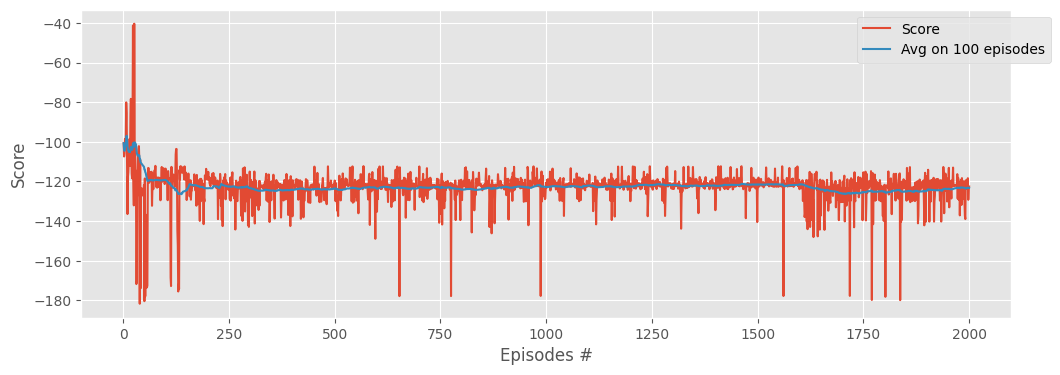

In [ ]:
%matplotlib inline

print('length of scores: ', len(scores), ', len of average scores: ', len(Avg_Scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores, label="Score")
plt.plot(np.arange(1, len(Avg_Scores) + 1), Avg_Scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [ ]:
env.close

<bound method Wrapper.close of <TimeLimit<OrderEnforcing<StepAPICompatibility<PassiveEnvChecker<BipedalWalker<BipedalWalker-v3>>>>>>>